In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:1


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return 50*(term12  + term3)

In [3]:
# Domain bounds
label = "Regr_smooth_tanh"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 5000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []

elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []

    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.0008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)

                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 3616.8254 Test MSE 3505.5753065092395 Test RE 0.9997270896914967
1 Train Loss 3614.8083 Test MSE 3504.613009039933 Test RE 0.9995898652997548
2 Train Loss 3612.7764 Test MSE 3503.652231499464 Test RE 0.9994528388548579
3 Train Loss 3610.7258 Test MSE 3502.6909228156906 Test RE 0.999315717853421
4 Train Loss 3608.652 Test MSE 3501.726504751378 Test RE 0.9991781344211357
5 Train Loss 3606.547 Test MSE 3500.757887070409 Test RE 0.9990399328021599
6 Train Loss 3604.4062 Test MSE 3499.7858370891686 Test RE 0.9989012222427974
7 Train Loss 3602.2285 Test MSE 3498.8120849169486 Test RE 0.

110 Train Loss 3526.4834 Test MSE 3492.6665634404662 Test RE 0.9978847212772188
111 Train Loss 3526.4626 Test MSE 3492.630149769179 Test RE 0.997879519414935
112 Train Loss 3526.4434 Test MSE 3492.5930926392048 Test RE 0.9978742256037452
113 Train Loss 3526.4243 Test MSE 3492.5555875706636 Test RE 0.9978688677735161
114 Train Loss 3526.406 Test MSE 3492.517820987187 Test RE 0.9978634725551969
115 Train Loss 3526.389 Test MSE 3492.479976257517 Test RE 0.9978580661438907
116 Train Loss 3526.3718 Test MSE 3492.4422338851186 Test RE 0.9978526743259362
117 Train Loss 3526.356 Test MSE 3492.404752748362 Test RE 0.9978473197988759
118 Train Loss 3526.3406 Test MSE 3492.3677056230736 Test RE 0.997842027246132
119 Train Loss 3526.3254 Test MSE 3492.3312634283143 Test RE 0.9978368210863828
120 Train Loss 3526.3113 Test MSE 3492.2955630233187 Test RE 0.9978317208729457
121 Train Loss 3526.2976 Test MSE 3492.2607446750208 Test RE 0.9978267466463417
122 Train Loss 3526.2842 Test MSE 3492.2269554699

217 Train Loss 3525.2534 Test MSE 3491.3591426988614 Test RE 0.9976979331490947
218 Train Loss 3525.235 Test MSE 3491.3467299841336 Test RE 0.9976961596061374
219 Train Loss 3525.215 Test MSE 3491.333872240608 Test RE 0.9976943224736297
220 Train Loss 3525.195 Test MSE 3491.3205648098124 Test RE 0.9976924210856088
221 Train Loss 3525.1746 Test MSE 3491.3067575702885 Test RE 0.9976904482802488
222 Train Loss 3525.1538 Test MSE 3491.2924339012834 Test RE 0.9976884016823127
223 Train Loss 3525.132 Test MSE 3491.2775809592845 Test RE 0.9976862794562311
224 Train Loss 3525.11 Test MSE 3491.262155528924 Test RE 0.9976840754267793
225 Train Loss 3525.0872 Test MSE 3491.2461507176804 Test RE 0.9976817886085894
226 Train Loss 3525.0637 Test MSE 3491.229528650853 Test RE 0.9976794135894148
227 Train Loss 3525.04 Test MSE 3491.21226669396 Test RE 0.99767694713452
228 Train Loss 3525.0151 Test MSE 3491.194336411375 Test RE 0.9976743851802199
229 Train Loss 3524.9897 Test MSE 3491.1757086839707 Tes

324 Train Loss 3464.79 Test MSE 3457.4365510615726 Test RE 0.9928392077054085
325 Train Loss 3463.635 Test MSE 3456.9964178562054 Test RE 0.9927760112585153
326 Train Loss 3462.5027 Test MSE 3456.5786579100795 Test RE 0.99271602355048
327 Train Loss 3461.3936 Test MSE 3456.184661871764 Test RE 0.9926594448688748
328 Train Loss 3460.3086 Test MSE 3455.815741693439 Test RE 0.9926064642112532
329 Train Loss 3459.2493 Test MSE 3455.4726756279474 Test RE 0.9925571939272737
330 Train Loss 3458.215 Test MSE 3455.1553673490157 Test RE 0.9925116207343919
331 Train Loss 3457.2056 Test MSE 3454.86275167449 Test RE 0.9924695921458424
332 Train Loss 3456.22 Test MSE 3454.5929639348333 Test RE 0.9924308407721101
333 Train Loss 3455.2563 Test MSE 3454.3435714368397 Test RE 0.9923950175541286
334 Train Loss 3454.3135 Test MSE 3454.1119524179444 Test RE 0.99236174619464
335 Train Loss 3453.389 Test MSE 3453.8954667922753 Test RE 0.9923306476919398
336 Train Loss 3452.4797 Test MSE 3453.691534999303 Tes

430 Train Loss 3350.24 Test MSE 3398.8331735508127 Test RE 0.9843889592625725
431 Train Loss 3348.0112 Test MSE 3397.1042153984754 Test RE 0.9841385521774799
432 Train Loss 3345.7078 Test MSE 3395.318999530879 Test RE 0.9838799303445769
433 Train Loss 3343.3171 Test MSE 3393.399511675796 Test RE 0.983601780844125
434 Train Loss 3340.8264 Test MSE 3391.311058644179 Test RE 0.9832990575316471
435 Train Loss 3338.2234 Test MSE 3389.099922485832 Test RE 0.9829784495758019
436 Train Loss 3335.5027 Test MSE 3386.8468124857473 Test RE 0.9826516479401913
437 Train Loss 3332.6692 Test MSE 3384.5832888378427 Test RE 0.9823232263842374
438 Train Loss 3329.7405 Test MSE 3382.265754842062 Test RE 0.9819868545001587
439 Train Loss 3326.7522 Test MSE 3379.837919574016 Test RE 0.9816343496292158
440 Train Loss 3323.7463 Test MSE 3377.304819765013 Test RE 0.9812664260891518
441 Train Loss 3320.7617 Test MSE 3374.729212145375 Test RE 0.9808921869462037
442 Train Loss 3317.8176 Test MSE 3372.156761229741

565 Train Loss 2958.2522 Test MSE 2992.8741295348837 Test RE 0.9237321004588531
566 Train Loss 2956.0293 Test MSE 2989.2837735683247 Test RE 0.9231778636003725
567 Train Loss 2953.7324 Test MSE 2988.476918129327 Test RE 0.9230532649662562
568 Train Loss 2951.4407 Test MSE 2985.748526910587 Test RE 0.9226318085568803
569 Train Loss 2949.184 Test MSE 2984.1133033595256 Test RE 0.9223791221909067
570 Train Loss 2946.998 Test MSE 2982.440602347741 Test RE 0.9221205728996746
571 Train Loss 2944.8784 Test MSE 2980.082571285366 Test RE 0.9217559690059547
572 Train Loss 2942.806 Test MSE 2979.1805210249954 Test RE 0.9216164538882466
573 Train Loss 2940.7654 Test MSE 2976.3179875579344 Test RE 0.9211735817720907
574 Train Loss 2938.733 Test MSE 2975.8679176542128 Test RE 0.9211039305820069
575 Train Loss 2936.7139 Test MSE 2972.7266489149106 Test RE 0.9206176524558146
576 Train Loss 2934.66 Test MSE 2972.367949052994 Test RE 0.920562108265924
577 Train Loss 2932.5935 Test MSE 2969.2655198928555

700 Train Loss 2734.6372 Test MSE 2786.3884770503855 Test RE 0.89129740605086
701 Train Loss 2733.2253 Test MSE 2784.9234324976646 Test RE 0.8910630593136551
702 Train Loss 2731.8167 Test MSE 2783.593554525407 Test RE 0.8908502802794789
703 Train Loss 2730.4104 Test MSE 2782.114257463457 Test RE 0.890613534628887
704 Train Loss 2729.0056 Test MSE 2780.7917755868325 Test RE 0.8904018322772734
705 Train Loss 2727.6086 Test MSE 2779.3168774278174 Test RE 0.8901656718041732
706 Train Loss 2726.2246 Test MSE 2778.054030581611 Test RE 0.8899634151553425
707 Train Loss 2724.8684 Test MSE 2776.6256577467248 Test RE 0.8897345925703155
708 Train Loss 2723.5437 Test MSE 2775.475780796546 Test RE 0.8895503417259879
709 Train Loss 2722.2627 Test MSE 2774.092572498433 Test RE 0.8893286523920096
710 Train Loss 2721.0034 Test MSE 2773.0124675644806 Test RE 0.8891555035588677
711 Train Loss 2719.764 Test MSE 2771.5734060489854 Test RE 0.88892475892089
712 Train Loss 2718.475 Test MSE 2770.416786249635 

808 Train Loss 2587.3193 Test MSE 2647.766419544816 Test RE 0.868843676853263
809 Train Loss 2585.2617 Test MSE 2646.0084045464278 Test RE 0.8685551895780127
810 Train Loss 2583.2297 Test MSE 2644.4402092608802 Test RE 0.8682977705118464
811 Train Loss 2581.3638 Test MSE 2643.0983730292114 Test RE 0.868077447654551
812 Train Loss 2579.7783 Test MSE 2642.1131512826223 Test RE 0.8679156435193388
813 Train Loss 2578.5247 Test MSE 2641.2961746882843 Test RE 0.8677814476034728
814 Train Loss 2577.513 Test MSE 2640.665589470028 Test RE 0.8676778539923077
815 Train Loss 2576.6018 Test MSE 2639.9037469291025 Test RE 0.8675526807048924
816 Train Loss 2575.6191 Test MSE 2639.142256077703 Test RE 0.8674275471507435
817 Train Loss 2574.5146 Test MSE 2638.084334400303 Test RE 0.8672536720240914
818 Train Loss 2573.2522 Test MSE 2636.9991316736746 Test RE 0.8670752768824561
819 Train Loss 2571.8967 Test MSE 2635.6977138653406 Test RE 0.866861289996131
820 Train Loss 2570.4907 Test MSE 2634.458845679

915 Train Loss 2469.8645 Test MSE 2545.684072054653 Test RE 0.8519302955553683
916 Train Loss 2469.002 Test MSE 2544.9643419610693 Test RE 0.8518098557837551
917 Train Loss 2468.1501 Test MSE 2544.068196577714 Test RE 0.8516598708375527
918 Train Loss 2467.2805 Test MSE 2543.338168936839 Test RE 0.8515376689532341
919 Train Loss 2466.4192 Test MSE 2542.4308760944223 Test RE 0.8513857695801427
920 Train Loss 2465.5364 Test MSE 2541.6799500877933 Test RE 0.8512600287121027
921 Train Loss 2464.66 Test MSE 2540.768955683199 Test RE 0.8511074598129543
922 Train Loss 2463.7656 Test MSE 2539.9922526301016 Test RE 0.850977359771885
923 Train Loss 2462.878 Test MSE 2539.090017487055 Test RE 0.8508262077609857
924 Train Loss 2461.983 Test MSE 2538.2900653788747 Test RE 0.850692168827649
925 Train Loss 2461.0962 Test MSE 2537.406273345463 Test RE 0.850544057225359
926 Train Loss 2460.2122 Test MSE 2536.5876753117504 Test RE 0.8504068482446419
927 Train Loss 2459.3364 Test MSE 2535.7240221262527 T

1019 Train Loss 2381.8875 Test MSE 2462.4526455079313 Test RE 0.8378875813340658
1020 Train Loss 2380.7117 Test MSE 2461.4418600737963 Test RE 0.8377155959979705
1021 Train Loss 2379.4753 Test MSE 2460.241619134589 Test RE 0.837511328903579
1022 Train Loss 2378.0825 Test MSE 2459.0897185563417 Test RE 0.8373152419164053
1023 Train Loss 2376.6829 Test MSE 2457.809617912973 Test RE 0.8370972776636086
1024 Train Loss 2375.277 Test MSE 2456.5206562908384 Test RE 0.8368777472820221
1025 Train Loss 2373.9788 Test MSE 2455.1214895731546 Test RE 0.8366393820421708
1026 Train Loss 2372.7588 Test MSE 2453.5485647236396 Test RE 0.8363713338573276
1027 Train Loss 2371.5334 Test MSE 2451.6941943679844 Test RE 0.8360552130786255
1028 Train Loss 2370.1838 Test MSE 2449.457832324108 Test RE 0.8356738138160001
1029 Train Loss 2368.5813 Test MSE 2446.701880437484 Test RE 0.8352035617929331
1030 Train Loss 2366.6963 Test MSE 2443.429353395748 Test RE 0.834644821716118
1031 Train Loss 2364.4946 Test MSE 2

1128 Train Loss 2200.5352 Test MSE 2239.7492716984507 Test RE 0.7991007014486207
1129 Train Loss 2198.9868 Test MSE 2238.5403882679816 Test RE 0.7988850188285539
1130 Train Loss 2197.4045 Test MSE 2237.1462011920917 Test RE 0.798636202982044
1131 Train Loss 2195.9922 Test MSE 2235.7824266298617 Test RE 0.7983927397302177
1132 Train Loss 2194.8167 Test MSE 2234.6473391667537 Test RE 0.7981900454449454
1133 Train Loss 2193.68 Test MSE 2232.799445168043 Test RE 0.7978599540656556
1134 Train Loss 2192.2463 Test MSE 2231.2771177768223 Test RE 0.7975879163854298
1135 Train Loss 2190.663 Test MSE 2229.3316556035093 Test RE 0.7972401300245979
1136 Train Loss 2188.998 Test MSE 2227.6703080050897 Test RE 0.7969430141099574
1137 Train Loss 2187.5059 Test MSE 2226.133422541152 Test RE 0.7966680583739667
1138 Train Loss 2186.183 Test MSE 2224.3999654670433 Test RE 0.7963578211682081
1139 Train Loss 2184.8647 Test MSE 2222.8384173742006 Test RE 0.796078247040641
1140 Train Loss 2183.4346 Test MSE 22

1261 Train Loss 2034.6884 Test MSE 2053.894859503243 Test RE 0.7652281078151694
1262 Train Loss 2033.8228 Test MSE 2053.071942122156 Test RE 0.7650747935896886
1263 Train Loss 2032.9504 Test MSE 2052.2382015532885 Test RE 0.7649194316043346
1264 Train Loss 2032.073 Test MSE 2051.404093670923 Test RE 0.7647639695898792
1265 Train Loss 2031.1934 Test MSE 2050.5509985052913 Test RE 0.7646049360065488
1266 Train Loss 2030.3157 Test MSE 2049.716428143753 Test RE 0.7644493237931433
1267 Train Loss 2029.4434 Test MSE 2048.8661077035053 Test RE 0.7642907422678703
1268 Train Loss 2028.5795 Test MSE 2048.0444745423906 Test RE 0.7641374795472368
1269 Train Loss 2027.7249 Test MSE 2047.220967786541 Test RE 0.7639838364857608
1270 Train Loss 2026.879 Test MSE 2046.4076914543261 Test RE 0.7638320718004558
1271 Train Loss 2026.0397 Test MSE 2045.6109005271 Test RE 0.763683354191187
1272 Train Loss 2025.2039 Test MSE 2044.8039658404193 Test RE 0.7635327137706495
1273 Train Loss 2024.3696 Test MSE 2044

1386 Train Loss 1921.1243 Test MSE 1931.3054296663406 Test RE 0.7420399553251584
1387 Train Loss 1920.4067 Test MSE 1930.6825056822495 Test RE 0.7419202767500976
1388 Train Loss 1919.688 Test MSE 1929.9552741042855 Test RE 0.7417805337655475
1389 Train Loss 1918.9669 Test MSE 1929.3053677328996 Test RE 0.7416556271177707
1390 Train Loss 1918.2452 Test MSE 1928.6256189878973 Test RE 0.7415249625004279
1391 Train Loss 1917.5255 Test MSE 1927.9332869552918 Test RE 0.741391855390174
1392 Train Loss 1916.8083 Test MSE 1927.2867761084583 Test RE 0.7412675362371939
1393 Train Loss 1916.0919 Test MSE 1926.5830766631234 Test RE 0.7411321964465156
1394 Train Loss 1915.375 Test MSE 1925.9371946677352 Test RE 0.741007954706359
1395 Train Loss 1914.6573 Test MSE 1925.2461168005284 Test RE 0.7408749960239931
1396 Train Loss 1913.9404 Test MSE 1924.585181859489 Test RE 0.7407478143092583
1397 Train Loss 1913.2252 Test MSE 1923.9258016641088 Test RE 0.7406209100065009
1398 Train Loss 1912.5121 Test MS

1518 Train Loss 1834.684 Test MSE 1848.8772538634673 Test RE 0.7260321452462701
1519 Train Loss 1834.0984 Test MSE 1848.3213248632035 Test RE 0.7259229836810166
1520 Train Loss 1833.5146 Test MSE 1847.7778243122732 Test RE 0.7258162466802045
1521 Train Loss 1832.9325 Test MSE 1847.2285158308237 Test RE 0.7257083531199896
1522 Train Loss 1832.3525 Test MSE 1846.6956678915055 Test RE 0.7256036773618649
1523 Train Loss 1831.7738 Test MSE 1846.149696664124 Test RE 0.725496407923162
1524 Train Loss 1831.1965 Test MSE 1845.627029227668 Test RE 0.7253937022241781
1525 Train Loss 1830.6202 Test MSE 1845.0784405368827 Test RE 0.7252858872782729
1526 Train Loss 1830.045 Test MSE 1844.5673154706271 Test RE 0.7251854206893413
1527 Train Loss 1829.4713 Test MSE 1844.0081539526004 Test RE 0.7250754961253514
1528 Train Loss 1828.8986 Test MSE 1843.5148091385527 Test RE 0.7249784965096586
1529 Train Loss 1828.3275 Test MSE 1842.9324374856105 Test RE 0.724863976064086
1530 Train Loss 1827.7576 Test MSE

1635 Train Loss 1768.4163 Test MSE 1782.905515938735 Test RE 0.7129613286627213
1636 Train Loss 1767.8826 Test MSE 1782.563237816441 Test RE 0.712892889035406
1637 Train Loss 1767.3572 Test MSE 1781.8675458960672 Test RE 0.7127537629130745
1638 Train Loss 1766.8317 Test MSE 1781.5743738027759 Test RE 0.7126951255275596
1639 Train Loss 1766.3021 Test MSE 1780.8653181762434 Test RE 0.7125532872785373
1640 Train Loss 1765.765 Test MSE 1780.5415824329327 Test RE 0.712488518356869
1641 Train Loss 1765.2229 Test MSE 1779.8753906299612 Test RE 0.7123552166632365
1642 Train Loss 1764.6783 Test MSE 1779.4851365581906 Test RE 0.712277117161026
1643 Train Loss 1764.1355 Test MSE 1778.8948974871184 Test RE 0.7121589794359665
1644 Train Loss 1763.5978 Test MSE 1778.4322494205012 Test RE 0.7120663656450633
1645 Train Loss 1763.0671 Test MSE 1777.9326087563504 Test RE 0.7119663330731473
1646 Train Loss 1762.5442 Test MSE 1777.4005079375167 Test RE 0.7118597862288244
1647 Train Loss 1762.028 Test MSE 

1765 Train Loss 1706.6411 Test MSE 1725.0865387809724 Test RE 0.7013055131445527
1766 Train Loss 1706.2053 Test MSE 1724.6218974425046 Test RE 0.7012110606432657
1767 Train Loss 1705.7694 Test MSE 1724.2741615350733 Test RE 0.701140364406234
1768 Train Loss 1705.3325 Test MSE 1723.8041598108555 Test RE 0.7010447996616972
1769 Train Loss 1704.8944 Test MSE 1723.44556117565 Test RE 0.7009718775775655
1770 Train Loss 1704.4558 Test MSE 1722.9957264018065 Test RE 0.7008803916289378
1771 Train Loss 1704.0177 Test MSE 1722.6118411908628 Test RE 0.7008023088452398
1772 Train Loss 1703.5802 Test MSE 1722.192566285141 Test RE 0.7007170178074598
1773 Train Loss 1703.1443 Test MSE 1721.781828019876 Test RE 0.7006334532686936
1774 Train Loss 1702.7095 Test MSE 1721.3912618041538 Test RE 0.700553983479901
1775 Train Loss 1702.2758 Test MSE 1720.9583697912199 Test RE 0.7004658909877194
1776 Train Loss 1701.8423 Test MSE 1720.5865413280935 Test RE 0.7003902159365037
1777 Train Loss 1701.4095 Test MSE

1898 Train Loss 1651.3376 Test MSE 1672.9047754278124 Test RE 0.6906172476229859
1899 Train Loss 1650.9229 Test MSE 1672.4681690882032 Test RE 0.6905271206924926
1900 Train Loss 1650.5056 Test MSE 1672.1183453738927 Test RE 0.690454899468894
1901 Train Loss 1650.0819 Test MSE 1671.6516726466068 Test RE 0.6903585429649003
1902 Train Loss 1649.6495 Test MSE 1671.2798775176532 Test RE 0.6902817667378269
1903 Train Loss 1649.2085 Test MSE 1670.8156438915837 Test RE 0.6901858898389069
1904 Train Loss 1648.7592 Test MSE 1670.3910527294083 Test RE 0.6900981885266947
1905 Train Loss 1648.3013 Test MSE 1669.9415115952245 Test RE 0.6900053215309594
1906 Train Loss 1647.8333 Test MSE 1669.4517429580294 Test RE 0.6899041300384239
1907 Train Loss 1647.3508 Test MSE 1668.98965229391 Test RE 0.689808643504531
1908 Train Loss 1646.8484 Test MSE 1668.4303059471638 Test RE 0.689693042345045
1909 Train Loss 1646.3197 Test MSE 1667.905026949082 Test RE 0.6895844643037261
1910 Train Loss 1645.7582 Test MSE

2030 Train Loss 1530.208 Test MSE 1528.799004707971 Test RE 0.6602022582540514
2031 Train Loss 1529.5614 Test MSE 1528.1566308051333 Test RE 0.660063541111115
2032 Train Loss 1528.9204 Test MSE 1527.52189950259 Test RE 0.6599264457058875
2033 Train Loss 1528.2855 Test MSE 1526.8915349892754 Test RE 0.6597902652887734
2034 Train Loss 1527.6544 Test MSE 1526.2588333286599 Test RE 0.6596535516975068
2035 Train Loss 1527.0248 Test MSE 1525.629228709601 Test RE 0.6595174791800483
2036 Train Loss 1526.3977 Test MSE 1525.0031343077671 Test RE 0.6593821374579084
2037 Train Loss 1525.7744 Test MSE 1524.3810780082401 Test RE 0.6592476411281685
2038 Train Loss 1525.1528 Test MSE 1523.7636974360373 Test RE 0.6591141286128382
2039 Train Loss 1524.5317 Test MSE 1523.1523074722384 Test RE 0.6589818849473043
2040 Train Loss 1523.9115 Test MSE 1522.5507021453948 Test RE 0.6588517317890759
2041 Train Loss 1523.2947 Test MSE 1521.958995712213 Test RE 0.6587236951032006
2042 Train Loss 1522.6807 Test MSE 

2159 Train Loss 1443.3425 Test MSE 1442.9948805234246 Test RE 0.6414077528085536
2160 Train Loss 1440.5784 Test MSE 1441.1790049990425 Test RE 0.6410040496118331
2161 Train Loss 1438.638 Test MSE 1439.8727662736233 Test RE 0.6407134909364829
2162 Train Loss 1437.2711 Test MSE 1438.84666622424 Test RE 0.640485153638415
2163 Train Loss 1436.1862 Test MSE 1437.9075897891385 Test RE 0.6402761102779224
2164 Train Loss 1435.1582 Test MSE 1436.8932187923253 Test RE 0.6400502292461278
2165 Train Loss 1434.0233 Test MSE 1435.6867823837727 Test RE 0.6397814750891706
2166 Train Loss 1432.6486 Test MSE 1434.2131619904912 Test RE 0.6394530479241658
2167 Train Loss 1430.9244 Test MSE 1432.4159844936705 Test RE 0.6390522808359281
2168 Train Loss 1428.7925 Test MSE 1430.3017724648776 Test RE 0.6385804936780743
2169 Train Loss 1426.2983 Test MSE 1428.0036285004003 Test RE 0.6380672663620448
2170 Train Loss 1423.6259 Test MSE 1425.760126755139 Test RE 0.6375658433649757
2171 Train Loss 1421.0604 Test MS

2269 Train Loss 1356.327 Test MSE 1362.8393226962698 Test RE 0.6233387673902335
2270 Train Loss 1355.5085 Test MSE 1362.2044517793395 Test RE 0.6231935610745577
2271 Train Loss 1354.6844 Test MSE 1361.5710913232865 Test RE 0.6230486665074773
2272 Train Loss 1353.8698 Test MSE 1360.9493050575154 Test RE 0.6229063869948669
2273 Train Loss 1353.0807 Test MSE 1360.3452371069693 Test RE 0.6227681307255478
2274 Train Loss 1352.3295 Test MSE 1359.7546341419625 Test RE 0.6226329265785403
2275 Train Loss 1351.6211 Test MSE 1359.1665054747816 Test RE 0.6224982596801635
2276 Train Loss 1350.9504 Test MSE 1358.5598556601242 Test RE 0.6223593213674208
2277 Train Loss 1350.3033 Test MSE 1357.9123452395213 Test RE 0.6222109907021157
2278 Train Loss 1349.6575 Test MSE 1357.1955463095387 Test RE 0.6220467462842767
2279 Train Loss 1348.9856 Test MSE 1356.3825493331412 Test RE 0.621860406930565
2280 Train Loss 1348.2573 Test MSE 1355.4383505349674 Test RE 0.6216439259431473
2281 Train Loss 1347.4407 Test

2375 Train Loss 1276.441 Test MSE 1279.0056758238422 Test RE 0.603862479256967
2376 Train Loss 1273.6963 Test MSE 1276.690268917765 Test RE 0.6033156401202973
2377 Train Loss 1271.2819 Test MSE 1275.1433461050913 Test RE 0.6029500206635161
2378 Train Loss 1269.3632 Test MSE 1273.6713488521884 Test RE 0.6026019040913402
2379 Train Loss 1267.9531 Test MSE 1272.7960304547555 Test RE 0.6023948023185679
2380 Train Loss 1266.9517 Test MSE 1272.0774572174928 Test RE 0.6022247334760592
2381 Train Loss 1266.228 Test MSE 1271.4866882294402 Test RE 0.6020848768145628
2382 Train Loss 1265.6705 Test MSE 1271.1657117442508 Test RE 0.6020088762998529
2383 Train Loss 1265.198 Test MSE 1270.619975156137 Test RE 0.6018796352667222
2384 Train Loss 1264.7546 Test MSE 1270.3850750733475 Test RE 0.6018239978165638
2385 Train Loss 1264.3083 Test MSE 1269.8385938680553 Test RE 0.6016945406594737
2386 Train Loss 1263.848 Test MSE 1269.5481402130417 Test RE 0.6016257231049801
2387 Train Loss 1263.3679 Test MSE 

2489 Train Loss 1210.8734 Test MSE 1215.0360082485004 Test RE 0.588567645019093
2490 Train Loss 1210.4044 Test MSE 1215.0685538670286 Test RE 0.5885755275714012
2491 Train Loss 1209.7908 Test MSE 1214.1091214686162 Test RE 0.5883431086081142
2492 Train Loss 1209.199 Test MSE 1213.7956691652453 Test RE 0.5882671560418143
2493 Train Loss 1208.6028 Test MSE 1213.0060427909732 Test RE 0.588075778347833
2494 Train Loss 1208.0417 Test MSE 1212.4379916846488 Test RE 0.5879380641882872
2495 Train Loss 1207.5176 Test MSE 1211.9167294221738 Test RE 0.5878116647869172
2496 Train Loss 1207.0187 Test MSE 1211.1963334255622 Test RE 0.5876369332616014
2497 Train Loss 1206.5311 Test MSE 1210.9216607958977 Test RE 0.5875702979320261
2498 Train Loss 1206.0417 Test MSE 1210.01297874022 Test RE 0.5873497986197441
2499 Train Loss 1205.5415 Test MSE 1209.845881116775 Test RE 0.5873092419704431
2500 Train Loss 1204.9673 Test MSE 1208.596113175454 Test RE 0.5870058190606251
2501 Train Loss 1204.3234 Test MSE 

2607 Train Loss 1095.0286 Test MSE 1122.359618354324 Test RE 0.5656760950265226
2608 Train Loss 1094.2599 Test MSE 1121.7078685804763 Test RE 0.565511828244661
2609 Train Loss 1093.6008 Test MSE 1121.4034817406725 Test RE 0.5654350943452741
2610 Train Loss 1092.9965 Test MSE 1120.5415578231318 Test RE 0.5652177525393919
2611 Train Loss 1092.3961 Test MSE 1120.379010512365 Test RE 0.5651767554174473
2612 Train Loss 1091.704 Test MSE 1119.3080357669671 Test RE 0.5649065634801561
2613 Train Loss 1090.965 Test MSE 1118.988974585411 Test RE 0.5648260438215292
2614 Train Loss 1090.1302 Test MSE 1117.9708969052908 Test RE 0.5645690405552578
2615 Train Loss 1089.3083 Test MSE 1117.4870973118327 Test RE 0.5644468692941557
2616 Train Loss 1088.521 Test MSE 1116.816184898507 Test RE 0.5642774036828705
2617 Train Loss 1087.8054 Test MSE 1116.18225449249 Test RE 0.5641172325713053
2618 Train Loss 1087.1542 Test MSE 1115.8012074047624 Test RE 0.5640209339711172
2619 Train Loss 1086.5347 Test MSE 111

2729 Train Loss 998.9044 Test MSE 1029.16927932233 Test RE 0.5416830135293732
2730 Train Loss 998.2924 Test MSE 1028.5602469287337 Test RE 0.5415227136982139
2731 Train Loss 997.7063 Test MSE 1027.9855847169022 Test RE 0.5413714167179241
2732 Train Loss 997.1393 Test MSE 1027.493510145878 Test RE 0.5412418297866283
2733 Train Loss 996.5838 Test MSE 1026.7630512005883 Test RE 0.5410494075362686
2734 Train Loss 996.0367 Test MSE 1026.4442169415072 Test RE 0.5409653966826519
2735 Train Loss 995.48755 Test MSE 1025.5931488993178 Test RE 0.5407410816020372
2736 Train Loss 994.941 Test MSE 1025.2908361296043 Test RE 0.5406613789525485
2737 Train Loss 994.3814 Test MSE 1024.4531145979963 Test RE 0.5404404581091756
2738 Train Loss 993.8263 Test MSE 1024.1347175643316 Test RE 0.5403564679253234
2739 Train Loss 993.2529 Test MSE 1023.2512535283124 Test RE 0.5401233499107879
2740 Train Loss 992.68646 Test MSE 1022.984994148385 Test RE 0.5400530728090922
2741 Train Loss 992.10376 Test MSE 1022.069

2853 Train Loss 917.38776 Test MSE 953.4046518779023 Test RE 0.5213632835386202
2854 Train Loss 916.8247 Test MSE 952.911530890462 Test RE 0.521228436058566
2855 Train Loss 916.269 Test MSE 952.4637088170607 Test RE 0.5211059456585868
2856 Train Loss 915.71814 Test MSE 952.0717859521396 Test RE 0.5209987214424661
2857 Train Loss 915.1788 Test MSE 951.5869098579562 Test RE 0.520866036070977
2858 Train Loss 914.6456 Test MSE 951.2554734607327 Test RE 0.5207753197132258
2859 Train Loss 914.1313 Test MSE 950.7866366749397 Test RE 0.5206469689571389
2860 Train Loss 913.6254 Test MSE 950.4721941043961 Test RE 0.5205608680892061
2861 Train Loss 913.158 Test MSE 950.1010395426857 Test RE 0.5204592199781622
2862 Train Loss 912.6992 Test MSE 949.7502241693786 Test RE 0.5203631239075899
2863 Train Loss 912.3223 Test MSE 949.5800809839515 Test RE 0.5203165115442585
2864 Train Loss 911.9322 Test MSE 949.1684042587475 Test RE 0.5202037114640267
2865 Train Loss 911.7065 Test MSE 949.2244829806061 Tes

2980 Train Loss 849.3138 Test MSE 897.38643893674 Test RE 0.5058148331824506
2981 Train Loss 848.8893 Test MSE 896.7161150120706 Test RE 0.5056258827424553
2982 Train Loss 848.459 Test MSE 896.4758773391483 Test RE 0.5055581475249065
2983 Train Loss 848.0151 Test MSE 895.9003803031142 Test RE 0.5053958487215942
2984 Train Loss 847.57306 Test MSE 895.5278005306616 Test RE 0.5052907478333011
2985 Train Loss 847.1429 Test MSE 895.1884002791346 Test RE 0.5051949875124682
2986 Train Loss 846.7314 Test MSE 894.6973567036622 Test RE 0.5050564095430264
2987 Train Loss 846.33514 Test MSE 894.4985356039568 Test RE 0.5050002891972634
2988 Train Loss 845.9464 Test MSE 894.0082386972583 Test RE 0.5048618686140753
2989 Train Loss 845.55756 Test MSE 893.7726329130314 Test RE 0.504795338905936
2990 Train Loss 845.16364 Test MSE 893.3908842859254 Test RE 0.5046875231696109
2991 Train Loss 844.76416 Test MSE 893.0327887442177 Test RE 0.5045863667391893
2992 Train Loss 844.35876 Test MSE 892.767503070950

3102 Train Loss 802.38434 Test MSE 850.5707188046636 Test RE 0.4924441967275814
3103 Train Loss 802.09265 Test MSE 850.2383321884312 Test RE 0.49234796848302315
3104 Train Loss 801.8008 Test MSE 849.9510820367714 Test RE 0.49226479240730364
3105 Train Loss 801.50757 Test MSE 849.6139560803462 Test RE 0.49216715637746916
3106 Train Loss 801.21387 Test MSE 849.3094715624219 Test RE 0.49207895707993027
3107 Train Loss 800.9216 Test MSE 849.0149410636365 Test RE 0.4919936260946402
3108 Train Loss 800.6317 Test MSE 848.6854801220137 Test RE 0.49189815756777083
3109 Train Loss 800.3437 Test MSE 848.4078861544845 Test RE 0.4918177042479195
3110 Train Loss 800.056 Test MSE 848.0890861273883 Test RE 0.4917252921947867
3111 Train Loss 799.7684 Test MSE 847.7815490794655 Test RE 0.4916361285331901
3112 Train Loss 799.4807 Test MSE 847.4955355950591 Test RE 0.49155319064428915
3113 Train Loss 799.19385 Test MSE 847.1598558646399 Test RE 0.4914558327363429
3114 Train Loss 798.90826 Test MSE 846.882

3234 Train Loss 769.48083 Test MSE 813.3521895094348 Test RE 0.48154971473219144
3235 Train Loss 769.2622 Test MSE 813.0630039289063 Test RE 0.4814641001509829
3236 Train Loss 769.0462 Test MSE 812.6815607649503 Test RE 0.48135114904292203
3237 Train Loss 768.8409 Test MSE 812.6935275948327 Test RE 0.48135469300551914
3238 Train Loss 768.63763 Test MSE 812.154976282768 Test RE 0.4811951758235217
3239 Train Loss 768.4277 Test MSE 812.1170851929179 Test RE 0.4811839506122965
3240 Train Loss 768.21466 Test MSE 811.7714878619721 Test RE 0.4810815555342508
3241 Train Loss 768.0073 Test MSE 811.5035465573606 Test RE 0.4810021537198653
3242 Train Loss 767.80536 Test MSE 811.3429294116823 Test RE 0.48095455009786553
3243 Train Loss 767.6023 Test MSE 811.0267405549965 Test RE 0.48086082444700506
3244 Train Loss 767.39575 Test MSE 810.7623172186974 Test RE 0.4807824292580791
3245 Train Loss 767.1904 Test MSE 810.6481958843325 Test RE 0.48074859106524587
3246 Train Loss 766.98987 Test MSE 810.185

3356 Train Loss 747.20087 Test MSE 785.7733190502931 Test RE 0.4733151971745817
3357 Train Loss 747.34503 Test MSE 785.8540659342507 Test RE 0.4733395157309494
3358 Train Loss 747.4828 Test MSE 786.056903789987 Test RE 0.47340059894090764
3359 Train Loss 747.8729 Test MSE 786.1854862658141 Test RE 0.4734393165780619
3360 Train Loss 748.07227 Test MSE 786.4702632930761 Test RE 0.4735250548907587
3361 Train Loss 748.59174 Test MSE 786.356172771486 Test RE 0.4734907073238785
3362 Train Loss 748.4214 Test MSE 786.045370691239 Test RE 0.47339712603973777
3363 Train Loss 748.37854 Test MSE 785.3689308876824 Test RE 0.4731933887023404
3364 Train Loss 747.31494 Test MSE 784.0621014408142 Test RE 0.47279953526170226
3365 Train Loss 746.2808 Test MSE 783.4470640846127 Test RE 0.4726140611624021
3366 Train Loss 745.1964 Test MSE 782.6521333079434 Test RE 0.47237422950758673
3367 Train Loss 744.6908 Test MSE 782.8044324130004 Test RE 0.4724201877755152
3368 Train Loss 744.7802 Test MSE 782.9771448

3479 Train Loss 728.29254 Test MSE 762.7190805480997 Test RE 0.4663200784677651
3480 Train Loss 728.2296 Test MSE 761.6042532617151 Test RE 0.46597915579691035
3481 Train Loss 728.3419 Test MSE 761.840358442279 Test RE 0.46605137937413404
3482 Train Loss 727.9221 Test MSE 761.3661138347211 Test RE 0.4659062986112788
3483 Train Loss 727.57416 Test MSE 760.3444635145014 Test RE 0.46559360206660727
3484 Train Loss 726.8109 Test MSE 760.3415908820423 Test RE 0.4655927225438243
3485 Train Loss 726.1316 Test MSE 759.0856688213355 Test RE 0.46520803370922853
3486 Train Loss 725.57275 Test MSE 759.3691748473849 Test RE 0.46529489937803187
3487 Train Loss 725.3241 Test MSE 759.0467583947295 Test RE 0.4651961103679183
3488 Train Loss 725.3633 Test MSE 759.0527276430398 Test RE 0.46519793954748173
3489 Train Loss 725.51324 Test MSE 759.3955259610176 Test RE 0.4653029724818697
3490 Train Loss 725.61743 Test MSE 758.7762445077847 Test RE 0.46511320821419283
3491 Train Loss 725.45233 Test MSE 758.80

3605 Train Loss 710.7425 Test MSE 739.013506466497 Test RE 0.45901618356730156
3606 Train Loss 710.52734 Test MSE 739.0044688157584 Test RE 0.4590133768252072
3607 Train Loss 710.182 Test MSE 738.0670037614664 Test RE 0.4587221434346979
3608 Train Loss 709.9193 Test MSE 738.7292047213085 Test RE 0.4589278823020166
3609 Train Loss 709.853 Test MSE 738.0147321086082 Test RE 0.45870589925288224
3610 Train Loss 709.86926 Test MSE 738.2282437707605 Test RE 0.4587722475059571
3611 Train Loss 709.7871 Test MSE 738.0572791308401 Test RE 0.45871912140683574
3612 Train Loss 709.59155 Test MSE 737.4034584610599 Test RE 0.45851589429733886
3613 Train Loss 709.35486 Test MSE 737.8333682009094 Test RE 0.4586495333007934
3614 Train Loss 709.1945 Test MSE 737.067882324856 Test RE 0.4584115521629292
3615 Train Loss 709.1207 Test MSE 737.4371362608606 Test RE 0.45852636456975937
3616 Train Loss 709.0613 Test MSE 737.101636696159 Test RE 0.4584220486293765
3617 Train Loss 708.95624 Test MSE 736.768040933

3724 Train Loss 696.8633 Test MSE 720.319705713977 Test RE 0.4531734498090844
3725 Train Loss 696.75555 Test MSE 720.1584187663871 Test RE 0.4531227118841184
3726 Train Loss 696.648 Test MSE 720.0134896793384 Test RE 0.4530771149962901
3727 Train Loss 696.54065 Test MSE 719.8517314191041 Test RE 0.45302621797584364
3728 Train Loss 696.43365 Test MSE 719.7077462360179 Test RE 0.45298090841957916
3729 Train Loss 696.327 Test MSE 719.5460497161569 Test RE 0.4529300200198727
3730 Train Loss 696.22095 Test MSE 719.4037129539664 Test RE 0.45288521970368895
3731 Train Loss 696.1161 Test MSE 719.2437780136734 Test RE 0.45283487509507536
3732 Train Loss 696.01306 Test MSE 719.1047738891502 Test RE 0.4527911145795982
3733 Train Loss 695.91284 Test MSE 718.9514357385538 Test RE 0.4527428365982368
3734 Train Loss 695.8173 Test MSE 718.8206200513894 Test RE 0.45270164566609106
3735 Train Loss 695.73 Test MSE 718.6866932501986 Test RE 0.4526594712307161
3736 Train Loss 695.6547 Test MSE 718.57942995

3845 Train Loss 683.8288 Test MSE 700.1647538751627 Test RE 0.446788444491466
3846 Train Loss 683.72845 Test MSE 699.751189955717 Test RE 0.4466564734999992
3847 Train Loss 683.6288 Test MSE 699.9090379997903 Test RE 0.4467068484590964
3848 Train Loss 683.5301 Test MSE 699.3757249294895 Test RE 0.4465366263391995
3849 Train Loss 683.43286 Test MSE 699.6896585989722 Test RE 0.44663683510323066
3850 Train Loss 683.338 Test MSE 698.9749900258284 Test RE 0.4464086776229448
3851 Train Loss 683.24615 Test MSE 699.5310573745605 Test RE 0.4465862118285202
3852 Train Loss 683.15936 Test MSE 698.5416317327124 Test RE 0.446270271456982
3853 Train Loss 683.07947 Test MSE 699.4664739793511 Test RE 0.44656559607512175
3854 Train Loss 683.0098 Test MSE 698.0856015774098 Test RE 0.4461245779738113
3855 Train Loss 682.9516 Test MSE 699.5050242865113 Test RE 0.446577901885581
3856 Train Loss 682.9065 Test MSE 697.6556843033736 Test RE 0.44598718350479055
3857 Train Loss 682.8638 Test MSE 699.50152427224

3958 Train Loss 672.92725 Test MSE 683.0171289089814 Test RE 0.4412834170706639
3959 Train Loss 672.36523 Test MSE 681.749323076182 Test RE 0.4408736751157031
3960 Train Loss 671.8624 Test MSE 681.6824225179628 Test RE 0.4408520429573785
3961 Train Loss 671.6814 Test MSE 682.0667380349018 Test RE 0.4409762961303664
3962 Train Loss 671.76294 Test MSE 681.1471065365607 Test RE 0.4406789113895249
3963 Train Loss 671.83374 Test MSE 681.9864464478451 Test RE 0.44095033992494
3964 Train Loss 671.6587 Test MSE 680.5868964562721 Test RE 0.4404976557202052
3965 Train Loss 671.30646 Test MSE 680.8557192881461 Test RE 0.4405846425083715
3966 Train Loss 670.9538 Test MSE 680.4448026547742 Test RE 0.4404516694882281
3967 Train Loss 670.7695 Test MSE 679.9546833257453 Test RE 0.4402930138831226
3968 Train Loss 670.7355 Test MSE 680.5642490744153 Test RE 0.4404903266034815
3969 Train Loss 670.70544 Test MSE 679.4697865876581 Test RE 0.44013599259345704
3970 Train Loss 670.56934 Test MSE 679.931810701

4076 Train Loss 659.1782 Test MSE 661.3434613164903 Test RE 0.4342255179699184
4077 Train Loss 658.7233 Test MSE 661.3005253096544 Test RE 0.43421142225905857
4078 Train Loss 658.69666 Test MSE 660.7451561351684 Test RE 0.434029055633796
4079 Train Loss 658.9393 Test MSE 661.9090275670483 Test RE 0.43441114830464483
4080 Train Loss 659.12427 Test MSE 660.4644111979142 Test RE 0.43393683822968887
4081 Train Loss 659.08966 Test MSE 661.478255731679 Test RE 0.4342697674378875
4082 Train Loss 658.7532 Test MSE 659.964532719893 Test RE 0.433772592630862
4083 Train Loss 658.35876 Test MSE 660.3801969677072 Test RE 0.4339091722259322
4084 Train Loss 658.0759 Test MSE 660.0542148886653 Test RE 0.4338020641732264
4085 Train Loss 657.996 Test MSE 659.6554034034884 Test RE 0.4336709905565721
4086 Train Loss 658.0551 Test MSE 660.4468185275512 Test RE 0.4339310588428955
4087 Train Loss 658.1095 Test MSE 659.2203327205308 Test RE 0.4335279547733913
4088 Train Loss 658.0676 Test MSE 660.190571726870

4209 Train Loss 647.32166 Test MSE 643.3749867613387 Test RE 0.42828601756168144
4210 Train Loss 647.2526 Test MSE 642.833495309554 Test RE 0.42810574785915423
4211 Train Loss 647.1614 Test MSE 643.115842968946 Test RE 0.42819975461745546
4212 Train Loss 647.05176 Test MSE 642.5504639052949 Test RE 0.4280114927278319
4213 Train Loss 646.9392 Test MSE 642.7833073247892 Test RE 0.4280890357678511
4214 Train Loss 646.8329 Test MSE 642.3567743225871 Test RE 0.4279469782496392
4215 Train Loss 646.73773 Test MSE 642.3928614360065 Test RE 0.4279589989481558
4216 Train Loss 646.6533 Test MSE 642.2706710162101 Test RE 0.4279182956809112
4217 Train Loss 646.57715 Test MSE 641.9908426772782 Test RE 0.42782506652007224
4218 Train Loss 646.50525 Test MSE 642.1969763549024 Test RE 0.42789374512929884
4219 Train Loss 646.43304 Test MSE 641.6464291288139 Test RE 0.42771029189471527
4220 Train Loss 646.3569 Test MSE 642.0166727088802 Test RE 0.4278336730476902
4221 Train Loss 646.27374 Test MSE 641.396

4342 Train Loss 636.2066 Test MSE 626.9448531891303 Test RE 0.422781991931243
4343 Train Loss 636.12317 Test MSE 627.0450919535712 Test RE 0.42281578872411624
4344 Train Loss 636.0399 Test MSE 626.7037607104832 Test RE 0.42270069342546923
4345 Train Loss 635.95685 Test MSE 626.823953116797 Test RE 0.42274122531707603
4346 Train Loss 635.87427 Test MSE 626.4476182453616 Test RE 0.4226143027974756
4347 Train Loss 635.7921 Test MSE 626.6188544721124 Test RE 0.4226720585713599
4348 Train Loss 635.71045 Test MSE 626.1789347288723 Test RE 0.4225236633955134
4349 Train Loss 635.6297 Test MSE 626.4305722775142 Test RE 0.42260855298008193
4350 Train Loss 635.55005 Test MSE 625.8990816762357 Test RE 0.42242923531359966
4351 Train Loss 635.4718 Test MSE 626.2653770747778 Test RE 0.4225528265262239
4352 Train Loss 635.39575 Test MSE 625.6057217693078 Test RE 0.4223302270796776
4353 Train Loss 635.32306 Test MSE 626.1384590679486 Test RE 0.42251000739404504
4354 Train Loss 635.2547 Test MSE 625.294

4479 Train Loss 624.9101 Test MSE 611.2230832834896 Test RE 0.4174473260453996
4480 Train Loss 624.80005 Test MSE 611.5563137111536 Test RE 0.41756110381350514
4481 Train Loss 624.69507 Test MSE 611.1210897219989 Test RE 0.41741249529619134
4482 Train Loss 624.5973 Test MSE 611.1837091553416 Test RE 0.4174338801451425
4483 Train Loss 624.50635 Test MSE 611.0295541108882 Test RE 0.41738123345682415
4484 Train Loss 624.4216 Test MSE 610.852821763668 Test RE 0.4173208680463262
4485 Train Loss 624.34094 Test MSE 610.9221949735227 Test RE 0.41734456447957385
4486 Train Loss 624.2633 Test MSE 610.5570169866836 Test RE 0.41721981223540866
4487 Train Loss 624.18713 Test MSE 610.7929995148171 Test RE 0.41730043294053515
4488 Train Loss 624.1118 Test MSE 610.2812615471571 Test RE 0.4171255838317007
4489 Train Loss 624.03656 Test MSE 610.649561630297 Test RE 0.41725143090061434
4490 Train Loss 623.9609 Test MSE 610.0139058680486 Test RE 0.41703420538263275
4491 Train Loss 623.8849 Test MSE 610.49

4611 Train Loss 613.7198 Test MSE 596.7249976237814 Test RE 0.41246673182844024
4612 Train Loss 613.65546 Test MSE 597.7646224475978 Test RE 0.4128258788788085
4613 Train Loss 613.60284 Test MSE 596.342172225584 Test RE 0.41233440280334155
4614 Train Loss 613.5694 Test MSE 598.0079277836595 Test RE 0.4129098856239546
4615 Train Loss 613.5656 Test MSE 595.9359444159348 Test RE 0.41219393794581294
4616 Train Loss 613.6044 Test MSE 598.5483387597737 Test RE 0.4130964137905722
4617 Train Loss 613.70233 Test MSE 595.6128390962626 Test RE 0.41208218087491055
4618 Train Loss 613.8618 Test MSE 599.2987313351659 Test RE 0.41335527958861895
4619 Train Loss 614.07025 Test MSE 595.5495486702625 Test RE 0.4120602861574497
4620 Train Loss 614.2824 Test MSE 599.5900252403175 Test RE 0.4134557246918418
4621 Train Loss 614.4161 Test MSE 595.8022698888835 Test RE 0.4121477056951533
4622 Train Loss 614.4749 Test MSE 598.839747210191 Test RE 0.4131969613400357
4623 Train Loss 614.337 Test MSE 596.08208644

4739 Train Loss 602.125 Test MSE 583.2998996711065 Test RE 0.4078005063913858
4740 Train Loss 602.0379 Test MSE 582.569432582313 Test RE 0.40754508189388483
4741 Train Loss 601.95 Test MSE 583.1067501291931 Test RE 0.40773298280475323
4742 Train Loss 601.86 Test MSE 582.2651023151221 Test RE 0.4074386186134215
4743 Train Loss 601.76984 Test MSE 582.8968706035944 Test RE 0.40765959786565403
4744 Train Loss 601.678 Test MSE 581.964387239922 Test RE 0.40733339269665136
4745 Train Loss 601.5871 Test MSE 582.6819034607971 Test RE 0.40758442033039677
4746 Train Loss 601.49554 Test MSE 581.6617281207064 Test RE 0.40722745906777447
4747 Train Loss 601.40607 Test MSE 582.4786123282057 Test RE 0.40751331332820107
4748 Train Loss 601.31665 Test MSE 581.3483872467875 Test RE 0.40711775768033753
4749 Train Loss 601.2311 Test MSE 582.298250720204 Test RE 0.4074502162071155
4750 Train Loss 601.1469 Test MSE 581.0186192544169 Test RE 0.40700227318532517
4751 Train Loss 601.0694 Test MSE 582.1480460238

4873 Train Loss 585.7143 Test MSE 560.1431096927197 Test RE 0.3996237666380118
4874 Train Loss 585.5791 Test MSE 560.3538366208949 Test RE 0.399698929189037
4875 Train Loss 585.445 Test MSE 559.7516732655802 Test RE 0.3994841106869739
4876 Train Loss 585.312 Test MSE 560.1462536979013 Test RE 0.3996248881526821
4877 Train Loss 585.1806 Test MSE 559.356946599773 Test RE 0.39934323139362166
4878 Train Loss 585.0516 Test MSE 559.9657410282811 Test RE 0.3995604914280664
4879 Train Loss 584.9263 Test MSE 558.9493347884525 Test RE 0.39919770116985215
4880 Train Loss 584.80676 Test MSE 559.8374880834475 Test RE 0.39951473171413493
4881 Train Loss 584.6951 Test MSE 558.5217180323231 Test RE 0.39904497150677576
4882 Train Loss 584.59656 Test MSE 559.8096706243334 Test RE 0.3995048059562071
4883 Train Loss 584.5149 Test MSE 558.0797098091849 Test RE 0.3988870402540807
4884 Train Loss 584.4609 Test MSE 559.9602464686462 Test RE 0.3995585311167718
4885 Train Loss 584.4408 Test MSE 557.661822084143

4997 Train Loss 567.20624 Test MSE 540.6560854663616 Test RE 0.39261090452356107
4998 Train Loss 567.0208 Test MSE 541.5177282058615 Test RE 0.39292363166057537
4999 Train Loss 566.8125 Test MSE 540.4561621183082 Test RE 0.39253830814838736
Training time: 25.51
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 3665.4727 Test MSE 3507.0879522999467 Test RE 0.9999427561293844
1 Train Loss 3664.3093 Test MSE 3506.074560021995 Test RE 0.9997982762227013
2 Train Loss 3663.1772 Test MSE 3505.0844316432745 Test RE 0.9996570928951537
3 Train Loss 3662.0688 Test MSE 3504.115027428261 Test RE 0.999518845324825
4 Train Loss 3660.9797 Test M

119 Train Loss 3620.737 Test MSE 3477.517968978446 Test RE 0.9957183281468998
120 Train Loss 3620.7275 Test MSE 3477.5330521376964 Test RE 0.9957204875263708
121 Train Loss 3620.7185 Test MSE 3477.546863021142 Test RE 0.9957224647564559
122 Train Loss 3620.7085 Test MSE 3477.5592474845052 Test RE 0.9957242377702917
123 Train Loss 3620.6992 Test MSE 3477.5700643420937 Test RE 0.9957257863562589
124 Train Loss 3620.6885 Test MSE 3477.579187085293 Test RE 0.9957270924039476
125 Train Loss 3620.678 Test MSE 3477.586511980628 Test RE 0.9957281410634463
126 Train Loss 3620.6667 Test MSE 3477.591940932813 Test RE 0.9957289182918974
127 Train Loss 3620.6555 Test MSE 3477.5953963621323 Test RE 0.9957294129833537
128 Train Loss 3620.6433 Test MSE 3477.5968212417747 Test RE 0.9957296169740802
129 Train Loss 3620.6309 Test MSE 3477.5961633747334 Test RE 0.9957295227915514
130 Train Loss 3620.6177 Test MSE 3477.5933908031507 Test RE 0.9957291258604817
131 Train Loss 3620.6038 Test MSE 3477.58846762

235 Train Loss 3584.7417 Test MSE 3432.935038621543 Test RE 0.9893150196880085
236 Train Loss 3583.4268 Test MSE 3431.171030969349 Test RE 0.9890608081328965
237 Train Loss 3582.0706 Test MSE 3429.33986667914 Test RE 0.9887968494837313
238 Train Loss 3580.6733 Test MSE 3427.4398419452095 Test RE 0.9885228902314205
239 Train Loss 3579.2358 Test MSE 3425.470331411318 Test RE 0.988238831852094
240 Train Loss 3577.76 Test MSE 3423.432229041984 Test RE 0.9879447946260582
241 Train Loss 3576.2476 Test MSE 3421.328320141297 Test RE 0.9876411716602252
242 Train Loss 3574.7002 Test MSE 3419.163131091989 Test RE 0.9873286076378561
243 Train Loss 3573.1196 Test MSE 3416.9426219847687 Test RE 0.987007954872103
244 Train Loss 3571.5098 Test MSE 3414.6734033122425 Test RE 0.9866801605382161
245 Train Loss 3569.872 Test MSE 3412.3620694057627 Test RE 0.9863461705650896
246 Train Loss 3568.2104 Test MSE 3410.014771092139 Test RE 0.9860068679139503
247 Train Loss 3566.5269 Test MSE 3407.637214211348 Te

355 Train Loss 3284.11 Test MSE 3098.094321449698 Test RE 0.9398296188005743
356 Train Loss 3280.9941 Test MSE 3094.3183869498666 Test RE 0.9392567154823172
357 Train Loss 3277.9172 Test MSE 3092.006462444193 Test RE 0.938905766403112
358 Train Loss 3274.8596 Test MSE 3088.090124346514 Test RE 0.9383109685668971
359 Train Loss 3271.8293 Test MSE 3085.797344572801 Test RE 0.9379625752570732
360 Train Loss 3268.784 Test MSE 3082.2628676388485 Test RE 0.9374252494751566
361 Train Loss 3265.7556 Test MSE 3079.4437754634096 Test RE 0.936996458544888
362 Train Loss 3262.7542 Test MSE 3076.6032194229942 Test RE 0.936564204344607
363 Train Loss 3259.7854 Test MSE 3073.231782530994 Test RE 0.9360509056838445
364 Train Loss 3256.8506 Test MSE 3071.205174187633 Test RE 0.9357422206329011
365 Train Loss 3253.968 Test MSE 3067.0370249558605 Test RE 0.9351070241476269
366 Train Loss 3251.2104 Test MSE 3065.9431784052113 Test RE 0.9349402581775959
367 Train Loss 3248.3738 Test MSE 3061.7105125297157 

484 Train Loss 2975.006 Test MSE 2801.534791283073 Test RE 0.893716590357861
485 Train Loss 2972.6516 Test MSE 2799.511837715794 Test RE 0.8933938612484139
486 Train Loss 2970.3342 Test MSE 2797.0752546770555 Test RE 0.8930049894883101
487 Train Loss 2968.1084 Test MSE 2795.317426889551 Test RE 0.8927243399620214
488 Train Loss 2966.0342 Test MSE 2793.1330547658113 Test RE 0.8923754666547064
489 Train Loss 2964.1348 Test MSE 2791.6843325914015 Test RE 0.8921440111922979
490 Train Loss 2962.3875 Test MSE 2789.767923434508 Test RE 0.8918377433148703
491 Train Loss 2960.753 Test MSE 2788.3972233404115 Test RE 0.8916186225304316
492 Train Loss 2959.1584 Test MSE 2786.662945458303 Test RE 0.8913413028294399
493 Train Loss 2957.5676 Test MSE 2785.1417280242795 Test RE 0.8910979815068302
494 Train Loss 2955.9531 Test MSE 2783.567788794053 Test RE 0.8908461572885203
495 Train Loss 2954.3042 Test MSE 2781.829363133898 Test RE 0.8905679331153731
496 Train Loss 2952.6187 Test MSE 2780.37550639989

594 Train Loss 2792.783 Test MSE 2624.700408497696 Test RE 0.8650509338250714
595 Train Loss 2791.651 Test MSE 2623.773551061537 Test RE 0.864898183118097
596 Train Loss 2790.525 Test MSE 2622.4543674634815 Test RE 0.8646807285771059
597 Train Loss 2789.4048 Test MSE 2621.6307690892527 Test RE 0.8645449386900297
598 Train Loss 2788.2915 Test MSE 2620.202794460723 Test RE 0.8643094523642317
599 Train Loss 2787.1863 Test MSE 2619.5598065601353 Test RE 0.8642033967146938
600 Train Loss 2786.0906 Test MSE 2617.93421309298 Test RE 0.8639352101652868
601 Train Loss 2785.008 Test MSE 2617.611239688534 Test RE 0.8638819168661129
602 Train Loss 2783.9434 Test MSE 2615.6457590058035 Test RE 0.863557525289823
603 Train Loss 2782.9067 Test MSE 2615.872098026355 Test RE 0.8635948874853
604 Train Loss 2781.9036 Test MSE 2613.3807921436855 Test RE 0.8631835540095797
605 Train Loss 2780.951 Test MSE 2614.3627339880018 Test RE 0.8633457034465034
606 Train Loss 2780.018 Test MSE 2611.2232152342735 Test 

709 Train Loss 2676.8767 Test MSE 2511.1514521811746 Test RE 0.8461322789127547
710 Train Loss 2676.0386 Test MSE 2510.322372056361 Test RE 0.8459925881412158
711 Train Loss 2675.2058 Test MSE 2509.520954010706 Test RE 0.8458575361942969
712 Train Loss 2674.3804 Test MSE 2508.710533697191 Test RE 0.8457209452881583
713 Train Loss 2673.5618 Test MSE 2507.9169977185525 Test RE 0.8455871787440636
714 Train Loss 2672.7505 Test MSE 2507.1244830300125 Test RE 0.8454535632355528
715 Train Loss 2671.946 Test MSE 2506.3383919176918 Test RE 0.8453210098581598
716 Train Loss 2671.1475 Test MSE 2505.560472364521 Test RE 0.8451898139314059
717 Train Loss 2670.3545 Test MSE 2504.7797783879773 Test RE 0.8450581296215223
718 Train Loss 2669.5657 Test MSE 2504.0130455185026 Test RE 0.8449287802387551
719 Train Loss 2668.781 Test MSE 2503.2357312919553 Test RE 0.8447976255427687
720 Train Loss 2667.999 Test MSE 2502.477769023974 Test RE 0.8446697164539367
721 Train Loss 2667.22 Test MSE 2501.70251944488

833 Train Loss 2579.0896 Test MSE 2414.74036113392 Test RE 0.8297304539086697
834 Train Loss 2578.4727 Test MSE 2414.115221719632 Test RE 0.829623044682948
835 Train Loss 2577.8567 Test MSE 2413.5067428183625 Test RE 0.8295184846504676
836 Train Loss 2577.2422 Test MSE 2412.904851727401 Test RE 0.8294150436886344
837 Train Loss 2576.629 Test MSE 2412.2808677186754 Test RE 0.8293077922180154
838 Train Loss 2576.0168 Test MSE 2411.695844283351 Test RE 0.8292072247594366
839 Train Loss 2575.406 Test MSE 2411.06291804205 Test RE 0.829098408912751
840 Train Loss 2574.7966 Test MSE 2410.4884791012933 Test RE 0.8289996361309643
841 Train Loss 2574.188 Test MSE 2409.852357157819 Test RE 0.8288902434373072
842 Train Loss 2573.5806 Test MSE 2409.282473673311 Test RE 0.8287922293849631
843 Train Loss 2572.9744 Test MSE 2408.649233480969 Test RE 0.8286833050379043
844 Train Loss 2572.3691 Test MSE 2408.0775841672544 Test RE 0.8285849627084448
845 Train Loss 2571.7646 Test MSE 2407.4525189557717 Te

949 Train Loss 2489.6738 Test MSE 2326.411779801302 Test RE 0.8144137623833572
950 Train Loss 2489.1848 Test MSE 2325.0332145494417 Test RE 0.8141724274451838
951 Train Loss 2488.5974 Test MSE 2324.4034876552173 Test RE 0.8140621621397778
952 Train Loss 2488.0664 Test MSE 2324.6203826763217 Test RE 0.8141001421875684
953 Train Loss 2487.5183 Test MSE 2323.78028437707 Test RE 0.8139530244146518
954 Train Loss 2486.9404 Test MSE 2322.6576086799455 Test RE 0.8137563802477301
955 Train Loss 2486.4055 Test MSE 2322.5653300279378 Test RE 0.8137402149103561
956 Train Loss 2485.7952 Test MSE 2322.308828247194 Test RE 0.8136952793439216
957 Train Loss 2485.224 Test MSE 2321.0794045520965 Test RE 0.813479866846025
958 Train Loss 2484.585 Test MSE 2320.41976576613 Test RE 0.8133642652425036
959 Train Loss 2483.9287 Test MSE 2320.3111603612265 Test RE 0.8133452305854321
960 Train Loss 2483.2173 Test MSE 2319.3547243072253 Test RE 0.8131775821904839
961 Train Loss 2482.4216 Test MSE 2318.1286358354

1070 Train Loss 2416.8674 Test MSE 2251.4938356254174 Test RE 0.8011930825923339
1071 Train Loss 2416.3955 Test MSE 2251.0134710304947 Test RE 0.8011076092690764
1072 Train Loss 2415.9238 Test MSE 2250.532993723316 Test RE 0.8010221067667775
1073 Train Loss 2415.453 Test MSE 2250.0551448222204 Test RE 0.8009370629450101
1074 Train Loss 2414.9822 Test MSE 2249.5756822599583 Test RE 0.8008517228596636
1075 Train Loss 2414.5122 Test MSE 2249.0955961499467 Test RE 0.8007662626756441
1076 Train Loss 2414.0422 Test MSE 2248.6177638949343 Test RE 0.8006811946432111
1077 Train Loss 2413.5732 Test MSE 2248.138836557192 Test RE 0.8005959225841409
1078 Train Loss 2413.1042 Test MSE 2247.658661892928 Test RE 0.800510419322191
1079 Train Loss 2412.6357 Test MSE 2247.180310118677 Test RE 0.8004252315750876
1080 Train Loss 2412.1672 Test MSE 2246.7012052305863 Test RE 0.8003399006202014
1081 Train Loss 2411.6992 Test MSE 2246.2205977571143 Test RE 0.800254292905741
1082 Train Loss 2411.2314 Test MSE 

1201 Train Loss 2358.7317 Test MSE 2191.768665436796 Test RE 0.7904950718046169
1202 Train Loss 2358.3196 Test MSE 2191.35284970586 Test RE 0.7904200830791295
1203 Train Loss 2357.908 Test MSE 2190.937930780777 Test RE 0.7903452489927216
1204 Train Loss 2357.497 Test MSE 2190.5236300685397 Test RE 0.7902705193356243
1205 Train Loss 2357.087 Test MSE 2190.110166912328 Test RE 0.7901959337071853
1206 Train Loss 2356.6775 Test MSE 2189.6972799865625 Test RE 0.7901214450003657
1207 Train Loss 2356.2688 Test MSE 2189.2852233409694 Test RE 0.7900470990820282
1208 Train Loss 2355.8606 Test MSE 2188.8735544714405 Test RE 0.7899728161417807
1209 Train Loss 2355.453 Test MSE 2188.4626382342212 Test RE 0.7898986620425803
1210 Train Loss 2355.0461 Test MSE 2188.0522661148557 Test RE 0.7898245991868246
1211 Train Loss 2354.64 Test MSE 2187.6424578413694 Test RE 0.7897506311611456
1212 Train Loss 2354.2341 Test MSE 2187.233112330456 Test RE 0.7896767397446768
1213 Train Loss 2353.829 Test MSE 2186.8

1326 Train Loss 2311.099 Test MSE 2142.2345708038315 Test RE 0.7815114074503989
1327 Train Loss 2310.2576 Test MSE 2142.498083327506 Test RE 0.7815594721472894
1328 Train Loss 2309.6697 Test MSE 2141.647487107778 Test RE 0.7814043127253895
1329 Train Loss 2309.2068 Test MSE 2141.1192553177834 Test RE 0.7813079411105114
1330 Train Loss 2308.9258 Test MSE 2141.8876144456904 Test RE 0.7814481180853504
1331 Train Loss 2308.7659 Test MSE 2140.2774089114646 Test RE 0.7811543284739666
1332 Train Loss 2308.398 Test MSE 2141.208967810253 Test RE 0.7813243092666529
1333 Train Loss 2308.077 Test MSE 2139.589434417051 Test RE 0.78102877057999
1334 Train Loss 2307.5005 Test MSE 2139.5300202599597 Test RE 0.7810179263293422
1335 Train Loss 2307.0295 Test MSE 2139.110778794048 Test RE 0.7809414022471707
1336 Train Loss 2306.6594 Test MSE 2138.4532477113194 Test RE 0.7808213680916267
1337 Train Loss 2306.365 Test MSE 2138.954941864728 Test RE 0.7809129554439747
1338 Train Loss 2306.109 Test MSE 2137.6

1449 Train Loss 2268.1597 Test MSE 2099.248461393887 Test RE 0.7736307643257008
1450 Train Loss 2267.7446 Test MSE 2099.421550082 Test RE 0.7736626576380968
1451 Train Loss 2267.411 Test MSE 2098.578834858734 Test RE 0.7735073665916486
1452 Train Loss 2267.0183 Test MSE 2098.556088116784 Test RE 0.7735031745117871
1453 Train Loss 2266.6687 Test MSE 2097.9367197535007 Test RE 0.7733890201290857
1454 Train Loss 2266.3137 Test MSE 2097.7587043034955 Test RE 0.7733562073864991
1455 Train Loss 2265.9756 Test MSE 2097.3185556180065 Test RE 0.7732750708920121
1456 Train Loss 2265.6436 Test MSE 2097.021917721234 Test RE 0.7732203842061481
1457 Train Loss 2265.318 Test MSE 2096.7097042343803 Test RE 0.7731628219040051
1458 Train Loss 2264.997 Test MSE 2096.3165601558203 Test RE 0.7730903324614644
1459 Train Loss 2264.679 Test MSE 2096.1086199561287 Test RE 0.7730519888859158
1460 Train Loss 2264.3647 Test MSE 2095.627076707066 Test RE 0.7729631863913248
1461 Train Loss 2264.0518 Test MSE 2095.5

1565 Train Loss 2232.0564 Test MSE 2062.2260331696275 Test RE 0.7667785270980786
1566 Train Loss 2231.6333 Test MSE 2062.542651466418 Test RE 0.7668373874726404
1567 Train Loss 2231.4727 Test MSE 2061.5564748033426 Test RE 0.7666540391299771
1568 Train Loss 2230.9485 Test MSE 2061.584726477205 Test RE 0.7666592922447814
1569 Train Loss 2230.6255 Test MSE 2060.8563838397836 Test RE 0.7665238527522198
1570 Train Loss 2230.1934 Test MSE 2060.706330189736 Test RE 0.7664959464418588
1571 Train Loss 2229.848 Test MSE 2060.2086331975206 Test RE 0.7664033796947228
1572 Train Loss 2229.5034 Test MSE 2059.966396378036 Test RE 0.7663583219826963
1573 Train Loss 2229.1843 Test MSE 2059.597842687942 Test RE 0.766289763383312
1574 Train Loss 2228.8748 Test MSE 2059.2944339840697 Test RE 0.7662333184933607
1575 Train Loss 2228.5725 Test MSE 2059.0035704227957 Test RE 0.7661792035454403
1576 Train Loss 2228.2754 Test MSE 2058.6491756881187 Test RE 0.766113263504257
1577 Train Loss 2227.9827 Test MSE 2

1681 Train Loss 2198.389 Test MSE 2028.6123866693263 Test RE 0.7605037263044031
1682 Train Loss 2198.0 Test MSE 2028.3720943494477 Test RE 0.7604586835407519
1683 Train Loss 2197.685 Test MSE 2028.034486433811 Test RE 0.7603953944737009
1684 Train Loss 2197.384 Test MSE 2027.775777267819 Test RE 0.7603468924551694
1685 Train Loss 2197.1 Test MSE 2027.4886173453187 Test RE 0.7602930529508942
1686 Train Loss 2196.8235 Test MSE 2027.2157431594583 Test RE 0.7602418883408811
1687 Train Loss 2196.5518 Test MSE 2026.9562977488752 Test RE 0.7601932384671013
1688 Train Loss 2196.2834 Test MSE 2026.6695402534556 Test RE 0.7601394635485714
1689 Train Loss 2196.0188 Test MSE 2026.4408432226576 Test RE 0.7600965738373071
1690 Train Loss 2195.7622 Test MSE 2026.1418020392748 Test RE 0.7600404881721478
1691 Train Loss 2195.5122 Test MSE 2025.9762736313407 Test RE 0.7600094412677626
1692 Train Loss 2195.2947 Test MSE 2025.6591080512048 Test RE 0.7599499493888983
1693 Train Loss 2195.0774 Test MSE 2025

1803 Train Loss 2165.9868 Test MSE 1996.4392264015148 Test RE 0.7544489475811673
1804 Train Loss 2165.7993 Test MSE 1996.2325457869372 Test RE 0.754409894549663
1805 Train Loss 2165.6213 Test MSE 1996.1869325142297 Test RE 0.7544012754884972
1806 Train Loss 2165.6055 Test MSE 1995.9337332753846 Test RE 0.754353429296558
1807 Train Loss 2165.4312 Test MSE 1996.1731513128384 Test RE 0.7543986713802141
1808 Train Loss 2165.6926 Test MSE 1995.5082789986352 Test RE 0.7542730258261833
1809 Train Loss 2165.042 Test MSE 1995.4315005292783 Test RE 0.7542585151157869
1810 Train Loss 2164.89 Test MSE 1994.8382439251097 Test RE 0.7541463834517529
1811 Train Loss 2164.2512 Test MSE 1994.54668154023 Test RE 0.7540912690198639
1812 Train Loss 2163.9016 Test MSE 1994.2126784036177 Test RE 0.7540281270045045
1813 Train Loss 2163.5276 Test MSE 1993.931322866501 Test RE 0.7539749337131496
1814 Train Loss 2163.2346 Test MSE 1993.6693586637252 Test RE 0.7539254031882052
1815 Train Loss 2162.957 Test MSE 19

1921 Train Loss 2137.51 Test MSE 1968.1512126998407 Test RE 0.7490848969943963
1922 Train Loss 2137.3052 Test MSE 1967.952266648149 Test RE 0.7490470362731535
1923 Train Loss 2137.1199 Test MSE 1967.781373273041 Test RE 0.7490145126298187
1924 Train Loss 2137.0212 Test MSE 1967.6639043327464 Test RE 0.7489921556608474
1925 Train Loss 2136.9348 Test MSE 1967.7508332482078 Test RE 0.7490087002436252
1926 Train Loss 2137.213 Test MSE 1967.4548756762513 Test RE 0.7489523711778783
1927 Train Loss 2136.939 Test MSE 1967.7396270191987 Test RE 0.749006567459628
1928 Train Loss 2137.33 Test MSE 1966.870136664191 Test RE 0.7488410664105987
1929 Train Loss 2136.306 Test MSE 1966.5692737060874 Test RE 0.7487837908562635
1930 Train Loss 2135.8645 Test MSE 1966.1257276878111 Test RE 0.7486993446070568
1931 Train Loss 2135.326 Test MSE 1965.7842210816061 Test RE 0.7486343190411797
1932 Train Loss 2134.9924 Test MSE 1965.5962203293716 Test RE 0.7485985197965725
1933 Train Loss 2134.7026 Test MSE 1965.

2047 Train Loss 2109.7976 Test MSE 1940.8915736416088 Test RE 0.7438792544741358
2048 Train Loss 2109.4446 Test MSE 1940.6024062021875 Test RE 0.7438238382739847
2049 Train Loss 2109.1748 Test MSE 1940.408402397044 Test RE 0.7437866569685125
2050 Train Loss 2108.9202 Test MSE 1940.1760356621794 Test RE 0.7437421208669344
2051 Train Loss 2108.6897 Test MSE 1939.9596118395334 Test RE 0.7437006380326544
2052 Train Loss 2108.4697 Test MSE 1939.765152389692 Test RE 0.7436633632253993
2053 Train Loss 2108.256 Test MSE 1939.547605789838 Test RE 0.7436216607615345
2054 Train Loss 2108.0461 Test MSE 1939.345864259678 Test RE 0.7435829859508432
2055 Train Loss 2107.839 Test MSE 1939.148170756092 Test RE 0.7435450852146029
2056 Train Loss 2107.6365 Test MSE 1938.9463700007861 Test RE 0.7435063950654912
2057 Train Loss 2107.4375 Test MSE 1938.742408966166 Test RE 0.7434672886920185
2058 Train Loss 2107.2483 Test MSE 1938.5771761948336 Test RE 0.7434356063557078
2059 Train Loss 2107.0671 Test MSE 1

2180 Train Loss 2082.6255 Test MSE 1914.7936805401682 Test RE 0.7388611007652259
2181 Train Loss 2082.4229 Test MSE 1914.5933129506873 Test RE 0.7388224418506067
2182 Train Loss 2082.228 Test MSE 1914.4227346680505 Test RE 0.7387895288895009
2183 Train Loss 2082.038 Test MSE 1914.2305388600334 Test RE 0.7387524430850322
2184 Train Loss 2081.852 Test MSE 1914.0506588996611 Test RE 0.7387177320407057
2185 Train Loss 2081.6702 Test MSE 1913.8763054504138 Test RE 0.7386840858785124
2186 Train Loss 2081.4934 Test MSE 1913.6978269714934 Test RE 0.7386496420940621
2187 Train Loss 2081.3206 Test MSE 1913.5227432329054 Test RE 0.7386158518850888
2188 Train Loss 2081.1616 Test MSE 1913.3710228211983 Test RE 0.7385865694208601
2189 Train Loss 2081.0059 Test MSE 1913.1992389344034 Test RE 0.7385534132483175
2190 Train Loss 2080.8877 Test MSE 1913.0710000282368 Test RE 0.7385286607638202
2191 Train Loss 2080.7568 Test MSE 1912.943836276345 Test RE 0.7385041149847892
2192 Train Loss 2080.7146 Test M

2304 Train Loss 2059.8352 Test MSE 1892.783420111296 Test RE 0.7346022791050458
2305 Train Loss 2059.7366 Test MSE 1892.558465951988 Test RE 0.7345586246788094
2306 Train Loss 2059.5688 Test MSE 1892.487384379379 Test RE 0.7345448301056351
2307 Train Loss 2059.425 Test MSE 1892.1982878419824 Test RE 0.7344887233967776
2308 Train Loss 2059.1987 Test MSE 1892.101802160646 Test RE 0.7344699968846574
2309 Train Loss 2058.9946 Test MSE 1891.8220106987803 Test RE 0.7344156906017216
2310 Train Loss 2058.7458 Test MSE 1891.673196923903 Test RE 0.7343868048714655
2311 Train Loss 2058.5222 Test MSE 1891.4559184529448 Test RE 0.7343446276538186
2312 Train Loss 2058.2954 Test MSE 1891.2766269085203 Test RE 0.7343098224803652
2313 Train Loss 2058.088 Test MSE 1891.099044553329 Test RE 0.7342753474789275
2314 Train Loss 2057.892 Test MSE 1890.9276419440012 Test RE 0.7342420706490286
2315 Train Loss 2057.7087 Test MSE 1890.7559679793865 Test RE 0.7342087396252605
2316 Train Loss 2057.5354 Test MSE 18

2431 Train Loss 2038.438 Test MSE 1872.3362778652727 Test RE 0.7306236666522578
2432 Train Loss 2038.2827 Test MSE 1872.1717950634882 Test RE 0.7305915736814091
2433 Train Loss 2038.1306 Test MSE 1872.0608049899913 Test RE 0.7305699171180203
2434 Train Loss 2037.9805 Test MSE 1871.8697855662178 Test RE 0.7305326435945597
2435 Train Loss 2037.8295 Test MSE 1871.7760697739445 Test RE 0.7305143561840455
2436 Train Loss 2037.6775 Test MSE 1871.5740676985697 Test RE 0.7304749365654402
2437 Train Loss 2037.523 Test MSE 1871.478777812599 Test RE 0.730456340518233
2438 Train Loss 2037.3676 Test MSE 1871.28021749466 Test RE 0.7304175894802185
2439 Train Loss 2037.2092 Test MSE 1871.1766686269368 Test RE 0.7303973800642277
2440 Train Loss 2037.0509 Test MSE 1870.9844152978603 Test RE 0.7303598569010519
2441 Train Loss 2036.8909 Test MSE 1870.8757549033744 Test RE 0.7303386481881922
2442 Train Loss 2036.7317 Test MSE 1870.6875479832438 Test RE 0.730301911851113
2443 Train Loss 2036.5719 Test MSE 

2546 Train Loss 2021.2299 Test MSE 1856.066083770988 Test RE 0.7274422599438927
2547 Train Loss 2021.0875 Test MSE 1855.9420880145333 Test RE 0.727417960900717
2548 Train Loss 2020.9451 Test MSE 1855.7953610530285 Test RE 0.7273892062489907
2549 Train Loss 2020.8025 Test MSE 1855.6744581215505 Test RE 0.727365511578337
2550 Train Loss 2020.6605 Test MSE 1855.5267259104987 Test RE 0.7273365578322903
2551 Train Loss 2020.5184 Test MSE 1855.4057475974819 Test RE 0.7273128466717815
2552 Train Loss 2020.3763 Test MSE 1855.2600381658106 Test RE 0.7272842873061552
2553 Train Loss 2020.234 Test MSE 1855.1367193658969 Test RE 0.7272601156768163
2554 Train Loss 2020.0922 Test MSE 1854.9946710135225 Test RE 0.7272322718856497
2555 Train Loss 2019.9504 Test MSE 1854.868385637531 Test RE 0.727207516999439
2556 Train Loss 2019.8086 Test MSE 1854.7299899701884 Test RE 0.7271803872451806
2557 Train Loss 2019.6671 Test MSE 1854.601218876368 Test RE 0.727155143290602
2558 Train Loss 2019.5256 Test MSE 1

2668 Train Loss 2004.5415 Test MSE 1840.335943077087 Test RE 0.7243531682311241
2669 Train Loss 2004.4109 Test MSE 1840.2063163921378 Test RE 0.7243276573580256
2670 Train Loss 2004.28 Test MSE 1840.0955754547342 Test RE 0.7243058625381036
2671 Train Loss 2004.15 Test MSE 1839.9609623289657 Test RE 0.724279368572051
2672 Train Loss 2004.0194 Test MSE 1839.8539837516114 Test RE 0.7242583128256747
2673 Train Loss 2003.8892 Test MSE 1839.7174523628648 Test RE 0.7242314395442371
2674 Train Loss 2003.7588 Test MSE 1839.6111970114314 Test RE 0.7242105247626768
2675 Train Loss 2003.6288 Test MSE 1839.4755694626942 Test RE 0.7241838276244802
2676 Train Loss 2003.4988 Test MSE 1839.3675486042512 Test RE 0.7241625639261444
2677 Train Loss 2003.3688 Test MSE 1839.235065099751 Test RE 0.7241364839504528
2678 Train Loss 2003.2388 Test MSE 1839.1236720881052 Test RE 0.7241145550065391
2679 Train Loss 2003.1093 Test MSE 1838.9954955778032 Test RE 0.7240893212239105
2680 Train Loss 2002.9794 Test MSE 

2795 Train Loss 1988.8438 Test MSE 1825.847363939093 Test RE 0.7214961936965046
2796 Train Loss 1988.7266 Test MSE 1825.7594663440339 Test RE 0.7214788268166696
2797 Train Loss 1988.6093 Test MSE 1825.6378322478429 Test RE 0.7214547935613875
2798 Train Loss 1988.4922 Test MSE 1825.541821248217 Test RE 0.72143582251866
2799 Train Loss 1988.3752 Test MSE 1825.4294553541088 Test RE 0.7214136192396773
2800 Train Loss 1988.2588 Test MSE 1825.3257955787014 Test RE 0.7213931356665643
2801 Train Loss 1988.1427 Test MSE 1825.2218643639665 Test RE 0.7213725978720655
2802 Train Loss 1988.0271 Test MSE 1825.111774224632 Test RE 0.7213508423778671
2803 Train Loss 1987.9117 Test MSE 1825.0142494867541 Test RE 0.7213315694509645
2804 Train Loss 1987.7965 Test MSE 1824.899416994065 Test RE 0.7213088754897471
2805 Train Loss 1987.6813 Test MSE 1824.805885233045 Test RE 0.7212903905932074
2806 Train Loss 1987.5663 Test MSE 1824.6884425431174 Test RE 0.7212671794540426
2807 Train Loss 1987.4509 Test MSE 

2919 Train Loss 1975.2258 Test MSE 1813.3923587909733 Test RE 0.7190311420253446
2920 Train Loss 1975.1173 Test MSE 1813.2640486856708 Test RE 0.7190057033514828
2921 Train Loss 1975.0085 Test MSE 1813.1871478678966 Test RE 0.7189904566164964
2922 Train Loss 1974.9005 Test MSE 1813.067948577494 Test RE 0.7189668229389365
2923 Train Loss 1974.793 Test MSE 1812.9838301275802 Test RE 0.718950144282124
2924 Train Loss 1974.6863 Test MSE 1812.873958365362 Test RE 0.7189283587827693
2925 Train Loss 1974.5798 Test MSE 1812.783129520162 Test RE 0.718910348636438
2926 Train Loss 1974.4744 Test MSE 1812.681899843397 Test RE 0.7188902756125232
2927 Train Loss 1974.3694 Test MSE 1812.5852717911412 Test RE 0.718871114530569
2928 Train Loss 1974.265 Test MSE 1812.491263783008 Test RE 0.7188524725061373
2929 Train Loss 1974.1613 Test MSE 1812.3898993702721 Test RE 0.7188323711464863
2930 Train Loss 1974.0574 Test MSE 1812.3016776828576 Test RE 0.7188148756350282
2931 Train Loss 1973.9539 Test MSE 181

3034 Train Loss 1963.7422 Test MSE 1802.8197529578883 Test RE 0.7169319973626949
3035 Train Loss 1963.5825 Test MSE 1802.6624726312532 Test RE 0.7169007236433006
3036 Train Loss 1963.436 Test MSE 1802.5746691710563 Test RE 0.7168832641544557
3037 Train Loss 1963.318 Test MSE 1802.4926993321944 Test RE 0.7168669642821932
3038 Train Loss 1963.2242 Test MSE 1802.401424676343 Test RE 0.7168488136916705
3039 Train Loss 1963.1476 Test MSE 1802.3642906950245 Test RE 0.7168414292136072
3040 Train Loss 1963.0789 Test MSE 1802.2502889528007 Test RE 0.7168187583072502
3041 Train Loss 1963.0023 Test MSE 1802.2168278093905 Test RE 0.7168121039355602
3042 Train Loss 1962.9213 Test MSE 1802.0758830634597 Test RE 0.7167840737691281
3043 Train Loss 1962.8175 Test MSE 1802.0215280648042 Test RE 0.7167732637107048
3044 Train Loss 1962.7102 Test MSE 1801.8768715002789 Test RE 0.7167444937883765
3045 Train Loss 1962.5901 Test MSE 1801.8030292615354 Test RE 0.7167298072797939
3046 Train Loss 1962.474 Test M

3159 Train Loss 1952.2228 Test MSE 1792.5249845185617 Test RE 0.7148820931393998
3160 Train Loss 1952.1355 Test MSE 1792.4570927066086 Test RE 0.7148685549458945
3161 Train Loss 1952.053 Test MSE 1792.3780434533126 Test RE 0.7148527915424767
3162 Train Loss 1951.9731 Test MSE 1792.3206119177971 Test RE 0.7148413387626034
3163 Train Loss 1951.8938 Test MSE 1792.2356008617048 Test RE 0.7148243858420866
3164 Train Loss 1951.8118 Test MSE 1792.174693037474 Test RE 0.7148122393452925
3165 Train Loss 1951.7275 Test MSE 1792.0844081974315 Test RE 0.714794233979589
3166 Train Loss 1951.64 Test MSE 1792.018126944401 Test RE 0.7147810153233277
3167 Train Loss 1951.5518 Test MSE 1791.9307161591512 Test RE 0.7147635823713908
3168 Train Loss 1951.463 Test MSE 1791.8619835214574 Test RE 0.7147498742360809
3169 Train Loss 1951.3759 Test MSE 1791.7847657708385 Test RE 0.7147344735041432
3170 Train Loss 1951.29 Test MSE 1791.7124736266126 Test RE 0.7147200548613989
3171 Train Loss 1951.2063 Test MSE 17

3280 Train Loss 1942.4946 Test MSE 1783.928423312759 Test RE 0.713165823185702
3281 Train Loss 1942.4138 Test MSE 1783.8555709915913 Test RE 0.7131512608536674
3282 Train Loss 1942.3334 Test MSE 1783.7761245298864 Test RE 0.7131353800906453
3283 Train Loss 1942.2521 Test MSE 1783.7028766628002 Test RE 0.713120738067728
3284 Train Loss 1942.1718 Test MSE 1783.625450630835 Test RE 0.7131052605156726
3285 Train Loss 1942.0913 Test MSE 1783.5524364864668 Test RE 0.713090664597207
3286 Train Loss 1942.0117 Test MSE 1783.4759359138184 Test RE 0.7130753714025548
3287 Train Loss 1941.9325 Test MSE 1783.4041192840136 Test RE 0.7130610142742962
3288 Train Loss 1941.8536 Test MSE 1783.330113080184 Test RE 0.7130462191177561
3289 Train Loss 1941.7755 Test MSE 1783.2593557925713 Test RE 0.7130320731902845
3290 Train Loss 1941.6978 Test MSE 1783.1887488221564 Test RE 0.7130179570347494
3291 Train Loss 1941.6202 Test MSE 1783.1184717962676 Test RE 0.7130039065661223
3292 Train Loss 1941.5432 Test MSE

3404 Train Loss 1933.5746 Test MSE 1776.1165170071572 Test RE 0.7116026166610631
3405 Train Loss 1933.5261 Test MSE 1776.0617040077643 Test RE 0.7115916361385688
3406 Train Loss 1933.4717 Test MSE 1776.0352356407082 Test RE 0.7115863337499329
3407 Train Loss 1933.4342 Test MSE 1775.981161794444 Test RE 0.7115755010529999
3408 Train Loss 1933.3842 Test MSE 1775.9723981215964 Test RE 0.7115737453973869
3409 Train Loss 1933.3643 Test MSE 1775.9160174594251 Test RE 0.711562450368983
3410 Train Loss 1933.3169 Test MSE 1775.930638103582 Test RE 0.7115653794151393
3411 Train Loss 1933.3188 Test MSE 1775.8618236954921 Test RE 0.7115515932841674
3412 Train Loss 1933.264 Test MSE 1775.8952141296747 Test RE 0.7115582826855176
3413 Train Loss 1933.2798 Test MSE 1775.7963651441842 Test RE 0.7115384792104614
3414 Train Loss 1933.1946 Test MSE 1775.8199232640582 Test RE 0.7115431989107389
3415 Train Loss 1933.1918 Test MSE 1775.6814422966706 Test RE 0.7115154547937016
3416 Train Loss 1933.0574 Test M

3515 Train Loss 1926.6444 Test MSE 1770.2455174536096 Test RE 0.7104255326142708
3516 Train Loss 1926.5948 Test MSE 1770.181252898415 Test RE 0.7104126373421856
3517 Train Loss 1926.53 Test MSE 1770.140758559437 Test RE 0.710404511661658
3518 Train Loss 1926.4717 Test MSE 1770.0728074145406 Test RE 0.7103908762309867
3519 Train Loss 1926.4017 Test MSE 1770.0282422813154 Test RE 0.7103819334171154
3520 Train Loss 1926.3384 Test MSE 1769.9625717333693 Test RE 0.7103687552083112
3521 Train Loss 1926.2686 Test MSE 1769.915976486951 Test RE 0.7103594047210267
3522 Train Loss 1926.2046 Test MSE 1769.8542163947552 Test RE 0.7103470108431145
3523 Train Loss 1926.1373 Test MSE 1769.8074410797524 Test RE 0.7103376239330444
3524 Train Loss 1926.0746 Test MSE 1769.7486963342647 Test RE 0.7103258348117432
3525 Train Loss 1926.0109 Test MSE 1769.7024602124002 Test RE 0.7103165558315007
3526 Train Loss 1925.9501 Test MSE 1769.6460946751802 Test RE 0.7103052438471495
3527 Train Loss 1925.8888 Test MSE

3630 Train Loss 1920.3917 Test MSE 1765.0287564256214 Test RE 0.7093779788625234
3631 Train Loss 1920.3352 Test MSE 1764.9371266901926 Test RE 0.7093595652927975
3632 Train Loss 1920.2592 Test MSE 1764.9109141549334 Test RE 0.7093542976315945
3633 Train Loss 1920.1951 Test MSE 1764.8269493394534 Test RE 0.7093374238305875
3634 Train Loss 1920.1213 Test MSE 1764.7933281217563 Test RE 0.7093306671053623
3635 Train Loss 1920.0557 Test MSE 1764.720888831235 Test RE 0.7093161090444426
3636 Train Loss 1919.9884 Test MSE 1764.6833629815055 Test RE 0.7093085673897279
3637 Train Loss 1919.9265 Test MSE 1764.6228343845037 Test RE 0.7092964026519945
3638 Train Loss 1919.8663 Test MSE 1764.5831775583474 Test RE 0.7092884325063007
3639 Train Loss 1919.8098 Test MSE 1764.5325450753696 Test RE 0.709278256365962
3640 Train Loss 1919.7556 Test MSE 1764.4908947650592 Test RE 0.7092698853574801
3641 Train Loss 1919.7034 Test MSE 1764.4476542384864 Test RE 0.7092611946378756
3642 Train Loss 1919.6527 Test

3751 Train Loss 1913.7913 Test MSE 1758.4195143752447 Test RE 0.7080485818132738
3752 Train Loss 1913.74 Test MSE 1758.3883736916105 Test RE 0.7080423122017494
3753 Train Loss 1913.6904 Test MSE 1758.3451068658007 Test RE 0.7080336011194033
3754 Train Loss 1913.642 Test MSE 1758.3143456062185 Test RE 0.7080274077673219
3755 Train Loss 1913.5942 Test MSE 1758.260898286765 Test RE 0.7080166467635471
3756 Train Loss 1913.5465 Test MSE 1758.230850580484 Test RE 0.7080105969312506
3757 Train Loss 1913.5005 Test MSE 1758.1689931602732 Test RE 0.707998142339693
3758 Train Loss 1913.4554 Test MSE 1758.1451468952937 Test RE 0.7079933409899308
3759 Train Loss 1913.4147 Test MSE 1758.07925988556 Test RE 0.707980074735642
3760 Train Loss 1913.375 Test MSE 1758.0710434720163 Test RE 0.7079784203552044
3761 Train Loss 1913.3455 Test MSE 1758.0057980387471 Test RE 0.7079652830057402
3762 Train Loss 1913.3168 Test MSE 1758.0272245667197 Test RE 0.7079695973236272
3763 Train Loss 1913.3083 Test MSE 175

3874 Train Loss 1907.9171 Test MSE 1753.3888756133513 Test RE 0.707035033044993
3875 Train Loss 1907.875 Test MSE 1753.3108083072204 Test RE 0.7070192929728569
3876 Train Loss 1907.8304 Test MSE 1753.314509184577 Test RE 0.7070200391583875
3877 Train Loss 1907.7869 Test MSE 1753.2323651710083 Test RE 0.7070034767722201
3878 Train Loss 1907.7405 Test MSE 1753.2359077669387 Test RE 0.7070041910604182
3879 Train Loss 1907.6951 Test MSE 1753.1536309066873 Test RE 0.7069876015166944
3880 Train Loss 1907.6471 Test MSE 1753.1535738226798 Test RE 0.7069875900066689
3881 Train Loss 1907.6001 Test MSE 1753.0739474504287 Test RE 0.7069715345118488
3882 Train Loss 1907.5513 Test MSE 1753.0676565565145 Test RE 0.7069702660294438
3883 Train Loss 1907.5034 Test MSE 1752.9912397258745 Test RE 0.7069548573212763
3884 Train Loss 1907.4542 Test MSE 1752.9788292670455 Test RE 0.7069523548416631
3885 Train Loss 1907.4056 Test MSE 1752.9053201174474 Test RE 0.706937532069604
3886 Train Loss 1907.3563 Test M

3994 Train Loss 1901.924 Test MSE 1747.6416308346588 Test RE 0.7058753249057419
3995 Train Loss 1901.88 Test MSE 1747.603683614401 Test RE 0.7058676613918494
3996 Train Loss 1901.8363 Test MSE 1747.5694644365478 Test RE 0.705860750691926
3997 Train Loss 1901.7924 Test MSE 1747.5324028359544 Test RE 0.7058532658770305
3998 Train Loss 1901.7485 Test MSE 1747.497823406259 Test RE 0.70584628228002
3999 Train Loss 1901.7048 Test MSE 1747.4611666888502 Test RE 0.7058388790824176
4000 Train Loss 1901.6613 Test MSE 1747.426356169934 Test RE 0.7058318486715315
4001 Train Loss 1901.6176 Test MSE 1747.39001213244 Test RE 0.7058245084730534
4002 Train Loss 1901.574 Test MSE 1747.3551506487652 Test RE 0.7058174676258082
4003 Train Loss 1901.5305 Test MSE 1747.3190366015262 Test RE 0.7058101737287817
4004 Train Loss 1901.4872 Test MSE 1747.2840484062544 Test RE 0.7058031071464089
4005 Train Loss 1901.4438 Test MSE 1747.2479164377694 Test RE 0.7057958094813591
4006 Train Loss 1901.4005 Test MSE 1747.

4116 Train Loss 1896.9546 Test MSE 1743.5982301105278 Test RE 0.7050582839523785
4117 Train Loss 1896.9174 Test MSE 1743.5613397283328 Test RE 0.7050508252366339
4118 Train Loss 1896.88 Test MSE 1743.5392780490245 Test RE 0.7050463646380727
4119 Train Loss 1896.8425 Test MSE 1743.5012413829556 Test RE 0.7050386740285934
4120 Train Loss 1896.805 Test MSE 1743.4789938472713 Test RE 0.7050341757745272
4121 Train Loss 1896.7676 Test MSE 1743.442863569458 Test RE 0.7050268704921865
4122 Train Loss 1896.7301 Test MSE 1743.418300156905 Test RE 0.7050219039035931
4123 Train Loss 1896.6925 Test MSE 1743.3854743264246 Test RE 0.705015266644354
4124 Train Loss 1896.6553 Test MSE 1743.357157214767 Test RE 0.7050095409808714
4125 Train Loss 1896.6179 Test MSE 1743.32777991711 Test RE 0.7050036009007499
4126 Train Loss 1896.5809 Test MSE 1743.2972092573636 Test RE 0.7049974194700582
4127 Train Loss 1896.5438 Test MSE 1743.2702241854292 Test RE 0.7049919630052631
4128 Train Loss 1896.5071 Test MSE 17

4234 Train Loss 1892.8676 Test MSE 1740.358340412497 Test RE 0.7044029227648527
4235 Train Loss 1892.834 Test MSE 1740.356807968473 Test RE 0.7044026126395577
4236 Train Loss 1892.7983 Test MSE 1740.309508276851 Test RE 0.7043930403919052
4237 Train Loss 1892.7617 Test MSE 1740.2940362376762 Test RE 0.7043899092187184
4238 Train Loss 1892.7269 Test MSE 1740.2654948383276 Test RE 0.7043841330809775
4239 Train Loss 1892.6942 Test MSE 1740.2351706279392 Test RE 0.7043779960904554
4240 Train Loss 1892.6633 Test MSE 1740.223822349989 Test RE 0.7043756994208878
4241 Train Loss 1892.6338 Test MSE 1740.1840371937774 Test RE 0.7043676476240313
4242 Train Loss 1892.6034 Test MSE 1740.179086563435 Test RE 0.704366645699449
4243 Train Loss 1892.5721 Test MSE 1740.1355326283503 Test RE 0.7043578310517622
4244 Train Loss 1892.5397 Test MSE 1740.1252968088274 Test RE 0.704355759463054
4245 Train Loss 1892.5063 Test MSE 1740.0868429330772 Test RE 0.7043479768744829
4246 Train Loss 1892.473 Test MSE 17

4357 Train Loss 1889.2037 Test MSE 1737.55509487854 Test RE 0.7038353930542705
4358 Train Loss 1889.1692 Test MSE 1737.5121474370533 Test RE 0.7038266945916324
4359 Train Loss 1889.1365 Test MSE 1737.497714025466 Test RE 0.7038237712620081
4360 Train Loss 1889.1067 Test MSE 1737.477075376323 Test RE 0.7038195911083042
4361 Train Loss 1889.0792 Test MSE 1737.449951449583 Test RE 0.7038140973881845
4362 Train Loss 1889.0533 Test MSE 1737.4453296325808 Test RE 0.7038131612742772
4363 Train Loss 1889.0286 Test MSE 1737.407971895826 Test RE 0.703805594702918
4364 Train Loss 1889.0038 Test MSE 1737.411671969269 Test RE 0.7038063441328289
4365 Train Loss 1888.9788 Test MSE 1737.3668222030024 Test RE 0.7037972600008835
4366 Train Loss 1888.9525 Test MSE 1737.3715360269462 Test RE 0.7037982147716557
4367 Train Loss 1888.9254 Test MSE 1737.3242788771802 Test RE 0.7037886429204078
4368 Train Loss 1888.8971 Test MSE 1737.3256117267385 Test RE 0.7037889128884883
4369 Train Loss 1888.8688 Test MSE 1

4476 Train Loss 1886.3348 Test MSE 1735.4487466693715 Test RE 0.7034086520568377
4477 Train Loss 1886.4197 Test MSE 1735.3193535718685 Test RE 0.7033824288909116
4478 Train Loss 1886.4651 Test MSE 1735.6581094230096 Test RE 0.7034510800257784
4479 Train Loss 1886.6276 Test MSE 1735.4396466281362 Test RE 0.7034068078490667
4480 Train Loss 1886.6473 Test MSE 1735.8686538892723 Test RE 0.7034937448916562
4481 Train Loss 1886.8337 Test MSE 1735.4759810375444 Test RE 0.7034141713252939
4482 Train Loss 1886.7054 Test MSE 1735.7696642012932 Test RE 0.703473685879997
4483 Train Loss 1886.7167 Test MSE 1735.2612633199471 Test RE 0.7033706558405046
4484 Train Loss 1886.4076 Test MSE 1735.2660295705641 Test RE 0.7033716218156552
4485 Train Loss 1886.1913 Test MSE 1734.952071914747 Test RE 0.7033079892396671
4486 Train Loss 1885.9602 Test MSE 1734.9105037433558 Test RE 0.7032995638189807
4487 Train Loss 1885.8575 Test MSE 1734.9480383383561 Test RE 0.7033071716815928
4488 Train Loss 1885.8743 Test

4600 Train Loss 1883.1008 Test MSE 1732.474914185689 Test RE 0.7028057197037203
4601 Train Loss 1883.0721 Test MSE 1732.4416507876556 Test RE 0.7027989727608303
4602 Train Loss 1883.0469 Test MSE 1732.4243784043147 Test RE 0.7027954693113723
4603 Train Loss 1883.025 Test MSE 1732.4229070629608 Test RE 0.7027951708705656
4604 Train Loss 1883.0056 Test MSE 1732.3886730181612 Test RE 0.7027882269424618
4605 Train Loss 1882.9875 Test MSE 1732.4058558858235 Test RE 0.70279171227094
4606 Train Loss 1882.9701 Test MSE 1732.3580192632605 Test RE 0.7027820091711007
4607 Train Loss 1882.9515 Test MSE 1732.382372778749 Test RE 0.7027869490138479
4608 Train Loss 1882.9325 Test MSE 1732.3259515188402 Test RE 0.7027755045289026
4609 Train Loss 1882.9111 Test MSE 1732.3510692067493 Test RE 0.7027805994222139
4610 Train Loss 1882.8894 Test MSE 1732.293747634414 Test RE 0.7027689722113879
4611 Train Loss 1882.8658 Test MSE 1732.3139139105074 Test RE 0.7027730627970338
4612 Train Loss 1882.8422 Test MSE

4719 Train Loss 1880.6738 Test MSE 1730.7441718301366 Test RE 0.7024545805447951
4720 Train Loss 1880.6547 Test MSE 1730.717568200374 Test RE 0.7024491817360908
4721 Train Loss 1880.6355 Test MSE 1730.7176312144 Test RE 0.7024491945238939
4722 Train Loss 1880.6167 Test MSE 1730.6908031811201 Test RE 0.7024437501339309
4723 Train Loss 1880.5978 Test MSE 1730.6919262977729 Test RE 0.7024439780562566
4724 Train Loss 1880.5787 Test MSE 1730.663688145098 Test RE 0.7024382474577289
4725 Train Loss 1880.56 Test MSE 1730.6669766948237 Test RE 0.7024389148323392
4726 Train Loss 1880.5415 Test MSE 1730.6363651358397 Test RE 0.7024327025322122
4727 Train Loss 1880.523 Test MSE 1730.6432662296677 Test RE 0.7024341030428143
4728 Train Loss 1880.5049 Test MSE 1730.6090849968518 Test RE 0.7024271662631102
4729 Train Loss 1880.4867 Test MSE 1730.6215151064653 Test RE 0.7024296888521424
4730 Train Loss 1880.4688 Test MSE 1730.5818489356616 Test RE 0.702421638895688
4731 Train Loss 1880.4517 Test MSE 17

4843 Train Loss 1878.4395 Test MSE 1729.198415009248 Test RE 0.7021408234548775
4844 Train Loss 1878.4225 Test MSE 1729.2010461364468 Test RE 0.7021413576391269
4845 Train Loss 1878.4056 Test MSE 1729.1748549469298 Test RE 0.7021360401582468
4846 Train Loss 1878.3888 Test MSE 1729.1804796502074 Test RE 0.7021371821201668
4847 Train Loss 1878.3721 Test MSE 1729.151078448237 Test RE 0.7021312128864469
4848 Train Loss 1878.3555 Test MSE 1729.1611042683376 Test RE 0.7021332484029243
4849 Train Loss 1878.3392 Test MSE 1729.1272533478098 Test RE 0.7021263757138909
4850 Train Loss 1878.3231 Test MSE 1729.1435395050084 Test RE 0.7021296822702999
4851 Train Loss 1878.3074 Test MSE 1729.103539212076 Test RE 0.7021215610372291
4852 Train Loss 1878.2921 Test MSE 1729.1288514081778 Test RE 0.7021267001666092
4853 Train Loss 1878.2773 Test MSE 1729.0805047028368 Test RE 0.7021168843134005
4854 Train Loss 1878.2634 Test MSE 1729.1191268470948 Test RE 0.7021247257956482
4855 Train Loss 1878.2509 Test 

4967 Train Loss 1876.4242 Test MSE 1727.9144731409465 Test RE 0.7018801028229941
4968 Train Loss 1876.41 Test MSE 1727.8797461352465 Test RE 0.7018730497201996
4969 Train Loss 1876.3965 Test MSE 1727.9042767171854 Test RE 0.7018780319226032
4970 Train Loss 1876.3834 Test MSE 1727.859394837144 Test RE 0.701868916310523
4971 Train Loss 1876.3717 Test MSE 1727.9010917098942 Test RE 0.7018773850442692
4972 Train Loss 1876.3622 Test MSE 1727.8419871737117 Test RE 0.70186538074256
4973 Train Loss 1876.3542 Test MSE 1727.9122249454456 Test RE 0.70187964621353
4974 Train Loss 1876.3517 Test MSE 1727.8336072366037 Test RE 0.7018636787365536
4975 Train Loss 1876.3536 Test MSE 1727.953547053001 Test RE 0.7018880387037321
4976 Train Loss 1876.3684 Test MSE 1727.8492804863645 Test RE 0.7018668620464924
4977 Train Loss 1876.3905 Test MSE 1728.0595289186713 Test RE 0.7019095630853859
4978 Train Loss 1876.4459 Test MSE 1727.9216525101274 Test RE 0.701881560953944
4979 Train Loss 1876.5082 Test MSE 172

86 Train Loss 3103.37 Test MSE 3477.0852422589132 Test RE 0.9956563748609067
87 Train Loss 3103.3591 Test MSE 3477.050325379164 Test RE 0.995651375659166
88 Train Loss 3103.3496 Test MSE 3477.018585208041 Test RE 0.9956468312588544
89 Train Loss 3103.3408 Test MSE 3476.9898749742006 Test RE 0.9956427206520724
90 Train Loss 3103.3335 Test MSE 3476.9640457438613 Test RE 0.9956390225203763
91 Train Loss 3103.3264 Test MSE 3476.9409535318837 Test RE 0.9956357162530074
92 Train Loss 3103.3196 Test MSE 3476.920436218672 Test RE 0.9956327786420089
93 Train Loss 3103.3137 Test MSE 3476.902340839382 Test RE 0.9956301877894809
94 Train Loss 3103.3088 Test MSE 3476.8864863648982 Test RE 0.9956279177787277
95 Train Loss 3103.3037 Test MSE 3476.872704635073 Test RE 0.9956259445350484
96 Train Loss 3103.2988 Test MSE 3476.860812545019 Test RE 0.995624241843503
97 Train Loss 3103.2942 Test MSE 3476.8506420431117 Test RE 0.9956227856440459
98 Train Loss 3103.2896 Test MSE 3476.8420357446666 Test RE 0.

205 Train Loss 3102.6023 Test MSE 3476.9166158700878 Test RE 0.9956322316543239
206 Train Loss 3102.5894 Test MSE 3476.9159463190417 Test RE 0.995632135789696
207 Train Loss 3102.5754 Test MSE 3476.915176253802 Test RE 0.9956320255336886
208 Train Loss 3102.5615 Test MSE 3476.914303875357 Test RE 0.9956319006287182
209 Train Loss 3102.5474 Test MSE 3476.9133191674864 Test RE 0.9956317596406823
210 Train Loss 3102.533 Test MSE 3476.912215888529 Test RE 0.9956316016759078
211 Train Loss 3102.5176 Test MSE 3476.9109835192944 Test RE 0.9956314252282743
212 Train Loss 3102.5022 Test MSE 3476.9096156748524 Test RE 0.9956312293835935
213 Train Loss 3102.4858 Test MSE 3476.908099782573 Test RE 0.9956310123417338
214 Train Loss 3102.4695 Test MSE 3476.9064258238645 Test RE 0.9956307726682427
215 Train Loss 3102.4521 Test MSE 3476.904584066922 Test RE 0.9956305089697268
216 Train Loss 3102.4346 Test MSE 3476.9025648327647 Test RE 0.9956302198603514
217 Train Loss 3102.416 Test MSE 3476.900351538

327 Train Loss 2973.5918 Test MSE 3387.2177742541357 Test RE 0.9827054614475786
328 Train Loss 2971.5593 Test MSE 3387.786688270386 Test RE 0.9827879851402763
329 Train Loss 2969.7068 Test MSE 3387.1573863456547 Test RE 0.9826967014864653
330 Train Loss 2968.1416 Test MSE 3384.774446014899 Test RE 0.9823509662073694
331 Train Loss 2965.971 Test MSE 3382.6012759868468 Test RE 0.9820355598957168
332 Train Loss 2964.53 Test MSE 3381.2444548401804 Test RE 0.9818385842326848
333 Train Loss 2962.8425 Test MSE 3381.257391019158 Test RE 0.981840462420978
334 Train Loss 2961.3796 Test MSE 3380.8832559427183 Test RE 0.981786140747695
335 Train Loss 2960.0125 Test MSE 3378.8599414983755 Test RE 0.9814923182135225
336 Train Loss 2958.2725 Test MSE 3377.1367793308013 Test RE 0.9812420139474799
337 Train Loss 2956.9597 Test MSE 3376.709039927641 Test RE 0.9811798711928774
338 Train Loss 2955.326 Test MSE 3376.4660333385914 Test RE 0.9811445650026166
339 Train Loss 2953.9285 Test MSE 3374.81099031668

444 Train Loss 2740.363 Test MSE 3115.720693106699 Test RE 0.9424993713621809
445 Train Loss 2738.4592 Test MSE 3113.4159766032367 Test RE 0.9421507207746627
446 Train Loss 2736.6348 Test MSE 3111.4812062897226 Test RE 0.9418579348861322
447 Train Loss 2734.7366 Test MSE 3108.8565726949582 Test RE 0.9414606074811278
448 Train Loss 2732.599 Test MSE 3106.5918200325873 Test RE 0.9411176254517329
449 Train Loss 2730.3872 Test MSE 3104.147081284946 Test RE 0.9407472453553548
450 Train Loss 2728.2468 Test MSE 3101.919949227024 Test RE 0.9404097058906347
451 Train Loss 2726.281 Test MSE 3099.9158642417415 Test RE 0.9401058673792074
452 Train Loss 2724.4263 Test MSE 3097.66259290581 Test RE 0.939764132510073
453 Train Loss 2722.5454 Test MSE 3095.64179963628 Test RE 0.9394575499179552
454 Train Loss 2720.5852 Test MSE 3093.255768659331 Test RE 0.9390954268005998
455 Train Loss 2718.5176 Test MSE 3091.0985598181487 Test RE 0.9387679113233494
456 Train Loss 2716.463 Test MSE 3088.896861408679 T

562 Train Loss 2564.1973 Test MSE 2926.755447901803 Test RE 0.9134715536823685
563 Train Loss 2563.261 Test MSE 2926.5858870662582 Test RE 0.9134450924275638
564 Train Loss 2562.3164 Test MSE 2924.530944436418 Test RE 0.913124342080137
565 Train Loss 2561.1934 Test MSE 2924.1004069433384 Test RE 0.9130571263893905
566 Train Loss 2559.91 Test MSE 2922.0680447366835 Test RE 0.9127397663317239
567 Train Loss 2558.4912 Test MSE 2921.1824517227487 Test RE 0.9126014435408585
568 Train Loss 2557.1763 Test MSE 2919.946166437233 Test RE 0.9124083102546993
569 Train Loss 2556.0708 Test MSE 2918.7165724972747 Test RE 0.9122161817363
570 Train Loss 2555.1375 Test MSE 2918.18998045581 Test RE 0.9121338874404677
571 Train Loss 2554.246 Test MSE 2916.5050878777474 Test RE 0.9118705273566141
572 Train Loss 2553.237 Test MSE 2916.0068026258023 Test RE 0.9117926274334538
573 Train Loss 2552.0972 Test MSE 2914.2225010481225 Test RE 0.9115136222584732
574 Train Loss 2550.8628 Test MSE 2913.4122538571305 T

687 Train Loss 2440.369 Test MSE 2798.738548758403 Test RE 0.8932704648562241
688 Train Loss 2439.6392 Test MSE 2797.6023147096166 Test RE 0.8930891211304389
689 Train Loss 2438.853 Test MSE 2797.159583123844 Test RE 0.8930184508987649
690 Train Loss 2438.0452 Test MSE 2796.025393489654 Test RE 0.8928373824016939
691 Train Loss 2437.1863 Test MSE 2795.399532203629 Test RE 0.8927374506151068
692 Train Loss 2436.3418 Test MSE 2794.5059849749423 Test RE 0.8925947578046103
693 Train Loss 2435.5215 Test MSE 2793.6954170952135 Test RE 0.8924652964406704
694 Train Loss 2434.7341 Test MSE 2793.039881899069 Test RE 0.8923605826745654
695 Train Loss 2433.971 Test MSE 2792.1099823482987 Test RE 0.8922120214618191
696 Train Loss 2433.2139 Test MSE 2791.5659077489813 Test RE 0.892125088362595
697 Train Loss 2432.458 Test MSE 2790.570324335289 Test RE 0.8919659905345466
698 Train Loss 2431.6792 Test MSE 2790.037799160906 Test RE 0.8918808794367372
699 Train Loss 2430.899 Test MSE 2789.0304521384473 

815 Train Loss 2342.227 Test MSE 2701.356618163064 Test RE 0.8775922320042724
816 Train Loss 2341.3389 Test MSE 2700.5841328457063 Test RE 0.877466744021388
817 Train Loss 2340.5322 Test MSE 2700.022528998188 Test RE 0.8773755018497731
818 Train Loss 2339.8608 Test MSE 2699.344641230963 Test RE 0.8772653547214402
819 Train Loss 2339.1704 Test MSE 2698.8171797282635 Test RE 0.8771796401554172
820 Train Loss 2338.5322 Test MSE 2698.139930376835 Test RE 0.8770695721928832
821 Train Loss 2337.832 Test MSE 2697.5821827648188 Test RE 0.8769789155265941
822 Train Loss 2337.1792 Test MSE 2696.8488696844606 Test RE 0.8768597080701492
823 Train Loss 2336.4548 Test MSE 2696.2264025670484 Test RE 0.876758507027708
824 Train Loss 2335.816 Test MSE 2695.474558082178 Test RE 0.8766362561648972
825 Train Loss 2335.0828 Test MSE 2694.91476675286 Test RE 0.8765452223142904
826 Train Loss 2334.485 Test MSE 2694.187932681001 Test RE 0.8764270096894715
827 Train Loss 2333.7322 Test MSE 2693.69404225707 Tes

945 Train Loss 2259.9895 Test MSE 2633.050974415212 Test RE 0.866425934256498
946 Train Loss 2259.4407 Test MSE 2632.447191126991 Test RE 0.8663265887637669
947 Train Loss 2258.9263 Test MSE 2632.500687659578 Test RE 0.8663353914537671
948 Train Loss 2258.4355 Test MSE 2631.451073229517 Test RE 0.8661626642841395
949 Train Loss 2258.0461 Test MSE 2631.9225244834265 Test RE 0.8662402517395529
950 Train Loss 2257.6062 Test MSE 2630.7254491616673 Test RE 0.8660432336368941
951 Train Loss 2257.4375 Test MSE 2631.2844026450316 Test RE 0.866135233387745
952 Train Loss 2256.805 Test MSE 2629.8701731808196 Test RE 0.865902442398318
953 Train Loss 2256.5535 Test MSE 2630.3034644025256 Test RE 0.8659737714849158
954 Train Loss 2255.5264 Test MSE 2628.795657878795 Test RE 0.8657255286305031
955 Train Loss 2254.8408 Test MSE 2628.8877484409363 Test RE 0.8657406923143258
956 Train Loss 2253.9656 Test MSE 2627.989603140751 Test RE 0.8655927918651409
957 Train Loss 2253.2683 Test MSE 2627.67787822950

1067 Train Loss 2197.3813 Test MSE 2582.135783060301 Test RE 0.8580080212327671
1068 Train Loss 2197.021 Test MSE 2581.91614004346 Test RE 0.857971528287801
1069 Train Loss 2196.0442 Test MSE 2581.101686041605 Test RE 0.857836195956673
1070 Train Loss 2195.3767 Test MSE 2580.836454173792 Test RE 0.8577921195564397
1071 Train Loss 2194.6787 Test MSE 2580.2547294018445 Test RE 0.8576954402325165
1072 Train Loss 2194.1116 Test MSE 2579.957832687873 Test RE 0.8576460934993153
1073 Train Loss 2193.5898 Test MSE 2579.5294232920564 Test RE 0.8575748832465181
1074 Train Loss 2193.106 Test MSE 2579.162263071454 Test RE 0.8575138491320162
1075 Train Loss 2192.6433 Test MSE 2578.827664232485 Test RE 0.8574582240073815
1076 Train Loss 2192.1968 Test MSE 2578.3811481623447 Test RE 0.8573839876680598
1077 Train Loss 2191.7678 Test MSE 2578.1301538122534 Test RE 0.8573422553248149
1078 Train Loss 2191.358 Test MSE 2577.6382353685326 Test RE 0.8572604591077297
1079 Train Loss 2191.0005 Test MSE 2577.5

1200 Train Loss 2140.801 Test MSE 2532.7769731444223 Test RE 0.8497678273134671
1201 Train Loss 2140.4373 Test MSE 2532.381228594386 Test RE 0.8497014369191781
1202 Train Loss 2140.0876 Test MSE 2532.0862210327873 Test RE 0.8496519428605949
1203 Train Loss 2139.7537 Test MSE 2531.679881726058 Test RE 0.8495837657127082
1204 Train Loss 2139.457 Test MSE 2531.4597993632333 Test RE 0.8495468371761122
1205 Train Loss 2139.19 Test MSE 2531.0519076920664 Test RE 0.8494783910883856
1206 Train Loss 2139.0366 Test MSE 2530.9231824548997 Test RE 0.8494567892600318
1207 Train Loss 2138.866 Test MSE 2530.5376699364915 Test RE 0.8493920917813221
1208 Train Loss 2138.9287 Test MSE 2530.3887356431587 Test RE 0.8493670960118764
1209 Train Loss 2138.5872 Test MSE 2529.9079805034166 Test RE 0.8492864054467655
1210 Train Loss 2138.4663 Test MSE 2529.580615807448 Test RE 0.8492314557445156
1211 Train Loss 2137.6543 Test MSE 2528.950331854417 Test RE 0.8491256496077884
1212 Train Loss 2137.079 Test MSE 252

1327 Train Loss 2097.4717 Test MSE 2488.6972833155924 Test RE 0.8423408190865255
1328 Train Loss 2097.1545 Test MSE 2488.3779730925944 Test RE 0.8422867794360286
1329 Train Loss 2096.4895 Test MSE 2487.873944401177 Test RE 0.8422014712136016
1330 Train Loss 2095.9353 Test MSE 2487.5483918463083 Test RE 0.842146365967734
1331 Train Loss 2095.3452 Test MSE 2487.1084829357737 Test RE 0.8420718982565114
1332 Train Loss 2094.8638 Test MSE 2486.802394855839 Test RE 0.8420200798290045
1333 Train Loss 2094.4282 Test MSE 2486.4330610451243 Test RE 0.8419575501255948
1334 Train Loss 2094.0422 Test MSE 2486.128337723024 Test RE 0.8419059557418552
1335 Train Loss 2093.6829 Test MSE 2485.7957246641845 Test RE 0.8418496355837867
1336 Train Loss 2093.3413 Test MSE 2485.473737639511 Test RE 0.8417951111039461
1337 Train Loss 2093.0107 Test MSE 2485.1580288222253 Test RE 0.8417416463308492
1338 Train Loss 2092.6877 Test MSE 2484.8244261357786 Test RE 0.8416851475698772
1339 Train Loss 2092.3726 Test MS

1460 Train Loss 2055.8064 Test MSE 2449.1140934164396 Test RE 0.8356151755984711
1461 Train Loss 2055.438 Test MSE 2448.7182856683844 Test RE 0.8355476498907217
1462 Train Loss 2055.0398 Test MSE 2448.456891184742 Test RE 0.8355030524013528
1463 Train Loss 2054.601 Test MSE 2448.0727553107877 Test RE 0.8354375092248284
1464 Train Loss 2054.181 Test MSE 2447.8040497748775 Test RE 0.8353916582909626
1465 Train Loss 2053.7773 Test MSE 2447.4594225931914 Test RE 0.8353328486801852
1466 Train Loss 2053.4067 Test MSE 2447.1918269312905 Test RE 0.8352871814150133
1467 Train Loss 2053.0618 Test MSE 2446.882672354694 Test RE 0.8352344186915845
1468 Train Loss 2052.7393 Test MSE 2446.6127915205907 Test RE 0.8351883560053707
1469 Train Loss 2052.4329 Test MSE 2446.3270514975015 Test RE 0.8351395837375942
1470 Train Loss 2052.1384 Test MSE 2446.051659111982 Test RE 0.8350925749872363
1471 Train Loss 2051.8523 Test MSE 2445.7806429718157 Test RE 0.83504631066676
1472 Train Loss 2051.5725 Test MSE 2

1591 Train Loss 2020.2798 Test MSE 2414.8097251292606 Test RE 0.8297423709261186
1592 Train Loss 2020.1328 Test MSE 2414.5765121233117 Test RE 0.8297023033003481
1593 Train Loss 2020.0076 Test MSE 2414.387870091571 Test RE 0.8296698918641009
1594 Train Loss 2019.8171 Test MSE 2414.1203134194557 Test RE 0.8296239195768313
1595 Train Loss 2019.6111 Test MSE 2413.885293956332 Test RE 0.8295835358161942
1596 Train Loss 2019.288 Test MSE 2413.567226646596 Test RE 0.8295288786838295
1597 Train Loss 2018.9403 Test MSE 2413.292173409613 Test RE 0.8294816102461439
1598 Train Loss 2018.5238 Test MSE 2412.9647362161086 Test RE 0.8294253360106892
1599 Train Loss 2018.1259 Test MSE 2412.6905570268223 Test RE 0.8293782119016636
1600 Train Loss 2017.7428 Test MSE 2412.3974973708205 Test RE 0.8293278397820377
1601 Train Loss 2017.4048 Test MSE 2412.142720374405 Test RE 0.8292840453337037
1602 Train Loss 2017.1096 Test MSE 2411.893134909792 Test RE 0.8292411410320041
1603 Train Loss 2016.8542 Test MSE 

1725 Train Loss 1975.4436 Test MSE 2366.6665143678133 Test RE 0.8214295894204722
1726 Train Loss 1975.2117 Test MSE 2366.4210232399573 Test RE 0.8213869854235162
1727 Train Loss 1974.9802 Test MSE 2366.1964245901872 Test RE 0.821348005296227
1728 Train Loss 1974.7488 Test MSE 2365.9514397464513 Test RE 0.8213054849417891
1729 Train Loss 1974.518 Test MSE 2365.7278768564342 Test RE 0.8212666807291561
1730 Train Loss 1974.2871 Test MSE 2365.4803733119415 Test RE 0.821223718955493
1731 Train Loss 1974.0568 Test MSE 2365.2581256207227 Test RE 0.8211851391886086
1732 Train Loss 1973.8269 Test MSE 2365.010403370383 Test RE 0.8211421351809093
1733 Train Loss 1973.5975 Test MSE 2364.7908534235085 Test RE 0.8211040199370829
1734 Train Loss 1973.3684 Test MSE 2364.542791932271 Test RE 0.8210609527818749
1735 Train Loss 1973.1405 Test MSE 2364.3263353608277 Test RE 0.8210233708639431
1736 Train Loss 1972.9126 Test MSE 2364.0760125815623 Test RE 0.8209799068359186
1737 Train Loss 1972.6859 Test MS

1847 Train Loss 1948.5273 Test MSE 2339.1542199615456 Test RE 0.8166411082022125
1848 Train Loss 1948.3168 Test MSE 2338.940372753289 Test RE 0.816603778382063
1849 Train Loss 1948.1079 Test MSE 2338.7194765597583 Test RE 0.8165652162777057
1850 Train Loss 1947.8998 Test MSE 2338.5107763095525 Test RE 0.8165287815601804
1851 Train Loss 1947.6921 Test MSE 2338.286057351598 Test RE 0.8164895484920449
1852 Train Loss 1947.4851 Test MSE 2338.080935168205 Test RE 0.8164537351253449
1853 Train Loss 1947.2777 Test MSE 2337.853595178528 Test RE 0.8164140407988811
1854 Train Loss 1947.0707 Test MSE 2337.6511452997547 Test RE 0.8163786907448157
1855 Train Loss 1946.8634 Test MSE 2337.4222486916956 Test RE 0.8163387209468914
1856 Train Loss 1946.6562 Test MSE 2337.2218617505728 Test RE 0.8163037278844583
1857 Train Loss 1946.449 Test MSE 2336.9918152450614 Test RE 0.8162635535980117
1858 Train Loss 1946.2422 Test MSE 2336.7931358413034 Test RE 0.8162288555297408
1859 Train Loss 1946.035 Test MSE 

1973 Train Loss 1923.2559 Test MSE 2312.926244128449 Test RE 0.8120498712882165
1974 Train Loss 1923.0583 Test MSE 2312.7098032912286 Test RE 0.8120118750774608
1975 Train Loss 1922.8594 Test MSE 2312.5157953806706 Test RE 0.8119778154580923
1976 Train Loss 1922.6609 Test MSE 2312.302993987195 Test RE 0.8119404548514682
1977 Train Loss 1922.463 Test MSE 2312.107609053436 Test RE 0.811906150462348
1978 Train Loss 1922.2665 Test MSE 2311.8998967895695 Test RE 0.8118696801329284
1979 Train Loss 1922.0713 Test MSE 2311.703343892309 Test RE 0.811835167667686
1980 Train Loss 1921.8778 Test MSE 2311.5000420970778 Test RE 0.811799468628626
1981 Train Loss 1921.6854 Test MSE 2311.301806900566 Test RE 0.8117646577537169
1982 Train Loss 1921.4943 Test MSE 2311.1015761016106 Test RE 0.8117294949277464
1983 Train Loss 1921.3036 Test MSE 2310.901645425755 Test RE 0.8116943832869961
1984 Train Loss 1921.1138 Test MSE 2310.7038647868594 Test RE 0.8116596477392684
1985 Train Loss 1920.9242 Test MSE 231

2095 Train Loss 1901.0 Test MSE 2289.463788558684 Test RE 0.8079206327129365
2096 Train Loss 1900.8425 Test MSE 2289.276697392744 Test RE 0.8078876210745626
2097 Train Loss 1900.6875 Test MSE 2289.11746448608 Test RE 0.8078595238743973
2098 Train Loss 1900.5415 Test MSE 2288.933378538805 Test RE 0.8078270400508295
2099 Train Loss 1900.3984 Test MSE 2288.786390969562 Test RE 0.8078011016726225
2100 Train Loss 1900.2705 Test MSE 2288.606851684166 Test RE 0.807769417877794
2101 Train Loss 1900.1442 Test MSE 2288.475605187191 Test RE 0.8077462556587385
2102 Train Loss 1900.0403 Test MSE 2288.299233709158 Test RE 0.8077151287929633
2103 Train Loss 1899.9283 Test MSE 2288.1809095768967 Test RE 0.8076942457227287
2104 Train Loss 1899.8419 Test MSE 2287.9973920723646 Test RE 0.8076618555817399
2105 Train Loss 1899.7208 Test MSE 2287.871678896301 Test RE 0.8076396669349949
2106 Train Loss 1899.6134 Test MSE 2287.659741398674 Test RE 0.807602258129285
2107 Train Loss 1899.4303 Test MSE 2287.4909

2204 Train Loss 1882.9486 Test MSE 2270.1023096365284 Test RE 0.8044971782088643
2205 Train Loss 1882.8044 Test MSE 2269.9579853045957 Test RE 0.8044716043915996
2206 Train Loss 1882.6683 Test MSE 2269.7810180397632 Test RE 0.8044402452397534
2207 Train Loss 1882.5326 Test MSE 2269.646535727727 Test RE 0.804416413736693
2208 Train Loss 1882.4097 Test MSE 2269.4712772394 Test RE 0.8043853552603794
2209 Train Loss 1882.2842 Test MSE 2269.348650757006 Test RE 0.8043636232648984
2210 Train Loss 1882.1775 Test MSE 2269.173372607559 Test RE 0.8043325592655888
2211 Train Loss 1882.0594 Test MSE 2269.0601502188492 Test RE 0.8043124925772541
2212 Train Loss 1881.9637 Test MSE 2268.8783548457986 Test RE 0.8042802714793461
2213 Train Loss 1881.8375 Test MSE 2268.761638926151 Test RE 0.8042595842709247
2214 Train Loss 1881.7305 Test MSE 2268.5617893990047 Test RE 0.8042241608851857
2215 Train Loss 1881.5668 Test MSE 2268.418897215023 Test RE 0.8041988322481266
2216 Train Loss 1881.4111 Test MSE 22

2324 Train Loss 1864.8455 Test MSE 2250.477253155941 Test RE 0.8010121869603795
2325 Train Loss 1864.8657 Test MSE 2250.46544510685 Test RE 0.8010100855386433
2326 Train Loss 1865.0043 Test MSE 2250.3565751378824 Test RE 0.8009907102138513
2327 Train Loss 1864.933 Test MSE 2250.129256405857 Test RE 0.8009502533384742
2328 Train Loss 1864.6733 Test MSE 2249.8437341181498 Test RE 0.8008994348347905
2329 Train Loss 1864.2665 Test MSE 2249.6122589148936 Test RE 0.8008582335003777
2330 Train Loss 1863.9988 Test MSE 2249.4874234458803 Test RE 0.8008360125821294
2331 Train Loss 1863.9292 Test MSE 2249.4158901217165 Test RE 0.8008232792552112
2332 Train Loss 1863.928 Test MSE 2249.282524588204 Test RE 0.8007995389127847
2333 Train Loss 1863.8505 Test MSE 2249.084810952409 Test RE 0.8007643426966331
2334 Train Loss 1863.6058 Test MSE 2248.8542343285376 Test RE 0.8007232943843886
2335 Train Loss 1863.3372 Test MSE 2248.673277771047 Test RE 0.8006910781910119
2336 Train Loss 1863.1461 Test MSE 22

2445 Train Loss 1848.4938 Test MSE 2231.9893040671523 Test RE 0.7977151945830997
2446 Train Loss 1848.2336 Test MSE 2231.8464852548173 Test RE 0.7976896723821154
2447 Train Loss 1848.1111 Test MSE 2231.755290048397 Test RE 0.797673375065535
2448 Train Loss 1848.0784 Test MSE 2231.6419022380223 Test RE 0.7976531112878165
2449 Train Loss 1848.0156 Test MSE 2231.4643612461155 Test RE 0.7976213815239246
2450 Train Loss 1847.8342 Test MSE 2231.270053134758 Test RE 0.7975866537279233
2451 Train Loss 1847.615 Test MSE 2231.095533784608 Test RE 0.797555461397307
2452 Train Loss 1847.4336 Test MSE 2230.962686921487 Test RE 0.7975317164888422
2453 Train Loss 1847.3263 Test MSE 2230.8555683292766 Test RE 0.7975125697095806
2454 Train Loss 1847.2542 Test MSE 2230.7122898267135 Test RE 0.7974869588535581
2455 Train Loss 1847.1511 Test MSE 2230.569161071913 Test RE 0.797461373943548
2456 Train Loss 1847.005 Test MSE 2230.3810086657454 Test RE 0.7974277396041135
2457 Train Loss 1846.8252 Test MSE 223

2562 Train Loss 1833.9521 Test MSE 2215.403742335928 Test RE 0.7947458199385861
2563 Train Loss 1833.8817 Test MSE 2215.390012969757 Test RE 0.794743357323517
2564 Train Loss 1833.8528 Test MSE 2215.19346701826 Test RE 0.7947081023451307
2565 Train Loss 1833.7859 Test MSE 2215.2006906277925 Test RE 0.7947093980911747
2566 Train Loss 1833.7692 Test MSE 2214.9721483990365 Test RE 0.7946684019542068
2567 Train Loss 1833.6615 Test MSE 2214.9568630912313 Test RE 0.7946656599847215
2568 Train Loss 1833.5934 Test MSE 2214.6828712590577 Test RE 0.7946165080943193
2569 Train Loss 1833.39 Test MSE 2214.591059736559 Test RE 0.7946000371791208
2570 Train Loss 1833.2067 Test MSE 2214.3028604268493 Test RE 0.794548332230681
2571 Train Loss 1832.9283 Test MSE 2214.1443005376805 Test RE 0.7945198840556008
2572 Train Loss 1832.6809 Test MSE 2213.9144696590547 Test RE 0.7944786469190012
2573 Train Loss 1832.4475 Test MSE 2213.7602317046244 Test RE 0.7944509717541889
2574 Train Loss 1832.2726 Test MSE 22

2687 Train Loss 1819.329 Test MSE 2198.4362338884043 Test RE 0.791696539298243
2688 Train Loss 1819.1896 Test MSE 2198.300810436344 Test RE 0.7916721547089082
2689 Train Loss 1819.0742 Test MSE 2198.1690531158874 Test RE 0.79164842952892
2690 Train Loss 1818.9784 Test MSE 2198.0710128940214 Test RE 0.7916307752331811
2691 Train Loss 1818.8912 Test MSE 2197.9235087967386 Test RE 0.7916042131382263
2692 Train Loss 1818.7997 Test MSE 2197.831622660807 Test RE 0.7915876661082067
2693 Train Loss 1818.7004 Test MSE 2197.6650459280654 Test RE 0.7915576677715963
2694 Train Loss 1818.5852 Test MSE 2197.5623162735988 Test RE 0.7915391669094756
2695 Train Loss 1818.4642 Test MSE 2197.393780591439 Test RE 0.7915088139246491
2696 Train Loss 1818.3363 Test MSE 2197.279701762041 Test RE 0.7914882678641983
2697 Train Loss 1818.2104 Test MSE 2197.125957961454 Test RE 0.7914605771375695
2698 Train Loss 1818.0875 Test MSE 2197.002911071521 Test RE 0.7914384145196941
2699 Train Loss 1817.9705 Test MSE 219

2808 Train Loss 1806.3855 Test MSE 2182.9784427701074 Test RE 0.7889083147740914
2809 Train Loss 1806.2833 Test MSE 2182.8623996893475 Test RE 0.7888873460448211
2810 Train Loss 1806.1818 Test MSE 2182.728287503164 Test RE 0.7888631115736655
2811 Train Loss 1806.0807 Test MSE 2182.620092961827 Test RE 0.7888435599554625
2812 Train Loss 1805.9805 Test MSE 2182.478331034882 Test RE 0.7888179417089902
2813 Train Loss 1805.8811 Test MSE 2182.380096237846 Test RE 0.7888001888998828
2814 Train Loss 1805.7833 Test MSE 2182.230118131671 Test RE 0.7887730843658781
2815 Train Loss 1805.6874 Test MSE 2182.1471831300314 Test RE 0.788758095681126
2816 Train Loss 1805.5955 Test MSE 2181.986904627316 Test RE 0.788729128045706
2817 Train Loss 1805.5078 Test MSE 2181.9298083221875 Test RE 0.788718808594781
2818 Train Loss 1805.43 Test MSE 2181.756662036137 Test RE 0.7886875137196493
2819 Train Loss 1805.3622 Test MSE 2181.7476680617265 Test RE 0.78868588809321
2820 Train Loss 1805.3213 Test MSE 2181.56

2926 Train Loss 1795.1815 Test MSE 2168.810638480109 Test RE 0.7863440904395211
2927 Train Loss 1795.1742 Test MSE 2168.9896152989577 Test RE 0.7863765355174667
2928 Train Loss 1795.2402 Test MSE 2168.655690946933 Test RE 0.7863160003307853
2929 Train Loss 1795.1633 Test MSE 2168.7913810666 Test RE 0.7863405993585906
2930 Train Loss 1795.1259 Test MSE 2168.369947047363 Test RE 0.7862641957951858
2931 Train Loss 1794.8667 Test MSE 2168.339390276068 Test RE 0.7862586557396515
2932 Train Loss 1794.6143 Test MSE 2167.942100471984 Test RE 0.7861866220768231
2933 Train Loss 1794.263 Test MSE 2167.8017264956898 Test RE 0.7861611689227153
2934 Train Loss 1793.9875 Test MSE 2167.6066132665846 Test RE 0.786125788866037
2935 Train Loss 1793.8145 Test MSE 2167.492001409477 Test RE 0.7861050054528801
2936 Train Loss 1793.7571 Test MSE 2167.4816790988757 Test RE 0.7861031336052131
2937 Train Loss 1793.763 Test MSE 2167.3237102767675 Test RE 0.7860744869850487
2938 Train Loss 1793.7388 Test MSE 2167.

3040 Train Loss 1784.4955 Test MSE 2155.5331418015226 Test RE 0.7839333890456555
3041 Train Loss 1784.4268 Test MSE 2155.1738735930326 Test RE 0.7838680562341839
3042 Train Loss 1784.094 Test MSE 2154.9968697713034 Test RE 0.7838358661421622
3043 Train Loss 1783.8234 Test MSE 2154.919428730237 Test RE 0.7838217822212775
3044 Train Loss 1783.768 Test MSE 2154.8462419708103 Test RE 0.7838084717785475
3045 Train Loss 1783.8203 Test MSE 2154.82881793906 Test RE 0.7838053028444862
3046 Train Loss 1783.7809 Test MSE 2154.5713564685343 Test RE 0.7837584764580068
3047 Train Loss 1783.5665 Test MSE 2154.427905194953 Test RE 0.7837323847199057
3048 Train Loss 1783.3596 Test MSE 2154.3339912361644 Test RE 0.7837153026414494
3049 Train Loss 1783.2765 Test MSE 2154.237548407206 Test RE 0.783697760197445
3050 Train Loss 1783.2659 Test MSE 2154.1997379475206 Test RE 0.7836908825662818
3051 Train Loss 1783.2046 Test MSE 2153.984686210948 Test RE 0.7836517640275914
3052 Train Loss 1783.0388 Test MSE 21

3159 Train Loss 1772.3988 Test MSE 2141.220217748704 Test RE 0.7813263618077583
3160 Train Loss 1772.3729 Test MSE 2141.1149124111625 Test RE 0.78130714873308
3161 Train Loss 1772.163 Test MSE 2140.810265208471 Test RE 0.7812515628550716
3162 Train Loss 1771.8658 Test MSE 2140.678400318306 Test RE 0.781227501582654
3163 Train Loss 1771.7249 Test MSE 2140.663793701658 Test RE 0.7812248362803615
3164 Train Loss 1771.7455 Test MSE 2140.539599583673 Test RE 0.7812021739321076
3165 Train Loss 1771.7421 Test MSE 2140.448501833288 Test RE 0.7811855504326299
3166 Train Loss 1771.615 Test MSE 2140.2079314121406 Test RE 0.7811416494890934
3167 Train Loss 1771.4033 Test MSE 2140.085458290523 Test RE 0.7811192988044862
3168 Train Loss 1771.265 Test MSE 2140.029610841687 Test RE 0.7811091067337658
3169 Train Loss 1771.2301 Test MSE 2139.899690652666 Test RE 0.7810853959910372
3170 Train Loss 1771.2009 Test MSE 2139.8217325956875 Test RE 0.7810711681151548
3171 Train Loss 1771.1034 Test MSE 2139.617

3269 Train Loss 1750.9608 Test MSE 2112.6179623857865 Test RE 0.7760903687304334
3270 Train Loss 1750.7848 Test MSE 2112.511550972494 Test RE 0.7760708228602347
3271 Train Loss 1750.6069 Test MSE 2112.3138452741587 Test RE 0.7760345065584435
3272 Train Loss 1750.444 Test MSE 2112.1418931931985 Test RE 0.7760029195231215
3273 Train Loss 1750.3054 Test MSE 2112.054568378306 Test RE 0.7759868777477201
3274 Train Loss 1750.1898 Test MSE 2111.8187355352247 Test RE 0.7759435530384181
3275 Train Loss 1750.0822 Test MSE 2111.770293746814 Test RE 0.7759346535272199
3276 Train Loss 1749.9692 Test MSE 2111.564047544249 Test RE 0.7758967617442415
3277 Train Loss 1749.8408 Test MSE 2111.574354427926 Test RE 0.7758986553803638
3278 Train Loss 1749.7069 Test MSE 2111.4173536305398 Test RE 0.7758698098481766
3279 Train Loss 1749.568 Test MSE 2111.367969899957 Test RE 0.7758607364241962
3280 Train Loss 1749.4313 Test MSE 2111.2340814369422 Test RE 0.7758361361532186
3281 Train Loss 1749.3033 Test MSE 2

3389 Train Loss 1737.5535 Test MSE 2094.899338241055 Test RE 0.7728289631094813
3390 Train Loss 1737.4191 Test MSE 2094.6951864493217 Test RE 0.7727913053904014
3391 Train Loss 1737.2865 Test MSE 2094.5472470433197 Test RE 0.7727640154280984
3392 Train Loss 1737.1594 Test MSE 2094.3678608696655 Test RE 0.7727309232769756
3393 Train Loss 1737.0382 Test MSE 2094.2094365060693 Test RE 0.7727016968640394
3394 Train Loss 1736.9225 Test MSE 2094.0533784826534 Test RE 0.772672905916971
3395 Train Loss 1736.8115 Test MSE 2093.886112508261 Test RE 0.7726420460380448
3396 Train Loss 1736.7034 Test MSE 2093.745038156506 Test RE 0.7726160174467221
3397 Train Loss 1736.5966 Test MSE 2093.5626422074242 Test RE 0.7725823636115037
3398 Train Loss 1736.4893 Test MSE 2093.426288217166 Test RE 0.7725572040100445
3399 Train Loss 1736.381 Test MSE 2093.2288343604037 Test RE 0.772520769004532
3400 Train Loss 1736.2703 Test MSE 2093.089984479986 Test RE 0.772495146818968
3401 Train Loss 1736.1575 Test MSE 20

3516 Train Loss 1715.0677 Test MSE 2064.1306337037754 Test RE 0.7671325304248572
3517 Train Loss 1714.9642 Test MSE 2063.990842019332 Test RE 0.7671065532501097
3518 Train Loss 1714.8632 Test MSE 2063.8523742109332 Test RE 0.7670808212210152
3519 Train Loss 1714.765 Test MSE 2063.7129493692864 Test RE 0.7670549104703971
3520 Train Loss 1714.6697 Test MSE 2063.5752802397537 Test RE 0.7670293251429793
3521 Train Loss 1714.5767 Test MSE 2063.4403823383223 Test RE 0.7670042540107705
3522 Train Loss 1714.4856 Test MSE 2063.306359052318 Test RE 0.766979344616579
3523 Train Loss 1714.3955 Test MSE 2063.174692954477 Test RE 0.7669548725385271
3524 Train Loss 1714.306 Test MSE 2063.0402600547477 Test RE 0.7669298854040391
3525 Train Loss 1714.2173 Test MSE 2062.906799152539 Test RE 0.7669050781300739
3526 Train Loss 1714.1288 Test MSE 2062.771389010843 Test RE 0.7668799077177383
3527 Train Loss 1714.0415 Test MSE 2062.6405825902634 Test RE 0.7668555922733292
3528 Train Loss 1713.9543 Test MSE 2

3635 Train Loss 1704.5465 Test MSE 2048.7168334548555 Test RE 0.7642628997934416
3636 Train Loss 1704.4958 Test MSE 2048.4635245351233 Test RE 0.7642156505614134
3637 Train Loss 1704.423 Test MSE 2048.3790030641694 Test RE 0.7641998842818483
3638 Train Loss 1704.3108 Test MSE 2048.1356837448207 Test RE 0.7641544947036363
3639 Train Loss 1704.1971 Test MSE 2048.1088171666656 Test RE 0.7641494827593729
3640 Train Loss 1704.1017 Test MSE 2048.076779199248 Test RE 0.7641435060525287
3641 Train Loss 1704.0297 Test MSE 2047.8273084287675 Test RE 0.7640969654939469
3642 Train Loss 1703.9667 Test MSE 2047.7435185626657 Test RE 0.7640813332584837
3643 Train Loss 1703.8958 Test MSE 2047.558875036296 Test RE 0.7640468841560936
3644 Train Loss 1703.8145 Test MSE 2047.6097020011289 Test RE 0.7640563671418069
3645 Train Loss 1703.7189 Test MSE 2047.3864786395714 Test RE 0.7640147186091016
3646 Train Loss 1703.6216 Test MSE 2047.2462387825522 Test RE 0.7639885517981789
3647 Train Loss 1703.5259 Test 

3761 Train Loss 1694.5553 Test MSE 2034.094040382391 Test RE 0.7615305379536246
3762 Train Loss 1694.4971 Test MSE 2034.1790005788257 Test RE 0.7615464416206205
3763 Train Loss 1694.4373 Test MSE 2034.000427807469 Test RE 0.7615130142665796
3764 Train Loss 1694.3727 Test MSE 2034.0717666938172 Test RE 0.761526368495345
3765 Train Loss 1694.2941 Test MSE 2033.6975055173398 Test RE 0.761456306349399
3766 Train Loss 1694.2126 Test MSE 2033.7241291350113 Test RE 0.7614612905358797
3767 Train Loss 1694.125 Test MSE 2033.5709441809834 Test RE 0.76143261245519
3768 Train Loss 1694.0398 Test MSE 2033.5768191382158 Test RE 0.761433712338333
3769 Train Loss 1693.9565 Test MSE 2033.3512002540824 Test RE 0.7613914718416472
3770 Train Loss 1693.8765 Test MSE 2033.2466176746743 Test RE 0.761371891036331
3771 Train Loss 1693.7998 Test MSE 2033.1897003513463 Test RE 0.7613612342982361
3772 Train Loss 1693.7257 Test MSE 2033.080264846294 Test RE 0.7613407440625284
3773 Train Loss 1693.6532 Test MSE 203

3877 Train Loss 1686.2623 Test MSE 2022.785468813761 Test RE 0.7594107182227886
3878 Train Loss 1686.2052 Test MSE 2022.388067707023 Test RE 0.7593361167663756
3879 Train Loss 1686.1438 Test MSE 2022.5364205068402 Test RE 0.759363966904274
3880 Train Loss 1686.069 Test MSE 2022.1599398187418 Test RE 0.7592932885295808
3881 Train Loss 1685.9937 Test MSE 2022.3190054710783 Test RE 0.7593231514263881
3882 Train Loss 1685.9127 Test MSE 2022.0523276934011 Test RE 0.7592730848231324
3883 Train Loss 1685.8352 Test MSE 2022.0954768432473 Test RE 0.7592811859520907
3884 Train Loss 1685.7582 Test MSE 2021.835300095176 Test RE 0.7592323372041078
3885 Train Loss 1685.6844 Test MSE 2021.8123380129095 Test RE 0.7592280258724963
3886 Train Loss 1685.6125 Test MSE 2021.7089393030549 Test RE 0.7592086115577735
3887 Train Loss 1685.5425 Test MSE 2021.6497177282065 Test RE 0.7591974917922107
3888 Train Loss 1685.4738 Test MSE 2021.5235682310574 Test RE 0.7591738047323147
3889 Train Loss 1685.4058 Test MS

3992 Train Loss 1678.55 Test MSE 2011.3054712552082 Test RE 0.7572526945459711
3993 Train Loss 1678.4691 Test MSE 2010.8766343800332 Test RE 0.7571719621074293
3994 Train Loss 1678.382 Test MSE 2010.969606772653 Test RE 0.7571894657359638
3995 Train Loss 1678.2823 Test MSE 2010.4551123619685 Test RE 0.7570925983673343
3996 Train Loss 1678.1718 Test MSE 2010.535601941688 Test RE 0.757107753506777
3997 Train Loss 1678.0398 Test MSE 2009.898725449326 Test RE 0.7569878296612874
3998 Train Loss 1677.8854 Test MSE 2009.9320930008664 Test RE 0.7569941132429595
3999 Train Loss 1677.6895 Test MSE 2009.1192307951712 Test RE 0.7568410249538411
4000 Train Loss 1677.4431 Test MSE 2009.1238032356966 Test RE 0.7568418861791363
4001 Train Loss 1677.1146 Test MSE 2007.9999305592994 Test RE 0.7566301737648986
4002 Train Loss 1676.6864 Test MSE 2008.1548033038305 Test RE 0.756659351836676
4003 Train Loss 1676.1213 Test MSE 2006.3419481401122 Test RE 0.7563177388474168
4004 Train Loss 1675.4338 Test MSE 2

4108 Train Loss 1663.8516 Test MSE 1991.5222139935424 Test RE 0.7535193120302576
4109 Train Loss 1663.8228 Test MSE 1990.8166388337524 Test RE 0.7533858182624328
4110 Train Loss 1663.8319 Test MSE 1991.5067044991724 Test RE 0.7535163779112711
4111 Train Loss 1663.83 Test MSE 1990.6347736372272 Test RE 0.7533514058041203
4112 Train Loss 1663.9203 Test MSE 1991.6472384682438 Test RE 0.7535429640078725
4113 Train Loss 1663.9552 Test MSE 1990.4610540355404 Test RE 0.7533185331839762
4114 Train Loss 1664.1975 Test MSE 1991.8243523887586 Test RE 0.7535764689325964
4115 Train Loss 1664.2225 Test MSE 1990.429430302909 Test RE 0.7533125489326258
4116 Train Loss 1664.619 Test MSE 1991.9862625235164 Test RE 0.7536070964294658
4117 Train Loss 1664.4308 Test MSE 1990.2422915762659 Test RE 0.7532771351513712
4118 Train Loss 1664.6542 Test MSE 1991.5368621072723 Test RE 0.7535220831809399
4119 Train Loss 1664.048 Test MSE 1989.9103452707682 Test RE 0.7532143141596456
4120 Train Loss 1663.7037 Test MS

4217 Train Loss 1657.7958 Test MSE 1981.6770694928973 Test RE 0.7516544828085258
4218 Train Loss 1657.742 Test MSE 1981.9521858258643 Test RE 0.7517066571136634
4219 Train Loss 1657.6837 Test MSE 1981.5586599941648 Test RE 0.7516320259810563
4220 Train Loss 1657.6287 Test MSE 1981.8085405837103 Test RE 0.7516794160323388
4221 Train Loss 1657.5717 Test MSE 1981.390272927573 Test RE 0.7516000895555887
4222 Train Loss 1657.5181 Test MSE 1981.5976694017927 Test RE 0.7516394243428552
4223 Train Loss 1657.4634 Test MSE 1981.2324710667458 Test RE 0.7515701594969053
4224 Train Loss 1657.4119 Test MSE 1981.4527002757895 Test RE 0.7516119297345726
4225 Train Loss 1657.3595 Test MSE 1981.0664707115986 Test RE 0.7515386731547816
4226 Train Loss 1657.3109 Test MSE 1981.3104902287619 Test RE 0.7515849574314337
4227 Train Loss 1657.2616 Test MSE 1980.88111629542 Test RE 0.7515035142460413
4228 Train Loss 1657.2175 Test MSE 1981.173429224538 Test RE 0.7515589608066932
4229 Train Loss 1657.1729 Test MS

4323 Train Loss 1652.4452 Test MSE 1973.6152562344516 Test RE 0.750123992872023
4324 Train Loss 1652.4133 Test MSE 1973.1463045191063 Test RE 0.7500348689075806
4325 Train Loss 1652.3813 Test MSE 1973.4994234842816 Test RE 0.7501019799189618
4326 Train Loss 1652.3376 Test MSE 1972.9998643710517 Test RE 0.7500070358840052
4327 Train Loss 1652.2897 Test MSE 1973.337491227046 Test RE 0.7500712050940266
4328 Train Loss 1652.2311 Test MSE 1972.8808606800856 Test RE 0.7499844167868045
4329 Train Loss 1652.1735 Test MSE 1973.0895482448086 Test RE 0.7500240816966227
4330 Train Loss 1652.1143 Test MSE 1972.7889758947924 Test RE 0.7499669517282499
4331 Train Loss 1652.0581 Test MSE 1972.8590737368452 Test RE 0.7499802756566032
4332 Train Loss 1652.0045 Test MSE 1972.703779277764 Test RE 0.749950757564099
4333 Train Loss 1651.9541 Test MSE 1972.650615294415 Test RE 0.7499406519824513
4334 Train Loss 1651.9059 Test MSE 1972.6090363142696 Test RE 0.7499327484207285
4335 Train Loss 1651.8594 Test MS

4443 Train Loss 1646.9795 Test MSE 1964.7120773472698 Test RE 0.7484301376623991
4444 Train Loss 1646.9417 Test MSE 1964.2783798040944 Test RE 0.7483475275358116
4445 Train Loss 1646.9037 Test MSE 1964.597123472685 Test RE 0.7484082422906372
4446 Train Loss 1646.861 Test MSE 1964.1272644803976 Test RE 0.7483187411491421
4447 Train Loss 1646.8191 Test MSE 1964.4475002231068 Test RE 0.7483797424511422
4448 Train Loss 1646.7737 Test MSE 1963.9950097126111 Test RE 0.7482935466545682
4449 Train Loss 1646.7303 Test MSE 1964.2947412930275 Test RE 0.7483506442158147
4450 Train Loss 1646.6846 Test MSE 1963.8524341862108 Test RE 0.748266385108304
4451 Train Loss 1646.6415 Test MSE 1964.1502118635142 Test RE 0.7483231125325553
4452 Train Loss 1646.5972 Test MSE 1963.7158632391015 Test RE 0.7482403665480891
4453 Train Loss 1646.556 Test MSE 1964.0162706321023 Test RE 0.748297596910734
4454 Train Loss 1646.5142 Test MSE 1963.556470638664 Test RE 0.7482099990187947
4455 Train Loss 1646.4763 Test MSE

4552 Train Loss 1642.4971 Test MSE 1956.7229867872759 Test RE 0.7469069203484829
4553 Train Loss 1642.459 Test MSE 1957.1769996627202 Test RE 0.7469935666680577
4554 Train Loss 1642.4012 Test MSE 1956.6781106624026 Test RE 0.7468983553955912
4555 Train Loss 1642.3419 Test MSE 1956.8938762480739 Test RE 0.746939535014702
4556 Train Loss 1642.284 Test MSE 1956.6799363317612 Test RE 0.7468987038405183
4557 Train Loss 1642.2357 Test MSE 1956.6031321974979 Test RE 0.7468840449609022
4558 Train Loss 1642.1967 Test MSE 1956.693646541913 Test RE 0.7469013205485612
4559 Train Loss 1642.1644 Test MSE 1956.3626314425585 Test RE 0.7468381409924765
4560 Train Loss 1642.1349 Test MSE 1956.6346464201083 Test RE 0.746890059817695
4561 Train Loss 1642.1034 Test MSE 1956.192982493734 Test RE 0.7468057586901374
4562 Train Loss 1642.07 Test MSE 1956.52993786981 Test RE 0.7468700747832239
4563 Train Loss 1642.0304 Test MSE 1956.058672219798 Test RE 0.7467801207779601
4564 Train Loss 1641.9897 Test MSE 1956

4666 Train Loss 1636.0228 Test MSE 1946.8226549819194 Test RE 0.7450149806920182
4667 Train Loss 1635.9878 Test MSE 1947.2261124329066 Test RE 0.745092174747891
4668 Train Loss 1635.9502 Test MSE 1946.6616826629504 Test RE 0.7449841794097521
4669 Train Loss 1635.9121 Test MSE 1947.0873999158575 Test RE 0.7450656355979121
4670 Train Loss 1635.8564 Test MSE 1946.4638670798754 Test RE 0.7449463266012297
4671 Train Loss 1635.8053 Test MSE 1946.9821532226524 Test RE 0.7450454986605414
4672 Train Loss 1635.7422 Test MSE 1946.1685442482922 Test RE 0.7448898118085223
4673 Train Loss 1635.709 Test MSE 1946.8477118488863 Test RE 0.745019775088967
4674 Train Loss 1635.6683 Test MSE 1945.998212534592 Test RE 0.744857214134799
4675 Train Loss 1635.6836 Test MSE 1946.855871309441 Test RE 0.7450213363187081
4676 Train Loss 1635.669 Test MSE 1945.762074987118 Test RE 0.744812020338944
4677 Train Loss 1635.7369 Test MSE 1946.874531217477 Test RE 0.7450249066899189
4678 Train Loss 1635.7203 Test MSE 194

4781 Train Loss 1629.993 Test MSE 1938.9940642797383 Test RE 0.74351553940901
4782 Train Loss 1629.9706 Test MSE 1938.4007678425414 Test RE 0.7434017796822886
4783 Train Loss 1629.9697 Test MSE 1939.0141847221926 Test RE 0.7435193970337164
4784 Train Loss 1629.9722 Test MSE 1938.2106124906284 Test RE 0.7433653152688376
4785 Train Loss 1630.0298 Test MSE 1939.151421371172 Test RE 0.7435457084206814
4786 Train Loss 1630.0845 Test MSE 1938.0634789485994 Test RE 0.7433370995406469
4787 Train Loss 1630.2798 Test MSE 1939.4504906428638 Test RE 0.7436030435771254
4788 Train Loss 1630.4125 Test MSE 1938.0293266416336 Test RE 0.7433305500161037
4789 Train Loss 1630.862 Test MSE 1939.9323643820453 Test RE 0.7436954152376671
4790 Train Loss 1630.9841 Test MSE 1938.1130476317467 Test RE 0.7433466054226687
4791 Train Loss 1631.6017 Test MSE 1940.126491401396 Test RE 0.7437326247211838
4792 Train Loss 1631.2922 Test MSE 1937.874093710272 Test RE 0.7433007796484986
4793 Train Loss 1631.331 Test MSE 1

4896 Train Loss 1625.2488 Test MSE 1931.0822199213587 Test RE 0.7419970736212613
4897 Train Loss 1625.216 Test MSE 1930.8608520727798 Test RE 0.7419545433235608
4898 Train Loss 1625.185 Test MSE 1931.01740515575 Test RE 0.7419846213368735
4899 Train Loss 1625.1554 Test MSE 1930.6772259854315 Test RE 0.7419192623117344
4900 Train Loss 1625.1299 Test MSE 1930.9558228693713 Test RE 0.741972789886358
4901 Train Loss 1625.1067 Test MSE 1930.5288623249003 Test RE 0.7418907552234333
4902 Train Loss 1625.0935 Test MSE 1930.932172774211 Test RE 0.7419682460794489
4903 Train Loss 1625.0854 Test MSE 1930.3266435685302 Test RE 0.7418518984734266
4904 Train Loss 1625.1041 Test MSE 1930.9891351637993 Test RE 0.7419791900093283
4905 Train Loss 1625.1312 Test MSE 1930.1799153817124 Test RE 0.7418237030763205
4906 Train Loss 1625.2299 Test MSE 1931.1867824501303 Test RE 0.7420171618493374
4907 Train Loss 1625.328 Test MSE 1930.0531895506515 Test RE 0.7417993504842122
4908 Train Loss 1625.6058 Test MSE 

14 Train Loss 3459.7668 Test MSE 3494.1273721929574 Test RE 0.9980933822411837
15 Train Loss 3459.7603 Test MSE 3493.634291343651 Test RE 0.9980229557736051
16 Train Loss 3459.7659 Test MSE 3493.25194398584 Test RE 0.9979683418888399
17 Train Loss 3459.7754 Test MSE 3492.9808138018943 Test RE 0.9979296122760133
18 Train Loss 3459.7808 Test MSE 3492.816953137396 Test RE 0.9979062048575492
19 Train Loss 3459.7751 Test MSE 3492.753064813233 Test RE 0.997897078291872
20 Train Loss 3459.7566 Test MSE 3492.7796498359257 Test RE 0.997900876021843
21 Train Loss 3459.7244 Test MSE 3492.885932337162 Test RE 0.9979160585705448
22 Train Loss 3459.6812 Test MSE 3493.0604508608662 Test RE 0.9979409881939824
23 Train Loss 3459.63 Test MSE 3493.29130086362 Test RE 0.9979739637002725
24 Train Loss 3459.5752 Test MSE 3493.56627667403 Test RE 0.9980132408855644
25 Train Loss 3459.521 Test MSE 3493.872904553087 Test RE 0.9980570373881383
26 Train Loss 3459.47 Test MSE 3494.1985913146063 Test RE 0.99810355

141 Train Loss 3454.6672 Test MSE 3495.995589543428 Test RE 0.9983601736309424
142 Train Loss 3454.3474 Test MSE 3495.5755707434387 Test RE 0.9983001989217393
143 Train Loss 3453.9873 Test MSE 3495.1100739103335 Test RE 0.9982337261701674
144 Train Loss 3453.5815 Test MSE 3494.582568186759 Test RE 0.9981583932245787
145 Train Loss 3453.1243 Test MSE 3493.9774844669682 Test RE 0.9980719743851072
146 Train Loss 3452.608 Test MSE 3493.2905512652806 Test RE 0.9979738566265128
147 Train Loss 3452.026 Test MSE 3492.523175880457 Test RE 0.9978642375406057
148 Train Loss 3451.3694 Test MSE 3491.66978970278 Test RE 0.9977423177235922
149 Train Loss 3450.6306 Test MSE 3490.715748447827 Test RE 0.997606000084608
150 Train Loss 3449.802 Test MSE 3489.647760012935 Test RE 0.9974533790675404
151 Train Loss 3448.875 Test MSE 3488.4629223335833 Test RE 0.9972840323653958
152 Train Loss 3447.843 Test MSE 3487.166552424442 Test RE 0.9970987116134632
153 Train Loss 3446.7004 Test MSE 3485.764292331621 Te

247 Train Loss 3140.2126 Test MSE 3248.618620153281 Test RE 0.9623901613123189
248 Train Loss 3136.5042 Test MSE 3245.709243963917 Test RE 0.9619591193034235
249 Train Loss 3132.781 Test MSE 3242.7810157677595 Test RE 0.961525089139599
250 Train Loss 3129.0425 Test MSE 3239.886927894255 Test RE 0.9610959267566843
251 Train Loss 3125.2896 Test MSE 3236.9404417799415 Test RE 0.9606587973120219
252 Train Loss 3121.5403 Test MSE 3234.1856164570513 Test RE 0.9602499219343157
253 Train Loss 3117.8667 Test MSE 3231.4250225141195 Test RE 0.9598400156478777
254 Train Loss 3114.5515 Test MSE 3230.076166357024 Test RE 0.9596396673123047
255 Train Loss 3112.3723 Test MSE 3227.704225996908 Test RE 0.9592872567241297
256 Train Loss 3110.1277 Test MSE 3224.1271502685763 Test RE 0.9587555484004591
257 Train Loss 3104.3613 Test MSE 3219.8922396237595 Test RE 0.9581256758716179
258 Train Loss 3098.8647 Test MSE 3218.3679170902597 Test RE 0.9578988568755037
259 Train Loss 3097.527 Test MSE 3215.334319305

362 Train Loss 2760.7542 Test MSE 2932.739947556539 Test RE 0.9144049898110648
363 Train Loss 2758.2983 Test MSE 2930.799574219689 Test RE 0.9141024432729756
364 Train Loss 2755.8633 Test MSE 2928.176192940305 Test RE 0.9136932416127234
365 Train Loss 2753.4155 Test MSE 2926.4235347702765 Test RE 0.9134197554016702
366 Train Loss 2750.94 Test MSE 2923.8355727771736 Test RE 0.9130157779121764
367 Train Loss 2748.463 Test MSE 2922.0079811964624 Test RE 0.912730385533168
368 Train Loss 2746.0198 Test MSE 2919.794335835434 Test RE 0.9123845883612443
369 Train Loss 2743.649 Test MSE 2917.843376636802 Test RE 0.9120797171364359
370 Train Loss 2741.368 Test MSE 2916.093975561578 Test RE 0.91180625618186
371 Train Loss 2739.1758 Test MSE 2914.073393867175 Test RE 0.9114903030086359
372 Train Loss 2737.0635 Test MSE 2912.661814683058 Test RE 0.9112695129984862
373 Train Loss 2735.012 Test MSE 2910.643169501242 Test RE 0.9109536767008359
374 Train Loss 2733.0093 Test MSE 2909.3942002307344 Test 

482 Train Loss 2554.4927 Test MSE 2753.7417772726117 Test RE 0.8860605818519732
483 Train Loss 2552.7827 Test MSE 2752.6742958213254 Test RE 0.8858888255664238
484 Train Loss 2551.0984 Test MSE 2751.2232991034566 Test RE 0.8856553087971842
485 Train Loss 2549.4568 Test MSE 2750.4265560514186 Test RE 0.8855270584277922
486 Train Loss 2547.863 Test MSE 2748.964483500699 Test RE 0.8852916627747373
487 Train Loss 2546.3562 Test MSE 2748.5353683290746 Test RE 0.8852225627713363
488 Train Loss 2544.9363 Test MSE 2747.006748767655 Test RE 0.8849763667904834
489 Train Loss 2543.7415 Test MSE 2747.1191779163555 Test RE 0.8849944767062222
490 Train Loss 2542.6443 Test MSE 2745.5198803250473 Test RE 0.8847368294218174
491 Train Loss 2541.956 Test MSE 2745.8215127523645 Test RE 0.8847854282300107
492 Train Loss 2540.6338 Test MSE 2743.439862648195 Test RE 0.8844016257070985
493 Train Loss 2538.9756 Test MSE 2742.388137582143 Test RE 0.8842320873597688
494 Train Loss 2535.8164 Test MSE 2740.2182069

601 Train Loss 2415.223 Test MSE 2649.7788013879995 Test RE 0.8691737877602241
602 Train Loss 2414.2957 Test MSE 2649.0656754118063 Test RE 0.8690568209940963
603 Train Loss 2413.3704 Test MSE 2648.345266388712 Test RE 0.8689386436774421
604 Train Loss 2412.4475 Test MSE 2647.6348290956553 Test RE 0.8688220864007573
605 Train Loss 2411.5264 Test MSE 2646.92125008426 Test RE 0.8687049979379852
606 Train Loss 2410.6072 Test MSE 2646.213663129118 Test RE 0.8685888771032743
607 Train Loss 2409.69 Test MSE 2645.5071693667574 Test RE 0.8684729201802871
608 Train Loss 2408.775 Test MSE 2644.8031847643183 Test RE 0.8683573596840555
609 Train Loss 2407.8613 Test MSE 2644.103743091574 Test RE 0.8682425296867242
610 Train Loss 2406.95 Test MSE 2643.403696078983 Test RE 0.8681275850997976
611 Train Loss 2406.0403 Test MSE 2642.710784841756 Test RE 0.8680137971859424
612 Train Loss 2405.1326 Test MSE 2642.014515827531 Test RE 0.8678994428404567
613 Train Loss 2404.2263 Test MSE 2641.3278247457715 T

723 Train Loss 2304.9016 Test MSE 2579.2582595111803 Test RE 0.8575298073196328
724 Train Loss 2304.1062 Test MSE 2578.6805843698908 Test RE 0.8574337716878715
725 Train Loss 2303.3118 Test MSE 2578.0912276546555 Test RE 0.85733578296622
726 Train Loss 2302.5188 Test MSE 2577.503920226177 Test RE 0.8572381238244025
727 Train Loss 2301.7275 Test MSE 2576.931358531875 Test RE 0.8571429059336911
728 Train Loss 2300.938 Test MSE 2576.331907822054 Test RE 0.8570432050227009
729 Train Loss 2300.1492 Test MSE 2575.744158098579 Test RE 0.8569454389627742
730 Train Loss 2299.362 Test MSE 2575.1462056375476 Test RE 0.8568459643362157
731 Train Loss 2298.5764 Test MSE 2574.5361242995723 Test RE 0.8567444600612385
732 Train Loss 2297.7927 Test MSE 2573.9419471706906 Test RE 0.8566455903399288
733 Train Loss 2297.0103 Test MSE 2573.3329484095425 Test RE 0.8565442424897924
734 Train Loss 2296.2292 Test MSE 2572.7381139090803 Test RE 0.8564452402379462
735 Train Loss 2295.4497 Test MSE 2572.149820026

847 Train Loss 2212.5786 Test MSE 2513.0991863167865 Test RE 0.8464603597372445
848 Train Loss 2211.9258 Test MSE 2512.733572244248 Test RE 0.8463987845559232
849 Train Loss 2211.36 Test MSE 2512.130209137951 Test RE 0.8462971588869929
850 Train Loss 2210.697 Test MSE 2511.642567893611 Test RE 0.8462150155674814
851 Train Loss 2209.941 Test MSE 2511.0724350662185 Test RE 0.8461189664027791
852 Train Loss 2209.2273 Test MSE 2510.56020398818 Test RE 0.8460326625333355
853 Train Loss 2208.6108 Test MSE 2510.150728096252 Test RE 0.8459636651626496
854 Train Loss 2208.0017 Test MSE 2509.561415109083 Test RE 0.8458643550628505
855 Train Loss 2207.3174 Test MSE 2509.079989250351 Test RE 0.8457832172785936
856 Train Loss 2206.6013 Test MSE 2508.568049955124 Test RE 0.8456969283291574
857 Train Loss 2205.9302 Test MSE 2508.0644255260545 Test RE 0.845612032284253
858 Train Loss 2205.3096 Test MSE 2507.6387134473443 Test RE 0.8455402632879118
859 Train Loss 2204.68 Test MSE 2507.0717772695803 Tes

967 Train Loss 2139.7622 Test MSE 2457.5722149871876 Test RE 0.8370568485472629
968 Train Loss 2139.22 Test MSE 2457.10352059636 Test RE 0.8369770253472448
969 Train Loss 2138.6375 Test MSE 2456.6732984559717 Test RE 0.836903747642863
970 Train Loss 2138.0454 Test MSE 2456.2076596920406 Test RE 0.8368244303615819
971 Train Loss 2137.4446 Test MSE 2455.775172944891 Test RE 0.8367507534867397
972 Train Loss 2136.8562 Test MSE 2455.3373285137272 Test RE 0.8366761572872959
973 Train Loss 2136.2837 Test MSE 2454.912721147726 Test RE 0.8366038099532891
974 Train Loss 2135.728 Test MSE 2454.495532632649 Test RE 0.8365327205969064
975 Train Loss 2135.1846 Test MSE 2454.069872406435 Test RE 0.8364601814251011
976 Train Loss 2134.649 Test MSE 2453.6600188153757 Test RE 0.8363903300064405
977 Train Loss 2134.1162 Test MSE 2453.2281663206827 Test RE 0.8363167229985082
978 Train Loss 2133.5793 Test MSE 2452.820150638313 Test RE 0.8362471728986741
979 Train Loss 2133.0417 Test MSE 2452.3848741477523

1080 Train Loss 2081.2725 Test MSE 2412.3037218851637 Test RE 0.8293117206771173
1081 Train Loss 2080.8054 Test MSE 2411.9533061467105 Test RE 0.8292514848057893
1082 Train Loss 2080.4585 Test MSE 2411.571923641629 Test RE 0.8291859208268384
1083 Train Loss 2079.888 Test MSE 2411.159926365047 Test RE 0.8291150879957911
1084 Train Loss 2079.4314 Test MSE 2410.7216686811357 Test RE 0.8290397336886715
1085 Train Loss 2078.7625 Test MSE 2410.2432816377486 Test RE 0.8289574716943244
1086 Train Loss 2078.1868 Test MSE 2409.8046366176563 Test RE 0.8288820364436592
1087 Train Loss 2077.5176 Test MSE 2409.321900879556 Test RE 0.8287990108289892
1088 Train Loss 2076.9187 Test MSE 2408.91927226182 Test RE 0.8287297564586065
1089 Train Loss 2076.3247 Test MSE 2408.4850066535664 Test RE 0.8286550538612579
1090 Train Loss 2075.7766 Test MSE 2408.1102956776635 Test RE 0.8285905904701427
1091 Train Loss 2075.258 Test MSE 2407.731671330616 Test RE 0.8285254487479267
1092 Train Loss 2074.766 Test MSE 24

1193 Train Loss 2028.7286 Test MSE 2371.6457028952054 Test RE 0.8222932311239326
1194 Train Loss 2028.3608 Test MSE 2371.3013361543713 Test RE 0.8222335298119673
1195 Train Loss 2028.0256 Test MSE 2371.100841145209 Test RE 0.8221987688979182
1196 Train Loss 2027.668 Test MSE 2370.7127486380127 Test RE 0.8221314790058174
1197 Train Loss 2027.3225 Test MSE 2370.482147463562 Test RE 0.8220914933316347
1198 Train Loss 2026.8926 Test MSE 2370.0422376788574 Test RE 0.8220152086668907
1199 Train Loss 2026.4813 Test MSE 2369.772182834667 Test RE 0.8219683750051148
1200 Train Loss 2025.9884 Test MSE 2369.3159935792733 Test RE 0.8218892553346022
1201 Train Loss 2025.5234 Test MSE 2369.0319115153275 Test RE 0.8218399814100283
1202 Train Loss 2025.0221 Test MSE 2368.6007610904917 Test RE 0.8217651928901494
1203 Train Loss 2024.5476 Test MSE 2368.309926559122 Test RE 0.821714740100547
1204 Train Loss 2024.0721 Test MSE 2367.916303140538 Test RE 0.8216464509796576
1205 Train Loss 2023.6155 Test MSE 

1304 Train Loss 1982.7338 Test MSE 2340.9529067003277 Test RE 0.8169550249278522
1305 Train Loss 1982.3275 Test MSE 2340.7977151037862 Test RE 0.8169279447897603
1306 Train Loss 1981.9304 Test MSE 2340.5659884896427 Test RE 0.8168875080124431
1307 Train Loss 1981.5433 Test MSE 2340.4003112922824 Test RE 0.8168585957688568
1308 Train Loss 1981.1638 Test MSE 2340.1345580715265 Test RE 0.8168122171718951
1309 Train Loss 1980.8004 Test MSE 2339.986395297954 Test RE 0.8167863590265152
1310 Train Loss 1980.4524 Test MSE 2339.697259682051 Test RE 0.8167358952026392
1311 Train Loss 1980.1613 Test MSE 2339.618272927754 Test RE 0.8167221088331235
1312 Train Loss 1979.9083 Test MSE 2339.37484965658 Test RE 0.8166796202055625
1313 Train Loss 1979.8584 Test MSE 2339.444898745636 Test RE 0.8166918472403216
1314 Train Loss 1979.798 Test MSE 2339.4207636813167 Test RE 0.8166876344971383
1315 Train Loss 1980.2783 Test MSE 2339.4462857366175 Test RE 0.816692089337081
1316 Train Loss 1980.0607 Test MSE 2

1426 Train Loss 1938.9844 Test MSE 2308.6357229084306 Test RE 0.8112963378607514
1427 Train Loss 1938.5695 Test MSE 2308.4763354935776 Test RE 0.8112683315675429
1428 Train Loss 1938.157 Test MSE 2308.1315891929753 Test RE 0.8112077521727157
1429 Train Loss 1937.7826 Test MSE 2307.9007010997866 Test RE 0.8111671776023215
1430 Train Loss 1937.4395 Test MSE 2307.6672642367053 Test RE 0.8111261530665336
1431 Train Loss 1937.1229 Test MSE 2307.368617890776 Test RE 0.8110736654953575
1432 Train Loss 1936.8259 Test MSE 2307.222750173972 Test RE 0.8110480277769807
1433 Train Loss 1936.538 Test MSE 2306.8791228545256 Test RE 0.8109876286158045
1434 Train Loss 1936.263 Test MSE 2306.8003227917607 Test RE 0.810973777343506
1435 Train Loss 1935.9792 Test MSE 2306.428294986932 Test RE 0.8109083800578214
1436 Train Loss 1935.719 Test MSE 2306.398300438311 Test RE 0.8109031072058615
1437 Train Loss 1935.4315 Test MSE 2305.9979985615905 Test RE 0.8108327333850021
1438 Train Loss 1935.1892 Test MSE 23

1544 Train Loss 1902.8413 Test MSE 2281.570343094065 Test RE 0.8065266854141021
1545 Train Loss 1902.6267 Test MSE 2281.5508570349784 Test RE 0.8065232412818074
1546 Train Loss 1902.4088 Test MSE 2281.138879733776 Test RE 0.8064504214566408
1547 Train Loss 1902.1996 Test MSE 2281.156551494636 Test RE 0.8064535451970496
1548 Train Loss 1901.9282 Test MSE 2280.712480296434 Test RE 0.8063750454942449
1549 Train Loss 1901.6704 Test MSE 2280.732319762679 Test RE 0.8063785527350397
1550 Train Loss 1901.3451 Test MSE 2280.305413224943 Test RE 0.8063030804002024
1551 Train Loss 1901.0433 Test MSE 2280.2944485584494 Test RE 0.8063011418758834
1552 Train Loss 1900.7046 Test MSE 2279.896307183019 Test RE 0.806230748366015
1553 Train Loss 1900.3892 Test MSE 2279.8260393336004 Test RE 0.8062183239989145
1554 Train Loss 1900.0645 Test MSE 2279.4620200270047 Test RE 0.806153957080985
1555 Train Loss 1899.7559 Test MSE 2279.3370756276163 Test RE 0.8061318628759951
1556 Train Loss 1899.4496 Test MSE 22

1657 Train Loss 1866.9069 Test MSE 2234.2178746948885 Test RE 0.7981133419016566
1658 Train Loss 1866.5908 Test MSE 2234.467371708302 Test RE 0.7981579036560336
1659 Train Loss 1866.3744 Test MSE 2233.2648318507286 Test RE 0.7979430994757142
1660 Train Loss 1865.9817 Test MSE 2232.9646259070623 Test RE 0.7978894660443894
1661 Train Loss 1865.6794 Test MSE 2232.8017585930816 Test RE 0.797860367400745
1662 Train Loss 1865.2323 Test MSE 2231.61466563379 Test RE 0.7976482436994337
1663 Train Loss 1864.8494 Test MSE 2231.5613993994652 Test RE 0.7976387241411407
1664 Train Loss 1864.41 Test MSE 2231.0803555824523 Test RE 0.7975527484972033
1665 Train Loss 1864.023 Test MSE 2230.160086439099 Test RE 0.7973882454831962
1666 Train Loss 1863.663 Test MSE 2230.2253693545886 Test RE 0.7973999162706007
1667 Train Loss 1863.3384 Test MSE 2229.5765034459887 Test RE 0.7972839093262998
1668 Train Loss 1863.0461 Test MSE 2228.964768030189 Test RE 0.7971745252656103
1669 Train Loss 1862.7776 Test MSE 222

1766 Train Loss 1835.9047 Test MSE 2195.316191630681 Test RE 0.7911345480862026
1767 Train Loss 1835.6279 Test MSE 2194.9218206423143 Test RE 0.7910634843988383
1768 Train Loss 1835.3517 Test MSE 2194.5645495536933 Test RE 0.7909991004168399
1769 Train Loss 1835.0751 Test MSE 2194.1499834988895 Test RE 0.7909243847142401
1770 Train Loss 1834.7977 Test MSE 2193.791797114983 Test RE 0.7908598244266081
1771 Train Loss 1834.5197 Test MSE 2193.34358876607 Test RE 0.7907790309612319
1772 Train Loss 1834.24 Test MSE 2192.98902866687 Test RE 0.7907151125617131
1773 Train Loss 1833.959 Test MSE 2192.5062810330487 Test RE 0.7906280768187314
1774 Train Loss 1833.676 Test MSE 2192.138414696787 Test RE 0.7905617468708379
1775 Train Loss 1833.3917 Test MSE 2191.6357150337176 Test RE 0.7904710961374087
1776 Train Loss 1833.1051 Test MSE 2191.2363185503905 Test RE 0.7903990664294915
1777 Train Loss 1832.8171 Test MSE 2190.71411281515 Test RE 0.790304878614992
1778 Train Loss 1832.5267 Test MSE 2190.28

1890 Train Loss 1788.0831 Test MSE 2114.670401854307 Test RE 0.7764672688240273
1891 Train Loss 1787.4996 Test MSE 2111.6164519066233 Test RE 0.7759063897076562
1892 Train Loss 1786.9534 Test MSE 2112.547724174473 Test RE 0.776077467284602
1893 Train Loss 1786.3538 Test MSE 2112.391483649632 Test RE 0.7760487680529938
1894 Train Loss 1785.772 Test MSE 2109.3006101677174 Test RE 0.7754807988441077
1895 Train Loss 1785.1896 Test MSE 2108.5337124804632 Test RE 0.7753398117096648
1896 Train Loss 1784.5426 Test MSE 2109.4351566172236 Test RE 0.7755055313369146
1897 Train Loss 1783.958 Test MSE 2107.0873708475315 Test RE 0.775073845219562
1898 Train Loss 1783.2626 Test MSE 2105.137032348683 Test RE 0.7747150546104798
1899 Train Loss 1782.6417 Test MSE 2105.674080792385 Test RE 0.7748138683636472
1900 Train Loss 1781.9338 Test MSE 2104.7293686560597 Test RE 0.7746400384746038
1901 Train Loss 1781.2599 Test MSE 2102.173550077017 Test RE 0.7741695644940539
1902 Train Loss 1780.5728 Test MSE 210

2003 Train Loss 1718.076 Test MSE 2009.0177193938061 Test RE 0.756821904893085
2004 Train Loss 1717.585 Test MSE 2008.3413272676698 Test RE 0.7566944915142121
2005 Train Loss 1717.1162 Test MSE 2007.6528768678327 Test RE 0.7565647846585198
2006 Train Loss 1716.657 Test MSE 2006.9960418508706 Test RE 0.7564410135373218
2007 Train Loss 1716.1989 Test MSE 2006.3034923693124 Test RE 0.7563104906011713
2008 Train Loss 1715.7272 Test MSE 2005.6326098460274 Test RE 0.7561840296953302
2009 Train Loss 1715.2496 Test MSE 2004.9422310338314 Test RE 0.7560538716687061
2010 Train Loss 1714.7579 Test MSE 2004.2650737975998 Test RE 0.7559261845518318
2011 Train Loss 1714.2672 Test MSE 2003.5869654838136 Test RE 0.7557982964791147
2012 Train Loss 1713.7773 Test MSE 2002.9249751559619 Test RE 0.7556734273056765
2013 Train Loss 1713.2961 Test MSE 2002.2697690907016 Test RE 0.7555498175056773
2014 Train Loss 1712.8251 Test MSE 2001.6242099496167 Test RE 0.7554280078925099
2015 Train Loss 1712.3635 Test M

2121 Train Loss 1672.9725 Test MSE 1951.2903893094565 Test RE 0.7458693526953989
2122 Train Loss 1672.6661 Test MSE 1951.0051932869442 Test RE 0.7458148434467848
2123 Train Loss 1672.3623 Test MSE 1950.7761065591878 Test RE 0.7457710554296235
2124 Train Loss 1672.0627 Test MSE 1950.4769806467111 Test RE 0.7457138761359731
2125 Train Loss 1671.7667 Test MSE 1950.2506284386907 Test RE 0.7456706049562833
2126 Train Loss 1671.4784 Test MSE 1949.9300593961677 Test RE 0.7456093182857164
2127 Train Loss 1671.1952 Test MSE 1949.7117896568864 Test RE 0.7455675864027561
2128 Train Loss 1670.9257 Test MSE 1949.3659197668471 Test RE 0.7455014533420342
2129 Train Loss 1670.6643 Test MSE 1949.1724263354536 Test RE 0.7454644533071578
2130 Train Loss 1670.4299 Test MSE 1948.8035147935814 Test RE 0.7453939045319676
2131 Train Loss 1670.2065 Test MSE 1948.6682625446406 Test RE 0.745368037903942
2132 Train Loss 1670.038 Test MSE 1948.285694968063 Test RE 0.7452948680252358
2133 Train Loss 1669.8778 Test 

2243 Train Loss 1644.4803 Test MSE 1917.1198727959932 Test RE 0.7393097682386948
2244 Train Loss 1645.3014 Test MSE 1916.6696700619634 Test RE 0.7392229560298255
2245 Train Loss 1645.2075 Test MSE 1916.1472175309132 Test RE 0.7391221991720962
2246 Train Loss 1644.483 Test MSE 1914.2536535258112 Test RE 0.7387569033535106
2247 Train Loss 1642.31 Test MSE 1912.5348075069626 Test RE 0.7384251566869611
2248 Train Loss 1640.2605 Test MSE 1911.9417934648263 Test RE 0.7383106671532684
2249 Train Loss 1639.6099 Test MSE 1912.483522571662 Test RE 0.738415256124599
2250 Train Loss 1640.3789 Test MSE 1913.1241653021834 Test RE 0.7385389227472432
2251 Train Loss 1641.0858 Test MSE 1912.4452818696811 Test RE 0.73840787366651
2252 Train Loss 1640.5037 Test MSE 1911.5292667577298 Test RE 0.7382310127150282
2253 Train Loss 1639.186 Test MSE 1910.793271393748 Test RE 0.7380888786335879
2254 Train Loss 1638.4186 Test MSE 1910.8569335279162 Test RE 0.7381011740300996
2255 Train Loss 1638.6913 Test MSE 19

2361 Train Loss 1616.1362 Test MSE 1882.1455604461073 Test RE 0.7325350571574879
2362 Train Loss 1615.9374 Test MSE 1881.9005588644 Test RE 0.7324873780373521
2363 Train Loss 1615.7385 Test MSE 1881.6542883358447 Test RE 0.7324394488428825
2364 Train Loss 1615.5399 Test MSE 1881.4104383098045 Test RE 0.7323919876363589
2365 Train Loss 1615.3411 Test MSE 1881.1650114603513 Test RE 0.7323442164225955
2366 Train Loss 1615.1426 Test MSE 1880.922230090554 Test RE 0.7322969570732102
2367 Train Loss 1614.9441 Test MSE 1880.677771582508 Test RE 0.7322493681735592
2368 Train Loss 1614.7456 Test MSE 1880.4359270876557 Test RE 0.7322022851020193
2369 Train Loss 1614.5474 Test MSE 1880.1925204469205 Test RE 0.7321548948496516
2370 Train Loss 1614.349 Test MSE 1879.9516612494865 Test RE 0.7321079975541734
2371 Train Loss 1614.1508 Test MSE 1879.7092908750494 Test RE 0.7320608029872544
2372 Train Loss 1613.9526 Test MSE 1879.4695102279136 Test RE 0.7320141097001096
2373 Train Loss 1613.7544 Test MSE

2471 Train Loss 1593.7399 Test MSE 1858.3991619572648 Test RE 0.7278993144310156
2472 Train Loss 1593.4552 Test MSE 1858.0639392760509 Test RE 0.7278336613222717
2473 Train Loss 1593.1417 Test MSE 1857.7153879106304 Test RE 0.7277653915201905
2474 Train Loss 1592.8048 Test MSE 1857.3450272690975 Test RE 0.7276928429763513
2475 Train Loss 1592.4275 Test MSE 1856.8506148041445 Test RE 0.7275959831164714
2476 Train Loss 1591.9845 Test MSE 1856.318369039826 Test RE 0.7274916969579664
2477 Train Loss 1591.4714 Test MSE 1855.716768455052 Test RE 0.727373803685236
2478 Train Loss 1590.9119 Test MSE 1855.1012433837502 Test RE 0.7272531619062512
2479 Train Loss 1590.3763 Test MSE 1854.6578564750262 Test RE 0.7271662464879692
2480 Train Loss 1589.9862 Test MSE 1854.2001948696302 Test RE 0.7270765219591034
2481 Train Loss 1589.7246 Test MSE 1853.5842540845988 Test RE 0.7269557493255879
2482 Train Loss 1589.3984 Test MSE 1852.9491785983103 Test RE 0.7268312037792239
2483 Train Loss 1588.9644 Test 

2587 Train Loss 1501.1254 Test MSE 1765.564502530802 Test RE 0.709485630835053
2588 Train Loss 1500.2141 Test MSE 1764.457915599378 Test RE 0.7092632570324402
2589 Train Loss 1499.2845 Test MSE 1763.3685334752113 Test RE 0.7090442724921896
2590 Train Loss 1498.3256 Test MSE 1762.2094462586222 Test RE 0.7088112017433633
2591 Train Loss 1497.3278 Test MSE 1761.0189387579144 Test RE 0.7085717331538854
2592 Train Loss 1496.2839 Test MSE 1759.910848071932 Test RE 0.7083487698251535
2593 Train Loss 1495.2037 Test MSE 1758.8350461475557 Test RE 0.7081322362825742
2594 Train Loss 1494.1388 Test MSE 1757.8343276748271 Test RE 0.7079307558087531
2595 Train Loss 1493.1902 Test MSE 1757.0554845417546 Test RE 0.7077739070983232
2596 Train Loss 1492.4202 Test MSE 1756.282840267582 Test RE 0.7076182724034376
2597 Train Loss 1491.6433 Test MSE 1755.3454032899456 Test RE 0.7074293973371774
2598 Train Loss 1490.7032 Test MSE 1754.2707319011984 Test RE 0.7072128101830825
2599 Train Loss 1489.6703 Test MS

2712 Train Loss 1397.2305 Test MSE 1645.3500441052765 Test RE 0.6849059884403189
2713 Train Loss 1396.7488 Test MSE 1644.4953888617806 Test RE 0.6847280826717732
2714 Train Loss 1396.2037 Test MSE 1643.947726881783 Test RE 0.6846140565800817
2715 Train Loss 1395.6495 Test MSE 1643.3865983800506 Test RE 0.6844972069868228
2716 Train Loss 1395.1583 Test MSE 1642.6555724634788 Test RE 0.6843449479695423
2717 Train Loss 1394.6934 Test MSE 1642.2018523990334 Test RE 0.6842504295315208
2718 Train Loss 1394.1888 Test MSE 1641.4597384764588 Test RE 0.6840958050709205
2719 Train Loss 1393.6663 Test MSE 1640.874035981452 Test RE 0.6839737453094156
2720 Train Loss 1393.1771 Test MSE 1640.3900676270393 Test RE 0.6838728703937751
2721 Train Loss 1392.7179 Test MSE 1639.694360092713 Test RE 0.6837278359980068
2722 Train Loss 1392.2462 Test MSE 1639.2285607917286 Test RE 0.6836307134557708
2723 Train Loss 1391.7521 Test MSE 1638.6039214088503 Test RE 0.6835004499388574
2724 Train Loss 1391.2701 Test 

2829 Train Loss 1358.5911 Test MSE 1597.2801476100553 Test RE 0.6748268544391525
2830 Train Loss 1358.383 Test MSE 1597.0276925971496 Test RE 0.6747735231075611
2831 Train Loss 1358.1761 Test MSE 1596.7772853561942 Test RE 0.6747206202052289
2832 Train Loss 1357.9705 Test MSE 1596.5279618395418 Test RE 0.6746679421371833
2833 Train Loss 1357.766 Test MSE 1596.2805222997986 Test RE 0.6746156580563849
2834 Train Loss 1357.5627 Test MSE 1596.034065241647 Test RE 0.6745635775460368
2835 Train Loss 1357.3605 Test MSE 1595.7894562395948 Test RE 0.67451188358481
2836 Train Loss 1357.1594 Test MSE 1595.5459755702373 Test RE 0.6744604241428418
2837 Train Loss 1356.9594 Test MSE 1595.3040432646465 Test RE 0.6744092880571662
2838 Train Loss 1356.7606 Test MSE 1595.0636754493728 Test RE 0.6743584788103208
2839 Train Loss 1356.5629 Test MSE 1594.8242797531877 Test RE 0.6743078712459204
2840 Train Loss 1356.3663 Test MSE 1594.5869064417723 Test RE 0.6742576874574269
2841 Train Loss 1356.1705 Test MS

2946 Train Loss 1340.0786 Test MSE 1575.1398236260532 Test RE 0.6701335568738078
2947 Train Loss 1339.9474 Test MSE 1575.0217356500732 Test RE 0.6701084365011859
2948 Train Loss 1339.8177 Test MSE 1574.870552260324 Test RE 0.670076274501807
2949 Train Loss 1339.6924 Test MSE 1574.712179376267 Test RE 0.6700425813896702
2950 Train Loss 1339.5717 Test MSE 1574.6008873402507 Test RE 0.6700189035005676
2951 Train Loss 1339.4523 Test MSE 1574.4204838565156 Test RE 0.6699805200575997
2952 Train Loss 1339.331 Test MSE 1574.3183021752252 Test RE 0.6699587784556934
2953 Train Loss 1339.2073 Test MSE 1574.1414047117728 Test RE 0.6699211376121166
2954 Train Loss 1339.0817 Test MSE 1574.0177034294854 Test RE 0.6698948147761813
2955 Train Loss 1338.9568 Test MSE 1573.8670021050334 Test RE 0.6698627451075433
2956 Train Loss 1338.834 Test MSE 1573.7194312010636 Test RE 0.6698313401133521
2957 Train Loss 1338.7134 Test MSE 1573.5997920318189 Test RE 0.6698058782722442
2958 Train Loss 1338.5938 Test MS

3073 Train Loss 1325.6144 Test MSE 1559.1832291085336 Test RE 0.6667305991820297
3074 Train Loss 1325.5468 Test MSE 1559.1865392367517 Test RE 0.666731306912384
3075 Train Loss 1325.499 Test MSE 1559.0117400462195 Test RE 0.6666939325006579
3076 Train Loss 1325.4384 Test MSE 1559.0105161888202 Test RE 0.6666936708161427
3077 Train Loss 1325.3403 Test MSE 1558.7946031177828 Test RE 0.6666475027945917
3078 Train Loss 1325.2158 Test MSE 1558.735682131302 Test RE 0.6666349033476825
3079 Train Loss 1325.0795 Test MSE 1558.5698391622907 Test RE 0.6665994388190472
3080 Train Loss 1324.9553 Test MSE 1558.473316344337 Test RE 0.6665787971221283
3081 Train Loss 1324.8538 Test MSE 1558.4016585402073 Test RE 0.6665634724702874
3082 Train Loss 1324.772 Test MSE 1558.2656831729805 Test RE 0.6665343919730959
3083 Train Loss 1324.6989 Test MSE 1558.2407468437361 Test RE 0.6665290588043927
3084 Train Loss 1324.6204 Test MSE 1558.0663927553608 Test RE 0.6664917682516877
3085 Train Loss 1324.5302 Test MS

3196 Train Loss 1314.9755 Test MSE 1547.9340406120275 Test RE 0.6643210827339392
3197 Train Loss 1314.9038 Test MSE 1547.9026098592867 Test RE 0.6643143381901997
3198 Train Loss 1314.829 Test MSE 1547.7775040683678 Test RE 0.664287491782188
3199 Train Loss 1314.7523 Test MSE 1547.7398235406358 Test RE 0.6642794057182886
3200 Train Loss 1314.6742 Test MSE 1547.6196874398747 Test RE 0.6642536244193042
3201 Train Loss 1314.5956 Test MSE 1547.5741028050822 Test RE 0.6642438416599808
3202 Train Loss 1314.517 Test MSE 1547.4634413838783 Test RE 0.6642200923992839
3203 Train Loss 1314.439 Test MSE 1547.4099078100796 Test RE 0.6642086031511644
3204 Train Loss 1314.3619 Test MSE 1547.3104144820534 Test RE 0.6641872496021201
3205 Train Loss 1314.2859 Test MSE 1547.2487134517226 Test RE 0.6641740068016448
3206 Train Loss 1314.2108 Test MSE 1547.1599153325042 Test RE 0.6641549477297769
3207 Train Loss 1314.1368 Test MSE 1547.0903496098094 Test RE 0.6641400161968987
3208 Train Loss 1314.0635 Test M

3318 Train Loss 1307.181 Test MSE 1539.569536160356 Test RE 0.6625237698298105
3319 Train Loss 1307.1298 Test MSE 1539.542466348817 Test RE 0.6625179453210752
3320 Train Loss 1307.0798 Test MSE 1539.45263516538 Test RE 0.662498616318932
3321 Train Loss 1307.0323 Test MSE 1539.4416248647678 Test RE 0.6624962471905171
3322 Train Loss 1306.9878 Test MSE 1539.3428099315279 Test RE 0.66247498442487
3323 Train Loss 1306.9487 Test MSE 1539.3588269371173 Test RE 0.6624784309729224
3324 Train Loss 1306.9163 Test MSE 1539.2506360260652 Test RE 0.6624551500447982
3325 Train Loss 1306.8966 Test MSE 1539.3142463449342 Test RE 0.6624688380521312
3326 Train Loss 1306.8918 Test MSE 1539.202946070835 Test RE 0.662444887680627
3327 Train Loss 1306.9181 Test MSE 1539.3539286554094 Test RE 0.6624773769598795
3328 Train Loss 1306.9764 Test MSE 1539.26356698766 Test RE 0.6624579326209143
3329 Train Loss 1307.109 Test MSE 1539.5729337301118 Test RE 0.6625245008683989
3330 Train Loss 1307.3007 Test MSE 1539.5

3435 Train Loss 1281.0667 Test MSE 1514.129417836523 Test RE 0.65702713865581
3436 Train Loss 1279.9932 Test MSE 1513.0732636407688 Test RE 0.6567979498521611
3437 Train Loss 1278.9926 Test MSE 1512.3931531032788 Test RE 0.6566503213714665
3438 Train Loss 1278.2881 Test MSE 1512.0944721342028 Test RE 0.6565854775713568
3439 Train Loss 1278.1989 Test MSE 1512.343280563613 Test RE 0.6566394944614407
3440 Train Loss 1278.6531 Test MSE 1513.0609545716416 Test RE 0.656795278273724
3441 Train Loss 1279.7999 Test MSE 1513.6240982552283 Test RE 0.6569174926836314
3442 Train Loss 1280.7104 Test MSE 1514.3382089386414 Test RE 0.6570724375219268
3443 Train Loss 1281.8184 Test MSE 1513.6895868440843 Test RE 0.65693170365395
3444 Train Loss 1281.0397 Test MSE 1512.537881173361 Test RE 0.6566817396108442
3445 Train Loss 1279.7158 Test MSE 1510.6736032396782 Test RE 0.6562769184299017
3446 Train Loss 1277.1687 Test MSE 1509.2407868926723 Test RE 0.6559656177736538
3447 Train Loss 1275.4733 Test MSE 1

3550 Train Loss 1254.2854 Test MSE 1484.455994100575 Test RE 0.6505571789668819
3551 Train Loss 1254.1874 Test MSE 1484.289624715347 Test RE 0.6505207225710541
3552 Train Loss 1254.1052 Test MSE 1484.1585005993961 Test RE 0.6504919880043047
3553 Train Loss 1254.0409 Test MSE 1484.0163964001222 Test RE 0.6504608458264908
3554 Train Loss 1254.0117 Test MSE 1483.9362682518918 Test RE 0.650443285061406
3555 Train Loss 1254.0148 Test MSE 1483.8557310118447 Test RE 0.650425634162613
3556 Train Loss 1254.0975 Test MSE 1483.8742304619575 Test RE 0.6504296886265399
3557 Train Loss 1254.2261 Test MSE 1483.9175721250492 Test RE 0.6504391875780018
3558 Train Loss 1254.5167 Test MSE 1484.0667328268537 Test RE 0.6504718772400077
3559 Train Loss 1254.8003 Test MSE 1484.2335674536282 Test RE 0.6505084383260842
3560 Train Loss 1255.3131 Test MSE 1484.3622371783488 Test RE 0.6505366343356532
3561 Train Loss 1255.5062 Test MSE 1484.3023784124632 Test RE 0.6505235173512316
3562 Train Loss 1255.783 Test MS

3673 Train Loss 1239.969 Test MSE 1464.6883378770854 Test RE 0.6462111119690856
3674 Train Loss 1240.3088 Test MSE 1464.5488435864227 Test RE 0.6461803392426592
3675 Train Loss 1240.4758 Test MSE 1464.6488598352457 Test RE 0.6462024031808199
3676 Train Loss 1240.3365 Test MSE 1463.8915704178519 Test RE 0.6460353237098349
3677 Train Loss 1239.7798 Test MSE 1463.4919461853817 Test RE 0.6459471378778361
3678 Train Loss 1239.1492 Test MSE 1462.913605002645 Test RE 0.6458194929162441
3679 Train Loss 1238.6624 Test MSE 1462.6072929918184 Test RE 0.6457518769534276
3680 Train Loss 1238.4515 Test MSE 1462.5329871211313 Test RE 0.6457354734508809
3681 Train Loss 1238.4348 Test MSE 1462.2505006875958 Test RE 0.6456731089362001
3682 Train Loss 1238.4094 Test MSE 1462.1345750274538 Test RE 0.6456475142911916
3683 Train Loss 1238.2512 Test MSE 1461.633320535658 Test RE 0.6455368331458746
3684 Train Loss 1237.9072 Test MSE 1461.296241604168 Test RE 0.6454623926518802
3685 Train Loss 1237.5096 Test M

3798 Train Loss 1194.3646 Test MSE 1407.1099632993705 Test RE 0.633382163182372
3799 Train Loss 1194.2616 Test MSE 1406.8355221961929 Test RE 0.6333203931073004
3800 Train Loss 1194.1025 Test MSE 1406.5867062838086 Test RE 0.6332643854372265
3801 Train Loss 1193.8517 Test MSE 1406.236087712533 Test RE 0.6331854539034067
3802 Train Loss 1193.564 Test MSE 1405.9316631640677 Test RE 0.6331169136238548
3803 Train Loss 1193.2789 Test MSE 1405.6344706569505 Test RE 0.6330499944583466
3804 Train Loss 1193.0413 Test MSE 1405.3804623873532 Test RE 0.6329927935280546
3805 Train Loss 1192.8575 Test MSE 1405.1701864977617 Test RE 0.6329454369205418
3806 Train Loss 1192.7065 Test MSE 1404.9104883295286 Test RE 0.6328869449429794
3807 Train Loss 1192.5566 Test MSE 1404.7103516110622 Test RE 0.6328418643386718
3808 Train Loss 1192.3785 Test MSE 1404.3917169871922 Test RE 0.6327700855675427
3809 Train Loss 1192.1718 Test MSE 1404.1597024330224 Test RE 0.6327178145623855
3810 Train Loss 1191.9421 Test 

3919 Train Loss 1174.5619 Test MSE 1381.4784395488584 Test RE 0.6275868939730116
3920 Train Loss 1174.2817 Test MSE 1381.0709861766873 Test RE 0.6274943368810226
3921 Train Loss 1173.8538 Test MSE 1380.3202517040593 Test RE 0.627323764306966
3922 Train Loss 1173.2573 Test MSE 1379.5947823770964 Test RE 0.6271588880897631
3923 Train Loss 1172.5214 Test MSE 1378.7099438775433 Test RE 0.6269577336111086
3924 Train Loss 1171.7585 Test MSE 1377.9213714534185 Test RE 0.6267784093459824
3925 Train Loss 1171.0802 Test MSE 1377.2820269449996 Test RE 0.6266329823874233
3926 Train Loss 1170.5723 Test MSE 1376.7321947937962 Test RE 0.6265078891430635
3927 Train Loss 1170.2561 Test MSE 1376.396501552147 Test RE 0.6264315027234663
3928 Train Loss 1170.0577 Test MSE 1375.9938231468882 Test RE 0.6263398616554582
3929 Train Loss 1169.8647 Test MSE 1375.6312518874906 Test RE 0.6262573366505437
3930 Train Loss 1169.5757 Test MSE 1375.1748632740832 Test RE 0.6261534423739463
3931 Train Loss 1169.1868 Test

4043 Train Loss 1119.8353 Test MSE 1314.1157354620732 Test RE 0.6120946980862149
4044 Train Loss 1119.6418 Test MSE 1313.7022660184978 Test RE 0.6119983966883195
4045 Train Loss 1119.4049 Test MSE 1313.378180133808 Test RE 0.6119229030696691
4046 Train Loss 1119.0934 Test MSE 1312.9167526339265 Test RE 0.6118154005757045
4047 Train Loss 1118.762 Test MSE 1312.5633103363798 Test RE 0.6117330434896064
4048 Train Loss 1118.4701 Test MSE 1312.2468267438226 Test RE 0.6116592888975318
4049 Train Loss 1118.2332 Test MSE 1311.8924594200373 Test RE 0.6115766951750309
4050 Train Loss 1118.0159 Test MSE 1311.6143708785014 Test RE 0.6115118722226178
4051 Train Loss 1117.7733 Test MSE 1311.2053623209501 Test RE 0.6114165190853001
4052 Train Loss 1117.4967 Test MSE 1310.8707015507725 Test RE 0.6113384877612599
4053 Train Loss 1117.2063 Test MSE 1310.4972906821686 Test RE 0.6112514094954176
4054 Train Loss 1116.9338 Test MSE 1310.1505800728469 Test RE 0.6111705465401517
4055 Train Loss 1116.6902 Test

4163 Train Loss 1095.0813 Test MSE 1281.5251114262433 Test RE 0.6044569426632762
4164 Train Loss 1094.9128 Test MSE 1281.317093022269 Test RE 0.6044078826525662
4165 Train Loss 1094.7479 Test MSE 1281.0893114928783 Test RE 0.6043541570479681
4166 Train Loss 1094.5911 Test MSE 1280.9466877971417 Test RE 0.6043205147320886
4167 Train Loss 1094.4419 Test MSE 1280.7016598992511 Test RE 0.6042627127686373
4168 Train Loss 1094.303 Test MSE 1280.5799069110835 Test RE 0.6042339892408045
4169 Train Loss 1094.1769 Test MSE 1280.3788591055643 Test RE 0.6041865557751981
4170 Train Loss 1094.0765 Test MSE 1280.2845670769595 Test RE 0.6041643080535548
4171 Train Loss 1094.0059 Test MSE 1280.1552611973382 Test RE 0.6041337976608134
4172 Train Loss 1093.9885 Test MSE 1280.1459092991324 Test RE 0.604131590972192
4173 Train Loss 1094.0222 Test MSE 1280.092288315045 Test RE 0.6041189383247796
4174 Train Loss 1094.1613 Test MSE 1280.2775040071276 Test RE 0.604162641525389
4175 Train Loss 1094.3699 Test MS

4273 Train Loss 1084.5347 Test MSE 1267.7937259365888 Test RE 0.6012098800065981
4274 Train Loss 1087.9062 Test MSE 1268.429662636103 Test RE 0.6013606472354421
4275 Train Loss 1088.6312 Test MSE 1264.1323977282366 Test RE 0.6003411194951902
4276 Train Loss 1083.7614 Test MSE 1258.9869721775274 Test RE 0.599118082940202
4277 Train Loss 1076.5917 Test MSE 1257.9569833672278 Test RE 0.5988729607914105
4278 Train Loss 1075.533 Test MSE 1260.7294951192787 Test RE 0.5995325495087667
4279 Train Loss 1079.699 Test MSE 1261.5211051127003 Test RE 0.5997207427267737
4280 Train Loss 1079.7731 Test MSE 1257.4468861828714 Test RE 0.5987515280280004
4281 Train Loss 1075.3967 Test MSE 1256.9510433310145 Test RE 0.5986334650140829
4282 Train Loss 1074.6804 Test MSE 1259.190308619676 Test RE 0.5991664621624152
4283 Train Loss 1077.4248 Test MSE 1258.8219998724255 Test RE 0.5990788287098596
4284 Train Loss 1076.7461 Test MSE 1256.275757855591 Test RE 0.5984726382279231
4285 Train Loss 1073.8453 Test MSE

4391 Train Loss 1059.1105 Test MSE 1238.3878613032475 Test RE 0.594196587180844
4392 Train Loss 1058.9999 Test MSE 1238.2562414979093 Test RE 0.5941650097890827
4393 Train Loss 1058.8895 Test MSE 1238.1234634129357 Test RE 0.594133152809677
4394 Train Loss 1058.7795 Test MSE 1237.9904329619274 Test RE 0.5941012335678625
4395 Train Loss 1058.6698 Test MSE 1237.8596304063926 Test RE 0.5940698472136994
4396 Train Loss 1058.5602 Test MSE 1237.7260898659551 Test RE 0.5940378021634285
4397 Train Loss 1058.451 Test MSE 1237.5960925161585 Test RE 0.5940066056942037
4398 Train Loss 1058.342 Test MSE 1237.463492832644 Test RE 0.5939747830348199
4399 Train Loss 1058.2332 Test MSE 1237.33337012885 Test RE 0.5939435531694085
4400 Train Loss 1058.1246 Test MSE 1237.2026378785124 Test RE 0.5939121753571496
4401 Train Loss 1058.0162 Test MSE 1237.0720296730556 Test RE 0.593880825662134
4402 Train Loss 1057.9082 Test MSE 1236.9431953355738 Test RE 0.593849900124627
4403 Train Loss 1057.8003 Test MSE 12

4503 Train Loss 1052.0096 Test MSE 1225.180699712087 Test RE 0.5910195994532296
4504 Train Loss 1048.8102 Test MSE 1224.6129543505335 Test RE 0.5908826451581025
4505 Train Loss 1048.1117 Test MSE 1226.0073434200995 Test RE 0.5912189497414678
4506 Train Loss 1049.8085 Test MSE 1226.8015223943162 Test RE 0.5914104076670426
4507 Train Loss 1050.8013 Test MSE 1225.9134259034267 Test RE 0.5911963043310271
4508 Train Loss 1049.7509 Test MSE 1224.5823880647497 Test RE 0.590875270909596
4509 Train Loss 1047.8844 Test MSE 1224.3711599986746 Test RE 0.5908243087103443
4510 Train Loss 1047.5675 Test MSE 1225.0436797149862 Test RE 0.5909865497291674
4511 Train Loss 1048.652 Test MSE 1225.826141114079 Test RE 0.5911752574274081
4512 Train Loss 1049.2114 Test MSE 1224.900420703825 Test RE 0.5909519931556065
4513 Train Loss 1048.5178 Test MSE 1224.1390390728138 Test RE 0.5907683006995943
4514 Train Loss 1047.3208 Test MSE 1223.8148995227891 Test RE 0.5906900808066881
4515 Train Loss 1047.0403 Test MS

4619 Train Loss 1038.477 Test MSE 1212.9984030115177 Test RE 0.5880739264294726
4620 Train Loss 1038.4006 Test MSE 1212.9033579118077 Test RE 0.5880508865640574
4621 Train Loss 1038.3243 Test MSE 1212.8080925541544 Test RE 0.5880277924000746
4622 Train Loss 1038.2483 Test MSE 1212.7126846896633 Test RE 0.5880046627806096
4623 Train Loss 1038.1722 Test MSE 1212.617945571432 Test RE 0.5879816943842223
4624 Train Loss 1038.0963 Test MSE 1212.5222020171875 Test RE 0.5879584815624439
4625 Train Loss 1038.0204 Test MSE 1212.4278716064093 Test RE 0.5879356104580072
4626 Train Loss 1037.9446 Test MSE 1212.3319268278808 Test RE 0.587912347025485
4627 Train Loss 1037.8689 Test MSE 1212.2379289155494 Test RE 0.5878895547508343
4628 Train Loss 1037.7933 Test MSE 1212.1419477718314 Test RE 0.5878662806775449
4629 Train Loss 1037.7178 Test MSE 1212.0484156846676 Test RE 0.5878435995794146
4630 Train Loss 1037.6423 Test MSE 1211.9524650091103 Test RE 0.5878203310754061
4631 Train Loss 1037.5669 Test 

4738 Train Loss 1029.9663 Test MSE 1202.1483026895426 Test RE 0.5854378991330106
4739 Train Loss 1029.8986 Test MSE 1202.0612347989945 Test RE 0.5854166980192234
4740 Train Loss 1029.8317 Test MSE 1201.9805268680402 Test RE 0.5853970448758679
4741 Train Loss 1029.7653 Test MSE 1201.8907175425918 Test RE 0.5853751746813695
4742 Train Loss 1029.6985 Test MSE 1201.811863665589 Test RE 0.5853559716629587
4743 Train Loss 1029.6315 Test MSE 1201.7206104427346 Test RE 0.5853337482873444
4744 Train Loss 1029.564 Test MSE 1201.639969720731 Test RE 0.5853141087273867
4745 Train Loss 1029.4961 Test MSE 1201.5497360213972 Test RE 0.5852921320745749
4746 Train Loss 1029.4281 Test MSE 1201.466490638141 Test RE 0.5852718567125486
4747 Train Loss 1029.3605 Test MSE 1201.3789743711286 Test RE 0.5852505403707002
4748 Train Loss 1029.2931 Test MSE 1201.2933864088513 Test RE 0.5852296929551883
4749 Train Loss 1029.2261 Test MSE 1201.2090232538767 Test RE 0.5852091431500036
4750 Train Loss 1029.1594 Test M

4853 Train Loss 1022.6621 Test MSE 1192.525833448569 Test RE 0.5830901536789248
4854 Train Loss 1022.5625 Test MSE 1192.3958235897846 Test RE 0.5830583683990305
4855 Train Loss 1022.4618 Test MSE 1192.3088330534167 Test RE 0.5830370996708518
4856 Train Loss 1022.3892 Test MSE 1192.2515151707983 Test RE 0.5830230853262641
4857 Train Loss 1022.34534 Test MSE 1192.175760163271 Test RE 0.5830045625484513
4858 Train Loss 1022.3076 Test MSE 1192.1286108361112 Test RE 0.5829930338185598
4859 Train Loss 1022.2538 Test MSE 1192.0229453700124 Test RE 0.582967196171852
4860 Train Loss 1022.17896 Test MSE 1191.949627531442 Test RE 0.582949267594135
4861 Train Loss 1022.09564 Test MSE 1191.8540278527666 Test RE 0.5829258895591629
4862 Train Loss 1022.0197 Test MSE 1191.777682741664 Test RE 0.582907219380826
4863 Train Loss 1021.959 Test MSE 1191.7162052786132 Test RE 0.5828921846475384
4864 Train Loss 1021.9087 Test MSE 1191.6272989710908 Test RE 0.5828704413171345
4865 Train Loss 1021.85834 Test M

4974 Train Loss 1015.6315 Test MSE 1183.1669015775783 Test RE 0.5807976037357453
4975 Train Loss 1015.7827 Test MSE 1183.1827345402826 Test RE 0.5808014897961237
4976 Train Loss 1015.73047 Test MSE 1182.8909818438383 Test RE 0.5807298775070906
4977 Train Loss 1015.4898 Test MSE 1182.7129997856857 Test RE 0.5806861865040016
4978 Train Loss 1015.23065 Test MSE 1182.5701812940022 Test RE 0.5806511250693597
4979 Train Loss 1015.1094 Test MSE 1182.5267319869504 Test RE 0.5806404579981099
4980 Train Loss 1015.1375 Test MSE 1182.5943525982298 Test RE 0.5806570591879004
4981 Train Loss 1015.2021 Test MSE 1182.466149852534 Test RE 0.5806255843855879
4982 Train Loss 1015.1847 Test MSE 1182.4038640790777 Test RE 0.5806102921127948
4983 Train Loss 1015.05646 Test MSE 1182.1834610244298 Test RE 0.5805561759813326
4984 Train Loss 1014.8863 Test MSE 1182.0837847402947 Test RE 0.5805317005491779
4985 Train Loss 1014.7628 Test MSE 1182.0301341902987 Test RE 0.580518526272179
4986 Train Loss 1014.7215 T

100 Train Loss 3098.5676 Test MSE 3476.5936420120543 Test RE 0.995585988001328
101 Train Loss 3098.1716 Test MSE 3476.255541336823 Test RE 0.9955375761773289
102 Train Loss 3097.7551 Test MSE 3475.8954636741337 Test RE 0.9954860149323983
103 Train Loss 3097.318 Test MSE 3475.51267795707 Test RE 0.9954311990836932
104 Train Loss 3096.8608 Test MSE 3475.108582354014 Test RE 0.9953733283318118
105 Train Loss 3096.3843 Test MSE 3474.6863570913065 Test RE 0.9953128576268534
106 Train Loss 3095.889 Test MSE 3474.2503057751037 Test RE 0.9952504029109228
107 Train Loss 3095.3762 Test MSE 3473.805113736161 Test RE 0.9951866349448749
108 Train Loss 3094.8486 Test MSE 3473.35520827169 Test RE 0.9951221876905492
109 Train Loss 3094.307 Test MSE 3472.904354767353 Test RE 0.9950576004458211
110 Train Loss 3093.7527 Test MSE 3472.45564509644 Test RE 0.9949933161543779
111 Train Loss 3093.1877 Test MSE 3472.011740002462 Test RE 0.9949297161025265
112 Train Loss 3092.6135 Test MSE 3471.5752621164656 Te

224 Train Loss 3039.4658 Test MSE 3468.5829058578993 Test RE 0.9944383163162037
225 Train Loss 3039.1082 Test MSE 3468.340639327389 Test RE 0.9944035869563768
226 Train Loss 3038.7517 Test MSE 3468.084909381957 Test RE 0.9943669262749187
227 Train Loss 3038.3967 Test MSE 3467.8156716511303 Test RE 0.9943283276970244
228 Train Loss 3038.043 Test MSE 3467.5344572586946 Test RE 0.9942880105158314
229 Train Loss 3037.691 Test MSE 3467.2436350392345 Test RE 0.994246314158837
230 Train Loss 3037.3406 Test MSE 3466.945439944763 Test RE 0.9942035589071693
231 Train Loss 3036.9917 Test MSE 3466.6410006049787 Test RE 0.9941599064578827
232 Train Loss 3036.645 Test MSE 3466.3300235633374 Test RE 0.9941153146123108
233 Train Loss 3036.3 Test MSE 3466.0115526400973 Test RE 0.9940696461254518
234 Train Loss 3035.9568 Test MSE 3465.685146447977 Test RE 0.9940228375498814
235 Train Loss 3035.615 Test MSE 3465.3516494852793 Test RE 0.9939750098392618
236 Train Loss 3035.2747 Test MSE 3465.0130402103873

346 Train Loss 2984.4956 Test MSE 3413.669791003301 Test RE 0.9865351514833343
347 Train Loss 2983.673 Test MSE 3410.369730564694 Test RE 0.9860581849013794
348 Train Loss 2982.5593 Test MSE 3409.3709943879367 Test RE 0.9859137894001223
349 Train Loss 2981.5757 Test MSE 3410.518966049628 Test RE 0.9860797592867405
350 Train Loss 2980.5857 Test MSE 3408.308725138558 Test RE 0.9857601851878475
351 Train Loss 2979.4138 Test MSE 3405.6874130678125 Test RE 0.9853810408226872
352 Train Loss 2978.5596 Test MSE 3406.0893727538596 Test RE 0.9854391894017288
353 Train Loss 2977.2983 Test MSE 3405.9443067573793 Test RE 0.9854182041567049
354 Train Loss 2976.3818 Test MSE 3402.7359741090518 Test RE 0.9849539725087281
355 Train Loss 2975.286 Test MSE 3401.9649116993537 Test RE 0.9848423705481678
356 Train Loss 2974.126 Test MSE 3402.4694408523665 Test RE 0.9849153964727125
357 Train Loss 2973.195 Test MSE 3399.7052024702307 Test RE 0.984515232095535
358 Train Loss 2971.991 Test MSE 3398.63368013544

473 Train Loss 2787.4927 Test MSE 3224.7677934754865 Test RE 0.9588507973921625
474 Train Loss 2784.7983 Test MSE 3222.2338809913076 Test RE 0.9584740072429094
475 Train Loss 2782.078 Test MSE 3218.604449107855 Test RE 0.9579340563294324
476 Train Loss 2779.3337 Test MSE 3215.8918614356835 Test RE 0.9575303055931879
477 Train Loss 2776.5718 Test MSE 3212.357400798648 Test RE 0.9570039689292738
478 Train Loss 2773.7952 Test MSE 3209.432821728937 Test RE 0.9565682342423697
479 Train Loss 2771.01 Test MSE 3206.1020690021514 Test RE 0.9560717416386508
480 Train Loss 2768.2246 Test MSE 3203.0743482722464 Test RE 0.9556201961314541
481 Train Loss 2765.4497 Test MSE 3200.038422426479 Test RE 0.9551672126050265
482 Train Loss 2762.6921 Test MSE 3196.9702847094527 Test RE 0.9547092044581481
483 Train Loss 2759.9512 Test MSE 3194.1391247546553 Test RE 0.9542863770769214
484 Train Loss 2757.2192 Test MSE 3190.9494869687214 Test RE 0.953809787292906
485 Train Loss 2754.4917 Test MSE 3188.182945862

596 Train Loss 2554.2922 Test MSE 2965.473689075666 Test RE 0.9194938894189592
597 Train Loss 2552.861 Test MSE 2964.2288558484156 Test RE 0.9193008786538096
598 Train Loss 2551.4321 Test MSE 2962.1880139655705 Test RE 0.9189843594399106
599 Train Loss 2550.0027 Test MSE 2960.9688656311 Test RE 0.9187952266859736
600 Train Loss 2548.5737 Test MSE 2958.9971555685383 Test RE 0.9184892627325433
601 Train Loss 2547.1433 Test MSE 2957.800992611084 Test RE 0.9183035961316457
602 Train Loss 2545.7126 Test MSE 2955.849039246084 Test RE 0.9180005362524941
603 Train Loss 2544.281 Test MSE 2954.6590647801663 Test RE 0.9178157319626614
604 Train Loss 2542.851 Test MSE 2952.6780950575517 Test RE 0.9175080027139805
605 Train Loss 2541.4226 Test MSE 2951.5232595045213 Test RE 0.9173285597724734
606 Train Loss 2539.9983 Test MSE 2949.4882560867286 Test RE 0.9170122673915996
607 Train Loss 2538.5767 Test MSE 2948.4395351159947 Test RE 0.9168492263126683
608 Train Loss 2537.161 Test MSE 2946.32144988251

715 Train Loss 2378.017 Test MSE 2760.16269851891 Test RE 0.8870929975748822
716 Train Loss 2376.9185 Test MSE 2758.569554153005 Test RE 0.8868369490451247
717 Train Loss 2375.83 Test MSE 2757.934275133499 Test RE 0.8867348270329285
718 Train Loss 2374.7622 Test MSE 2756.148079730613 Test RE 0.8864476305210327
719 Train Loss 2373.713 Test MSE 2755.9239814482025 Test RE 0.8864115919222569
720 Train Loss 2372.7056 Test MSE 2753.855764059631 Test RE 0.8860789202006357
721 Train Loss 2371.6963 Test MSE 2754.014443307282 Test RE 0.8861044481009902
722 Train Loss 2370.7197 Test MSE 2751.6363699406534 Test RE 0.8857217927952672
723 Train Loss 2369.6272 Test MSE 2751.4822202264136 Test RE 0.8856969828903334
724 Train Loss 2368.5066 Test MSE 2749.4331695461415 Test RE 0.8853671286759568
725 Train Loss 2367.3342 Test MSE 2748.513773740517 Test RE 0.8852190852729579
726 Train Loss 2366.2483 Test MSE 2747.6649986179023 Test RE 0.8850823914058071
727 Train Loss 2365.2676 Test MSE 2746.0828488733378

831 Train Loss 2250.0251 Test MSE 2612.1502097530115 Test RE 0.8629803031940385
832 Train Loss 2249.27 Test MSE 2610.8784017121743 Test RE 0.8627701929731965
833 Train Loss 2248.5298 Test MSE 2610.742332291726 Test RE 0.8627477104689038
834 Train Loss 2247.8289 Test MSE 2609.2157453028262 Test RE 0.862495435090839
835 Train Loss 2247.039 Test MSE 2608.9494613924726 Test RE 0.8624514229163861
836 Train Loss 2246.1914 Test MSE 2607.2309939291877 Test RE 0.8621673356106552
837 Train Loss 2245.1873 Test MSE 2606.4239671631276 Test RE 0.8620338902102567
838 Train Loss 2244.2283 Test MSE 2605.5089302092624 Test RE 0.8618825598592709
839 Train Loss 2243.4128 Test MSE 2604.498047384789 Test RE 0.8617153474596815
840 Train Loss 2242.7058 Test MSE 2604.128665049506 Test RE 0.861654239002659
841 Train Loss 2241.9805 Test MSE 2602.723131315902 Test RE 0.8614216760775902
842 Train Loss 2241.1167 Test MSE 2602.004381969394 Test RE 0.8613027258500482
843 Train Loss 2240.2012 Test MSE 2600.96071443859

954 Train Loss 2160.5889 Test MSE 2515.0195291541386 Test RE 0.8467837022644329
955 Train Loss 2159.9998 Test MSE 2514.375609469304 Test RE 0.8466752944382581
956 Train Loss 2159.4302 Test MSE 2513.8359694252877 Test RE 0.8465844320370225
957 Train Loss 2158.888 Test MSE 2513.2617864060594 Test RE 0.8464877427200983
958 Train Loss 2158.3916 Test MSE 2512.836816693677 Test RE 0.8464161730048724
959 Train Loss 2157.9175 Test MSE 2512.2959487391936 Test RE 0.8463250759590643
960 Train Loss 2157.4458 Test MSE 2511.6578953803273 Test RE 0.8462175976087695
961 Train Loss 2156.801 Test MSE 2510.732004966297 Test RE 0.8460616096090094
962 Train Loss 2156.017 Test MSE 2509.784572424094 Test RE 0.8459019625549612
963 Train Loss 2155.1792 Test MSE 2509.071479129461 Test RE 0.8457817829433871
964 Train Loss 2154.5393 Test MSE 2508.5855157660803 Test RE 0.8456998723906046
965 Train Loss 2154.082 Test MSE 2508.105279663518 Test RE 0.8456189193899377
966 Train Loss 2153.5994 Test MSE 2507.30826733646

1075 Train Loss 2095.18 Test MSE 2442.6284380705542 Test RE 0.8345080191897862
1076 Train Loss 2094.7937 Test MSE 2441.840363527353 Test RE 0.8343733880748515
1077 Train Loss 2094.4438 Test MSE 2441.8808465997345 Test RE 0.8343803045503853
1078 Train Loss 2094.0735 Test MSE 2440.8695984779597 Test RE 0.8342075170674181
1079 Train Loss 2093.6128 Test MSE 2440.6180042133456 Test RE 0.8341645227108927
1080 Train Loss 2092.9746 Test MSE 2439.5266171838407 Test RE 0.8339779924675869
1081 Train Loss 2092.2922 Test MSE 2439.0018572720624 Test RE 0.8338882902786473
1082 Train Loss 2091.7383 Test MSE 2438.68616140141 Test RE 0.8338343207401869
1083 Train Loss 2091.3545 Test MSE 2437.9762940298274 Test RE 0.8337129531637547
1084 Train Loss 2091.0127 Test MSE 2437.7927698609465 Test RE 0.8336815727609237
1085 Train Loss 2090.5579 Test MSE 2436.8107832686283 Test RE 0.8335136449131203
1086 Train Loss 2089.967 Test MSE 2436.353801663644 Test RE 0.8334354857336437
1087 Train Loss 2089.3845 Test MSE 

1198 Train Loss 2009.8142 Test MSE 2340.463041721494 Test RE 0.8168695429445839
1199 Train Loss 2009.305 Test MSE 2339.8690147730977 Test RE 0.8167658725796537
1200 Train Loss 2008.7957 Test MSE 2339.268220299678 Test RE 0.8166610077512481
1201 Train Loss 2008.2863 Test MSE 2338.660741601675 Test RE 0.8165549625415567
1202 Train Loss 2007.7773 Test MSE 2338.0518360346537 Test RE 0.8164486544265033
1203 Train Loss 2007.2697 Test MSE 2337.4386732654284 Test RE 0.8163415890619629
1204 Train Loss 2006.763 Test MSE 2336.8279449511906 Test RE 0.8162349348214168
1205 Train Loss 2006.2579 Test MSE 2336.2163628964054 Test RE 0.81612811752115
1206 Train Loss 2005.755 Test MSE 2335.610007612127 Test RE 0.8160221993111152
1207 Train Loss 2005.2543 Test MSE 2335.005560432895 Test RE 0.8159166007241495
1208 Train Loss 2004.7555 Test MSE 2334.406823127361 Test RE 0.8158119861922495
1209 Train Loss 2004.2584 Test MSE 2333.8110221554925 Test RE 0.8157078713937389
1210 Train Loss 2003.7626 Test MSE 2333

1324 Train Loss 1910.9655 Test MSE 2218.6790005768557 Test RE 0.7953330800364684
1325 Train Loss 1910.2797 Test MSE 2218.1991918526305 Test RE 0.7952470765217416
1326 Train Loss 1909.61 Test MSE 2217.7548965256533 Test RE 0.7951674303260143
1327 Train Loss 1908.9651 Test MSE 2217.326269837309 Test RE 0.7950905853932032
1328 Train Loss 1908.3488 Test MSE 2216.9203692293163 Test RE 0.7950178079839233
1329 Train Loss 1907.7621 Test MSE 2216.520326150831 Test RE 0.7949460743022135
1330 Train Loss 1907.2046 Test MSE 2216.1315229430775 Test RE 0.7948763498933812
1331 Train Loss 1906.6724 Test MSE 2215.738297994708 Test RE 0.7948058263087376
1332 Train Loss 1906.1611 Test MSE 2215.3475667967946 Test RE 0.7947357437711872
1333 Train Loss 1905.6659 Test MSE 2214.9426864895904 Test RE 0.7946631168930902
1334 Train Loss 1905.1818 Test MSE 2214.5298561489544 Test RE 0.7945890571137981
1335 Train Loss 1904.7042 Test MSE 2214.092897776561 Test RE 0.7945106613611196
1336 Train Loss 1904.2301 Test MSE

1444 Train Loss 1849.4321 Test MSE 2149.990733789724 Test RE 0.7829248971910603
1445 Train Loss 1848.9325 Test MSE 2149.6037285894863 Test RE 0.7828544295285406
1446 Train Loss 1848.4808 Test MSE 2149.23483891885 Test RE 0.7827872545186912
1447 Train Loss 1848.0559 Test MSE 2148.823559541967 Test RE 0.7827123535232778
1448 Train Loss 1847.6434 Test MSE 2148.354234492496 Test RE 0.782626872662679
1449 Train Loss 1847.2355 Test MSE 2147.8271378054396 Test RE 0.7825308583901925
1450 Train Loss 1846.829 Test MSE 2147.269376501143 Test RE 0.7824292455172921
1451 Train Loss 1846.4225 Test MSE 2146.720089669843 Test RE 0.7823291636239159
1452 Train Loss 1846.0146 Test MSE 2146.186107382247 Test RE 0.7822318579947815
1453 Train Loss 1845.6036 Test MSE 2145.67563020881 Test RE 0.7821388242980136
1454 Train Loss 1845.188 Test MSE 2145.163172256693 Test RE 0.7820454184753362
1455 Train Loss 1844.768 Test MSE 2144.6269524072436 Test RE 0.7819476696208298
1456 Train Loss 1844.343 Test MSE 2144.0328

1566 Train Loss 1803.6854 Test MSE 2093.095936477726 Test RE 0.7724962451678525
1567 Train Loss 1803.3629 Test MSE 2092.7038019056404 Test RE 0.7724238794753711
1568 Train Loss 1803.0409 Test MSE 2092.31228243152 Test RE 0.772351620530539
1569 Train Loss 1802.719 Test MSE 2091.9213564702454 Test RE 0.7722794643790054
1570 Train Loss 1802.3977 Test MSE 2091.530759700699 Test RE 0.7722073622550116
1571 Train Loss 1802.0771 Test MSE 2091.140760138195 Test RE 0.7721353636548449
1572 Train Loss 1801.7567 Test MSE 2090.7511701030153 Test RE 0.7720634339546966
1573 Train Loss 1801.4369 Test MSE 2090.362261063641 Test RE 0.7719916233018355
1574 Train Loss 1801.1176 Test MSE 2089.9738801679314 Test RE 0.7719199035019542
1575 Train Loss 1800.7983 Test MSE 2089.586181811815 Test RE 0.7718483030956513
1576 Train Loss 1800.4801 Test MSE 2089.1989774504796 Test RE 0.7717767872907264
1577 Train Loss 1800.1617 Test MSE 2088.812216953153 Test RE 0.7717053468503685
1578 Train Loss 1799.8442 Test MSE 208

1687 Train Loss 1767.0162 Test MSE 2049.042005696551 Test RE 0.7643235492731404
1688 Train Loss 1766.7328 Test MSE 2048.7122915808663 Test RE 0.7642620526320252
1689 Train Loss 1766.4498 Test MSE 2048.3699294303656 Test RE 0.7641981917050421
1690 Train Loss 1766.1676 Test MSE 2048.0401081585155 Test RE 0.7641366649850071
1691 Train Loss 1765.8855 Test MSE 2047.7041369787103 Test RE 0.7640739859326159
1692 Train Loss 1765.6042 Test MSE 2047.3724296187524 Test RE 0.7640120972971968
1693 Train Loss 1765.3239 Test MSE 2047.0406130433023 Test RE 0.7639501832686283
1694 Train Loss 1765.0444 Test MSE 2046.7088202226175 Test RE 0.7638882686548241
1695 Train Loss 1764.7655 Test MSE 2046.3886942012434 Test RE 0.7638285263815936
1696 Train Loss 1764.4873 Test MSE 2046.0555386380017 Test RE 0.7637663475585578
1697 Train Loss 1764.2095 Test MSE 2045.7263069876842 Test RE 0.7637048961056028
1698 Train Loss 1763.9321 Test MSE 2045.3933809798145 Test RE 0.7636427500680757
1699 Train Loss 1763.6553 Tes

1811 Train Loss 1735.5667 Test MSE 2010.799689811562 Test RE 0.7571574756824002
1812 Train Loss 1735.2101 Test MSE 2010.5264985735375 Test RE 0.757106039476345
1813 Train Loss 1734.7664 Test MSE 2010.0667654703134 Test RE 0.7570194734427669
1814 Train Loss 1734.4296 Test MSE 2009.8478049661346 Test RE 0.7569782405139059
1815 Train Loss 1734.2423 Test MSE 2009.919192340509 Test RE 0.7569916838724223
1816 Train Loss 1734.1196 Test MSE 2009.29633083254 Test RE 0.7568743812669235
1817 Train Loss 1733.9534 Test MSE 2009.0647764670641 Test RE 0.7568307683328984
1818 Train Loss 1733.645 Test MSE 2008.5206855844438 Test RE 0.7567282797001242
1819 Train Loss 1733.2963 Test MSE 2008.3419964713771 Test RE 0.756694617584096
1820 Train Loss 1733.0114 Test MSE 2008.298919067937 Test RE 0.7566865022794881
1821 Train Loss 1732.828 Test MSE 2007.910979086025 Test RE 0.756613414771775
1822 Train Loss 1732.6676 Test MSE 2007.770469336285 Test RE 0.7565869411326045
1823 Train Loss 1732.4282 Test MSE 2007.

1925 Train Loss 1697.3724 Test MSE 1962.9255709313334 Test RE 0.7480897877083108
1926 Train Loss 1697.094 Test MSE 1962.7112821502117 Test RE 0.7480489528375193
1927 Train Loss 1696.8191 Test MSE 1962.4904933079374 Test RE 0.7480068769833593
1928 Train Loss 1696.5485 Test MSE 1962.2885194246182 Test RE 0.7479683846335788
1929 Train Loss 1696.2827 Test MSE 1962.0680525854086 Test RE 0.7479263656195588
1930 Train Loss 1696.0217 Test MSE 1961.8631847955746 Test RE 0.7478873175291438
1931 Train Loss 1695.7644 Test MSE 1961.6362150128193 Test RE 0.7478440543869542
1932 Train Loss 1695.5103 Test MSE 1961.4247571692385 Test RE 0.7478037457528233
1933 Train Loss 1695.258 Test MSE 1961.183095839701 Test RE 0.7477576769924842
1934 Train Loss 1695.0071 Test MSE 1960.9524958033264 Test RE 0.7477137142393543
1935 Train Loss 1694.7571 Test MSE 1960.6894214586039 Test RE 0.7476635572637105
1936 Train Loss 1694.5083 Test MSE 1960.4412040285417 Test RE 0.7476162297781223
1937 Train Loss 1694.2611 Test 

2042 Train Loss 1672.6135 Test MSE 1932.4113117928418 Test RE 0.742252374156705
2043 Train Loss 1672.4236 Test MSE 1932.1283695728196 Test RE 0.7421980321485144
2044 Train Loss 1672.2336 Test MSE 1931.8896104734292 Test RE 0.7421521728745283
2045 Train Loss 1672.044 Test MSE 1931.6141852190244 Test RE 0.7420992674869965
2046 Train Loss 1671.8544 Test MSE 1931.3633709080625 Test RE 0.7420510862403651
2047 Train Loss 1671.6648 Test MSE 1931.099927166322 Test RE 0.7420004755203856
2048 Train Loss 1671.4756 Test MSE 1930.8347962219564 Test RE 0.7419495371828808
2049 Train Loss 1671.2864 Test MSE 1930.5814974897005 Test RE 0.7419008688448255
2050 Train Loss 1671.0975 Test MSE 1930.3054855765938 Test RE 0.7418478328041396
2051 Train Loss 1670.9086 Test MSE 1930.056341634567 Test RE 0.7417999562221419
2052 Train Loss 1670.7197 Test MSE 1929.7764213735863 Test RE 0.7417461618426195
2053 Train Loss 1670.531 Test MSE 1929.524665934309 Test RE 0.7416977767759512
2054 Train Loss 1670.3423 Test MSE

2161 Train Loss 1650.9758 Test MSE 1903.0717169034479 Test RE 0.7365960528835404
2162 Train Loss 1650.8033 Test MSE 1902.8637723844706 Test RE 0.7365558086576044
2163 Train Loss 1650.6312 Test MSE 1902.6109021216505 Test RE 0.7365068668332365
2164 Train Loss 1650.4592 Test MSE 1902.4162580455998 Test RE 0.7364691921922717
2165 Train Loss 1650.2875 Test MSE 1902.1465999028428 Test RE 0.7364169949006207
2166 Train Loss 1650.1158 Test MSE 1901.9757072558245 Test RE 0.7363839135712646
2167 Train Loss 1649.9446 Test MSE 1901.6765800754367 Test RE 0.7363260050753115
2168 Train Loss 1649.7739 Test MSE 1901.5485528368658 Test RE 0.7363012186913391
2169 Train Loss 1649.6038 Test MSE 1901.1976806400776 Test RE 0.736233284705552
2170 Train Loss 1649.4349 Test MSE 1901.1484578637353 Test RE 0.736223753955214
2171 Train Loss 1649.2678 Test MSE 1900.7099820901415 Test RE 0.7361388487248426
2172 Train Loss 1649.1057 Test MSE 1900.8033556210087 Test RE 0.7361569301365279
2173 Train Loss 1648.9463 Test

2281 Train Loss 1631.2634 Test MSE 1877.002995736382 Test RE 0.7315336240745991
2282 Train Loss 1631.1044 Test MSE 1876.5262752424428 Test RE 0.7314407208620756
2283 Train Loss 1630.9546 Test MSE 1876.6113557990916 Test RE 0.7314573022121852
2284 Train Loss 1630.7963 Test MSE 1876.0967202875422 Test RE 0.7313569991544251
2285 Train Loss 1630.6504 Test MSE 1876.2257733064966 Test RE 0.7313821530296464
2286 Train Loss 1630.4908 Test MSE 1875.6784738126826 Test RE 0.7312754722977437
2287 Train Loss 1630.3474 Test MSE 1875.8275765160129 Test RE 0.7313045372426509
2288 Train Loss 1630.1833 Test MSE 1875.2499416482747 Test RE 0.7311919310708298
2289 Train Loss 1630.0376 Test MSE 1875.400554466599 Test RE 0.7312212937344077
2290 Train Loss 1629.8699 Test MSE 1874.832069137379 Test RE 0.7311104587228316
2291 Train Loss 1629.7198 Test MSE 1874.9484158716575 Test RE 0.731133143686469
2292 Train Loss 1629.5518 Test MSE 1874.4142903065112 Test RE 0.7310289955626242
2293 Train Loss 1629.399 Test MS

2405 Train Loss 1612.6534 Test MSE 1851.3810985264242 Test RE 0.7265235939513601
2406 Train Loss 1612.4996 Test MSE 1850.8385736112475 Test RE 0.7264171366607789
2407 Train Loss 1612.3677 Test MSE 1850.9774412885042 Test RE 0.7264443875431164
2408 Train Loss 1612.2135 Test MSE 1850.4291404235455 Test RE 0.7263367850465637
2409 Train Loss 1612.0819 Test MSE 1850.5706215419298 Test RE 0.7263645518424454
2410 Train Loss 1611.9269 Test MSE 1850.0204030615334 Test RE 0.7262565611214401
2411 Train Loss 1611.7948 Test MSE 1850.1585605296775 Test RE 0.7262836786316941
2412 Train Loss 1611.6396 Test MSE 1849.6124113392723 Test RE 0.7261764747064788
2413 Train Loss 1611.5071 Test MSE 1849.7452243263156 Test RE 0.726202546097127
2414 Train Loss 1611.3525 Test MSE 1849.2044099323027 Test RE 0.7260963775568415
2415 Train Loss 1611.2201 Test MSE 1849.3357378113753 Test RE 0.7261221602674467
2416 Train Loss 1611.0665 Test MSE 1848.7961508841147 Test RE 0.7260162209831204
2417 Train Loss 1610.935 Test

2519 Train Loss 1596.8782 Test MSE 1828.8894811108498 Test RE 0.7220970003470922
2520 Train Loss 1596.7256 Test MSE 1828.3022374808393 Test RE 0.7219810608895225
2521 Train Loss 1596.6073 Test MSE 1828.4847510507848 Test RE 0.7220170965213071
2522 Train Loss 1596.452 Test MSE 1827.938916173292 Test RE 0.7219093210724838
2523 Train Loss 1596.3265 Test MSE 1828.0720825448623 Test RE 0.7219356163423225
2524 Train Loss 1596.1776 Test MSE 1827.56216271481 Test RE 0.7218349214722309
2525 Train Loss 1596.0525 Test MSE 1827.6976600679452 Test RE 0.7218616797709225
2526 Train Loss 1595.9115 Test MSE 1827.1871790069683 Test RE 0.7217608637392686
2527 Train Loss 1595.7942 Test MSE 1827.3613196564465 Test RE 0.72179525674303
2528 Train Loss 1595.6549 Test MSE 1826.8131604552784 Test RE 0.7216869890503524
2529 Train Loss 1595.5477 Test MSE 1827.030463784096 Test RE 0.7217299108786736
2530 Train Loss 1595.399 Test MSE 1826.4278153093 Test RE 0.7216108692666946
2531 Train Loss 1595.2871 Test MSE 1826

2633 Train Loss 1582.2332 Test MSE 1808.3064691434804 Test RE 0.7180221268789095
2634 Train Loss 1582.054 Test MSE 1807.816679817629 Test RE 0.7179248802572047
2635 Train Loss 1581.9253 Test MSE 1807.8693470015355 Test RE 0.7179353378458357
2636 Train Loss 1581.7789 Test MSE 1807.4049191938475 Test RE 0.717843115874107
2637 Train Loss 1581.6536 Test MSE 1807.517978387152 Test RE 0.7178655672610624
2638 Train Loss 1581.53 Test MSE 1807.0634059219337 Test RE 0.7177752936251286
2639 Train Loss 1581.4203 Test MSE 1807.2386176960554 Test RE 0.7178100903107024
2640 Train Loss 1581.3069 Test MSE 1806.7430557207263 Test RE 0.717711668394655
2641 Train Loss 1581.2471 Test MSE 1807.1073458943763 Test RE 0.7177840201686458
2642 Train Loss 1581.0996 Test MSE 1806.2781101709438 Test RE 0.7176193148316341
2643 Train Loss 1581.0142 Test MSE 1806.6747022075438 Test RE 0.7176980918714638
2644 Train Loss 1580.8365 Test MSE 1806.0669349223244 Test RE 0.717577364517911
2645 Train Loss 1580.7202 Test MSE 1

2754 Train Loss 1567.7134 Test MSE 1787.8145857832753 Test RE 0.713942191367112
2755 Train Loss 1567.6025 Test MSE 1787.4815172632107 Test RE 0.7138756848213225
2756 Train Loss 1567.4714 Test MSE 1787.1973581344726 Test RE 0.7138189395198089
2757 Train Loss 1567.356 Test MSE 1787.0270954349385 Test RE 0.7137849366622493
2758 Train Loss 1567.2502 Test MSE 1786.9428781834556 Test RE 0.7137681171876251
2759 Train Loss 1567.1271 Test MSE 1786.920743134318 Test RE 0.7137636964136128
2760 Train Loss 1567.0065 Test MSE 1786.898970196712 Test RE 0.7137593479331819
2761 Train Loss 1566.8986 Test MSE 1786.791545343624 Test RE 0.7137378927063334
2762 Train Loss 1566.7817 Test MSE 1786.6021394866443 Test RE 0.7137000624064547
2763 Train Loss 1566.6597 Test MSE 1786.3956353460499 Test RE 0.713658814757132
2764 Train Loss 1566.548 Test MSE 1786.2001269895984 Test RE 0.7136197612359162
2765 Train Loss 1566.435 Test MSE 1786.023503935303 Test RE 0.7135844782864026
2766 Train Loss 1566.3151 Test MSE 17

2881 Train Loss 1553.5178 Test MSE 1767.9907902896937 Test RE 0.7099729608930127
2882 Train Loss 1553.4103 Test MSE 1767.839846420244 Test RE 0.7099426529428924
2883 Train Loss 1553.3024 Test MSE 1767.6887772876094 Test RE 0.7099123185457008
2884 Train Loss 1553.1945 Test MSE 1767.5377127036443 Test RE 0.7098819837656944
2885 Train Loss 1553.0869 Test MSE 1767.3867722831574 Test RE 0.7098516726238182
2886 Train Loss 1552.9792 Test MSE 1767.2360948530757 Test RE 0.7098214130034518
2887 Train Loss 1552.8717 Test MSE 1767.085629438148 Test RE 0.7097911946734852
2888 Train Loss 1552.7642 Test MSE 1766.935242355757 Test RE 0.7097609907896774
2889 Train Loss 1552.6567 Test MSE 1766.7848413511335 Test RE 0.7097307828241559
2890 Train Loss 1552.5493 Test MSE 1766.6343829486461 Test RE 0.7097005620437831
2891 Train Loss 1552.4419 Test MSE 1766.4839506169153 Test RE 0.7096703452133364
2892 Train Loss 1552.3346 Test MSE 1766.333556625206 Test RE 0.7096401347979634
2893 Train Loss 1552.2274 Test M

3001 Train Loss 1540.9563 Test MSE 1750.3371337715796 Test RE 0.706419474198819
3002 Train Loss 1540.8546 Test MSE 1750.1935978053623 Test RE 0.7063905087273495
3003 Train Loss 1540.753 Test MSE 1750.0500367051684 Test RE 0.706361536995772
3004 Train Loss 1540.6516 Test MSE 1749.9065215636517 Test RE 0.7063325733512417
3005 Train Loss 1540.5502 Test MSE 1749.763108032317 Test RE 0.706303629026805
3006 Train Loss 1540.4487 Test MSE 1749.619660778355 Test RE 0.70627467670972
3007 Train Loss 1540.3473 Test MSE 1749.476361369963 Test RE 0.7062457530476183
3008 Train Loss 1540.246 Test MSE 1749.333108597317 Test RE 0.7062168376144987
3009 Train Loss 1540.1448 Test MSE 1749.189840780332 Test RE 0.7061879179605411
3010 Train Loss 1540.0435 Test MSE 1749.046653012338 Test RE 0.7061590132816894
3011 Train Loss 1539.9424 Test MSE 1748.903460273665 Test RE 0.7061301064161849
3012 Train Loss 1539.8413 Test MSE 1748.7603659829992 Test RE 0.7061012182425664
3013 Train Loss 1539.7401 Test MSE 1748.61

3125 Train Loss 1528.6927 Test MSE 1732.7545362491426 Test RE 0.7028624339611628
3126 Train Loss 1528.5958 Test MSE 1732.6091440461921 Test RE 0.7028329454042854
3127 Train Loss 1528.4985 Test MSE 1732.4632651797858 Test RE 0.702803356898443
3128 Train Loss 1528.4017 Test MSE 1732.3168695292914 Test RE 0.7027736623212778
3129 Train Loss 1528.3046 Test MSE 1732.1698535756934 Test RE 0.7027438406604364
3130 Train Loss 1528.2074 Test MSE 1732.0222561944381 Test RE 0.7027138997859879
3131 Train Loss 1528.1102 Test MSE 1731.8739283319412 Test RE 0.7026838094444822
3132 Train Loss 1528.013 Test MSE 1731.724762238591 Test RE 0.7026535477568218
3133 Train Loss 1527.9154 Test MSE 1731.574711609447 Test RE 0.7026231053062619
3134 Train Loss 1527.8181 Test MSE 1731.4236790536809 Test RE 0.7025924623092493
3135 Train Loss 1527.7203 Test MSE 1731.2714742984901 Test RE 0.7025615801325537
3136 Train Loss 1527.6226 Test MSE 1731.1180951330532 Test RE 0.70253045829603
3137 Train Loss 1527.5247 Test MSE

3244 Train Loss 1514.0709 Test MSE 1707.9975963890165 Test RE 0.6978232537440676
3245 Train Loss 1513.9746 Test MSE 1707.8638271803977 Test RE 0.697795926687987
3246 Train Loss 1513.8788 Test MSE 1707.7297541540593 Test RE 0.6977685364926012
3247 Train Loss 1513.7826 Test MSE 1707.5947297803577 Test RE 0.6977409508568171
3248 Train Loss 1513.6865 Test MSE 1707.4586067416844 Test RE 0.6977131396585007
3249 Train Loss 1513.5906 Test MSE 1707.3214141283556 Test RE 0.6976851088144567
3250 Train Loss 1513.4948 Test MSE 1707.1838625509513 Test RE 0.6976570034971278
3251 Train Loss 1513.3986 Test MSE 1707.0469061139147 Test RE 0.6976290186573109
3252 Train Loss 1513.3027 Test MSE 1706.9108779403969 Test RE 0.6976012223819309
3253 Train Loss 1513.2069 Test MSE 1706.7754496317036 Test RE 0.6975735475838724
3254 Train Loss 1513.1111 Test MSE 1706.6403138464216 Test RE 0.6975459314685936
3255 Train Loss 1513.0153 Test MSE 1706.5048055108805 Test RE 0.6975182381216865
3256 Train Loss 1512.9194 Tes

3366 Train Loss 1502.5509 Test MSE 1690.3590786708444 Test RE 0.6942106869888952
3367 Train Loss 1502.46 Test MSE 1690.2227081340664 Test RE 0.6941826835325059
3368 Train Loss 1502.3689 Test MSE 1690.0865116140628 Test RE 0.6941547146826149
3369 Train Loss 1502.2781 Test MSE 1689.9508662430667 Test RE 0.6941268578946592
3370 Train Loss 1502.1873 Test MSE 1689.815488370319 Test RE 0.6940990549267425
3371 Train Loss 1502.0966 Test MSE 1689.6803622510838 Test RE 0.6940713025515941
3372 Train Loss 1502.0059 Test MSE 1689.5455875570956 Test RE 0.6940436212472173
3373 Train Loss 1501.9154 Test MSE 1689.4109380630637 Test RE 0.6940159645550444
3374 Train Loss 1501.8248 Test MSE 1689.276492188375 Test RE 0.6939883485861396
3375 Train Loss 1501.7343 Test MSE 1689.1422944107444 Test RE 0.6939607824818919
3376 Train Loss 1501.6439 Test MSE 1689.0081404088028 Test RE 0.6939332242752723
3377 Train Loss 1501.5536 Test MSE 1688.87419311729 Test RE 0.6939057074396224
3378 Train Loss 1501.4634 Test MSE

3491 Train Loss 1491.6241 Test MSE 1673.1311652031434 Test RE 0.6906639757442216
3492 Train Loss 1491.5397 Test MSE 1672.9898858327276 Test RE 0.6906348152594901
3493 Train Loss 1491.4552 Test MSE 1672.8485662128753 Test RE 0.6906056452353412
3494 Train Loss 1491.3707 Test MSE 1672.7069340559347 Test RE 0.6905764094636427
3495 Train Loss 1491.2865 Test MSE 1672.5653990961914 Test RE 0.6905471925189476
3496 Train Loss 1491.2021 Test MSE 1672.4236241797828 Test RE 0.6905179248008343
3497 Train Loss 1491.1179 Test MSE 1672.2817478388008 Test RE 0.6904886349029423
3498 Train Loss 1491.0337 Test MSE 1672.1398762154445 Test RE 0.6904593447365467
3499 Train Loss 1490.9495 Test MSE 1671.9977305252705 Test RE 0.6904299967413878
3500 Train Loss 1490.8652 Test MSE 1671.8555504450749 Test RE 0.6904006403979247
3501 Train Loss 1490.7811 Test MSE 1671.713221656846 Test RE 0.6903712521000064
3502 Train Loss 1490.6971 Test MSE 1671.570756094629 Test RE 0.6903418343078725
3503 Train Loss 1490.613 Test 

3617 Train Loss 1481.1981 Test MSE 1652.4376965554686 Test RE 0.6863795833971555
3618 Train Loss 1481.1156 Test MSE 1652.2146771770038 Test RE 0.686333263613457
3619 Train Loss 1481.033 Test MSE 1651.9905058475576 Test RE 0.6862867014259266
3620 Train Loss 1480.9502 Test MSE 1651.7646375045545 Test RE 0.686239783559771
3621 Train Loss 1480.8676 Test MSE 1651.5378283953705 Test RE 0.6861926670475659
3622 Train Loss 1480.7847 Test MSE 1651.3095043927697 Test RE 0.6861452325689229
3623 Train Loss 1480.7017 Test MSE 1651.0801470603858 Test RE 0.6860975801135046
3624 Train Loss 1480.6187 Test MSE 1650.8497484341092 Test RE 0.6860497079810522
3625 Train Loss 1480.5355 Test MSE 1650.618467840601 Test RE 0.6860016492338795
3626 Train Loss 1480.4525 Test MSE 1650.386378604104 Test RE 0.6859534190707147
3627 Train Loss 1480.3693 Test MSE 1650.1536890312857 Test RE 0.6859050607479111
3628 Train Loss 1480.2861 Test MSE 1649.9206712207642 Test RE 0.6858566307927912
3629 Train Loss 1480.2026 Test MS

3740 Train Loss 1470.9437 Test MSE 1632.7979102016805 Test RE 0.682288463092201
3741 Train Loss 1470.8688 Test MSE 1633.0216043405067 Test RE 0.6823351984236828
3742 Train Loss 1470.7731 Test MSE 1632.5427399535342 Test RE 0.6822351477009136
3743 Train Loss 1470.6979 Test MSE 1632.7568126704375 Test RE 0.6822798764362226
3744 Train Loss 1470.6047 Test MSE 1632.2846720913253 Test RE 0.6821812226427147
3745 Train Loss 1470.5311 Test MSE 1632.5003995318652 Test RE 0.6822263006703219
3746 Train Loss 1470.4397 Test MSE 1632.0241348159914 Test RE 0.682126777259235
3747 Train Loss 1470.368 Test MSE 1632.249810088208 Test RE 0.6821739376601068
3748 Train Loss 1470.2767 Test MSE 1631.7629270284017 Test RE 0.6820721873936576
3749 Train Loss 1470.2067 Test MSE 1631.9995825893511 Test RE 0.6821216462707085
3750 Train Loss 1470.1138 Test MSE 1631.503081858505 Test RE 0.6820178779664786
3751 Train Loss 1470.0438 Test MSE 1631.7439496904603 Test RE 0.68206822114592
3752 Train Loss 1469.9489 Test MSE 

3859 Train Loss 1459.3077 Test MSE 1613.6209839673122 Test RE 0.6782699496501644
3860 Train Loss 1458.9823 Test MSE 1612.8402955928505 Test RE 0.6781058524018462
3861 Train Loss 1458.737 Test MSE 1612.9503059892513 Test RE 0.6781289785048442
3862 Train Loss 1458.5392 Test MSE 1612.4281538258922 Test RE 0.6780192060049904
3863 Train Loss 1458.397 Test MSE 1612.6961122613504 Test RE 0.6780755413579075
3864 Train Loss 1458.2485 Test MSE 1612.2189082948137 Test RE 0.6779752111480666
3865 Train Loss 1458.1035 Test MSE 1612.5026187602282 Test RE 0.6780348619189087
3866 Train Loss 1457.9357 Test MSE 1612.1044334374856 Test RE 0.6779511410627626
3867 Train Loss 1457.7866 Test MSE 1612.4672572108695 Test RE 0.6780274273589871
3868 Train Loss 1457.6385 Test MSE 1612.1368386850247 Test RE 0.677957954847183
3869 Train Loss 1457.514 Test MSE 1612.4781927643385 Test RE 0.6780297265041576
3870 Train Loss 1457.3829 Test MSE 1612.0502952472668 Test RE 0.677939757384627
3871 Train Loss 1457.2683 Test MS

3986 Train Loss 1447.0078 Test MSE 1594.6756842454615 Test RE 0.6742764566707065
3987 Train Loss 1446.93 Test MSE 1594.8785202302934 Test RE 0.6743193378601868
3988 Train Loss 1446.8394 Test MSE 1594.4253663030013 Test RE 0.6742235336466077
3989 Train Loss 1446.7616 Test MSE 1594.627486275254 Test RE 0.6742662668238121
3990 Train Loss 1446.671 Test MSE 1594.1753607112223 Test RE 0.6741706725139601
3991 Train Loss 1446.593 Test MSE 1594.3763805812985 Test RE 0.6742131764418233
3992 Train Loss 1446.5027 Test MSE 1593.92549416897 Test RE 0.6741178366402546
3993 Train Loss 1446.4246 Test MSE 1594.125543632857 Test RE 0.6741601387055614
3994 Train Loss 1446.3344 Test MSE 1593.6759958384737 Test RE 0.674065074494939
3995 Train Loss 1446.2562 Test MSE 1593.87527484029 Test RE 0.674107216943164
3996 Train Loss 1446.1663 Test MSE 1593.4266831177972 Test RE 0.6740123474754289
3997 Train Loss 1446.0881 Test MSE 1593.6255818989869 Test RE 0.6740544128094035
3998 Train Loss 1445.9984 Test MSE 1593.

4100 Train Loss 1437.5474 Test MSE 1580.6762330871868 Test RE 0.671310239498333
4101 Train Loss 1437.4686 Test MSE 1580.8266466992561 Test RE 0.6713421789283766
4102 Train Loss 1437.3838 Test MSE 1580.4339004797205 Test RE 0.671258778423339
4103 Train Loss 1437.305 Test MSE 1580.5831152975898 Test RE 0.6712904657315787
4104 Train Loss 1437.2202 Test MSE 1580.1917750096375 Test RE 0.6712073573950278
4105 Train Loss 1437.1415 Test MSE 1580.3396338276366 Test RE 0.6712387591548036
4106 Train Loss 1437.0568 Test MSE 1579.9497678687558 Test RE 0.671155957559934
4107 Train Loss 1436.9781 Test MSE 1580.0962104032576 Test RE 0.6711870609228682
4108 Train Loss 1436.8936 Test MSE 1579.7077682824083 Test RE 0.6711045553928217
4109 Train Loss 1436.8147 Test MSE 1579.8528508983716 Test RE 0.6711353722853476
4110 Train Loss 1436.7302 Test MSE 1579.4659959938967 Test RE 0.6710531975733149
4111 Train Loss 1436.6515 Test MSE 1579.6096191870706 Test RE 0.6710837068126408
4112 Train Loss 1436.5669 Test M

4217 Train Loss 1428.1473 Test MSE 1566.9022195379277 Test RE 0.668378940796359
4218 Train Loss 1428.067 Test MSE 1566.5514526302588 Test RE 0.6683041249164997
4219 Train Loss 1427.9901 Test MSE 1566.6673570198984 Test RE 0.6683288473566306
4220 Train Loss 1427.9098 Test MSE 1566.3154298438537 Test RE 0.668253778359687
4221 Train Loss 1427.833 Test MSE 1566.4325614998756 Test RE 0.6682787644534542
4222 Train Loss 1427.7527 Test MSE 1566.0796262887688 Test RE 0.6682034747794698
4223 Train Loss 1427.6759 Test MSE 1566.1979049689871 Test RE 0.6682287074469448
4224 Train Loss 1427.5957 Test MSE 1565.8439668133133 Test RE 0.6681531981517602
4225 Train Loss 1427.519 Test MSE 1565.9634498337714 Test RE 0.6681786896570009
4226 Train Loss 1427.4388 Test MSE 1565.608495927187 Test RE 0.6681029579796095
4227 Train Loss 1427.362 Test MSE 1565.72901265156 Test RE 0.668128671953057
4228 Train Loss 1427.2819 Test MSE 1565.3732706133978 Test RE 0.6680527664305325
4229 Train Loss 1427.2054 Test MSE 156

4337 Train Loss 1418.8912 Test MSE 1553.0853130028368 Test RE 0.6654255408190128
4338 Train Loss 1418.8107 Test MSE 1552.6592880488633 Test RE 0.6653342685217031
4339 Train Loss 1418.737 Test MSE 1552.8539462492506 Test RE 0.6653759739729044
4340 Train Loss 1418.6561 Test MSE 1552.4263286547693 Test RE 0.6652843536164985
4341 Train Loss 1418.582 Test MSE 1552.6210062250186 Test RE 0.6653260663467444
4342 Train Loss 1418.5006 Test MSE 1552.1915522877844 Test RE 0.6652340456094582
4343 Train Loss 1418.426 Test MSE 1552.3860334567348 Test RE 0.6652757194100812
4344 Train Loss 1418.344 Test MSE 1551.9539933110232 Test RE 0.665183137470568
4345 Train Loss 1418.2688 Test MSE 1552.1478649334874 Test RE 0.6652246838396769
4346 Train Loss 1418.1854 Test MSE 1551.712349856939 Test RE 0.6651313500435827
4347 Train Loss 1418.109 Test MSE 1551.9048101925935 Test RE 0.6651725971967027
4348 Train Loss 1418.0245 Test MSE 1551.4645688558755 Test RE 0.6650782430706698
4349 Train Loss 1417.946 Test MSE 1

4449 Train Loss 1407.8451 Test MSE 1536.037345426085 Test RE 0.6617633286646526
4450 Train Loss 1407.7712 Test MSE 1535.7239152822012 Test RE 0.6616958084452014
4451 Train Loss 1407.6992 Test MSE 1535.8186677923948 Test RE 0.6617162210894114
4452 Train Loss 1407.6255 Test MSE 1535.5022728767146 Test RE 0.6616480573028072
4453 Train Loss 1407.5537 Test MSE 1535.6005903407554 Test RE 0.6616692394654645
4454 Train Loss 1407.48 Test MSE 1535.28005550176 Test RE 0.6616001788278149
4455 Train Loss 1407.4086 Test MSE 1535.3832078615264 Test RE 0.661622404243022
4456 Train Loss 1407.335 Test MSE 1535.0579608939918 Test RE 0.6615523233417411
4457 Train Loss 1407.2637 Test MSE 1535.1669883948957 Test RE 0.6615758163034736
4458 Train Loss 1407.1902 Test MSE 1534.8367063621445 Test RE 0.6615046454272945
4459 Train Loss 1407.1191 Test MSE 1534.9516602826939 Test RE 0.6615294171598054
4460 Train Loss 1407.0457 Test MSE 1534.6161651891275 Test RE 0.6614571178137899
4461 Train Loss 1406.9746 Test MSE 

4568 Train Loss 1399.4126 Test MSE 1523.0403061857903 Test RE 0.6589576561898289
4569 Train Loss 1399.3429 Test MSE 1523.1795209841011 Test RE 0.6589877717949801
4570 Train Loss 1399.2699 Test MSE 1522.8421616088776 Test RE 0.6589147902418877
4571 Train Loss 1399.1996 Test MSE 1522.946589778863 Test RE 0.6589373822372553
4572 Train Loss 1399.1271 Test MSE 1522.6465586300505 Test RE 0.6588724713995309
4573 Train Loss 1399.0565 Test MSE 1522.7130746254563 Test RE 0.6588868624870156
4574 Train Loss 1398.985 Test MSE 1522.4521625895304 Test RE 0.6588304109859564
4575 Train Loss 1398.9146 Test MSE 1522.481059738843 Test RE 0.6588366634748315
4576 Train Loss 1398.8438 Test MSE 1522.2577659833742 Test RE 0.6587883477646351
4577 Train Loss 1398.7737 Test MSE 1522.251603991984 Test RE 0.6587870143990495
4578 Train Loss 1398.7037 Test MSE 1522.0624478236227 Test RE 0.6587460824340348
4579 Train Loss 1398.6342 Test MSE 1522.025325541946 Test RE 0.6587380491543331
4580 Train Loss 1398.5646 Test MS

4684 Train Loss 1391.5261 Test MSE 1511.1791876182504 Test RE 0.6563867289145602
4685 Train Loss 1391.4581 Test MSE 1511.0583246493022 Test RE 0.6563604797325329
4686 Train Loss 1391.39 Test MSE 1510.9776348604644 Test RE 0.6563429548313767
4687 Train Loss 1391.3215 Test MSE 1510.8454095692123 Test RE 0.6563142359956107
4688 Train Loss 1391.2524 Test MSE 1510.7755616681934 Test RE 0.6562990647870451
4689 Train Loss 1391.1825 Test MSE 1510.6263568776092 Test RE 0.656266655809546
4690 Train Loss 1391.1117 Test MSE 1510.5721369201583 Test RE 0.6562548782216316
4691 Train Loss 1391.0392 Test MSE 1510.395535762316 Test RE 0.6562165156846717
4692 Train Loss 1390.9646 Test MSE 1510.3647195012632 Test RE 0.6562098213313966
4693 Train Loss 1390.887 Test MSE 1510.1416892780094 Test RE 0.6561613694494174
4694 Train Loss 1390.805 Test MSE 1510.146540944205 Test RE 0.6561624234807711
4695 Train Loss 1390.7166 Test MSE 1509.843321212111 Test RE 0.6560965453102939
4696 Train Loss 1390.6201 Test MSE 1

4802 Train Loss 1378.1832 Test MSE 1493.7581295840482 Test RE 0.6525923084351197
4803 Train Loss 1378.1044 Test MSE 1493.7313137116735 Test RE 0.6525864507563401
4804 Train Loss 1378.0259 Test MSE 1493.510955665612 Test RE 0.6525383135921271
4805 Train Loss 1377.948 Test MSE 1493.5247024518824 Test RE 0.6525413166782628
4806 Train Loss 1377.8696 Test MSE 1493.2720246830045 Test RE 0.6524861151613005
4807 Train Loss 1377.7919 Test MSE 1493.3101905204546 Test RE 0.6524944534009117
4808 Train Loss 1377.7131 Test MSE 1493.0443143202463 Test RE 0.6524363641741576
4809 Train Loss 1377.635 Test MSE 1493.086571032397 Test RE 0.6524455968607908
4810 Train Loss 1377.5557 Test MSE 1492.8204569532559 Test RE 0.652387451305273
4811 Train Loss 1377.4772 Test MSE 1492.8578955412115 Test RE 0.6523956318978316
4812 Train Loss 1377.3977 Test MSE 1492.6005941994931 Test RE 0.6523394076900506
4813 Train Loss 1377.3187 Test MSE 1492.6265866081267 Test RE 0.652345087641774
4814 Train Loss 1377.2393 Test MSE

4914 Train Loss 1363.0616 Test MSE 1475.6423376472192 Test RE 0.6486230281192508
4915 Train Loss 1362.9681 Test MSE 1475.4819972022003 Test RE 0.6485877880994975
4916 Train Loss 1362.8738 Test MSE 1475.4040190279488 Test RE 0.6485706491713731
4917 Train Loss 1362.7773 Test MSE 1475.2131175701381 Test RE 0.6485286887706613
4918 Train Loss 1362.6774 Test MSE 1475.1465940260898 Test RE 0.6485140661671002
4919 Train Loss 1362.5718 Test MSE 1474.9194910573829 Test RE 0.6484641439630189
4920 Train Loss 1362.458 Test MSE 1474.8453362834334 Test RE 0.6484478422880012
4921 Train Loss 1362.3312 Test MSE 1474.5719049256384 Test RE 0.6483877294787601
4922 Train Loss 1362.1869 Test MSE 1474.4715115493111 Test RE 0.6483656569907724
4923 Train Loss 1362.0186 Test MSE 1474.1380172507413 Test RE 0.6482923295388223
4924 Train Loss 1361.8217 Test MSE 1473.9959243694013 Test RE 0.6482610841791946
4925 Train Loss 1361.5922 Test MSE 1473.5959023856522 Test RE 0.6481731136913353
4926 Train Loss 1361.3336 Tes

37 Train Loss 3341.9214 Test MSE 3483.615587204213 Test RE 0.9965909118551047
38 Train Loss 3341.2751 Test MSE 3483.609390087381 Test RE 0.9965900254207515
39 Train Loss 3340.685 Test MSE 3483.6282134720927 Test RE 0.9965927179114997
40 Train Loss 3340.1487 Test MSE 3483.6683545993055 Test RE 0.9965984596608166
41 Train Loss 3339.663 Test MSE 3483.726077134066 Test RE 0.9966067161802498
42 Train Loss 3339.2256 Test MSE 3483.797728841075 Test RE 0.9966169650063168
43 Train Loss 3338.832 Test MSE 3483.8797570569704 Test RE 0.9966286979249193
44 Train Loss 3338.4797 Test MSE 3483.9688028567357 Test RE 0.9966414344483646
45 Train Loss 3338.1655 Test MSE 3484.0617179916576 Test RE 0.9966547242424445
46 Train Loss 3337.8848 Test MSE 3484.1556211500365 Test RE 0.9966681551749875
47 Train Loss 3337.635 Test MSE 3484.2478961127467 Test RE 0.9966813530510211
48 Train Loss 3337.4124 Test MSE 3484.3362350596362 Test RE 0.9966939878040112
49 Train Loss 3337.2139 Test MSE 3484.418589331664 Test RE 0

164 Train Loss 3333.4814 Test MSE 3479.6952973649436 Test RE 0.9960299967782023
165 Train Loss 3333.4792 Test MSE 3479.6899938502042 Test RE 0.9960292377373481
166 Train Loss 3333.4768 Test MSE 3479.684971762368 Test RE 0.9960285189738761
167 Train Loss 3333.4744 Test MSE 3479.680220725764 Test RE 0.9960278390029007
168 Train Loss 3333.4722 Test MSE 3479.6757245322774 Test RE 0.9960271955047854
169 Train Loss 3333.47 Test MSE 3479.6714701509636 Test RE 0.9960265866146015
170 Train Loss 3333.468 Test MSE 3479.6674359574104 Test RE 0.9960260092375081
171 Train Loss 3333.4658 Test MSE 3479.6636209290673 Test RE 0.9960254632272116
172 Train Loss 3333.4639 Test MSE 3479.659999365241 Test RE 0.9960249449054541
173 Train Loss 3333.4617 Test MSE 3479.656564533853 Test RE 0.9960244533087769
174 Train Loss 3333.46 Test MSE 3479.6532973590884 Test RE 0.9960239857070664
175 Train Loss 3333.4583 Test MSE 3479.650176549515 Test RE 0.9960235390531009
176 Train Loss 3333.4565 Test MSE 3479.64719562819

292 Train Loss 3333.2026 Test MSE 3479.3135936805934 Test RE 0.9959753657381654
293 Train Loss 3333.1956 Test MSE 3479.3041137868463 Test RE 0.9959740088976825
294 Train Loss 3333.1875 Test MSE 3479.294151533316 Test RE 0.995972583015902
295 Train Loss 3333.1802 Test MSE 3479.2836728038196 Test RE 0.9959710832095208
296 Train Loss 3333.1716 Test MSE 3479.272639302502 Test RE 0.995969503996958
297 Train Loss 3333.1626 Test MSE 3479.261031113336 Test RE 0.9959678425272706
298 Train Loss 3333.1536 Test MSE 3479.2487922960277 Test RE 0.9959660907933421
299 Train Loss 3333.1438 Test MSE 3479.235884967845 Test RE 0.9959642433725504
300 Train Loss 3333.1335 Test MSE 3479.2222673124475 Test RE 0.99596229427919
301 Train Loss 3333.1228 Test MSE 3479.2078894054684 Test RE 0.9959602363669735
302 Train Loss 3333.1113 Test MSE 3479.1926970630184 Test RE 0.9959580618798521
303 Train Loss 3333.0994 Test MSE 3479.1766411687927 Test RE 0.995955763786999
304 Train Loss 3333.0864 Test MSE 3479.1596477984

418 Train Loss 3251.5703 Test MSE 3392.054055234974 Test RE 0.9834067662943372
419 Train Loss 3248.579 Test MSE 3390.3739061754254 Test RE 0.9831631860657313
420 Train Loss 3246.7812 Test MSE 3387.4294192648836 Test RE 0.9827361623757463
421 Train Loss 3243.8025 Test MSE 3385.418347376065 Test RE 0.9824444003570616
422 Train Loss 3241.8198 Test MSE 3382.80197609091 Test RE 0.9820646930538268
423 Train Loss 3238.916 Test MSE 3380.71740887874 Test RE 0.981762060007034
424 Train Loss 3236.6814 Test MSE 3377.95582576048 Test RE 0.9813609955135119
425 Train Loss 3233.9417 Test MSE 3375.5085671566408 Test RE 0.9810054433087807
426 Train Loss 3231.3794 Test MSE 3373.266363167095 Test RE 0.9806795694925156
427 Train Loss 3228.8457 Test MSE 3370.4840103586725 Test RE 0.9802750417816832
428 Train Loss 3225.9775 Test MSE 3368.034922871447 Test RE 0.9799188294975902
429 Train Loss 3223.572 Test MSE 3365.3764905016533 Test RE 0.9795320220196347
430 Train Loss 3220.6064 Test MSE 3363.0420131122096 T

534 Train Loss 2831.7441 Test MSE 3011.2590560440785 Test RE 0.9265649535990309
535 Train Loss 2827.364 Test MSE 3008.0847729542998 Test RE 0.926076461091376
536 Train Loss 2823.0132 Test MSE 3003.560967562146 Test RE 0.9253798440946359
537 Train Loss 2818.6953 Test MSE 3000.0268448511465 Test RE 0.9248352624212292
538 Train Loss 2814.476 Test MSE 2996.354822817343 Test RE 0.9242690916082568
539 Train Loss 2810.3735 Test MSE 2992.4004126031296 Test RE 0.9236589926644159
540 Train Loss 2806.348 Test MSE 2989.325511731268 Test RE 0.9231843085578464
541 Train Loss 2802.335 Test MSE 2985.0049264405557 Test RE 0.9225169107076422
542 Train Loss 2798.2844 Test MSE 2981.8954404530805 Test RE 0.9220362915944981
543 Train Loss 2794.2073 Test MSE 2977.6655697567044 Test RE 0.9213820972341482
544 Train Loss 2790.1523 Test MSE 2974.2326107635677 Test RE 0.9208508120569173
545 Train Loss 2786.1975 Test MSE 2970.6771646751195 Test RE 0.9203002474423675
546 Train Loss 2782.385 Test MSE 2966.9795607564

651 Train Loss 2490.4092 Test MSE 2685.0692107137497 Test RE 0.874942579461225
652 Train Loss 2487.185 Test MSE 2682.029164623946 Test RE 0.8744471324423833
653 Train Loss 2484.0693 Test MSE 2678.9048215316825 Test RE 0.873937654578088
654 Train Loss 2481.3276 Test MSE 2675.807063376581 Test RE 0.8734322184460069
655 Train Loss 2478.8972 Test MSE 2674.098779337951 Test RE 0.8731533664025812
656 Train Loss 2476.4304 Test MSE 2669.917256342277 Test RE 0.8724704186842667
657 Train Loss 2473.5396 Test MSE 2667.13417838938 Test RE 0.872015575696568
658 Train Loss 2470.6023 Test MSE 2664.048137067898 Test RE 0.8715109413575896
659 Train Loss 2467.9019 Test MSE 2660.8886819239156 Test RE 0.8709939993853073
660 Train Loss 2465.4204 Test MSE 2658.7423198181978 Test RE 0.8706426420223657
661 Train Loss 2462.884 Test MSE 2654.802944394797 Test RE 0.8699974009255599
662 Train Loss 2460.102 Test MSE 2651.9141953571616 Test RE 0.86952394051294
663 Train Loss 2457.37 Test MSE 2649.1104204109915 Test 

768 Train Loss 2241.3694 Test MSE 2411.2532131497205 Test RE 0.8291311269013272
769 Train Loss 2239.8157 Test MSE 2409.6591776557048 Test RE 0.828857019863842
770 Train Loss 2238.284 Test MSE 2408.1201883857084 Test RE 0.8285922924263188
771 Train Loss 2236.7742 Test MSE 2406.606912671153 Test RE 0.8283319055799827
772 Train Loss 2235.281 Test MSE 2405.0541442508465 Test RE 0.8280646381767734
773 Train Loss 2233.8 Test MSE 2403.661940210202 Test RE 0.8278249342556624
774 Train Loss 2232.322 Test MSE 2402.0287719860776 Test RE 0.827543653622253
775 Train Loss 2230.8508 Test MSE 2400.6572460911693 Test RE 0.8273073617787335
776 Train Loss 2229.3748 Test MSE 2399.0545113818134 Test RE 0.8270311508349228
777 Train Loss 2227.9065 Test MSE 2397.6329184051046 Test RE 0.8267860801432881
778 Train Loss 2226.436 Test MSE 2396.0480073622375 Test RE 0.8265127691203457
779 Train Loss 2224.9758 Test MSE 2394.6544249988215 Test RE 0.8262723772037448
780 Train Loss 2223.5205 Test MSE 2393.085348178513

893 Train Loss 2089.687 Test MSE 2251.0813168976715 Test RE 0.8011196819269295
894 Train Loss 2088.7437 Test MSE 2250.753032931067 Test RE 0.8010612645934417
895 Train Loss 2087.727 Test MSE 2249.0155496464754 Test RE 0.80075201270115
896 Train Loss 2086.7695 Test MSE 2248.6018704518765 Test RE 0.8006783649929998
897 Train Loss 2085.7073 Test MSE 2246.863384235109 Test RE 0.8003687865231776
898 Train Loss 2084.6897 Test MSE 2246.2577868695093 Test RE 0.8002609175052333
899 Train Loss 2083.628 Test MSE 2244.815851339759 Test RE 0.8000040213688384
900 Train Loss 2082.5986 Test MSE 2243.974358219676 Test RE 0.7998540623019748
901 Train Loss 2081.5884 Test MSE 2242.994359495587 Test RE 0.7996793852699882
902 Train Loss 2080.602 Test MSE 2241.8905310920272 Test RE 0.799482590872701
903 Train Loss 2079.6353 Test MSE 2241.3040448725133 Test RE 0.7993780103445015
904 Train Loss 2078.684 Test MSE 2239.940148296986 Test RE 0.7991347513255678
905 Train Loss 2077.768 Test MSE 2239.777730705004 Tes

1015 Train Loss 1984.2369 Test MSE 2145.660463050611 Test RE 0.7821360599369708
1016 Train Loss 1983.5297 Test MSE 2145.6678949542093 Test RE 0.782137414474388
1017 Train Loss 1982.6486 Test MSE 2144.0355308767203 Test RE 0.7818398437412498
1018 Train Loss 1981.8136 Test MSE 2143.5028813297945 Test RE 0.7817427202326739
1019 Train Loss 1981.0159 Test MSE 2142.971166616157 Test RE 0.7816457551455896
1020 Train Loss 1980.2926 Test MSE 2141.8706286082042 Test RE 0.7814450195154337
1021 Train Loss 1979.6184 Test MSE 2142.0391902211127 Test RE 0.7814757681142668
1022 Train Loss 1978.9213 Test MSE 2140.534282711475 Test RE 0.7812012037200408
1023 Train Loss 1978.2565 Test MSE 2140.852055585985 Test RE 0.7812591881544605
1024 Train Loss 1977.5063 Test MSE 2139.148922688329 Test RE 0.7809483649565799
1025 Train Loss 1976.8319 Test MSE 2139.45604780058 Test RE 0.7810044246921456
1026 Train Loss 1976.0604 Test MSE 2137.6570782037993 Test RE 0.7806760003968197
1027 Train Loss 1975.3776 Test MSE 2

1133 Train Loss 1904.2178 Test MSE 2062.159472498922 Test RE 0.7667661526774152
1134 Train Loss 1903.6046 Test MSE 2061.6355671375677 Test RE 0.7666687454639209
1135 Train Loss 1902.9944 Test MSE 2060.888976164786 Test RE 0.7665299139935446
1136 Train Loss 1902.3856 Test MSE 2060.432454230952 Test RE 0.7664450095896297
1137 Train Loss 1901.7756 Test MSE 2059.6433717060777 Test RE 0.7662982330532166
1138 Train Loss 1901.165 Test MSE 2059.161965207087 Test RE 0.7662086732504807
1139 Train Loss 1900.5533 Test MSE 2058.3943593208996 Test RE 0.7660658478876688
1140 Train Loss 1899.9419 Test MSE 2057.83141819667 Test RE 0.7659610867526406
1141 Train Loss 1899.3317 Test MSE 2057.127284928964 Test RE 0.7658300301406196
1142 Train Loss 1898.7234 Test MSE 2056.475027080187 Test RE 0.7657086088134624
1143 Train Loss 1898.1172 Test MSE 2055.833694757016 Test RE 0.7655892025559033
1144 Train Loss 1897.5123 Test MSE 2055.112650035192 Test RE 0.7654549328271602
1145 Train Loss 1896.9088 Test MSE 2054

1252 Train Loss 1836.7555 Test MSE 1988.020472144242 Test RE 0.7528565549183006
1253 Train Loss 1836.2311 Test MSE 1987.4323020049578 Test RE 0.752745177669479
1254 Train Loss 1835.7078 Test MSE 1986.8631865870395 Test RE 0.7526373929768623
1255 Train Loss 1835.1857 Test MSE 1986.2780285000952 Test RE 0.7525265538683623
1256 Train Loss 1834.6648 Test MSE 1985.7153899546474 Test RE 0.7524199649550171
1257 Train Loss 1834.1459 Test MSE 1985.1319678902523 Test RE 0.7523094227644765
1258 Train Loss 1833.6296 Test MSE 1984.5792298145768 Test RE 0.752204679347104
1259 Train Loss 1833.1157 Test MSE 1984.0007536707972 Test RE 0.7520950429644816
1260 Train Loss 1832.6058 Test MSE 1983.4634347695394 Test RE 0.7519931926384965
1261 Train Loss 1832.1005 Test MSE 1982.8946818723102 Test RE 0.7518853688782373
1262 Train Loss 1831.6025 Test MSE 1982.3877862747493 Test RE 0.7517892589468208
1263 Train Loss 1831.1117 Test MSE 1981.8380357698543 Test RE 0.7516850096205564
1264 Train Loss 1830.6335 Test 

1368 Train Loss 1778.4401 Test MSE 1929.7801824263265 Test RE 0.7417468846582381
1369 Train Loss 1777.924 Test MSE 1929.0524639323937 Test RE 0.7416070154057145
1370 Train Loss 1777.3596 Test MSE 1928.0995672422764 Test RE 0.741423826463368
1371 Train Loss 1776.7803 Test MSE 1927.06001067804 Test RE 0.7412239260182102
1372 Train Loss 1776.2155 Test MSE 1926.065402456444 Test RE 0.741032618389718
1373 Train Loss 1775.6644 Test MSE 1925.1625481582676 Test RE 0.7408589163682943
1374 Train Loss 1775.1173 Test MSE 1924.3868374936785 Test RE 0.7407096432419434
1375 Train Loss 1774.5728 Test MSE 1923.7230054165962 Test RE 0.74058187547113
1376 Train Loss 1774.0386 Test MSE 1923.176298077581 Test RE 0.740476634145984
1377 Train Loss 1773.5238 Test MSE 1922.695626118076 Test RE 0.7403840922928046
1378 Train Loss 1773.0303 Test MSE 1922.2573779053478 Test RE 0.7402997080323809
1379 Train Loss 1772.5474 Test MSE 1921.8126033480753 Test RE 0.7402140572950211
1380 Train Loss 1772.0646 Test MSE 1921

1492 Train Loss 1649.2815 Test MSE 1775.331426122008 Test RE 0.7114453256068024
1493 Train Loss 1646.9325 Test MSE 1773.0194968580204 Test RE 0.7109819340725463
1494 Train Loss 1644.8545 Test MSE 1770.8924830347025 Test RE 0.7105553391514587
1495 Train Loss 1642.7682 Test MSE 1768.8087524636928 Test RE 0.7101371766446984
1496 Train Loss 1640.469 Test MSE 1766.6106431192475 Test RE 0.7096957935905504
1497 Train Loss 1638.0193 Test MSE 1764.4473239887423 Test RE 0.7092611282620501
1498 Train Loss 1635.5902 Test MSE 1762.3143302775698 Test RE 0.7088322951104171
1499 Train Loss 1633.2072 Test MSE 1760.0747019669006 Test RE 0.7083817439396245
1500 Train Loss 1630.7428 Test MSE 1757.567643758068 Test RE 0.707877053106264
1501 Train Loss 1628.1703 Test MSE 1754.7461672899444 Test RE 0.7073086366747157
1502 Train Loss 1625.5481 Test MSE 1751.8004316213433 Test RE 0.7067146990791708
1503 Train Loss 1622.9653 Test MSE 1748.9704363240326 Test RE 0.7061436272747871
1504 Train Loss 1620.5382 Test M

1610 Train Loss 1510.8972 Test MSE 1627.7387274907207 Test RE 0.6812306163216789
1611 Train Loss 1510.4363 Test MSE 1627.5335663682067 Test RE 0.6811876836200806
1612 Train Loss 1509.9835 Test MSE 1626.7664438464642 Test RE 0.6810271290194808
1613 Train Loss 1509.5414 Test MSE 1626.6583135029323 Test RE 0.6810044948787799
1614 Train Loss 1509.1108 Test MSE 1625.84537662692 Test RE 0.6808343046035263
1615 Train Loss 1508.6936 Test MSE 1625.8480003110521 Test RE 0.6808348539464918
1616 Train Loss 1508.2869 Test MSE 1624.9650713149235 Test RE 0.6806499625950059
1617 Train Loss 1507.8848 Test MSE 1625.0317196645058 Test RE 0.6806639209662669
1618 Train Loss 1507.4716 Test MSE 1624.0336143513825 Test RE 0.6804548547004068
1619 Train Loss 1507.0323 Test MSE 1624.0185409585513 Test RE 0.6804516968879584
1620 Train Loss 1506.545 Test MSE 1622.918776747835 Test RE 0.6802212613546448
1621 Train Loss 1506.0126 Test MSE 1622.708637437588 Test RE 0.6801772216109081
1622 Train Loss 1505.4437 Test MS

1736 Train Loss 1462.862 Test MSE 1576.1443499369625 Test RE 0.6703472075884394
1737 Train Loss 1462.516 Test MSE 1575.9877019597252 Test RE 0.6703138949215617
1738 Train Loss 1462.1768 Test MSE 1575.4657345177977 Test RE 0.6702028816809021
1739 Train Loss 1461.8455 Test MSE 1575.2288988539347 Test RE 0.6701525048600464
1740 Train Loss 1461.5197 Test MSE 1574.7976374469508 Test RE 0.6700607624167125
1741 Train Loss 1461.1985 Test MSE 1574.4932661406515 Test RE 0.6699960058028434
1742 Train Loss 1460.8809 Test MSE 1574.1328300771393 Test RE 0.6699193130184704
1743 Train Loss 1460.5659 Test MSE 1573.7767004819527 Test RE 0.6698435279307655
1744 Train Loss 1460.2534 Test MSE 1573.476000965903 Test RE 0.66977953179749
1745 Train Loss 1459.9425 Test MSE 1573.0798958111782 Test RE 0.6696952217019453
1746 Train Loss 1459.6333 Test MSE 1572.8309137649164 Test RE 0.6696422209975665
1747 Train Loss 1459.3252 Test MSE 1572.3997852753946 Test RE 0.6695504369337328
1748 Train Loss 1459.0183 Test MS

1862 Train Loss 1426.9143 Test MSE 1536.9802803829648 Test RE 0.6619664174901132
1863 Train Loss 1426.6523 Test MSE 1536.4400447144164 Test RE 0.6618500694454708
1864 Train Loss 1426.3926 Test MSE 1536.3987682908512 Test RE 0.6618411790929382
1865 Train Loss 1426.1338 Test MSE 1535.867864046038 Test RE 0.6617268192475934
1866 Train Loss 1425.877 Test MSE 1535.8299706465941 Test RE 0.6617186560344883
1867 Train Loss 1425.6211 Test MSE 1535.2971486859085 Test RE 0.661603861811311
1868 Train Loss 1425.3677 Test MSE 1535.2757489161334 Test RE 0.661599250905965
1869 Train Loss 1425.1152 Test MSE 1534.7290411881172 Test RE 0.6614814435252565
1870 Train Loss 1424.8656 Test MSE 1534.738957881521 Test RE 0.6614835806119653
1871 Train Loss 1424.6176 Test MSE 1534.1654781887814 Test RE 0.6613599821190302
1872 Train Loss 1424.3734 Test MSE 1534.224125692281 Test RE 0.6613726231091124
1873 Train Loss 1424.1312 Test MSE 1533.6100016880384 Test RE 0.6612402417151028
1874 Train Loss 1423.8948 Test MSE

1985 Train Loss 1397.48 Test MSE 1503.561734147748 Test RE 0.6547303031741109
1986 Train Loss 1397.2656 Test MSE 1503.1972200947923 Test RE 0.6546509340143861
1987 Train Loss 1397.0513 Test MSE 1503.0913682529247 Test RE 0.6546278840691827
1988 Train Loss 1396.8335 Test MSE 1502.6910368052227 Test RE 0.654540701883815
1989 Train Loss 1396.6113 Test MSE 1502.5673524701713 Test RE 0.654513764178254
1990 Train Loss 1396.3856 Test MSE 1502.1941328769826 Test RE 0.6544324724707068
1991 Train Loss 1396.1589 Test MSE 1502.0109079077731 Test RE 0.6543925601772257
1992 Train Loss 1395.9332 Test MSE 1501.7099419342323 Test RE 0.6543269948208493
1993 Train Loss 1395.7101 Test MSE 1501.4599738562108 Test RE 0.6542725343475919
1994 Train Loss 1395.49 Test MSE 1501.2351875252846 Test RE 0.6542235563428559
1995 Train Loss 1395.2721 Test MSE 1500.9305650621438 Test RE 0.6541571772359609
1996 Train Loss 1395.0553 Test MSE 1500.7557773276374 Test RE 0.6541190868730079
1997 Train Loss 1394.8387 Test MSE 

2115 Train Loss 1370.5114 Test MSE 1471.8446692688958 Test RE 0.6477878521478142
2116 Train Loss 1370.3156 Test MSE 1471.6491583032055 Test RE 0.6477448266039838
2117 Train Loss 1370.1199 Test MSE 1471.3861455112121 Test RE 0.647686941615918
2118 Train Loss 1369.9244 Test MSE 1471.1787118153266 Test RE 0.6476412850654584
2119 Train Loss 1369.7297 Test MSE 1470.9297210259447 Test RE 0.647586477468974
2120 Train Loss 1369.5354 Test MSE 1470.7116881996799 Test RE 0.6475384804978862
2121 Train Loss 1369.3414 Test MSE 1470.475477332044 Test RE 0.6474864778621643
2122 Train Loss 1369.1482 Test MSE 1470.2480770910295 Test RE 0.6474364109701212
2123 Train Loss 1368.9552 Test MSE 1470.022702913554 Test RE 0.6473867863376753
2124 Train Loss 1368.7626 Test MSE 1469.7876205862592 Test RE 0.6473350200360375
2125 Train Loss 1368.5703 Test MSE 1469.569965273181 Test RE 0.6472870875589056
2126 Train Loss 1368.3783 Test MSE 1469.3287255698299 Test RE 0.6472339571338418
2127 Train Loss 1368.1865 Test MS

2245 Train Loss 1347.1323 Test MSE 1444.3457986217845 Test RE 0.6417079224933152
2246 Train Loss 1347.185 Test MSE 1444.504183635822 Test RE 0.6417431059418426
2247 Train Loss 1347.3472 Test MSE 1445.2178616352328 Test RE 0.6419016175560806
2248 Train Loss 1347.7726 Test MSE 1445.7351162381804 Test RE 0.6420164780458837
2249 Train Loss 1348.2555 Test MSE 1447.0579418305679 Test RE 0.642310128535027
2250 Train Loss 1349.0477 Test MSE 1446.7693656678418 Test RE 0.6422460797403129
2251 Train Loss 1348.9928 Test MSE 1446.446034865329 Test RE 0.6421743096473423
2252 Train Loss 1348.5433 Test MSE 1444.0496402528636 Test RE 0.6416421290680264
2253 Train Loss 1346.8721 Test MSE 1442.351584684317 Test RE 0.6412647651441706
2254 Train Loss 1345.5442 Test MSE 1442.0044180971324 Test RE 0.6411875859389797
2255 Train Loss 1345.26 Test MSE 1442.7487819785322 Test RE 0.641353055370764
2256 Train Loss 1345.8274 Test MSE 1443.594780903903 Test RE 0.6415410660922508
2257 Train Loss 1346.3127 Test MSE 14

2365 Train Loss 1327.5845 Test MSE 1420.249493489318 Test RE 0.636332538787972
2366 Train Loss 1327.4336 Test MSE 1420.0652654160913 Test RE 0.6362912664199911
2367 Train Loss 1327.2826 Test MSE 1419.8793381528194 Test RE 0.636249610670327
2368 Train Loss 1327.132 Test MSE 1419.6959955514847 Test RE 0.6362085313259411
2369 Train Loss 1326.9814 Test MSE 1419.5095790647906 Test RE 0.6361667605337799
2370 Train Loss 1326.831 Test MSE 1419.3278266635323 Test RE 0.6361260321937289
2371 Train Loss 1326.681 Test MSE 1419.1403076337795 Test RE 0.6360840088942733
2372 Train Loss 1326.5311 Test MSE 1418.961373334198 Test RE 0.6360439068571729
2373 Train Loss 1326.3815 Test MSE 1418.7718013729038 Test RE 0.6360014179914993
2374 Train Loss 1326.2324 Test MSE 1418.5987209308535 Test RE 0.6359626228998917
2375 Train Loss 1326.0841 Test MSE 1418.4058451898322 Test RE 0.6359193880054966
2376 Train Loss 1325.9374 Test MSE 1418.246762772521 Test RE 0.6358837259872947
2377 Train Loss 1325.7933 Test MSE 1

2483 Train Loss 1310.7965 Test MSE 1399.4455168600823 Test RE 0.6316548098003961
2484 Train Loss 1310.6622 Test MSE 1399.2720794349877 Test RE 0.6316156671624926
2485 Train Loss 1310.5282 Test MSE 1399.1073971125402 Test RE 0.631578498195457
2486 Train Loss 1310.3942 Test MSE 1398.9378126327852 Test RE 0.6315402205203442
2487 Train Loss 1310.2603 Test MSE 1398.769836565134 Test RE 0.6315023035999093
2488 Train Loss 1310.1267 Test MSE 1398.604111915275 Test RE 0.6314648926565707
2489 Train Loss 1309.9934 Test MSE 1398.4333427172332 Test RE 0.6314263406302177
2490 Train Loss 1309.86 Test MSE 1398.2701017997886 Test RE 0.6313894859514217
2491 Train Loss 1309.7268 Test MSE 1398.0981193093658 Test RE 0.6313506553723821
2492 Train Loss 1309.5938 Test MSE 1397.935705251935 Test RE 0.631313982982109
2493 Train Loss 1309.4608 Test MSE 1397.764016399572 Test RE 0.6312752140669832
2494 Train Loss 1309.328 Test MSE 1397.6010092955967 Test RE 0.6312384033666292
2495 Train Loss 1309.1952 Test MSE 13

2597 Train Loss 1296.3414 Test MSE 1381.0550140378518 Test RE 0.6274907083725155
2598 Train Loss 1296.2151 Test MSE 1380.9224828896379 Test RE 0.6274605994853028
2599 Train Loss 1296.0895 Test MSE 1380.7449535915553 Test RE 0.6274202654978672
2600 Train Loss 1295.966 Test MSE 1380.5957670434914 Test RE 0.6273863688713106
2601 Train Loss 1295.8447 Test MSE 1380.4453727118746 Test RE 0.6273521959708717
2602 Train Loss 1295.7255 Test MSE 1380.2799401132154 Test RE 0.6273146038952719
2603 Train Loss 1295.6075 Test MSE 1380.1498184518448 Test RE 0.6272850341174435
2604 Train Loss 1295.4901 Test MSE 1379.9708230144959 Test RE 0.6272443556351974
2605 Train Loss 1295.3729 Test MSE 1379.8510987245095 Test RE 0.6272171456345372
2606 Train Loss 1295.2552 Test MSE 1379.6632768274583 Test RE 0.6271744565634582
2607 Train Loss 1295.137 Test MSE 1379.5460395257319 Test RE 0.6271478088283471
2608 Train Loss 1295.0182 Test MSE 1379.3560217912213 Test RE 0.6271046158843363
2609 Train Loss 1294.8988 Test

2710 Train Loss 1283.4758 Test MSE 1364.3279443897447 Test RE 0.6236791091844276
2711 Train Loss 1283.3701 Test MSE 1364.2365693802687 Test RE 0.6236582235758855
2712 Train Loss 1283.2648 Test MSE 1364.0501253683442 Test RE 0.6236156058521972
2713 Train Loss 1283.161 Test MSE 1363.9663893425825 Test RE 0.6235964643657905
2714 Train Loss 1283.0581 Test MSE 1363.7766590890833 Test RE 0.6235530911452556
2715 Train Loss 1282.9573 Test MSE 1363.70522649791 Test RE 0.6235367605400887
2716 Train Loss 1282.8579 Test MSE 1363.510980461857 Test RE 0.6234923507016993
2717 Train Loss 1282.7625 Test MSE 1363.4595090242642 Test RE 0.6234805824244553
2718 Train Loss 1282.6693 Test MSE 1363.26061943109 Test RE 0.6234351068085503
2719 Train Loss 1282.583 Test MSE 1363.2403070625387 Test RE 0.6234304622487911
2720 Train Loss 1282.5011 Test MSE 1363.0387386919774 Test RE 0.6233843704088995
2721 Train Loss 1282.4315 Test MSE 1363.064103380945 Test RE 0.6233901706391695
2722 Train Loss 1282.3673 Test MSE 1

2834 Train Loss 1271.2422 Test MSE 1348.045182091699 Test RE 0.6199462454642765
2835 Train Loss 1271.1089 Test MSE 1347.7758893078626 Test RE 0.6198843204669241
2836 Train Loss 1270.9734 Test MSE 1347.6668603264195 Test RE 0.6198592470391004
2837 Train Loss 1270.8174 Test MSE 1347.3943202681392 Test RE 0.6197965664827254
2838 Train Loss 1270.6648 Test MSE 1347.2663328377964 Test RE 0.6197671289036328
2839 Train Loss 1270.5105 Test MSE 1347.030547826476 Test RE 0.6197128938240007
2840 Train Loss 1270.3677 Test MSE 1346.9013879850047 Test RE 0.6196831825683616
2841 Train Loss 1270.2363 Test MSE 1346.7237740394055 Test RE 0.6196423228570249
2842 Train Loss 1270.1188 Test MSE 1346.5971255912573 Test RE 0.619613186004605
2843 Train Loss 1270.014 Test MSE 1346.471657932798 Test RE 0.6195843194545908
2844 Train Loss 1269.9192 Test MSE 1346.3417843077118 Test RE 0.6195544377999691
2845 Train Loss 1269.832 Test MSE 1346.2500759834434 Test RE 0.6195333364468256
2846 Train Loss 1269.7494 Test MSE

2955 Train Loss 1215.8479 Test MSE 1305.8951019471626 Test RE 0.6101771728430414
2956 Train Loss 1215.1111 Test MSE 1305.298770521687 Test RE 0.6100378395336926
2957 Train Loss 1214.0957 Test MSE 1304.4299728516007 Test RE 0.6098347872954002
2958 Train Loss 1212.7405 Test MSE 1303.7197307256477 Test RE 0.6096687418429457
2959 Train Loss 1211.0773 Test MSE 1303.1561688518912 Test RE 0.6095369561572904
2960 Train Loss 1209.3566 Test MSE 1303.393236406746 Test RE 0.6095923965058797
2961 Train Loss 1208.0605 Test MSE 1304.5481354712051 Test RE 0.6098624078061498
2962 Train Loss 1207.7084 Test MSE 1305.1866268499175 Test RE 0.6100116335208473
2963 Train Loss 1207.6129 Test MSE 1304.4393829824178 Test RE 0.609836986959198
2964 Train Loss 1206.845 Test MSE 1302.7521998484956 Test RE 0.6094424728066955
2965 Train Loss 1205.6597 Test MSE 1301.025445186943 Test RE 0.6090384410274604
2966 Train Loss 1204.491 Test MSE 1299.4610732810245 Test RE 0.6086721725557258
2967 Train Loss 1203.5621 Test MSE

3081 Train Loss 1086.8733 Test MSE 1212.8750754527705 Test RE 0.5880440304440057
3082 Train Loss 1086.3197 Test MSE 1212.3718722911378 Test RE 0.5879220325897644
3083 Train Loss 1085.7671 Test MSE 1211.8751096644296 Test RE 0.5878015713586566
3084 Train Loss 1085.223 Test MSE 1211.3896514098726 Test RE 0.5876838274982089
3085 Train Loss 1084.6913 Test MSE 1210.9092623514523 Test RE 0.5875672899024482
3086 Train Loss 1084.1665 Test MSE 1210.4357652029346 Test RE 0.587452401591951
3087 Train Loss 1083.6442 Test MSE 1209.9643606408117 Test RE 0.5873379986976579
3088 Train Loss 1083.1262 Test MSE 1209.5019171526637 Test RE 0.5872257488666888
3089 Train Loss 1082.6171 Test MSE 1209.045073863124 Test RE 0.587114837310451
3090 Train Loss 1082.1163 Test MSE 1208.583982570662 Test RE 0.5870028731825969
3091 Train Loss 1081.62 Test MSE 1208.1236377623059 Test RE 0.5868910690110444
3092 Train Loss 1081.1271 Test MSE 1207.6610781436568 Test RE 0.5867787054703894
3093 Train Loss 1080.6398 Test MSE 

3204 Train Loss 1045.589 Test MSE 1172.8013479169804 Test RE 0.5782478651841219
3205 Train Loss 1045.3656 Test MSE 1172.566788619087 Test RE 0.5781900377456441
3206 Train Loss 1045.1433 Test MSE 1172.332975998294 Test RE 0.5781323886337832
3207 Train Loss 1044.9219 Test MSE 1172.0999001104929 Test RE 0.578074915449694
3208 Train Loss 1044.7013 Test MSE 1171.8675576936892 Test RE 0.5780176174413735
3209 Train Loss 1044.4817 Test MSE 1171.6359327352145 Test RE 0.5779604907114484
3210 Train Loss 1044.2628 Test MSE 1171.405018413972 Test RE 0.5779035336281447
3211 Train Loss 1044.0448 Test MSE 1171.1748547991297 Test RE 0.5778467561265046
3212 Train Loss 1043.8278 Test MSE 1170.9453784397801 Test RE 0.577790142604892
3213 Train Loss 1043.6115 Test MSE 1170.7166098225296 Test RE 0.5777336981664529
3214 Train Loss 1043.3961 Test MSE 1170.4885038869302 Test RE 0.5776774117412888
3215 Train Loss 1043.1815 Test MSE 1170.2611095936745 Test RE 0.5776212954586823
3216 Train Loss 1042.9677 Test MSE

3329 Train Loss 1022.7258 Test MSE 1148.7648211617754 Test RE 0.5722916029318098
3330 Train Loss 1023.3472 Test MSE 1148.7764319666476 Test RE 0.5722944950596064
3331 Train Loss 1023.62585 Test MSE 1148.39431560966 Test RE 0.5721993062702126
3332 Train Loss 1023.01917 Test MSE 1147.1131215387222 Test RE 0.5718800331202459
3333 Train Loss 1022.1292 Test MSE 1146.8157141988645 Test RE 0.5718058938127634
3334 Train Loss 1021.8569 Test MSE 1147.336630755946 Test RE 0.5719357443794331
3335 Train Loss 1022.16504 Test MSE 1147.2299254776294 Test RE 0.5719091480082518
3336 Train Loss 1022.2622 Test MSE 1146.8959615586089 Test RE 0.5718258992547968
3337 Train Loss 1021.78815 Test MSE 1146.10518408112 Test RE 0.5716287301002961
3338 Train Loss 1021.233 Test MSE 1145.9665315791003 Test RE 0.5715941520563286
3339 Train Loss 1021.1196 Test MSE 1146.2985206103604 Test RE 0.571676942103807
3340 Train Loss 1021.2663 Test MSE 1145.984464470944 Test RE 0.5715986243928777
3341 Train Loss 1021.17053 Test 

3451 Train Loss 1005.462 Test MSE 1127.6068526005615 Test RE 0.5669968721450316
3452 Train Loss 1005.33575 Test MSE 1127.457525828266 Test RE 0.5669593277580375
3453 Train Loss 1005.2096 Test MSE 1127.3047383582366 Test RE 0.566920910693875
3454 Train Loss 1005.0837 Test MSE 1127.1554356294876 Test RE 0.5668833673221371
3455 Train Loss 1004.95795 Test MSE 1127.0032681532837 Test RE 0.5668451010280123
3456 Train Loss 1004.8324 Test MSE 1126.8540666454994 Test RE 0.5668075780919768
3457 Train Loss 1004.7069 Test MSE 1126.7025259744796 Test RE 0.5667694643329483
3458 Train Loss 1004.5819 Test MSE 1126.5534361862237 Test RE 0.5667319644902685
3459 Train Loss 1004.4569 Test MSE 1126.4023766409668 Test RE 0.566693966673143
3460 Train Loss 1004.33203 Test MSE 1126.2534952124643 Test RE 0.5666565142506743
3461 Train Loss 1004.2074 Test MSE 1126.102886425956 Test RE 0.566618624777443
3462 Train Loss 1004.08295 Test MSE 1125.9542690381606 Test RE 0.5665812338074561
3463 Train Loss 1003.9588 Test

3570 Train Loss 991.6341 Test MSE 1110.6953442344798 Test RE 0.5627289853097993
3571 Train Loss 991.5253 Test MSE 1110.5885270244953 Test RE 0.5627019254208003
3572 Train Loss 991.41626 Test MSE 1110.437813177647 Test RE 0.5626637430304953
3573 Train Loss 991.30786 Test MSE 1110.3081709872874 Test RE 0.5626308969366399
3574 Train Loss 991.20087 Test MSE 1110.1857368554452 Test RE 0.5625998753129505
3575 Train Loss 991.0949 Test MSE 1110.0347399962302 Test RE 0.5625616142814434
3576 Train Loss 990.9894 Test MSE 1109.9288727781284 Test RE 0.5625347870790761
3577 Train Loss 990.8838 Test MSE 1109.7691580286717 Test RE 0.5624943122625758
3578 Train Loss 990.7774 Test MSE 1109.661409192362 Test RE 0.5624670049715331
3579 Train Loss 990.67065 Test MSE 1109.5081507766922 Test RE 0.5624281616910662
3580 Train Loss 990.5638 Test MSE 1109.3875897627536 Test RE 0.5623976036679021
3581 Train Loss 990.45734 Test MSE 1109.2511336107984 Test RE 0.5623630147768871
3582 Train Loss 990.35126 Test MSE 11

3694 Train Loss 982.0197 Test MSE 1098.851450079224 Test RE 0.559720615042984
3695 Train Loss 982.89606 Test MSE 1100.0376021248208 Test RE 0.5600226279693598
3696 Train Loss 982.98224 Test MSE 1098.2298819620114 Test RE 0.5595622889557699
3697 Train Loss 982.3215 Test MSE 1096.9116784375376 Test RE 0.559226367275513
3698 Train Loss 980.5181 Test MSE 1094.6143520768624 Test RE 0.558640450070568
3699 Train Loss 979.0373 Test MSE 1094.486049619973 Test RE 0.5586077092963638
3700 Train Loss 978.9219 Test MSE 1095.8957209276077 Test RE 0.5589673300828982
3701 Train Loss 979.7656 Test MSE 1095.7449943136282 Test RE 0.5589288893131686
3702 Train Loss 980.1811 Test MSE 1095.4141534954417 Test RE 0.5588445035974311
3703 Train Loss 979.4227 Test MSE 1093.9279275138763 Test RE 0.5584652629547233
3704 Train Loss 978.4961 Test MSE 1093.8473154438573 Test RE 0.5584446857900184
3705 Train Loss 978.4465 Test MSE 1094.7894035408176 Test RE 0.5586851173632281
3706 Train Loss 978.95605 Test MSE 1094.331

3816 Train Loss 968.65857 Test MSE 1081.022039139485 Test RE 0.5551611720103791
3817 Train Loss 968.57666 Test MSE 1080.909994429903 Test RE 0.5551324008651545
3818 Train Loss 968.4947 Test MSE 1080.8012939508058 Test RE 0.5551044870354143
3819 Train Loss 968.41296 Test MSE 1080.6900740905087 Test RE 0.5550759247861694
3820 Train Loss 968.3313 Test MSE 1080.580571446293 Test RE 0.5550478020973639
3821 Train Loss 968.24963 Test MSE 1080.4705000631554 Test RE 0.5550195319077973
3822 Train Loss 968.16815 Test MSE 1080.3602142353634 Test RE 0.554991205197086
3823 Train Loss 968.0865 Test MSE 1080.251002201668 Test RE 0.5549631528635827
3824 Train Loss 968.0051 Test MSE 1080.1402991265268 Test RE 0.5549347160921534
3825 Train Loss 967.92377 Test MSE 1080.031611066135 Test RE 0.5549067955084386
3826 Train Loss 967.8425 Test MSE 1079.9208334893042 Test RE 0.5548783367087688
3827 Train Loss 967.7613 Test MSE 1079.8123409103239 Test RE 0.5548504635110498
3828 Train Loss 967.6801 Test MSE 1079.7

3935 Train Loss 947.2227 Test MSE 1061.7305911232795 Test RE 0.5501852906033731
3936 Train Loss 947.0756 Test MSE 1061.491385574062 Test RE 0.5501233093487788
3937 Train Loss 946.8723 Test MSE 1061.3005088860382 Test RE 0.5500738457178631
3938 Train Loss 946.70166 Test MSE 1061.1992312677808 Test RE 0.5500475989114063
3939 Train Loss 946.60333 Test MSE 1061.1194432783916 Test RE 0.5500269204112452
3940 Train Loss 946.53546 Test MSE 1061.020424842262 Test RE 0.550001256911984
3941 Train Loss 946.435 Test MSE 1060.8341237394375 Test RE 0.54995296833213
3942 Train Loss 946.2834 Test MSE 1060.6512644058835 Test RE 0.5499055677230088
3943 Train Loss 946.1136 Test MSE 1060.4945419969729 Test RE 0.549864939048925
3944 Train Loss 945.974 Test MSE 1060.3928562771594 Test RE 0.5498385764651047
3945 Train Loss 945.87573 Test MSE 1060.3140548359402 Test RE 0.5498181458874176
3946 Train Loss 945.79254 Test MSE 1060.2143069119581 Test RE 0.5497922834986944
3947 Train Loss 945.6946 Test MSE 1060.0821

4055 Train Loss 936.7908 Test MSE 1048.4425225673106 Test RE 0.5467315335711774
4056 Train Loss 936.7255 Test MSE 1048.3657891978778 Test RE 0.5467115261222821
4057 Train Loss 936.6627 Test MSE 1048.2675422552743 Test RE 0.5466859081581356
4058 Train Loss 936.604 Test MSE 1048.2086950722453 Test RE 0.5466705631360339
4059 Train Loss 936.5511 Test MSE 1048.1214743108503 Test RE 0.5466478186125001
4060 Train Loss 936.50867 Test MSE 1048.10196737037 Test RE 0.5466427316658349
4061 Train Loss 936.48047 Test MSE 1048.0520148078408 Test RE 0.5466297050083883
4062 Train Loss 936.48065 Test MSE 1048.122026570851 Test RE 0.5466479626280997
4063 Train Loss 936.5156 Test MSE 1048.1833966846136 Test RE 0.5466639661829059
4064 Train Loss 936.6263 Test MSE 1048.4497690787239 Test RE 0.5467334229877964
4065 Train Loss 936.8107 Test MSE 1048.7996924391455 Test RE 0.5468246523637547
4066 Train Loss 937.18317 Test MSE 1049.402656983058 Test RE 0.5469818170272923
4067 Train Loss 937.64105 Test MSE 1050.2

4172 Train Loss 929.3017 Test MSE 1037.8030630296598 Test RE 0.5439503793262072
4173 Train Loss 929.2422 Test MSE 1037.7184909472046 Test RE 0.5439282152205005
4174 Train Loss 929.18274 Test MSE 1037.630127970165 Test RE 0.5439050566567795
4175 Train Loss 929.12335 Test MSE 1037.5453659808759 Test RE 0.5438828409293791
4176 Train Loss 929.0641 Test MSE 1037.4576295810243 Test RE 0.5438598446668567
4177 Train Loss 929.0048 Test MSE 1037.3724772309997 Test RE 0.5438375247701919
4178 Train Loss 928.9456 Test MSE 1037.285500368474 Test RE 0.5438147256916624
4179 Train Loss 928.8865 Test MSE 1037.1998228599352 Test RE 0.5437922662757445
4180 Train Loss 928.8275 Test MSE 1037.1135974549318 Test RE 0.5437696622982356
4181 Train Loss 928.76855 Test MSE 1037.0274358606762 Test RE 0.5437470741100835
4182 Train Loss 928.7096 Test MSE 1036.9419009897965 Test RE 0.5437246492960244
4183 Train Loss 928.65076 Test MSE 1036.8554044353828 Test RE 0.5437019714152922
4184 Train Loss 928.592 Test MSE 1036.

4297 Train Loss 922.31836 Test MSE 1027.4521022563981 Test RE 0.5412309236799473
4298 Train Loss 922.2645 Test MSE 1027.384111894636 Test RE 0.54121301574292
4299 Train Loss 922.2097 Test MSE 1027.2928045944566 Test RE 0.5411889654404453
4300 Train Loss 922.15515 Test MSE 1027.2166865739293 Test RE 0.5411689151705982
4301 Train Loss 922.1015 Test MSE 1027.1378932888167 Test RE 0.5411481594260182
4302 Train Loss 922.04895 Test MSE 1027.0541174320108 Test RE 0.5411260902980755
4303 Train Loss 921.9973 Test MSE 1026.9844837594728 Test RE 0.5411077459698476
4304 Train Loss 921.94586 Test MSE 1026.894938484947 Test RE 0.5410841552054928
4305 Train Loss 921.894 Test MSE 1026.8270323440556 Test RE 0.5410662646000612
4306 Train Loss 921.8415 Test MSE 1026.7364795224619 Test RE 0.5410424065618447
4307 Train Loss 921.7886 Test MSE 1026.6652554797595 Test RE 0.5410236403562254
4308 Train Loss 921.73535 Test MSE 1026.5791949530756 Test RE 0.5410009641455654
4309 Train Loss 921.6823 Test MSE 1026.5

4413 Train Loss 916.63025 Test MSE 1018.5915414785017 Test RE 0.5388921317189758
4414 Train Loss 916.50104 Test MSE 1018.4861052897887 Test RE 0.5388642401645057
4415 Train Loss 916.3924 Test MSE 1018.4166355289555 Test RE 0.5388458621974139
4416 Train Loss 916.3471 Test MSE 1018.3570680771104 Test RE 0.5388301033502032
4417 Train Loss 916.34564 Test MSE 1018.3882599668751 Test RE 0.5388383553676023
4418 Train Loss 916.3349 Test MSE 1018.2440657654441 Test RE 0.5388002067950463
4419 Train Loss 916.2886 Test MSE 1018.1893367770551 Test RE 0.5387857267762094
4420 Train Loss 916.2021 Test MSE 1018.023210605452 Test RE 0.5387417712671013
4421 Train Loss 916.11395 Test MSE 1017.9450585022171 Test RE 0.5387210916744462
4422 Train Loss 916.04895 Test MSE 1017.89662219359 Test RE 0.5387082746902436
4423 Train Loss 916.01294 Test MSE 1017.8129260088966 Test RE 0.5386861266876166
4424 Train Loss 915.9898 Test MSE 1017.8072546853396 Test RE 0.5386846258874706
4425 Train Loss 915.95703 Test MSE 10

4540 Train Loss 910.6811 Test MSE 1009.6059239036424 Test RE 0.5365099181668178
4541 Train Loss 910.7703 Test MSE 1009.8532202909903 Test RE 0.5365756214465844
4542 Train Loss 911.131 Test MSE 1010.1622854106149 Test RE 0.5366577245278389
4543 Train Loss 911.2223 Test MSE 1009.693062715213 Test RE 0.5365330706795155
4544 Train Loss 911.03314 Test MSE 1009.3759362342337 Test RE 0.5364488063554397
4545 Train Loss 910.6146 Test MSE 1009.0414408118736 Test RE 0.5363599125488152
4546 Train Loss 910.4042 Test MSE 1009.0531965567656 Test RE 0.5363630369457341
4547 Train Loss 910.48047 Test MSE 1009.3519772271654 Test RE 0.5364424396210286
4548 Train Loss 910.63617 Test MSE 1009.2000967776087 Test RE 0.5364020779900436
4549 Train Loss 910.6694 Test MSE 1009.0888271587933 Test RE 0.5363725065996996
4550 Train Loss 910.4609 Test MSE 1008.7170112933189 Test RE 0.5362736797289714
4551 Train Loss 910.23816 Test MSE 1008.6128112353044 Test RE 0.5362459805868547
4552 Train Loss 910.1427 Test MSE 1008

4661 Train Loss 905.5834 Test MSE 1001.2128136885739 Test RE 0.5342751924735992
4662 Train Loss 905.55316 Test MSE 1001.0980258762123 Test RE 0.5342445646002798
4663 Train Loss 905.5292 Test MSE 1001.1385474294068 Test RE 0.5342553768284142
4664 Train Loss 905.5117 Test MSE 1001.0161145278643 Test RE 0.5342227078056997
4665 Train Loss 905.51044 Test MSE 1001.1289461899232 Test RE 0.5342528149821393
4666 Train Loss 905.5221 Test MSE 1001.0171541251714 Test RE 0.5342229852119953
4667 Train Loss 905.5744 Test MSE 1001.256394371955 Test RE 0.5342868202835471
4668 Train Loss 905.64734 Test MSE 1001.2083015706305 Test RE 0.5342739885760032
4669 Train Loss 905.81836 Test MSE 1001.6353987561718 Test RE 0.5343879321912162
4670 Train Loss 905.99115 Test MSE 1001.7351871199714 Test RE 0.5344145508437573
4671 Train Loss 906.3667 Test MSE 1002.289504567029 Test RE 0.5345623914825043
4672 Train Loss 906.58234 Test MSE 1002.4522982350595 Test RE 0.5346058020134775
4673 Train Loss 907.0742 Test MSE 10

4786 Train Loss 900.63135 Test MSE 993.0372091704154 Test RE 0.5320893553552876
4787 Train Loss 900.6268 Test MSE 993.1734909648537 Test RE 0.5321258653690815
4788 Train Loss 900.709 Test MSE 993.232147996916 Test RE 0.5321415788689802
4789 Train Loss 900.8288 Test MSE 993.3429662344716 Test RE 0.5321712644501473
4790 Train Loss 900.88074 Test MSE 993.2666846462689 Test RE 0.5321508305969836
4791 Train Loss 900.90234 Test MSE 993.1770390974386 Test RE 0.5321268158834946
4792 Train Loss 900.7819 Test MSE 992.9057258160997 Test RE 0.5320541284732822
4793 Train Loss 900.6434 Test MSE 992.7363722062889 Test RE 0.5320087519952199
4794 Train Loss 900.45917 Test MSE 992.4845841609838 Test RE 0.5319412809413521
4795 Train Loss 900.3173 Test MSE 992.3792526203192 Test RE 0.5319130529556249
4796 Train Loss 900.2298 Test MSE 992.3207646314845 Test RE 0.5318973780092648
4797 Train Loss 900.20087 Test MSE 992.2709860933493 Test RE 0.5318840368564266
4798 Train Loss 900.2119 Test MSE 992.31807923162

4895 Train Loss 896.4634 Test MSE 986.1428302261828 Test RE 0.5302390646380583
4896 Train Loss 896.4347 Test MSE 986.0655806260999 Test RE 0.5302182960654774
4897 Train Loss 896.4069 Test MSE 986.0425953970938 Test RE 0.5302121163243835
4898 Train Loss 896.3775 Test MSE 985.9529253375372 Test RE 0.530188007207177
4899 Train Loss 896.3473 Test MSE 985.9322956215137 Test RE 0.5301824604488273
4900 Train Loss 896.31323 Test MSE 985.8335894490403 Test RE 0.5301559202941498
4901 Train Loss 896.27814 Test MSE 985.8104644494534 Test RE 0.5301497022430174
4902 Train Loss 896.2395 Test MSE 985.7081181166549 Test RE 0.5301221815946925
4903 Train Loss 896.20056 Test MSE 985.6801414677078 Test RE 0.530114658501833
4904 Train Loss 896.1592 Test MSE 985.579659898014 Test RE 0.5300876375097519
4905 Train Loss 896.1186 Test MSE 985.5459625954082 Test RE 0.5300785754943007
4906 Train Loss 896.0769 Test MSE 985.4507386684309 Test RE 0.5300529666516907
4907 Train Loss 896.03625 Test MSE 985.4119010185226

6 Train Loss 3907.7983 Test MSE 3501.547211573598 Test RE 0.9991525544513934
7 Train Loss 3904.6926 Test MSE 3500.579100563532 Test RE 0.9990144215919968
8 Train Loss 3901.4998 Test MSE 3499.60340793089 Test RE 0.9988751876377637
9 Train Loss 3898.2092 Test MSE 3498.6205546197702 Test RE 0.9987349122106586
10 Train Loss 3894.8123 Test MSE 3497.6320371553807 Test RE 0.9985938085050312
11 Train Loss 3891.3018 Test MSE 3496.640420530718 Test RE 0.998452242381735
12 Train Loss 3887.6746 Test MSE 3495.649320230995 Test RE 0.998310729911312
13 Train Loss 3883.9275 Test MSE 3494.663363161196 Test RE 0.9981699319011101
14 Train Loss 3880.061 Test MSE 3493.6880735519753 Test RE 0.9980306376984244
15 Train Loss 3876.0781 Test MSE 3492.7297158799743 Test RE 0.9978937428325957
16 Train Loss 3871.9834 Test MSE 3491.7951191765283 Test RE 0.9977602239697535
17 Train Loss 3867.7842 Test MSE 3490.8914797864304 Test RE 0.9976311107558986
18 Train Loss 3863.49 Test MSE 3490.0261890091806 Test RE 0.997507

116 Train Loss 3700.994 Test MSE 3524.3042253178114 Test RE 1.0023941077905614
117 Train Loss 3700.8025 Test MSE 3524.7369128146993 Test RE 1.0024556390969077
118 Train Loss 3700.615 Test MSE 3525.1675815601434 Test RE 1.002516879571921
119 Train Loss 3700.4321 Test MSE 3525.596217630139 Test RE 1.002577827289104
120 Train Loss 3700.253 Test MSE 3526.0228065664433 Test RE 1.0026384802462147
121 Train Loss 3700.0784 Test MSE 3526.447327198601 Test RE 1.0026988354869737
122 Train Loss 3699.9075 Test MSE 3526.869743299485 Test RE 1.0027588879150935
123 Train Loss 3699.74 Test MSE 3527.290055554877 Test RE 1.0028186376824602
124 Train Loss 3699.5767 Test MSE 3527.70823110442 Test RE 1.0028780801722992
125 Train Loss 3699.4172 Test MSE 3528.124251788003 Test RE 1.0029372128580667
126 Train Loss 3699.261 Test MSE 3528.53808734328 Test RE 1.0029960314934812
127 Train Loss 3699.1084 Test MSE 3528.9497439949646 Test RE 1.0030545370184343
128 Train Loss 3698.9587 Test MSE 3529.3591749342604 Test

236 Train Loss 3693.1772 Test MSE 3559.1111562086176 Test RE 1.0073318964592426
237 Train Loss 3693.1672 Test MSE 3559.2590523720123 Test RE 1.0073528256981104
238 Train Loss 3693.1575 Test MSE 3559.4049990015524 Test RE 1.007373478626207
239 Train Loss 3693.1484 Test MSE 3559.549007160758 Test RE 1.0073938568260792
240 Train Loss 3693.1392 Test MSE 3559.691133065518 Test RE 1.0074139682691157
241 Train Loss 3693.1306 Test MSE 3559.8313436555827 Test RE 1.0074338082932601
242 Train Loss 3693.1218 Test MSE 3559.9697004923105 Test RE 1.0074533856253238
243 Train Loss 3693.1135 Test MSE 3560.106179316333 Test RE 1.0074726968480479
244 Train Loss 3693.1055 Test MSE 3560.240821767417 Test RE 1.0074917478684313
245 Train Loss 3693.0977 Test MSE 3560.373632154312 Test RE 1.0075105393108768
246 Train Loss 3693.09 Test MSE 3560.5046192108557 Test RE 1.0075290724256323
247 Train Loss 3693.0823 Test MSE 3560.6338309956977 Test RE 1.0075473540264954
248 Train Loss 3693.0752 Test MSE 3560.761250024

358 Train Loss 3692.8125 Test MSE 3567.3375679209084 Test RE 1.0084953813374955
359 Train Loss 3692.8118 Test MSE 3567.3559550619 Test RE 1.0084979803798513
360 Train Loss 3692.8113 Test MSE 3567.3739687282473 Test RE 1.0085005266246645
361 Train Loss 3692.811 Test MSE 3567.3916118757847 Test RE 1.0085030204901437
362 Train Loss 3692.81 Test MSE 3567.408888492137 Test RE 1.0085054625403271
363 Train Loss 3692.8093 Test MSE 3567.4258154635495 Test RE 1.008507855162454
364 Train Loss 3692.8088 Test MSE 3567.442371764291 Test RE 1.0085101953849056
365 Train Loss 3692.808 Test MSE 3567.4585745133013 Test RE 1.0085124856277903
366 Train Loss 3692.8076 Test MSE 3567.474432861392 Test RE 1.008514727184902
367 Train Loss 3692.8066 Test MSE 3567.489965196775 Test RE 1.0085169226557074
368 Train Loss 3692.8064 Test MSE 3567.505171241172 Test RE 1.0085190720011727
369 Train Loss 3692.806 Test MSE 3567.5200508219173 Test RE 1.0085211751971874
370 Train Loss 3692.8052 Test MSE 3567.5346118093134 Te

478 Train Loss 3692.7634 Test MSE 3568.0933474480107 Test RE 1.0086022060747182
479 Train Loss 3692.7634 Test MSE 3568.094131805018 Test RE 1.0086023169328275
480 Train Loss 3692.763 Test MSE 3568.0949074101977 Test RE 1.008602426553974
481 Train Loss 3692.7627 Test MSE 3568.0956612844816 Test RE 1.0086025331037451
482 Train Loss 3692.7627 Test MSE 3568.0963787068736 Test RE 1.0086026345015315
483 Train Loss 3692.7622 Test MSE 3568.097065049128 Test RE 1.008602731506559
484 Train Loss 3692.7617 Test MSE 3568.0977411995586 Test RE 1.0086028270711032
485 Train Loss 3692.7617 Test MSE 3568.09838586334 Test RE 1.0086029181854348
486 Train Loss 3692.7612 Test MSE 3568.0990108632827 Test RE 1.0086030065205467
487 Train Loss 3692.761 Test MSE 3568.0995997706636 Test RE 1.0086030897544658
488 Train Loss 3692.761 Test MSE 3568.10018476923 Test RE 1.0086031724359217
489 Train Loss 3692.7605 Test MSE 3568.100739145319 Test RE 1.0086032507893075
490 Train Loss 3692.76 Test MSE 3568.10126039834 Tes

590 Train Loss 3692.74 Test MSE 3568.107121857261 Test RE 1.0086041528968437
591 Train Loss 3692.7397 Test MSE 3568.107009470296 Test RE 1.0086041370125167
592 Train Loss 3692.7397 Test MSE 3568.106913003393 Test RE 1.0086041233782677
593 Train Loss 3692.7397 Test MSE 3568.1068032547664 Test RE 1.0086041078668326
594 Train Loss 3692.7393 Test MSE 3568.106694961477 Test RE 1.0086040925610888
595 Train Loss 3692.7393 Test MSE 3568.1065765195976 Test RE 1.008604075820983
596 Train Loss 3692.7393 Test MSE 3568.1064835107754 Test RE 1.0086040626754849
597 Train Loss 3692.7393 Test MSE 3568.10636781069 Test RE 1.0086040463228931
598 Train Loss 3692.7385 Test MSE 3568.1062597456958 Test RE 1.0086040310494149
599 Train Loss 3692.7388 Test MSE 3568.1061599857303 Test RE 1.0086040169497361
600 Train Loss 3692.7385 Test MSE 3568.1060503120093 Test RE 1.0086040014488862
601 Train Loss 3692.7385 Test MSE 3568.105938021793 Test RE 1.0086039855782307
602 Train Loss 3692.7385 Test MSE 3568.10582218977

710 Train Loss 3692.7246 Test MSE 3568.0958445729457 Test RE 1.008602559009049
711 Train Loss 3692.725 Test MSE 3568.0957829917825 Test RE 1.0086025503053988
712 Train Loss 3692.7246 Test MSE 3568.0957131932423 Test RE 1.0086025404403347
713 Train Loss 3692.7246 Test MSE 3568.095636819407 Test RE 1.008602529645943
714 Train Loss 3692.7246 Test MSE 3568.095580654592 Test RE 1.0086025217078187
715 Train Loss 3692.7244 Test MSE 3568.095503214105 Test RE 1.0086025107626704
716 Train Loss 3692.7244 Test MSE 3568.0954261978677 Test RE 1.0086024998774836
717 Train Loss 3692.7244 Test MSE 3568.095346971581 Test RE 1.008602488679937
718 Train Loss 3692.7244 Test MSE 3568.0952894353113 Test RE 1.0086024805479759
719 Train Loss 3692.7244 Test MSE 3568.095215061526 Test RE 1.0086024700362632
720 Train Loss 3692.7239 Test MSE 3568.0951411908104 Test RE 1.0086024595956526
721 Train Loss 3692.7239 Test MSE 3568.0950636116177 Test RE 1.0086024486308993
722 Train Loss 3692.7239 Test MSE 3568.0950143346

824 Train Loss 3692.7158 Test MSE 3568.0893298198566 Test RE 1.0086016382378702
825 Train Loss 3692.7156 Test MSE 3568.0892741239572 Test RE 1.0086016303660135
826 Train Loss 3692.7156 Test MSE 3568.0892448786813 Test RE 1.008601626232592
827 Train Loss 3692.7156 Test MSE 3568.0891936379794 Test RE 1.0086016189904166
828 Train Loss 3692.715 Test MSE 3568.0891487932204 Test RE 1.0086016126522208
829 Train Loss 3692.715 Test MSE 3568.0890975876014 Test RE 1.008601605415004
830 Train Loss 3692.715 Test MSE 3568.089068080497 Test RE 1.0086016012445769
831 Train Loss 3692.715 Test MSE 3568.0890228973103 Test RE 1.0086015948585485
832 Train Loss 3692.715 Test MSE 3568.0889798965222 Test RE 1.0086015887809725
833 Train Loss 3692.715 Test MSE 3568.0889323847537 Test RE 1.008601582065831
834 Train Loss 3692.715 Test MSE 3568.0888978626726 Test RE 1.0086015771866048
835 Train Loss 3692.7146 Test MSE 3568.0888519731116 Test RE 1.00860157070074
836 Train Loss 3692.7146 Test MSE 3568.088806849015 T

939 Train Loss 3692.7092 Test MSE 3568.085147280425 Test RE 1.0086010470927265
940 Train Loss 3692.7087 Test MSE 3568.0851184486164 Test RE 1.0086010430177406
941 Train Loss 3692.7087 Test MSE 3568.085087006225 Test RE 1.0086010385737842
942 Train Loss 3692.7087 Test MSE 3568.0850535246586 Test RE 1.0086010338416183
943 Train Loss 3692.7087 Test MSE 3568.0850408599035 Test RE 1.0086010320516263
944 Train Loss 3692.7087 Test MSE 3568.084999414483 Test RE 1.0086010261938774
945 Train Loss 3692.7085 Test MSE 3568.084973097616 Test RE 1.0086010224743445
946 Train Loss 3692.7085 Test MSE 3568.0849459819274 Test RE 1.008601018641909
947 Train Loss 3692.7085 Test MSE 3568.0849252173807 Test RE 1.0086010157071215
948 Train Loss 3692.7085 Test MSE 3568.084895165465 Test RE 1.00860101145969
949 Train Loss 3692.7085 Test MSE 3568.0848578391615 Test RE 1.0086010061841222
950 Train Loss 3692.7085 Test MSE 3568.0848292148726 Test RE 1.0086010021384664
951 Train Loss 3692.7085 Test MSE 3568.084798807

1052 Train Loss 3692.7043 Test MSE 3568.0823275197517 Test RE 1.0086006485576562
1053 Train Loss 3692.7043 Test MSE 3568.0823102184468 Test RE 1.00860064611235
1054 Train Loss 3692.7043 Test MSE 3568.082279879544 Test RE 1.0086006418243554
1055 Train Loss 3692.7043 Test MSE 3568.0822728913354 Test RE 1.0086006408366661
1056 Train Loss 3692.7043 Test MSE 3568.082253637394 Test RE 1.0086006381153811
1057 Train Loss 3692.7043 Test MSE 3568.0822283792727 Test RE 1.0086006345454863
1058 Train Loss 3692.7043 Test MSE 3568.0822066221654 Test RE 1.0086006314704126
1059 Train Loss 3692.7043 Test MSE 3568.082201312786 Test RE 1.0086006307200033
1060 Train Loss 3692.7043 Test MSE 3568.0821736789244 Test RE 1.0086006268143295
1061 Train Loss 3692.7039 Test MSE 3568.0821554357426 Test RE 1.0086006242359016
1062 Train Loss 3692.7039 Test MSE 3568.0821314443565 Test RE 1.0086006208450427
1063 Train Loss 3692.7039 Test MSE 3568.0821090376367 Test RE 1.0086006176781548
1064 Train Loss 3692.7034 Test MS

1168 Train Loss 3692.701 Test MSE 3568.0802914154556 Test RE 1.008600360781728
1169 Train Loss 3692.7004 Test MSE 3568.0802825307774 Test RE 1.0086003595259985
1170 Train Loss 3692.7004 Test MSE 3568.080257249749 Test RE 1.008600355952865
1171 Train Loss 3692.7004 Test MSE 3568.0802410807264 Test RE 1.008600353667591
1172 Train Loss 3692.7004 Test MSE 3568.0802426544856 Test RE 1.0086003538900206
1173 Train Loss 3692.7004 Test MSE 3568.0802243610965 Test RE 1.0086003513044957
1174 Train Loss 3692.7004 Test MSE 3568.0802013109233 Test RE 1.0086003480466639
1175 Train Loss 3692.7004 Test MSE 3568.0801867728615 Test RE 1.0086003459919042
1176 Train Loss 3692.7004 Test MSE 3568.0801694450133 Test RE 1.008600343542846
1177 Train Loss 3692.7002 Test MSE 3568.080164954427 Test RE 1.0086003429081616
1178 Train Loss 3692.7002 Test MSE 3568.0801504383367 Test RE 1.0086003408565074
1179 Train Loss 3692.7002 Test MSE 3568.0801306979542 Test RE 1.0086003380664696
1180 Train Loss 3692.7002 Test MSE 

1281 Train Loss 3692.6975 Test MSE 3568.078875676322 Test RE 1.0086001606860147
1282 Train Loss 3692.6975 Test MSE 3568.0788802195425 Test RE 1.008600161328138
1283 Train Loss 3692.6975 Test MSE 3568.0788631974224 Test RE 1.0086001589222897
1284 Train Loss 3692.6975 Test MSE 3568.078849902979 Test RE 1.0086001570432985
1285 Train Loss 3692.6975 Test MSE 3568.0788351620854 Test RE 1.0086001549598709
1286 Train Loss 3692.6975 Test MSE 3568.0788178498447 Test RE 1.008600152513018
1287 Train Loss 3692.6975 Test MSE 3568.0788020996515 Test RE 1.0086001502869395
1288 Train Loss 3692.6975 Test MSE 3568.0788052895855 Test RE 1.0086001507377937
1289 Train Loss 3692.6975 Test MSE 3568.078790228582 Test RE 1.0086001486091232
1290 Train Loss 3692.6975 Test MSE 3568.0787764966235 Test RE 1.0086001466682948
1291 Train Loss 3692.6975 Test MSE 3568.078757083783 Test RE 1.0086001439245502
1292 Train Loss 3692.6975 Test MSE 3568.078740941204 Test RE 1.0086001416430133
1293 Train Loss 3692.6975 Test MSE 

1392 Train Loss 3692.6958 Test MSE 3568.077747823795 Test RE 1.0086000012791787
1393 Train Loss 3692.6958 Test MSE 3568.077758972677 Test RE 1.008600002854924
1394 Train Loss 3692.6956 Test MSE 3568.0777428614833 Test RE 1.0086000005778222
1395 Train Loss 3692.6956 Test MSE 3568.0777345691436 Test RE 1.0085999994058112
1396 Train Loss 3692.6956 Test MSE 3568.0777208307195 Test RE 1.008599997464069
1397 Train Loss 3692.6956 Test MSE 3568.0777064742715 Test RE 1.0085999954349771
1398 Train Loss 3692.6956 Test MSE 3568.077706141955 Test RE 1.0085999953880087
1399 Train Loss 3692.6956 Test MSE 3568.0776978258073 Test RE 1.0085999942126325
1400 Train Loss 3692.6956 Test MSE 3568.077686507767 Test RE 1.0085999926129792
1401 Train Loss 3692.6958 Test MSE 3568.077675163352 Test RE 1.008599991009598
1402 Train Loss 3692.6956 Test MSE 3568.077659663877 Test RE 1.008599988818955
1403 Train Loss 3692.6956 Test MSE 3568.0776444862468 Test RE 1.0085999866737998
1404 Train Loss 3692.695 Test MSE 3568

1513 Train Loss 3692.6938 Test MSE 3568.0768833799593 Test RE 1.0085998791016129
1514 Train Loss 3692.6938 Test MSE 3568.076870625036 Test RE 1.0085998772988751
1515 Train Loss 3692.6938 Test MSE 3568.076866404811 Test RE 1.0085998767024025
1516 Train Loss 3692.6938 Test MSE 3568.0768717573733 Test RE 1.008599877458916
1517 Train Loss 3692.6938 Test MSE 3568.076866414778 Test RE 1.0085998767038113
1518 Train Loss 3692.6938 Test MSE 3568.0768602222956 Test RE 1.008599875828587
1519 Train Loss 3692.6938 Test MSE 3568.0768515524037 Test RE 1.0085998746032137
1520 Train Loss 3692.6938 Test MSE 3568.0768475556893 Test RE 1.0085998740383315
1521 Train Loss 3692.6934 Test MSE 3568.076824257952 Test RE 1.008599870745508
1522 Train Loss 3692.6938 Test MSE 3568.076838828529 Test RE 1.0085998728048642
1523 Train Loss 3692.6934 Test MSE 3568.0768301299768 Test RE 1.00859987157544
1524 Train Loss 3692.6938 Test MSE 3568.0768244026826 Test RE 1.0085998707659636
1525 Train Loss 3692.6934 Test MSE 356

1636 Train Loss 3692.6917 Test MSE 3568.076132828495 Test RE 1.0085997730211973
1637 Train Loss 3692.6917 Test MSE 3568.0761177066147 Test RE 1.0085997708839218
1638 Train Loss 3692.6917 Test MSE 3568.076117182967 Test RE 1.0085997708099113
1639 Train Loss 3692.6917 Test MSE 3568.076103114007 Test RE 1.0085997688214519
1640 Train Loss 3692.6921 Test MSE 3568.076120063656 Test RE 1.0085997712170578
1641 Train Loss 3692.6921 Test MSE 3568.0761071343136 Test RE 1.0085997693896684
1642 Train Loss 3692.6921 Test MSE 3568.0760960244256 Test RE 1.008599767819434
1643 Train Loss 3692.6921 Test MSE 3568.076095403038 Test RE 1.0085997677316092
1644 Train Loss 3692.6921 Test MSE 3568.07608251321 Test RE 1.0085997659098043
1645 Train Loss 3692.6921 Test MSE 3568.076073644868 Test RE 1.0085997646563827
1646 Train Loss 3692.6917 Test MSE 3568.0760859780858 Test RE 1.008599766399518
1647 Train Loss 3692.6921 Test MSE 3568.0760767962397 Test RE 1.0085997651017868
1648 Train Loss 3692.6921 Test MSE 356

1761 Train Loss 3692.691 Test MSE 3568.0755134798455 Test RE 1.0085996854845378
1762 Train Loss 3692.691 Test MSE 3568.075512265237 Test RE 1.008599685312869
1763 Train Loss 3692.691 Test MSE 3568.075513653594 Test RE 1.0085996855090946
1764 Train Loss 3692.691 Test MSE 3568.0755122900346 Test RE 1.0085996853163735
1765 Train Loss 3692.691 Test MSE 3568.0755020843035 Test RE 1.0085996838739297
1766 Train Loss 3692.691 Test MSE 3568.07549571245 Test RE 1.0085996829733535
1767 Train Loss 3692.691 Test MSE 3568.075488522021 Test RE 1.0085996819570822
1768 Train Loss 3692.691 Test MSE 3568.075475224691 Test RE 1.0085996800776822
1769 Train Loss 3692.691 Test MSE 3568.0754954471945 Test RE 1.008599682935863
1770 Train Loss 3692.691 Test MSE 3568.0754820996963 Test RE 1.0085996810493723
1771 Train Loss 3692.691 Test MSE 3568.0754704233345 Test RE 1.0085996793990746
1772 Train Loss 3692.691 Test MSE 3568.0754639574952 Test RE 1.0085996784852143
1773 Train Loss 3692.691 Test MSE 3568.075449143

1873 Train Loss 3692.6902 Test MSE 3568.0750592161307 Test RE 1.0085996212804234
1874 Train Loss 3692.6902 Test MSE 3568.0750368393956 Test RE 1.0085996181177705
1875 Train Loss 3692.6902 Test MSE 3568.0750396427848 Test RE 1.008599618513992
1876 Train Loss 3692.6902 Test MSE 3568.075034967302 Test RE 1.008599617853175
1877 Train Loss 3692.6902 Test MSE 3568.0750284235423 Test RE 1.008599616928302
1878 Train Loss 3692.6902 Test MSE 3568.0750520286606 Test RE 1.0085996202645706
1879 Train Loss 3692.6902 Test MSE 3568.075036956083 Test RE 1.0085996181342627
1880 Train Loss 3692.6897 Test MSE 3568.0750287215274 Test RE 1.008599616970418
1881 Train Loss 3692.6897 Test MSE 3568.075028759664 Test RE 1.0085996169758082
1882 Train Loss 3692.6897 Test MSE 3568.075017001319 Test RE 1.008599615313923
1883 Train Loss 3692.6897 Test MSE 3568.0750249160756 Test RE 1.0085996164325683
1884 Train Loss 3692.6902 Test MSE 3568.0750235221158 Test RE 1.0085996162355506
1885 Train Loss 3692.6902 Test MSE 35

2001 Train Loss 3692.6887 Test MSE 3568.074678646475 Test RE 1.008599567491978
2002 Train Loss 3692.6887 Test MSE 3568.0746563866246 Test RE 1.008599564345845
2003 Train Loss 3692.6887 Test MSE 3568.0746583174737 Test RE 1.0085995646187447
2004 Train Loss 3692.6887 Test MSE 3568.0746610352007 Test RE 1.0085995650028592
2005 Train Loss 3692.6887 Test MSE 3568.0746646658927 Test RE 1.008599565516009
2006 Train Loss 3692.6887 Test MSE 3568.0746668282573 Test RE 1.0085995658216307
2007 Train Loss 3692.6887 Test MSE 3568.0746515646715 Test RE 1.0085995636643261
2008 Train Loss 3692.6887 Test MSE 3568.0746425332536 Test RE 1.0085995623878556
2009 Train Loss 3692.6887 Test MSE 3568.0746442916607 Test RE 1.008599562636383
2010 Train Loss 3692.6887 Test MSE 3568.0746331373934 Test RE 1.0085995610598764
2011 Train Loss 3692.6887 Test MSE 3568.074630139843 Test RE 1.0085995606362124
2012 Train Loss 3692.6887 Test MSE 3568.0746524034084 Test RE 1.0085995637828706
2013 Train Loss 3692.6887 Test MSE

2121 Train Loss 3692.6885 Test MSE 3568.0743498862907 Test RE 1.008599521026108
2122 Train Loss 3692.6885 Test MSE 3568.074343249287 Test RE 1.0085995200880562
2123 Train Loss 3692.6885 Test MSE 3568.074328031498 Test RE 1.0085995179372247
2124 Train Loss 3692.6885 Test MSE 3568.0743489513707 Test RE 1.0085995208939698
2125 Train Loss 3692.6885 Test MSE 3568.074346081118 Test RE 1.0085995204882978
2126 Train Loss 3692.6885 Test MSE 3568.074326763355 Test RE 1.0085995177579894
2127 Train Loss 3692.6885 Test MSE 3568.074330515271 Test RE 1.0085995182882725
2128 Train Loss 3692.6885 Test MSE 3568.074330837122 Test RE 1.0085995183337622
2129 Train Loss 3692.6885 Test MSE 3568.074310596788 Test RE 1.0085995154730607
2130 Train Loss 3692.6885 Test MSE 3568.0743126474767 Test RE 1.0085995157628982
2131 Train Loss 3692.6885 Test MSE 3568.0743234210727 Test RE 1.0085995172856024
2132 Train Loss 3692.6885 Test MSE 3568.074319554394 Test RE 1.0085995167390989
2133 Train Loss 3692.6885 Test MSE 35

2241 Train Loss 3692.6875 Test MSE 3568.0740265767554 Test RE 1.008599475330613
2242 Train Loss 3692.6875 Test MSE 3568.0740173799963 Test RE 1.0085994740307733
2243 Train Loss 3692.6875 Test MSE 3568.0740106200665 Test RE 1.0085994730753471
2244 Train Loss 3692.6875 Test MSE 3568.0740247641356 Test RE 1.0085994750744234
2245 Train Loss 3692.6875 Test MSE 3568.074036336377 Test RE 1.0085994767100055
2246 Train Loss 3692.6875 Test MSE 3568.074023159142 Test RE 1.0085994748475788
2247 Train Loss 3692.6875 Test MSE 3568.074024128869 Test RE 1.0085994749846368
2248 Train Loss 3692.6875 Test MSE 3568.0740118431627 Test RE 1.0085994732482155
2249 Train Loss 3692.6875 Test MSE 3568.074004907185 Test RE 1.0085994722679077
2250 Train Loss 3692.6875 Test MSE 3568.0740176271925 Test RE 1.0085994740657114
2251 Train Loss 3692.6875 Test MSE 3568.0740017024154 Test RE 1.0085994718149562
2252 Train Loss 3692.6875 Test MSE 3568.0740146347075 Test RE 1.0085994736427635
2253 Train Loss 3692.6875 Test MS

2360 Train Loss 3692.6873 Test MSE 3568.0738192496847 Test RE 1.0085994460276926
2361 Train Loss 3692.6873 Test MSE 3568.0738158305603 Test RE 1.008599445544445
2362 Train Loss 3692.6873 Test MSE 3568.0738146064064 Test RE 1.008599445371427
2363 Train Loss 3692.6873 Test MSE 3568.0738121877466 Test RE 1.0085994450295817
2364 Train Loss 3692.6868 Test MSE 3568.073818754684 Test RE 1.008599445957731
2365 Train Loss 3692.6868 Test MSE 3568.0738150628267 Test RE 1.008599445435936
2366 Train Loss 3692.6868 Test MSE 3568.0738087457335 Test RE 1.008599444543099
2367 Train Loss 3692.6868 Test MSE 3568.0737996915104 Test RE 1.008599443263405
2368 Train Loss 3692.6868 Test MSE 3568.07380381634 Test RE 1.008599443846395
2369 Train Loss 3692.6868 Test MSE 3568.073804339787 Test RE 1.008599443920377
2370 Train Loss 3692.6868 Test MSE 3568.073794108373 Test RE 1.008599442474303
2371 Train Loss 3692.6868 Test MSE 3568.0738119847074 Test RE 1.0085994450008848
2372 Train Loss 3692.6873 Test MSE 3568.07

2481 Train Loss 3692.6868 Test MSE 3568.0736456854493 Test RE 1.0085994214966987
2482 Train Loss 3692.6868 Test MSE 3568.073642316773 Test RE 1.008599421020581
2483 Train Loss 3692.6868 Test MSE 3568.0736122515386 Test RE 1.0085994167712604
2484 Train Loss 3692.6863 Test MSE 3568.073606008088 Test RE 1.0085994158888318
2485 Train Loss 3692.6863 Test MSE 3568.0736256169503 Test RE 1.0085994186602834
2486 Train Loss 3692.6868 Test MSE 3568.0736090631485 Test RE 1.008599416320624
2487 Train Loss 3692.6863 Test MSE 3568.073622177364 Test RE 1.0085994181741438
2488 Train Loss 3692.6863 Test MSE 3568.0736345963815 Test RE 1.0085994199294064
2489 Train Loss 3692.6868 Test MSE 3568.0736061630246 Test RE 1.00859941591073
2490 Train Loss 3692.6868 Test MSE 3568.073597367229 Test RE 1.0085994146675616
2491 Train Loss 3692.6863 Test MSE 3568.073600135748 Test RE 1.0085994150588546
2492 Train Loss 3692.6868 Test MSE 3568.0735859379965 Test RE 1.0085994130521916
2493 Train Loss 3692.6863 Test MSE 35

2597 Train Loss 3692.686 Test MSE 3568.0734864671717 Test RE 1.0085993989933144
2598 Train Loss 3692.686 Test MSE 3568.073481203486 Test RE 1.0085993982493626
2599 Train Loss 3692.686 Test MSE 3568.0734624754004 Test RE 1.0085993956023969
2600 Train Loss 3692.686 Test MSE 3568.073449101962 Test RE 1.0085993937122395
2601 Train Loss 3692.686 Test MSE 3568.0734666539665 Test RE 1.0085993961929816
2602 Train Loss 3692.686 Test MSE 3568.0734691491907 Test RE 1.0085993965456486
2603 Train Loss 3692.686 Test MSE 3568.073460879877 Test RE 1.008599395376891
2604 Train Loss 3692.686 Test MSE 3568.0734604463614 Test RE 1.0085993953156194
2605 Train Loss 3692.686 Test MSE 3568.073462370176 Test RE 1.0085993955875248
2606 Train Loss 3692.686 Test MSE 3568.073454058711 Test RE 1.0085993944128098
2607 Train Loss 3692.686 Test MSE 3568.0734583645594 Test RE 1.008599395021384
2608 Train Loss 3692.686 Test MSE 3568.0734533114023 Test RE 1.0085993943071876
2609 Train Loss 3692.686 Test MSE 3568.07344439

2719 Train Loss 3692.686 Test MSE 3568.073350520981 Test RE 1.0085993797791297
2720 Train Loss 3692.686 Test MSE 3568.0733400120284 Test RE 1.008599378293829
2721 Train Loss 3692.686 Test MSE 3568.073318778664 Test RE 1.0085993752927755
2722 Train Loss 3692.686 Test MSE 3568.073311926101 Test RE 1.0085993743242567
2723 Train Loss 3692.686 Test MSE 3568.0733192610332 Test RE 1.0085993753609517
2724 Train Loss 3692.686 Test MSE 3568.073293791498 Test RE 1.0085993717611719
2725 Train Loss 3692.686 Test MSE 3568.073316431635 Test RE 1.008599374961054
2726 Train Loss 3692.686 Test MSE 3568.0733490673556 Test RE 1.008599379573679
2727 Train Loss 3692.686 Test MSE 3568.07333440567 Test RE 1.0085993775014448
2728 Train Loss 3692.686 Test MSE 3568.0733146557213 Test RE 1.0085993747100523
2729 Train Loss 3692.686 Test MSE 3568.073322107947 Test RE 1.0085993757633254
2730 Train Loss 3692.6855 Test MSE 3568.0733135493974 Test RE 1.0085993745536885
2731 Train Loss 3692.6855 Test MSE 3568.0732822155

2844 Train Loss 3692.685 Test MSE 3568.073227841176 Test RE 1.0085993624399712
2845 Train Loss 3692.6855 Test MSE 3568.073211785112 Test RE 1.0085993601706602
2846 Train Loss 3692.6855 Test MSE 3568.0732053892434 Test RE 1.0085993592666895
2847 Train Loss 3692.6855 Test MSE 3568.0732032732544 Test RE 1.0085993589676225
2848 Train Loss 3692.6855 Test MSE 3568.0732001327046 Test RE 1.0085993585237476
2849 Train Loss 3692.6855 Test MSE 3568.073185790279 Test RE 1.0085993564966367
2850 Train Loss 3692.6855 Test MSE 3568.0731739334146 Test RE 1.0085993548208263
2851 Train Loss 3692.6855 Test MSE 3568.073197148561 Test RE 1.0085993581019785
2852 Train Loss 3692.6855 Test MSE 3568.0731788475205 Test RE 1.00859935551537
2853 Train Loss 3692.6855 Test MSE 3568.0731772911026 Test RE 1.008599355295391
2854 Train Loss 3692.685 Test MSE 3568.0732063401697 Test RE 1.0085993594010902
2855 Train Loss 3692.6855 Test MSE 3568.073201599855 Test RE 1.0085993587311097
2856 Train Loss 3692.6855 Test MSE 356

2966 Train Loss 3692.685 Test MSE 3568.0730649360653 Test RE 1.0085993394155008
2967 Train Loss 3692.685 Test MSE 3568.0730720511897 Test RE 1.0085993404211293
2968 Train Loss 3692.685 Test MSE 3568.0730637230718 Test RE 1.0085993392440606
2969 Train Loss 3692.685 Test MSE 3568.0730586795657 Test RE 1.0085993385312282
2970 Train Loss 3692.685 Test MSE 3568.0730772998277 Test RE 1.0085993411629544
2971 Train Loss 3692.685 Test MSE 3568.073065129808 Test RE 1.008599339442884
2972 Train Loss 3692.685 Test MSE 3568.073058928719 Test RE 1.0085993385664425
2973 Train Loss 3692.685 Test MSE 3568.07307731798 Test RE 1.0085993411655199
2974 Train Loss 3692.685 Test MSE 3568.0730797247516 Test RE 1.008599341505685
2975 Train Loss 3692.685 Test MSE 3568.073074077016 Test RE 1.008599340707453
2976 Train Loss 3692.685 Test MSE 3568.0730540067834 Test RE 1.0085993378707925
2977 Train Loss 3692.685 Test MSE 3568.0730749370678 Test RE 1.0085993408290097
2978 Train Loss 3692.685 Test MSE 3568.073070192

3091 Train Loss 3692.6846 Test MSE 3568.072987558338 Test RE 1.0085993284791883
3092 Train Loss 3692.685 Test MSE 3568.072959511032 Test RE 1.0085993245150746
3093 Train Loss 3692.685 Test MSE 3568.0729780769193 Test RE 1.0085993271391158
3094 Train Loss 3692.6846 Test MSE 3568.0729935166432 Test RE 1.0085993293213156
3095 Train Loss 3692.685 Test MSE 3568.0729853278053 Test RE 1.0085993281639323
3096 Train Loss 3692.6846 Test MSE 3568.0729878514567 Test RE 1.0085993285206167
3097 Train Loss 3692.6846 Test MSE 3568.0729723141308 Test RE 1.0085993263246225
3098 Train Loss 3692.6846 Test MSE 3568.072979140768 Test RE 1.0085993272894767
3099 Train Loss 3692.685 Test MSE 3568.072946883446 Test RE 1.0085993227303334
3100 Train Loss 3692.685 Test MSE 3568.072965363187 Test RE 1.008599325342199
3101 Train Loss 3692.685 Test MSE 3568.0729645114357 Test RE 1.008599325221815
3102 Train Loss 3692.685 Test MSE 3568.0729700211277 Test RE 1.008599326000537
3103 Train Loss 3692.685 Test MSE 3568.0729

3218 Train Loss 3692.6846 Test MSE 3568.0728732036187 Test RE 1.0085993123166694
3219 Train Loss 3692.6843 Test MSE 3568.0728823654836 Test RE 1.0085993136115772
3220 Train Loss 3692.6846 Test MSE 3568.0728595890423 Test RE 1.0085993103924302
3221 Train Loss 3692.6846 Test MSE 3568.072870257115 Test RE 1.0085993119002206
3222 Train Loss 3692.6846 Test MSE 3568.0728657000327 Test RE 1.0085993112561373
3223 Train Loss 3692.6846 Test MSE 3568.072867893422 Test RE 1.0085993115661438
3224 Train Loss 3692.6846 Test MSE 3568.07285901422 Test RE 1.0085993103111865
3225 Train Loss 3692.6846 Test MSE 3568.0728582545835 Test RE 1.008599310203822
3226 Train Loss 3692.6846 Test MSE 3568.0728471647017 Test RE 1.008599308636415
3227 Train Loss 3692.6846 Test MSE 3568.0728295730987 Test RE 1.0085993061500755
3228 Train Loss 3692.6846 Test MSE 3568.0728534751815 Test RE 1.0085993095283174
3229 Train Loss 3692.6846 Test MSE 3568.0728574566433 Test RE 1.008599310091044
3230 Train Loss 3692.6846 Test MSE 

3338 Train Loss 3692.6843 Test MSE 3568.0727969895297 Test RE 1.0085993015448214
3339 Train Loss 3692.6843 Test MSE 3568.0727940980896 Test RE 1.0085993011361547
3340 Train Loss 3692.6843 Test MSE 3568.072809397799 Test RE 1.0085993032985654
3341 Train Loss 3692.6846 Test MSE 3568.0728129958966 Test RE 1.0085993038071086
3342 Train Loss 3692.6846 Test MSE 3568.0727776588087 Test RE 1.0085992988126808
3343 Train Loss 3692.6843 Test MSE 3568.072771028746 Test RE 1.0085992978756098
3344 Train Loss 3692.6843 Test MSE 3568.072793263384 Test RE 1.0085993010181804
3345 Train Loss 3692.6843 Test MSE 3568.072789371308 Test RE 1.008599300468087
3346 Train Loss 3692.6843 Test MSE 3568.0727834951444 Test RE 1.0085992996375694
3347 Train Loss 3692.6843 Test MSE 3568.0727658132973 Test RE 1.0085992971384754
3348 Train Loss 3692.6843 Test MSE 3568.0727745210825 Test RE 1.008599298369205
3349 Train Loss 3692.6843 Test MSE 3568.072781425829 Test RE 1.0085992993450992
3350 Train Loss 3692.6843 Test MSE 

3454 Train Loss 3692.6843 Test MSE 3568.0727050458195 Test RE 1.0085992885498003
3455 Train Loss 3692.6843 Test MSE 3568.0727215337306 Test RE 1.0085992908801473
3456 Train Loss 3692.6843 Test MSE 3568.0727142908445 Test RE 1.0085992898564615
3457 Train Loss 3692.6843 Test MSE 3568.072728177843 Test RE 1.0085992918192042
3458 Train Loss 3692.6843 Test MSE 3568.072712317572 Test RE 1.008599289577566
3459 Train Loss 3692.6843 Test MSE 3568.072719075372 Test RE 1.0085992905326913
3460 Train Loss 3692.6843 Test MSE 3568.0727394167984 Test RE 1.0085992934076813
3461 Train Loss 3692.6843 Test MSE 3568.0727359888324 Test RE 1.008599292923184
3462 Train Loss 3692.6843 Test MSE 3568.0727241873265 Test RE 1.0085992912551978
3463 Train Loss 3692.6843 Test MSE 3568.0726968459703 Test RE 1.0085992873908607
3464 Train Loss 3692.6843 Test MSE 3568.072722692281 Test RE 1.008599291043893
3465 Train Loss 3692.6843 Test MSE 3568.0727263648514 Test RE 1.008599291562962
3466 Train Loss 3692.6843 Test MSE 3

3569 Train Loss 3692.6838 Test MSE 3568.072640806209 Test RE 1.0085992794703853
3570 Train Loss 3692.6838 Test MSE 3568.072661362686 Test RE 1.00859928237577
3571 Train Loss 3692.6838 Test MSE 3568.0726457344163 Test RE 1.008599280166922
3572 Train Loss 3692.6838 Test MSE 3568.0726656509387 Test RE 1.0085992829818573
3573 Train Loss 3692.6838 Test MSE 3568.072669519426 Test RE 1.0085992835286168
3574 Train Loss 3692.6838 Test MSE 3568.0726723290636 Test RE 1.0085992839257218
3575 Train Loss 3692.6838 Test MSE 3568.0726498565487 Test RE 1.0085992807495305
3576 Train Loss 3692.6838 Test MSE 3568.072642575486 Test RE 1.008599279720449
3577 Train Loss 3692.6838 Test MSE 3568.0726456971133 Test RE 1.0085992801616497
3578 Train Loss 3692.6838 Test MSE 3568.0726368639707 Test RE 1.0085992789132023
3579 Train Loss 3692.6838 Test MSE 3568.07266225063 Test RE 1.008599282501269
3580 Train Loss 3692.6838 Test MSE 3568.0726489502504 Test RE 1.008599280621437
3581 Train Loss 3692.6838 Test MSE 3568.

3679 Train Loss 3692.6838 Test MSE 3568.0726054390566 Test RE 1.0085992744717085
3680 Train Loss 3692.6838 Test MSE 3568.072617868555 Test RE 1.0085992762284528
3681 Train Loss 3692.6838 Test MSE 3568.0726252467857 Test RE 1.0085992772712675
3682 Train Loss 3692.6838 Test MSE 3568.0726208945093 Test RE 1.0085992766561314
3683 Train Loss 3692.6838 Test MSE 3568.0725961480375 Test RE 1.0085992731585463
3684 Train Loss 3692.6838 Test MSE 3568.072602062215 Test RE 1.0085992739944367
3685 Train Loss 3692.6838 Test MSE 3568.072585666509 Test RE 1.0085992716771215
3686 Train Loss 3692.6838 Test MSE 3568.0725836136485 Test RE 1.008599271386977
3687 Train Loss 3692.6838 Test MSE 3568.0725944151354 Test RE 1.0085992729136237
3688 Train Loss 3692.6838 Test MSE 3568.072614215172 Test RE 1.0085992757120956
3689 Train Loss 3692.6838 Test MSE 3568.0726274148046 Test RE 1.0085992775776882
3690 Train Loss 3692.6838 Test MSE 3568.07263587778 Test RE 1.0085992787738176
3691 Train Loss 3692.6838 Test MSE 

3795 Train Loss 3692.6833 Test MSE 3568.0725477118285 Test RE 1.0085992663127321
3796 Train Loss 3692.6833 Test MSE 3568.072557856713 Test RE 1.0085992677465765
3797 Train Loss 3692.6833 Test MSE 3568.0725694106513 Test RE 1.0085992693795722
3798 Train Loss 3692.6833 Test MSE 3568.072579288032 Test RE 1.0085992707756086
3799 Train Loss 3692.6833 Test MSE 3568.0725607575687 Test RE 1.008599268156574
3800 Train Loss 3692.6833 Test MSE 3568.0725735447368 Test RE 1.0085992699638702
3801 Train Loss 3692.6833 Test MSE 3568.072534787775 Test RE 1.0085992644860886
3802 Train Loss 3692.6833 Test MSE 3568.0725490030004 Test RE 1.008599266495222
3803 Train Loss 3692.6833 Test MSE 3568.07255646554 Test RE 1.0085992675499527
3804 Train Loss 3692.6838 Test MSE 3568.0725355980426 Test RE 1.0085992646006094
3805 Train Loss 3692.6833 Test MSE 3568.072544466778 Test RE 1.008599265854087
3806 Train Loss 3692.6838 Test MSE 3568.072551241179 Test RE 1.0085992668115589
3807 Train Loss 3692.6833 Test MSE 356

3909 Train Loss 3692.6833 Test MSE 3568.072517150113 Test RE 1.0085992619932396
3910 Train Loss 3692.6833 Test MSE 3568.0725063733885 Test RE 1.0085992604700929
3911 Train Loss 3692.6833 Test MSE 3568.0724957840443 Test RE 1.0085992589734298
3912 Train Loss 3692.6833 Test MSE 3568.0725247362097 Test RE 1.0085992630654337
3913 Train Loss 3692.6833 Test MSE 3568.0725254421586 Test RE 1.00859926316521
3914 Train Loss 3692.6833 Test MSE 3568.0725356848043 Test RE 1.0085992646128719
3915 Train Loss 3692.6833 Test MSE 3568.072524520917 Test RE 1.008599263035005
3916 Train Loss 3692.6833 Test MSE 3568.072519773259 Test RE 1.0085992623639861
3917 Train Loss 3692.6833 Test MSE 3568.0725274442634 Test RE 1.0085992634481808
3918 Train Loss 3692.6833 Test MSE 3568.072527173696 Test RE 1.0085992634099399
3919 Train Loss 3692.6833 Test MSE 3568.072514620485 Test RE 1.0085992616357105
3920 Train Loss 3692.6833 Test MSE 3568.072505915852 Test RE 1.0085992604054261
3921 Train Loss 3692.6833 Test MSE 35

4026 Train Loss 3692.6833 Test MSE 3568.072486600993 Test RE 1.0085992576755276
4027 Train Loss 3692.6833 Test MSE 3568.0724668514645 Test RE 1.008599254884194
4028 Train Loss 3692.6833 Test MSE 3568.072486021603 Test RE 1.0085992575936387
4029 Train Loss 3692.6833 Test MSE 3568.0724617219325 Test RE 1.008599254159203
4030 Train Loss 3692.6833 Test MSE 3568.072466149358 Test RE 1.0085992547849607
4031 Train Loss 3692.6833 Test MSE 3568.0724728103096 Test RE 1.0085992557263976
4032 Train Loss 3692.6833 Test MSE 3568.07249115851 Test RE 1.008599258319672
4033 Train Loss 3692.6833 Test MSE 3568.072484119907 Test RE 1.008599257324859
4034 Train Loss 3692.6833 Test MSE 3568.0725048547147 Test RE 1.0085992602554483
4035 Train Loss 3692.6833 Test MSE 3568.0724869238447 Test RE 1.0085992577211584
4036 Train Loss 3692.6833 Test MSE 3568.0724937005516 Test RE 1.0085992586789558
4037 Train Loss 3692.6833 Test MSE 3568.072475461787 Test RE 1.0085992561011485
4038 Train Loss 3692.6833 Test MSE 3568

4145 Train Loss 3692.6833 Test MSE 3568.0724514534454 Test RE 1.0085992527078889
4146 Train Loss 3692.6833 Test MSE 3568.072457638955 Test RE 1.0085992535821284
4147 Train Loss 3692.6833 Test MSE 3568.072450882322 Test RE 1.0085992526271679
4148 Train Loss 3692.6833 Test MSE 3568.0724400784607 Test RE 1.0085992511001858
4149 Train Loss 3692.6833 Test MSE 3568.072442657725 Test RE 1.0085992514647306
4150 Train Loss 3692.6833 Test MSE 3568.0724590920327 Test RE 1.0085992537875015
4151 Train Loss 3692.6833 Test MSE 3568.0724438122147 Test RE 1.0085992516279023
4152 Train Loss 3692.6833 Test MSE 3568.072415455012 Test RE 1.0085992476199885
4153 Train Loss 3692.6833 Test MSE 3568.0724513265072 Test RE 1.0085992526899477
4154 Train Loss 3692.6833 Test MSE 3568.072426961597 Test RE 1.0085992492462914
4155 Train Loss 3692.6833 Test MSE 3568.072423974515 Test RE 1.0085992488241071
4156 Train Loss 3692.6833 Test MSE 3568.0724338250498 Test RE 1.0085992502163492
4157 Train Loss 3692.6833 Test MSE

4264 Train Loss 3692.6833 Test MSE 3568.0724097987118 Test RE 1.0085992468205456
4265 Train Loss 3692.6833 Test MSE 3568.0724161887388 Test RE 1.008599247723691
4266 Train Loss 3692.6833 Test MSE 3568.07239807359 Test RE 1.0085992451633554
4267 Train Loss 3692.6833 Test MSE 3568.072413468647 Test RE 1.0085992473392424
4268 Train Loss 3692.6833 Test MSE 3568.0724222960166 Test RE 1.0085992485868736
4269 Train Loss 3692.6833 Test MSE 3568.072402870763 Test RE 1.0085992458413722
4270 Train Loss 3692.6833 Test MSE 3568.0723927014396 Test RE 1.0085992444040734
4271 Train Loss 3692.6833 Test MSE 3568.0723708999835 Test RE 1.0085992413227272
4272 Train Loss 3692.6833 Test MSE 3568.072405039266 Test RE 1.0085992461478612
4273 Train Loss 3692.6833 Test MSE 3568.0723846797837 Test RE 1.0085992432703188
4274 Train Loss 3692.6833 Test MSE 3568.07242175259 Test RE 1.0085992485100674
4275 Train Loss 3692.6833 Test MSE 3568.0724167463295 Test RE 1.0085992478024992
4276 Train Loss 3692.6833 Test MSE 3

4380 Train Loss 3692.6833 Test MSE 3568.072361855536 Test RE 1.0085992400444146
4381 Train Loss 3692.6833 Test MSE 3568.0723634446504 Test RE 1.008599240269015
4382 Train Loss 3692.6833 Test MSE 3568.0723700273998 Test RE 1.0085992411993994
4383 Train Loss 3692.6833 Test MSE 3568.0723789146214 Test RE 1.00859924245549
4384 Train Loss 3692.6833 Test MSE 3568.0723533740565 Test RE 1.0085992388456702
4385 Train Loss 3692.6833 Test MSE 3568.0723574813933 Test RE 1.008599239426188
4386 Train Loss 3692.6833 Test MSE 3568.072352744965 Test RE 1.0085992387567566
4387 Train Loss 3692.6833 Test MSE 3568.0723542211213 Test RE 1.0085992389653917
4388 Train Loss 3692.6833 Test MSE 3568.0723361108935 Test RE 1.0085992364057517
4389 Train Loss 3692.6833 Test MSE 3568.072330007507 Test RE 1.008599235543119
4390 Train Loss 3692.6833 Test MSE 3568.0723448625863 Test RE 1.008599237642687
4391 Train Loss 3692.6833 Test MSE 3568.0723483940856 Test RE 1.0085992381418176
4392 Train Loss 3692.6833 Test MSE 35

4498 Train Loss 3692.683 Test MSE 3568.0723484628443 Test RE 1.0085992381515358
4499 Train Loss 3692.683 Test MSE 3568.0723648987464 Test RE 1.008599240474532
4500 Train Loss 3692.6833 Test MSE 3568.0723398968366 Test RE 1.0085992369408443
4501 Train Loss 3692.6833 Test MSE 3568.0723610225505 Test RE 1.0085992399266834
4502 Train Loss 3692.6833 Test MSE 3568.0723323859715 Test RE 1.0085992358792832
4503 Train Loss 3692.6833 Test MSE 3568.072335941936 Test RE 1.0085992363818719
4504 Train Loss 3692.6833 Test MSE 3568.072335029263 Test RE 1.0085992362528775
4505 Train Loss 3692.6833 Test MSE 3568.072323459252 Test RE 1.0085992346176103
4506 Train Loss 3692.683 Test MSE 3568.0723481135333 Test RE 1.0085992381021653
4507 Train Loss 3692.6833 Test MSE 3568.0723385316755 Test RE 1.008599236747897
4508 Train Loss 3692.6833 Test MSE 3568.072328781766 Test RE 1.008599235369877
4509 Train Loss 3692.683 Test MSE 3568.0723493400833 Test RE 1.0085992382755218
4510 Train Loss 3692.6833 Test MSE 3568

4621 Train Loss 3692.683 Test MSE 3568.0723123095922 Test RE 1.008599233041754
4622 Train Loss 3692.683 Test MSE 3568.0722988684774 Test RE 1.008599231142031
4623 Train Loss 3692.683 Test MSE 3568.0723095870326 Test RE 1.0085992326569564
4624 Train Loss 3692.683 Test MSE 3568.0723050261718 Test RE 1.0085992320123394
4625 Train Loss 3692.6826 Test MSE 3568.072298830934 Test RE 1.0085992311367245
4626 Train Loss 3692.6826 Test MSE 3568.0723031503326 Test RE 1.008599231747214
4627 Train Loss 3692.683 Test MSE 3568.0723043855182 Test RE 1.0085992319217914
4628 Train Loss 3692.683 Test MSE 3568.072308809093 Test RE 1.0085992325470048
4629 Train Loss 3692.683 Test MSE 3568.0723258613243 Test RE 1.0085992349571111
4630 Train Loss 3692.683 Test MSE 3568.072307199246 Test RE 1.0085992323194746
4631 Train Loss 3692.683 Test MSE 3568.072325148412 Test RE 1.0085992348563506
4632 Train Loss 3692.683 Test MSE 3568.0723359819704 Test RE 1.00859923638753
4633 Train Loss 3692.683 Test MSE 3568.07228722

4745 Train Loss 3692.683 Test MSE 3568.072284672988 Test RE 1.0085992291356871
4746 Train Loss 3692.683 Test MSE 3568.072271889638 Test RE 1.0085992273289301
4747 Train Loss 3692.6826 Test MSE 3568.0722931652585 Test RE 1.0085992303359568
4748 Train Loss 3692.683 Test MSE 3568.072292782655 Test RE 1.008599230281881
4749 Train Loss 3692.683 Test MSE 3568.072283796916 Test RE 1.008599229011866
4750 Train Loss 3692.683 Test MSE 3568.0722638764164 Test RE 1.008599226196368
4751 Train Loss 3692.683 Test MSE 3568.0722517953936 Test RE 1.008599224488876
4752 Train Loss 3692.683 Test MSE 3568.0722788360063 Test RE 1.0085992283107073
4753 Train Loss 3692.683 Test MSE 3568.0722910975956 Test RE 1.0085992300437199
4754 Train Loss 3692.683 Test MSE 3568.072299884367 Test RE 1.0085992312856136
4755 Train Loss 3692.683 Test MSE 3568.0722767062744 Test RE 1.008599228009698
4756 Train Loss 3692.683 Test MSE 3568.072285378854 Test RE 1.0085992292354518
4757 Train Loss 3692.683 Test MSE 3568.07228829803

4873 Train Loss 3692.683 Test MSE 3568.072262905923 Test RE 1.0085992260592016
4874 Train Loss 3692.683 Test MSE 3568.0722416107924 Test RE 1.0085992230494178
4875 Train Loss 3692.683 Test MSE 3568.0722639704263 Test RE 1.008599226209655
4876 Train Loss 3692.683 Test MSE 3568.0722750408936 Test RE 1.0085992277743188
4877 Train Loss 3692.683 Test MSE 3568.07226057628 Test RE 1.0085992257299374
4878 Train Loss 3692.683 Test MSE 3568.0722403136706 Test RE 1.0085992228660867
4879 Train Loss 3692.683 Test MSE 3568.0722646332365 Test RE 1.0085992263033345
4880 Train Loss 3692.683 Test MSE 3568.0722402634706 Test RE 1.0085992228589917
4881 Train Loss 3692.683 Test MSE 3568.072239524699 Test RE 1.0085992227545761
4882 Train Loss 3692.683 Test MSE 3568.0722696868256 Test RE 1.008599227017592
4883 Train Loss 3692.683 Test MSE 3568.0722525159426 Test RE 1.0085992245907158
4884 Train Loss 3692.683 Test MSE 3568.0722535730238 Test RE 1.0085992247401203
4885 Train Loss 3692.683 Test MSE 3568.0722624

4996 Train Loss 3692.683 Test MSE 3568.072225913176 Test RE 1.0085992208307681
4997 Train Loss 3692.683 Test MSE 3568.0722156949178 Test RE 1.0085992193865534
4998 Train Loss 3692.6826 Test MSE 3568.072218948506 Test RE 1.0085992198464047
4999 Train Loss 3692.683 Test MSE 3568.072228991597 Test RE 1.0085992212658619
Training time: 25.77
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
7
0 Train Loss 3722.9102 Test MSE 3506.1954443095624 Test RE 0.9998155118602375
1 Train Loss 3721.7751 Test MSE 3505.217012529408 Test RE 0.9996759988833709
2 Train Loss 3720.6663 Test MSE 3504.2569075547462 Test RE 0.9995390801663817
3 Train Loss 3719.5776 Test 

110 Train Loss 3690.513 Test MSE 3476.7057153675173 Test RE 0.9956020349965489
111 Train Loss 3690.5093 Test MSE 3476.7047083116754 Test RE 0.9956018908044599
112 Train Loss 3690.5056 Test MSE 3476.7035078839276 Test RE 0.9956017189250026
113 Train Loss 3690.5017 Test MSE 3476.702185255615 Test RE 0.9956015295486084
114 Train Loss 3690.498 Test MSE 3476.7007986435287 Test RE 0.9956013310108595
115 Train Loss 3690.4946 Test MSE 3476.6994312344045 Test RE 0.995601135222588
116 Train Loss 3690.4915 Test MSE 3476.698142783703 Test RE 0.9956009507397006
117 Train Loss 3690.488 Test MSE 3476.6969886070415 Test RE 0.9956007854824033
118 Train Loss 3690.4844 Test MSE 3476.6959976581606 Test RE 0.9956006435963608
119 Train Loss 3690.4817 Test MSE 3476.695199934313 Test RE 0.9956005293766502
120 Train Loss 3690.4785 Test MSE 3476.6946090436713 Test RE 0.9956004447717269
121 Train Loss 3690.4756 Test MSE 3476.694210209485 Test RE 0.9956003876658334
122 Train Loss 3690.4727 Test MSE 3476.693992719

229 Train Loss 3685.9473 Test MSE 3471.939456200408 Test RE 0.9949193593292267
230 Train Loss 3685.661 Test MSE 3471.6278632208614 Test RE 0.9948747132679475
231 Train Loss 3685.3572 Test MSE 3471.2947656341444 Test RE 0.9948269837403861
232 Train Loss 3685.0334 Test MSE 3470.9383994848467 Test RE 0.9947759175266647
233 Train Loss 3684.6887 Test MSE 3470.556905924069 Test RE 0.994721247723913
234 Train Loss 3684.3218 Test MSE 3470.1483416394376 Test RE 0.9946626952282209
235 Train Loss 3683.9302 Test MSE 3469.710664607843 Test RE 0.9945999666787646
236 Train Loss 3683.5117 Test MSE 3469.2417578008444 Test RE 0.9945327578395305
237 Train Loss 3683.0652 Test MSE 3468.739438355982 Test RE 0.9944607548973048
238 Train Loss 3682.588 Test MSE 3468.201429115466 Test RE 0.9943836303636471
239 Train Loss 3682.0784 Test MSE 3467.625392663235 Test RE 0.9943010479334551
240 Train Loss 3681.5334 Test MSE 3467.0089252881835 Test RE 0.9942126615980706
241 Train Loss 3680.951 Test MSE 3466.34956929310

341 Train Loss 3548.6985 Test MSE 3328.323246295906 Test RE 0.9741247078806506
342 Train Loss 3546.1355 Test MSE 3325.9316736408487 Test RE 0.9737746654579774
343 Train Loss 3543.4521 Test MSE 3323.2389338940757 Test RE 0.9733803920710401
344 Train Loss 3540.643 Test MSE 3320.85894781157 Test RE 0.9730317793541676
345 Train Loss 3537.7358 Test MSE 3317.6868245308137 Test RE 0.9725669426591262
346 Train Loss 3534.8047 Test MSE 3316.2722270376125 Test RE 0.9723595786860111
347 Train Loss 3532.1755 Test MSE 3312.6138678100206 Test RE 0.971823099473624
348 Train Loss 3530.178 Test MSE 3311.508211742729 Test RE 0.9716609025162274
349 Train Loss 3526.6042 Test MSE 3305.9205041640353 Test RE 0.9708407853828344
350 Train Loss 3521.626 Test MSE 3302.9332534767186 Test RE 0.9704020573125102
351 Train Loss 3518.9634 Test MSE 3301.8088850444424 Test RE 0.9702368734853235
352 Train Loss 3515.8638 Test MSE 3296.580825040283 Test RE 0.9694684362008841
353 Train Loss 3511.0908 Test MSE 3293.2814591574

463 Train Loss 3154.5388 Test MSE 3013.3618928663714 Test RE 0.9268884187723244
464 Train Loss 3152.0688 Test MSE 3012.883242954042 Test RE 0.9268148012156924
465 Train Loss 3150.6895 Test MSE 3010.8964038882173 Test RE 0.9265091578522615
466 Train Loss 3149.8481 Test MSE 3011.8654740551488 Test RE 0.926658246367944
467 Train Loss 3149.1257 Test MSE 3008.3384981901963 Test RE 0.9261155165089779
468 Train Loss 3147.1262 Test MSE 3007.6080960339596 Test RE 0.9260030827130428
469 Train Loss 3143.6792 Test MSE 3002.2320642462864 Test RE 0.9251751077152172
470 Train Loss 3138.7375 Test MSE 2999.828585509362 Test RE 0.9248047026513839
471 Train Loss 3134.2183 Test MSE 2996.9487460273067 Test RE 0.9243606891824095
472 Train Loss 3130.9695 Test MSE 2995.0009752406236 Test RE 0.924060261058764
473 Train Loss 3128.9893 Test MSE 2995.0289439767334 Test RE 0.9240645757046467
474 Train Loss 3127.886 Test MSE 2992.8140394646484 Test RE 0.9237228271979325
475 Train Loss 3127.1692 Test MSE 2994.154316

589 Train Loss 2884.9497 Test MSE 2796.9872227482924 Test RE 0.8929909366718831
590 Train Loss 2881.5303 Test MSE 2792.684673519721 Test RE 0.892303837327506
591 Train Loss 2878.2498 Test MSE 2791.4688445583447 Test RE 0.8921095785621628
592 Train Loss 2875.5283 Test MSE 2789.4472947366553 Test RE 0.8917864922791758
593 Train Loss 2873.465 Test MSE 2787.9433382223724 Test RE 0.8915460523653427
594 Train Loss 2871.9546 Test MSE 2787.8272178444777 Test RE 0.8915274853196805
595 Train Loss 2870.8347 Test MSE 2785.821748507641 Test RE 0.8912067601536066
596 Train Loss 2869.9731 Test MSE 2786.9728828042557 Test RE 0.8913908696916774
597 Train Loss 2869.294 Test MSE 2784.3689175816107 Test RE 0.8909743437048061
598 Train Loss 2868.705 Test MSE 2786.29734098869 Test RE 0.8912828298350397
599 Train Loss 2868.0928 Test MSE 2782.852425651297 Test RE 0.8907316784066024
600 Train Loss 2867.191 Test MSE 2784.4901975908597 Test RE 0.8909937477786183
601 Train Loss 2865.7375 Test MSE 2779.87052376402

708 Train Loss 2705.0835 Test MSE 2649.6610935807635 Test RE 0.8691544824361689
709 Train Loss 2704.55 Test MSE 2651.0171076155893 Test RE 0.8693768570876255
710 Train Loss 2704.281 Test MSE 2649.3151478369577 Test RE 0.8690977411967604
711 Train Loss 2704.4683 Test MSE 2652.0025677708218 Test RE 0.8695384284042402
712 Train Loss 2704.964 Test MSE 2650.194544784365 Test RE 0.8692419706382876
713 Train Loss 2705.901 Test MSE 2653.5115111644545 Test RE 0.8697857693566552
714 Train Loss 2706.2983 Test MSE 2650.0793237767652 Test RE 0.8692230746624204
715 Train Loss 2705.9463 Test MSE 2650.9731858125942 Test RE 0.8693696551806488
716 Train Loss 2703.303 Test MSE 2644.8369099061683 Test RE 0.8683628960850139
717 Train Loss 2699.2795 Test MSE 2642.9097052698926 Test RE 0.868046464859621
718 Train Loss 2694.5054 Test MSE 2638.49546235428 Test RE 0.8673212472590102
719 Train Loss 2690.7842 Test MSE 2637.2102364972075 Test RE 0.867109983020178
720 Train Loss 2688.7947 Test MSE 2637.349627746060

829 Train Loss 2572.1147 Test MSE 2539.0305914836304 Test RE 0.8508162511433334
830 Train Loss 2571.9072 Test MSE 2539.622828484632 Test RE 0.8509154731627347
831 Train Loss 2571.3496 Test MSE 2537.658954041607 Test RE 0.8505864057283453
832 Train Loss 2570.3235 Test MSE 2537.376247608858 Test RE 0.8505390248646267
833 Train Loss 2568.8374 Test MSE 2535.2854670490474 Test RE 0.8501885334985946
834 Train Loss 2567.2788 Test MSE 2534.551164765425 Test RE 0.8500654032632715
835 Train Loss 2565.901 Test MSE 2533.5587126946293 Test RE 0.8498989572699074
836 Train Loss 2564.8547 Test MSE 2532.7170098108213 Test RE 0.8497577681543221
837 Train Loss 2564.0947 Test MSE 2532.671907953878 Test RE 0.8497502020062345
838 Train Loss 2563.4668 Test MSE 2531.4764822925936 Test RE 0.849549636530565
839 Train Loss 2562.8137 Test MSE 2531.5542564125467 Test RE 0.8495626867145821
840 Train Loss 2561.9983 Test MSE 2529.956791916964 Test RE 0.8492945983672834
841 Train Loss 2561.0254 Test MSE 2529.721668908

949 Train Loss 2470.7883 Test MSE 2452.716349230435 Test RE 0.8362294780521435
950 Train Loss 2469.798 Test MSE 2452.3875978754354 Test RE 0.836173433906091
951 Train Loss 2468.3809 Test MSE 2450.548537216533 Test RE 0.8358598492850676
952 Train Loss 2467.0034 Test MSE 2449.9043535013843 Test RE 0.8357499794568676
953 Train Loss 2465.9226 Test MSE 2449.36768905934 Test RE 0.8356584367276623
954 Train Loss 2465.2205 Test MSE 2448.6366054265122 Test RE 0.8355337143752175
955 Train Loss 2464.768 Test MSE 2448.88496225694 Test RE 0.8355760859633606
956 Train Loss 2464.3381 Test MSE 2447.687988706958 Test RE 0.8353718532748481
957 Train Loss 2463.7737 Test MSE 2447.7571416177952 Test RE 0.835383653795898
958 Train Loss 2462.9626 Test MSE 2446.226054734083 Test RE 0.8351223441650096
959 Train Loss 2461.997 Test MSE 2445.8875727336276 Test RE 0.8350645646192195
960 Train Loss 2460.9546 Test MSE 2444.6594613764437 Test RE 0.8348548900096269
961 Train Loss 2459.9722 Test MSE 2444.094428725249 T

1061 Train Loss 2393.038 Test MSE 2385.86009069827 Test RE 0.8247537448585136
1062 Train Loss 2391.3577 Test MSE 2385.410285196388 Test RE 0.82467599590325
1063 Train Loss 2389.842 Test MSE 2383.791994011962 Test RE 0.8243962133589886
1064 Train Loss 2388.664 Test MSE 2383.2862352831976 Test RE 0.8243087544490585
1065 Train Loss 2387.7998 Test MSE 2382.8308832100784 Test RE 0.8242300042290753
1066 Train Loss 2387.2043 Test MSE 2382.178936573353 Test RE 0.8241172411405984
1067 Train Loss 2386.8005 Test MSE 2382.5038491350115 Test RE 0.8241734411409599
1068 Train Loss 2386.5024 Test MSE 2381.568550107551 Test RE 0.8240116524651389
1069 Train Loss 2386.261 Test MSE 2382.2671635499455 Test RE 0.8241325021057212
1070 Train Loss 2385.9775 Test MSE 2380.999269919445 Test RE 0.8239131624291531
1071 Train Loss 2385.6873 Test MSE 2381.7790582663993 Test RE 0.8240480690828569
1072 Train Loss 2385.2563 Test MSE 2380.2121682244547 Test RE 0.8237769681306756
1073 Train Loss 2384.806 Test MSE 2380.89

1177 Train Loss 2321.7896 Test MSE 2326.202285790484 Test RE 0.8143770924678724
1178 Train Loss 2321.2332 Test MSE 2325.5238522134746 Test RE 0.8142583278494332
1179 Train Loss 2320.6758 Test MSE 2325.216226671841 Test RE 0.8142044701039669
1180 Train Loss 2320.119 Test MSE 2324.5934141952257 Test RE 0.814095419887933
1181 Train Loss 2319.5642 Test MSE 2324.2342593463113 Test RE 0.8140325276827406
1182 Train Loss 2319.0125 Test MSE 2323.673122082728 Test RE 0.8139342562721127
1183 Train Loss 2318.4639 Test MSE 2323.2648594452517 Test RE 0.8138627501854103
1184 Train Loss 2317.9177 Test MSE 2322.759532837981 Test RE 0.8137742349077741
1185 Train Loss 2317.3748 Test MSE 2322.3084481316596 Test RE 0.8136952127510925
1186 Train Loss 2316.8335 Test MSE 2321.8494299424524 Test RE 0.8136147929081939
1187 Train Loss 2316.2942 Test MSE 2321.362769686267 Test RE 0.8135295215015654
1188 Train Loss 2315.7563 Test MSE 2320.941316810418 Test RE 0.8134556683484907
1189 Train Loss 2315.2197 Test MSE 2

1294 Train Loss 2262.585 Test MSE 2275.0304498593173 Test RE 0.8053699418506862
1295 Train Loss 2262.1172 Test MSE 2274.5886770770867 Test RE 0.8052917433822275
1296 Train Loss 2261.6494 Test MSE 2274.2308052157146 Test RE 0.8052283906990427
1297 Train Loss 2261.183 Test MSE 2273.7692554034275 Test RE 0.8051466769455037
1298 Train Loss 2260.718 Test MSE 2273.4433782459023 Test RE 0.8050889779702063
1299 Train Loss 2260.2551 Test MSE 2272.9479373060904 Test RE 0.8050012485424022
1300 Train Loss 2259.7952 Test MSE 2272.6810028817295 Test RE 0.8049539775841301
1301 Train Loss 2259.34 Test MSE 2272.1295253592825 Test RE 0.8048563085849522
1302 Train Loss 2258.8938 Test MSE 2271.977558921048 Test RE 0.8048293926036363
1303 Train Loss 2258.4626 Test MSE 2271.3403189974615 Test RE 0.8047165161833054
1304 Train Loss 2258.0586 Test MSE 2271.432000472332 Test RE 0.8047327570019877
1305 Train Loss 2257.7039 Test MSE 2270.695220315072 Test RE 0.804602231585576
1306 Train Loss 2257.4429 Test MSE 22

1411 Train Loss 2211.7092 Test MSE 2230.766449851703 Test RE 0.797496639988067
1412 Train Loss 2211.3052 Test MSE 2230.4866315277704 Test RE 0.7974466210424516
1413 Train Loss 2210.9016 Test MSE 2230.0562054232005 Test RE 0.7973696740662539
1414 Train Loss 2210.499 Test MSE 2229.7926562453595 Test RE 0.7973225558970605
1415 Train Loss 2210.0972 Test MSE 2229.3467450577687 Test RE 0.7972428281198073
1416 Train Loss 2209.6963 Test MSE 2229.1045068721705 Test RE 0.7971995132108551
1417 Train Loss 2209.2964 Test MSE 2228.6380418136127 Test RE 0.7971160973878717
1418 Train Loss 2208.898 Test MSE 2228.4267378533787 Test RE 0.7970783079896825
1419 Train Loss 2208.5015 Test MSE 2227.9308223902203 Test RE 0.7969896119052052
1420 Train Loss 2208.1077 Test MSE 2227.7665416761633 Test RE 0.7969602275915393
1421 Train Loss 2207.7175 Test MSE 2227.227650739137 Test RE 0.7968638304576551
1422 Train Loss 2207.3323 Test MSE 2227.138445638825 Test RE 0.7968478722708731
1423 Train Loss 2206.9546 Test MSE

1534 Train Loss 2167.4927 Test MSE 2192.473057306536 Test RE 0.7906220864800181
1535 Train Loss 2166.7712 Test MSE 2190.656249080308 Test RE 0.7902944413120035
1536 Train Loss 2166.0076 Test MSE 2190.9325492597172 Test RE 0.7903442783439978
1537 Train Loss 2165.2822 Test MSE 2189.552138802654 Test RE 0.7900952584896983
1538 Train Loss 2164.6094 Test MSE 2189.5983894749816 Test RE 0.7901036031742773
1539 Train Loss 2164.018 Test MSE 2188.721099033084 Test RE 0.789945304788077
1540 Train Loss 2163.5042 Test MSE 2188.5778683005965 Test RE 0.7899194572061734
1541 Train Loss 2163.0635 Test MSE 2188.1357141356043 Test RE 0.7898396602235651
1542 Train Loss 2162.6814 Test MSE 2187.81014745285 Test RE 0.7897808990045672
1543 Train Loss 2162.345 Test MSE 2187.697927237728 Test RE 0.7897606434721017
1544 Train Loss 2162.0422 Test MSE 2187.1965261705204 Test RE 0.7896701351993833
1545 Train Loss 2161.7617 Test MSE 2187.3293730827245 Test RE 0.7896941165026108
1546 Train Loss 2161.4988 Test MSE 218

1657 Train Loss 2140.2363 Test MSE 2159.5528745188194 Test RE 0.7846640052616761
1658 Train Loss 2128.9883 Test MSE 2154.7410943041823 Test RE 0.7837893482244637
1659 Train Loss 2124.878 Test MSE 2156.6107631569084 Test RE 0.784129321501424
1660 Train Loss 2127.665 Test MSE 2165.5272743604332 Test RE 0.7857486415251493
1661 Train Loss 2134.404 Test MSE 2166.7105042042176 Test RE 0.7859632761523979
1662 Train Loss 2139.633 Test MSE 2170.5260077363914 Test RE 0.7866549990649286
1663 Train Loss 2139.0623 Test MSE 2160.907990571543 Test RE 0.7849101543715031
1664 Train Loss 2132.947 Test MSE 2157.0039589697126 Test RE 0.7842007999339973
1665 Train Loss 2126.2966 Test MSE 2152.828801778336 Test RE 0.7834414718111501
1666 Train Loss 2122.8792 Test MSE 2153.3109219866355 Test RE 0.7835291917033881
1667 Train Loss 2123.7546 Test MSE 2158.0810298558913 Test RE 0.7843965655545116
1668 Train Loss 2127.119 Test MSE 2157.987782336574 Test RE 0.7843796190582946
1669 Train Loss 2129.5818 Test MSE 216

1772 Train Loss 2093.4666 Test MSE 2126.5701154855255 Test RE 0.7786488797435922
1773 Train Loss 2093.6934 Test MSE 2127.8623138328303 Test RE 0.7788854146187959
1774 Train Loss 2094.0322 Test MSE 2126.966209681502 Test RE 0.7787213917994116
1775 Train Loss 2094.3135 Test MSE 2128.63893887903 Test RE 0.7790275400592266
1776 Train Loss 2094.6262 Test MSE 2127.1965354749036 Test RE 0.7787635539095124
1777 Train Loss 2094.6714 Test MSE 2128.812459439115 Test RE 0.7790592914610026
1778 Train Loss 2094.6897 Test MSE 2126.868943528938 Test RE 0.7787035861334568
1779 Train Loss 2094.3235 Test MSE 2128.0882375487645 Test RE 0.7789267622227821
1780 Train Loss 2093.9343 Test MSE 2125.94396747736 Test RE 0.7785342384873739
1781 Train Loss 2093.2322 Test MSE 2126.6962225800944 Test RE 0.7786719666127979
1782 Train Loss 2092.5764 Test MSE 2124.7562504876973 Test RE 0.7783167333363538
1783 Train Loss 2091.7922 Test MSE 2125.1656132237026 Test RE 0.7783917062944367
1784 Train Loss 2091.1133 Test MSE 

1884 Train Loss 2065.823 Test MSE 2102.5709375280107 Test RE 0.7742427341741194
1885 Train Loss 2066.0972 Test MSE 2101.9357803192893 Test RE 0.7741257814022444
1886 Train Loss 2066.4114 Test MSE 2103.5108364766884 Test RE 0.7744157672478597
1887 Train Loss 2066.8516 Test MSE 2102.4501726978356 Test RE 0.7742204988637003
1888 Train Loss 2067.1375 Test MSE 2104.3281765148445 Test RE 0.7745662061065276
1889 Train Loss 2067.525 Test MSE 2102.710086790965 Test RE 0.7742683536482233
1890 Train Loss 2067.5154 Test MSE 2104.4508694591095 Test RE 0.7745887863352722
1891 Train Loss 2067.5652 Test MSE 2102.323790253376 Test RE 0.7741972285500991
1892 Train Loss 2067.093 Test MSE 2103.5825896815786 Test RE 0.7744289752471718
1893 Train Loss 2066.6887 Test MSE 2101.302272067434 Test RE 0.7740091146533021
1894 Train Loss 2065.883 Test MSE 2102.057119950179 Test RE 0.7741481252773236
1895 Train Loss 2065.2087 Test MSE 2100.059048693003 Test RE 0.7737801117611222
1896 Train Loss 2064.375 Test MSE 210

2003 Train Loss 2043.6293 Test MSE 2083.134953708174 Test RE 0.7706559094334483
2004 Train Loss 2043.9503 Test MSE 2080.9654008576626 Test RE 0.7702544917807078
2005 Train Loss 2043.5594 Test MSE 2082.57726801516 Test RE 0.7705527445993927
2006 Train Loss 2043.3369 Test MSE 2080.047159386454 Test RE 0.7700845327660687
2007 Train Loss 2042.443 Test MSE 2081.0152368997124 Test RE 0.7702637149531364
2008 Train Loss 2041.7634 Test MSE 2078.672251812636 Test RE 0.7698299784221742
2009 Train Loss 2040.7294 Test MSE 2079.2066855538656 Test RE 0.7699289350215
2010 Train Loss 2039.9425 Test MSE 2077.395771910396 Test RE 0.7695935718886269
2011 Train Loss 2039.0769 Test MSE 2077.7226328469796 Test RE 0.7696541140792504
2012 Train Loss 2038.4076 Test MSE 2076.449988959692 Test RE 0.7694183642193053
2013 Train Loss 2037.7642 Test MSE 2076.6694623453104 Test RE 0.7694590255384629
2014 Train Loss 2037.2357 Test MSE 2075.786801930852 Test RE 0.7692954840557732
2015 Train Loss 2036.7388 Test MSE 2075.

2126 Train Loss 2005.7046 Test MSE 2046.15368244016 Test RE 0.7637846652515582
2127 Train Loss 2004.0659 Test MSE 2042.8580395855709 Test RE 0.7631693214771954
2128 Train Loss 2002.1238 Test MSE 2042.7327117341556 Test RE 0.7631459111773908
2129 Train Loss 2000.7897 Test MSE 2040.8523880080093 Test RE 0.7627945945989792
2130 Train Loss 1999.683 Test MSE 2040.7391158991074 Test RE 0.7627734258579604
2131 Train Loss 1998.9309 Test MSE 2039.8022114210587 Test RE 0.762598310901995
2132 Train Loss 1998.3717 Test MSE 2039.658657601058 Test RE 0.7625714759897169
2133 Train Loss 1997.9651 Test MSE 2039.2479617002532 Test RE 0.7624946982541294
2134 Train Loss 1997.6536 Test MSE 2038.999953430781 Test RE 0.7624483304891208
2135 Train Loss 1997.4065 Test MSE 2038.912908965826 Test RE 0.7624320559386518
2136 Train Loss 1997.2063 Test MSE 2038.540116050507 Test RE 0.7623623515729441
2137 Train Loss 1997.0459 Test MSE 2038.7335693007385 Test RE 0.7623985240217588
2138 Train Loss 1996.931 Test MSE 20

2234 Train Loss 1913.3992 Test MSE 1959.7140459198165 Test RE 0.7474775656798014
2235 Train Loss 1912.7234 Test MSE 1959.049299008654 Test RE 0.7473507804614176
2236 Train Loss 1912.0938 Test MSE 1958.2208524820594 Test RE 0.7471927431858439
2237 Train Loss 1911.5082 Test MSE 1957.8394792908252 Test RE 0.7471199799027257
2238 Train Loss 1910.9807 Test MSE 1956.968025709979 Test RE 0.7469536861755349
2239 Train Loss 1910.5315 Test MSE 1956.9890335590321 Test RE 0.7469576954000011
2240 Train Loss 1910.223 Test MSE 1956.1300885612327 Test RE 0.7467937532466723
2241 Train Loss 1910.0942 Test MSE 1956.970920279343 Test RE 0.7469542385883564
2242 Train Loss 1910.3351 Test MSE 1956.3206942852444 Test RE 0.7468301362299766
2243 Train Loss 1910.9207 Test MSE 1958.7943210298315 Test RE 0.7473021435556383
2244 Train Loss 1912.2871 Test MSE 1958.273337875899 Test RE 0.7472027564697327
2245 Train Loss 1913.7833 Test MSE 1962.404789807502 Test RE 0.7479905437812776
2246 Train Loss 1915.9705 Test MSE

2359 Train Loss 1866.9978 Test MSE 1901.8567644991156 Test RE 0.7363608878034439
2360 Train Loss 1865.6173 Test MSE 1899.9531986735556 Test RE 0.7359922842456283
2361 Train Loss 1864.5005 Test MSE 1899.743072263542 Test RE 0.7359515843766076
2362 Train Loss 1863.7145 Test MSE 1898.6686854421803 Test RE 0.7357434487292477
2363 Train Loss 1863.1208 Test MSE 1898.4964448317755 Test RE 0.7357100759307645
2364 Train Loss 1862.6783 Test MSE 1897.868591751528 Test RE 0.7355884122755051
2365 Train Loss 1862.3248 Test MSE 1897.653194432332 Test RE 0.7355466685350278
2366 Train Loss 1862.03 Test MSE 1897.2580421587597 Test RE 0.735470082341187
2367 Train Loss 1861.7715 Test MSE 1896.9709730560962 Test RE 0.7354144392186137
2368 Train Loss 1861.5365 Test MSE 1896.7193501732095 Test RE 0.7353656632381901
2369 Train Loss 1861.3184 Test MSE 1896.3653341152665 Test RE 0.7352970333162575
2370 Train Loss 1861.1143 Test MSE 1896.2384818675143 Test RE 0.7352724400483767
2371 Train Loss 1860.9257 Test MSE

2478 Train Loss 1843.1426 Test MSE 1872.799493547149 Test RE 0.7307140391495115
2479 Train Loss 1843.936 Test MSE 1872.3418070770497 Test RE 0.7306247454568635
2480 Train Loss 1844.7393 Test MSE 1874.4386097131548 Test RE 0.7310337378796878
2481 Train Loss 1845.714 Test MSE 1873.351602651007 Test RE 0.7308217399860416
2482 Train Loss 1846.1868 Test MSE 1875.0308385241024 Test RE 0.7311492138007772
2483 Train Loss 1846.4471 Test MSE 1872.838662066871 Test RE 0.7307216803406016
2484 Train Loss 1845.7938 Test MSE 1873.3749636111272 Test RE 0.7308262966971988
2485 Train Loss 1844.9271 Test MSE 1870.8134404736477 Test RE 0.7303264851636785
2486 Train Loss 1843.5671 Test MSE 1870.70968369732 Test RE 0.7303062326438893
2487 Train Loss 1842.3871 Test MSE 1868.7371060420492 Test RE 0.7299210938575649
2488 Train Loss 1841.2432 Test MSE 1868.5725455493862 Test RE 0.7298889548212906
2489 Train Loss 1840.3867 Test MSE 1867.312704578293 Test RE 0.7296428581258982
2490 Train Loss 1839.6886 Test MSE 1

2587 Train Loss 1824.5813 Test MSE 1848.873017871328 Test RE 0.7260313135338848
2588 Train Loss 1824.1072 Test MSE 1848.9366140814777 Test RE 0.7260438001791267
2589 Train Loss 1823.7953 Test MSE 1848.3543230377763 Test RE 0.72592946362206
2590 Train Loss 1823.5654 Test MSE 1848.5522750461073 Test RE 0.7259683347806445
2591 Train Loss 1823.4421 Test MSE 1848.1221031387536 Test RE 0.7258838607417699
2592 Train Loss 1823.3829 Test MSE 1848.5082162573633 Test RE 0.725959683287117
2593 Train Loss 1823.4359 Test MSE 1848.18632915301 Test RE 0.7258964736048691
2594 Train Loss 1823.5692 Test MSE 1848.889306298663 Test RE 0.726034511666513
2595 Train Loss 1823.8688 Test MSE 1848.6758360486017 Test RE 0.7259925969769397
2596 Train Loss 1824.2688 Test MSE 1849.8456567516682 Test RE 0.7262222605129486
2597 Train Loss 1824.899 Test MSE 1849.6601936959812 Test RE 0.7261858545633183
2598 Train Loss 1825.5497 Test MSE 1851.2311295123375 Test RE 0.7264941677479338
2599 Train Loss 1826.3693 Test MSE 18

2705 Train Loss 1810.8619 Test MSE 1833.8988816388048 Test RE 0.7230852501990083
2706 Train Loss 1810.8517 Test MSE 1834.513672385387 Test RE 0.7232064425053099
2707 Train Loss 1810.8699 Test MSE 1833.7730013276291 Test RE 0.7230604331932219
2708 Train Loss 1810.7747 Test MSE 1834.3140398286969 Test RE 0.7231670916186769
2709 Train Loss 1810.6967 Test MSE 1833.4877166602487 Test RE 0.7230041868425414
2710 Train Loss 1810.5017 Test MSE 1833.933293277125 Test RE 0.7230920342239152
2711 Train Loss 1810.3322 Test MSE 1833.0732040290654 Test RE 0.7229224542774226
2712 Train Loss 1810.0704 Test MSE 1833.4447910228562 Test RE 0.7229957233014638
2713 Train Loss 1809.854 Test MSE 1832.6117009767377 Test RE 0.7228314453858317
2714 Train Loss 1809.5807 Test MSE 1832.951125016889 Test RE 0.722898381281229
2715 Train Loss 1809.3699 Test MSE 1832.1834404218062 Test RE 0.7227469816985574
2716 Train Loss 1809.1305 Test MSE 1832.5297124146384 Test RE 0.7228152759557018
2717 Train Loss 1808.9617 Test MS

2816 Train Loss 1799.9427 Test MSE 1822.334796322382 Test RE 0.7208018519174696
2817 Train Loss 1799.8905 Test MSE 1821.69898799063 Test RE 0.7206760979108164
2818 Train Loss 1799.7983 Test MSE 1822.1575250641806 Test RE 0.7207667923446995
2819 Train Loss 1799.7328 Test MSE 1821.5100874070067 Test RE 0.7206387317856418
2820 Train Loss 1799.6278 Test MSE 1821.9555968130837 Test RE 0.7207268541921914
2821 Train Loss 1799.549 Test MSE 1821.3014871699907 Test RE 0.7205974666520106
2822 Train Loss 1799.4327 Test MSE 1821.7343817471456 Test RE 0.7206830988782128
2823 Train Loss 1799.3446 Test MSE 1821.0814803558035 Test RE 0.7205539425177545
2824 Train Loss 1799.2231 Test MSE 1821.5061852817078 Test RE 0.7206379598919938
2825 Train Loss 1799.1328 Test MSE 1820.8611846537942 Test RE 0.7205103585982168
2826 Train Loss 1799.0134 Test MSE 1821.2840383856442 Test RE 0.7205940148402156
2827 Train Loss 1798.9271 Test MSE 1820.6509686169022 Test RE 0.7204687664095315
2828 Train Loss 1798.8154 Test M

2923 Train Loss 1791.5804 Test MSE 1812.605257978863 Test RE 0.7188750777795431
2924 Train Loss 1791.5063 Test MSE 1813.0361105331783 Test RE 0.7189605102692761
2925 Train Loss 1791.4465 Test MSE 1812.4580157943408 Test RE 0.7188458792306428
2926 Train Loss 1791.372 Test MSE 1812.8886471071053 Test RE 0.7189312713216014
2927 Train Loss 1791.3115 Test MSE 1812.3097116997194 Test RE 0.7188164689029986
2928 Train Loss 1791.2361 Test MSE 1812.7392345430053 Test RE 0.7189016446872868
2929 Train Loss 1791.1742 Test MSE 1812.159648649943 Test RE 0.7187867085304007
2930 Train Loss 1791.0979 Test MSE 1812.5873603630068 Test RE 0.7188715286941328
2931 Train Loss 1791.0342 Test MSE 1812.0070831477647 Test RE 0.7187564506104007
2932 Train Loss 1790.956 Test MSE 1812.432849274213 Test RE 0.7188408885186015
2933 Train Loss 1790.8912 Test MSE 1811.85316606502 Test RE 0.7187259233441184
2934 Train Loss 1790.8124 Test MSE 1812.277435405929 Test RE 0.718810068000691
2935 Train Loss 1790.7467 Test MSE 18

3038 Train Loss 1782.8257 Test MSE 1803.6765133935482 Test RE 0.7171023321978841
3039 Train Loss 1782.7632 Test MSE 1803.1286590193067 Test RE 0.716993416468317
3040 Train Loss 1782.7009 Test MSE 1803.5285154246753 Test RE 0.7170729112166222
3041 Train Loss 1782.6355 Test MSE 1802.9793986635405 Test RE 0.716963740020468
3042 Train Loss 1782.5709 Test MSE 1803.3779840225857 Test RE 0.7170429853678651
3043 Train Loss 1782.5026 Test MSE 1802.828658857217 Test RE 0.7169337681765264
3044 Train Loss 1782.4363 Test MSE 1803.2259658079552 Test RE 0.7170127626711639
3045 Train Loss 1782.3661 Test MSE 1802.6780655051346 Test RE 0.7169038242011049
3046 Train Loss 1782.2988 Test MSE 1803.0746514495397 Test RE 0.716982678642779
3047 Train Loss 1782.2281 Test MSE 1802.5290550166567 Test RE 0.7168741937310973
3048 Train Loss 1782.1615 Test MSE 1802.9256615863412 Test RE 0.7169530555326271
3049 Train Loss 1782.0917 Test MSE 1802.3830317909476 Test RE 0.7168451560847877
3050 Train Loss 1782.0267 Test M

3163 Train Loss 1775.5092 Test MSE 1794.8089246233687 Test RE 0.7153373805517778
3164 Train Loss 1775.468 Test MSE 1795.2078277441824 Test RE 0.7154168693643014
3165 Train Loss 1775.4062 Test MSE 1794.6865055609117 Test RE 0.7153129845217712
3166 Train Loss 1775.365 Test MSE 1795.085437315773 Test RE 0.7153924817507309
3167 Train Loss 1775.3033 Test MSE 1794.5643567253203 Test RE 0.7152886415140557
3168 Train Loss 1775.2623 Test MSE 1794.9631311544426 Test RE 0.7153681100977455
3169 Train Loss 1775.2004 Test MSE 1794.4420455906973 Test RE 0.7152642653316794
3170 Train Loss 1775.1594 Test MSE 1794.8406223798975 Test RE 0.7153436972381118
3171 Train Loss 1775.0973 Test MSE 1794.319924380029 Test RE 0.7152399261716509
3172 Train Loss 1775.0565 Test MSE 1794.7184112054927 Test RE 0.7153193428524168
3173 Train Loss 1774.9946 Test MSE 1794.197815458001 Test RE 0.7152155886326396
3174 Train Loss 1774.9536 Test MSE 1794.5960615133806 Test RE 0.7152949600321221
3175 Train Loss 1774.8912 Test MS

3285 Train Loss 1769.8113 Test MSE 1787.949312661198 Test RE 0.7139690916371861
3286 Train Loss 1769.7894 Test MSE 1788.3534618035092 Test RE 0.7140497800800342
3287 Train Loss 1769.7292 Test MSE 1787.8480024181463 Test RE 0.7139488636009768
3288 Train Loss 1769.7072 Test MSE 1788.2521518732594 Test RE 0.7140295543921302
3289 Train Loss 1769.6467 Test MSE 1787.7465314568478 Test RE 0.7139286029005817
3290 Train Loss 1769.6249 Test MSE 1788.1504734811572 Test RE 0.7140092545678105
3291 Train Loss 1769.5638 Test MSE 1787.6447680729957 Test RE 0.7139082832347072
3292 Train Loss 1769.5419 Test MSE 1788.0488202129309 Test RE 0.7139889591824646
3293 Train Loss 1769.4808 Test MSE 1787.5432596017547 Test RE 0.7138880138924697
3294 Train Loss 1769.4592 Test MSE 1787.9470505470779 Test RE 0.713968639980066
3295 Train Loss 1769.3976 Test MSE 1787.441392440942 Test RE 0.7138676723480609
3296 Train Loss 1769.3759 Test MSE 1787.8450560305096 Test RE 0.7139482753040498
3297 Train Loss 1769.3142 Test 

3400 Train Loss 1765.4617 Test MSE 1783.0077178921763 Test RE 0.7129817630030907
3401 Train Loss 1765.3992 Test MSE 1782.510774979813 Test RE 0.7128823983393214
3402 Train Loss 1765.3934 Test MSE 1782.9224149857264 Test RE 0.712964707512116
3403 Train Loss 1765.3304 Test MSE 1782.4251789362925 Test RE 0.7128652818522265
3404 Train Loss 1765.3242 Test MSE 1782.8366810465855 Test RE 0.7129475654292167
3405 Train Loss 1765.2614 Test MSE 1782.339488209351 Test RE 0.7128481460197844
3406 Train Loss 1765.255 Test MSE 1782.7508719548491 Test RE 0.7129304079072071
3407 Train Loss 1765.1915 Test MSE 1782.2537395656052 Test RE 0.7128309981931968
3408 Train Loss 1765.1857 Test MSE 1782.6650393036552 Test RE 0.712913245261389
3409 Train Loss 1765.1221 Test MSE 1782.1680881135978 Test RE 0.7128138693909849
3410 Train Loss 1765.1163 Test MSE 1782.579554215662 Test RE 0.7128961517018054
3411 Train Loss 1765.053 Test MSE 1782.0829352527594 Test RE 0.7127968398903187
3412 Train Loss 1765.0474 Test MSE 

3524 Train Loss 1761.5625 Test MSE 1778.1879530824056 Test RE 0.7120174570684327
3525 Train Loss 1761.4946 Test MSE 1777.6932186909062 Test RE 0.7119184000402053
3526 Train Loss 1761.5044 Test MSE 1778.1168446860138 Test RE 0.7120032204052987
3527 Train Loss 1761.436 Test MSE 1777.622014840851 Test RE 0.7119041422824316
3528 Train Loss 1761.4459 Test MSE 1778.0455578788822 Test RE 0.7119889477366793
3529 Train Loss 1761.3776 Test MSE 1777.5505786357614 Test RE 0.7118898377112615
3530 Train Loss 1761.3871 Test MSE 1777.9738366068589 Test RE 0.7119745877930509
3531 Train Loss 1761.3184 Test MSE 1777.4793042412464 Test RE 0.711875565254998
3532 Train Loss 1761.3284 Test MSE 1777.9030080300204 Test RE 0.7119604062994898
3533 Train Loss 1761.26 Test MSE 1777.408954288753 Test RE 0.711861477634508
3534 Train Loss 1761.2706 Test MSE 1777.833372661244 Test RE 0.7119464634379598
3535 Train Loss 1761.203 Test MSE 1777.3401225378145 Test RE 0.7118476937649597
3536 Train Loss 1761.2146 Test MSE 17

3647 Train Loss 1758.2596 Test MSE 1773.8188011681796 Test RE 0.7111421767803193
3648 Train Loss 1758.2833 Test MSE 1774.2563345139688 Test RE 0.7112298771787455
3649 Train Loss 1758.2115 Test MSE 1773.764225877699 Test RE 0.7111312367989148
3650 Train Loss 1758.2357 Test MSE 1774.2021637583914 Test RE 0.7112190196286922
3651 Train Loss 1758.1633 Test MSE 1773.7099217951945 Test RE 0.7111203510159103
3652 Train Loss 1758.1875 Test MSE 1774.1477615424467 Test RE 0.7112081155197675
3653 Train Loss 1758.115 Test MSE 1773.6557609490137 Test RE 0.7111094937800412
3654 Train Loss 1758.1392 Test MSE 1774.0941669303008 Test RE 0.7111973731194439
3655 Train Loss 1758.0667 Test MSE 1773.6025557923056 Test RE 0.7110988279629682
3656 Train Loss 1758.0911 Test MSE 1774.04102276824 Test RE 0.7111867208462405
3657 Train Loss 1758.0184 Test MSE 1773.549381209834 Test RE 0.7110881681151437
3658 Train Loss 1758.043 Test MSE 1773.9877886566785 Test RE 0.7111760503835027
3659 Train Loss 1757.9698 Test MSE

3757 Train Loss 1754.6008 Test MSE 1770.337318980006 Test RE 0.7104439530260561
3758 Train Loss 1754.6243 Test MSE 1770.7871917231832 Test RE 0.7105342152220326
3759 Train Loss 1754.5376 Test MSE 1770.2756039635385 Test RE 0.7104315696678359
3760 Train Loss 1754.5624 Test MSE 1770.7263947082404 Test RE 0.7105220176157095
3761 Train Loss 1754.4784 Test MSE 1770.217145318423 Test RE 0.7104198395141286
3762 Train Loss 1754.5056 Test MSE 1770.6697221970396 Test RE 0.7105106473132968
3763 Train Loss 1754.4244 Test MSE 1770.1622192237005 Test RE 0.7104088180159505
3764 Train Loss 1754.4545 Test MSE 1770.6170743618102 Test RE 0.7105000843254397
3765 Train Loss 1754.3756 Test MSE 1770.1104521086002 Test RE 0.7103984302437096
3766 Train Loss 1754.408 Test MSE 1770.5676381440462 Test RE 0.7104901655568436
3767 Train Loss 1754.3304 Test MSE 1770.0606304295975 Test RE 0.7103884327061091
3768 Train Loss 1754.3644 Test MSE 1770.5191453849698 Test RE 0.7104804359470869
3769 Train Loss 1754.2867 Test 

3875 Train Loss 1751.7413 Test MSE 1766.9562383042303 Test RE 0.7097652077130158
3876 Train Loss 1751.7747 Test MSE 1767.4159563713124 Test RE 0.7098575333354057
3877 Train Loss 1751.7009 Test MSE 1766.902136681667 Test RE 0.7097543416421754
3878 Train Loss 1751.7338 Test MSE 1767.3619264213737 Test RE 0.7098466830712182
3879 Train Loss 1751.6597 Test MSE 1766.8473423699504 Test RE 0.7097433362782256
3880 Train Loss 1751.6924 Test MSE 1767.3070620425808 Test RE 0.7098356650677823
3881 Train Loss 1751.6179 Test MSE 1766.7921952107802 Test RE 0.7097322598730333
3882 Train Loss 1751.6505 Test MSE 1767.2517416619994 Test RE 0.7098245553157518
3883 Train Loss 1751.5754 Test MSE 1766.7365912622324 Test RE 0.7097210915458604
3884 Train Loss 1751.6078 Test MSE 1767.1960873269975 Test RE 0.7098133783216402
3885 Train Loss 1751.533 Test MSE 1766.680788698486 Test RE 0.7097098831491532
3886 Train Loss 1751.5646 Test MSE 1767.1403045602158 Test RE 0.7098021753581168
3887 Train Loss 1751.49 Test MS

3996 Train Loss 1749.519 Test MSE 1764.353370637404 Test RE 0.7092422446302834
3997 Train Loss 1749.4509 Test MSE 1763.8366098365948 Test RE 0.7091383721756565
3998 Train Loss 1749.4846 Test MSE 1764.305641659424 Test RE 0.7092326514169911
3999 Train Loss 1749.4167 Test MSE 1763.789143979277 Test RE 0.7091288304507997
4000 Train Loss 1749.4502 Test MSE 1764.2583064767205 Test RE 0.7092231372258212
4001 Train Loss 1749.3827 Test MSE 1763.7418377821534 Test RE 0.7091193206935562
4002 Train Loss 1749.4163 Test MSE 1764.2107989237566 Test RE 0.7092135882605544
4003 Train Loss 1749.3488 Test MSE 1763.6948090263668 Test RE 0.7091098665827132
4004 Train Loss 1749.3827 Test MSE 1764.1643523612292 Test RE 0.7092042524288888
4005 Train Loss 1749.3159 Test MSE 1763.6485716116572 Test RE 0.7091005714309384
4006 Train Loss 1749.3501 Test MSE 1764.1181880177344 Test RE 0.7091949732019109
4007 Train Loss 1749.2832 Test MSE 1763.602494829991 Test RE 0.7090913084501662
4008 Train Loss 1749.3174 Test MS

4114 Train Loss 1747.7697 Test MSE 1761.8357368191803 Test RE 0.70873603942863
4115 Train Loss 1747.7087 Test MSE 1761.324150345604 Test RE 0.7086331336673155
4116 Train Loss 1747.7417 Test MSE 1761.7955891792055 Test RE 0.7087279642599709
4117 Train Loss 1747.6813 Test MSE 1761.284444241065 Test RE 0.7086251461484204
4118 Train Loss 1747.7142 Test MSE 1761.75587161883 Test RE 0.7087199755056198
4119 Train Loss 1747.6542 Test MSE 1761.24517033587 Test RE 0.7086172454847753
4120 Train Loss 1747.6871 Test MSE 1761.7165599811358 Test RE 0.7087120683095162
4121 Train Loss 1747.6271 Test MSE 1761.2064139624197 Test RE 0.708609448845742
4122 Train Loss 1747.6604 Test MSE 1761.6779418242534 Test RE 0.7087043005151813
4123 Train Loss 1747.6012 Test MSE 1761.1681250466447 Test RE 0.7086017461611637
4124 Train Loss 1747.6346 Test MSE 1761.6401956030252 Test RE 0.7086967080228272
4125 Train Loss 1747.5758 Test MSE 1761.1307990588843 Test RE 0.7085942371108149
4126 Train Loss 1747.6099 Test MSE 17

4240 Train Loss 1693.8473 Test MSE 1728.806895218034 Test RE 0.7020613306712282
4241 Train Loss 1693.213 Test MSE 1728.2660820807253 Test RE 0.7019515110927281
4242 Train Loss 1692.6099 Test MSE 1727.8153903282755 Test RE 0.701859978779584
4243 Train Loss 1692.0376 Test MSE 1727.277974897378 Test RE 0.7017508178936205
4244 Train Loss 1691.4985 Test MSE 1726.7445443965555 Test RE 0.7016424496398186
4245 Train Loss 1690.9915 Test MSE 1726.2347744224132 Test RE 0.7015388724613683
4246 Train Loss 1690.5103 Test MSE 1725.6296659217383 Test RE 0.7014159041521278
4247 Train Loss 1690.0475 Test MSE 1725.1137568299523 Test RE 0.7013110456474404
4248 Train Loss 1689.5983 Test MSE 1724.4761171600253 Test RE 0.7011814237393933
4249 Train Loss 1689.1619 Test MSE 1723.9299816621956 Test RE 0.7010703841065866
4250 Train Loss 1688.7413 Test MSE 1723.316017193471 Test RE 0.7009455325635674
4251 Train Loss 1688.3387 Test MSE 1722.742666055164 Test RE 0.7008289197810615
4252 Train Loss 1687.9565 Test MSE

4358 Train Loss 1463.9076 Test MSE 1547.6434886878733 Test RE 0.664258732264788
4359 Train Loss 1462.088 Test MSE 1544.3576590716568 Test RE 0.6635532077806998
4360 Train Loss 1460.2982 Test MSE 1542.0080084376382 Test RE 0.663048236770664
4361 Train Loss 1458.5759 Test MSE 1540.1921517580342 Test RE 0.6626577215374942
4362 Train Loss 1456.8914 Test MSE 1538.9386823261957 Test RE 0.6623880180905283
4363 Train Loss 1455.2988 Test MSE 1538.0488956325519 Test RE 0.6621964999784848
4364 Train Loss 1453.8351 Test MSE 1536.721221318093 Test RE 0.6619106276956666
4365 Train Loss 1452.433 Test MSE 1535.2086786907144 Test RE 0.6615847993992683
4366 Train Loss 1451.024 Test MSE 1532.7577063708998 Test RE 0.6610564758674732
4367 Train Loss 1449.5344 Test MSE 1530.366429031481 Test RE 0.6605406127304255
4368 Train Loss 1448.0607 Test MSE 1527.7019560619788 Test RE 0.659965338956424
4369 Train Loss 1446.6235 Test MSE 1525.6374341649473 Test RE 0.6595192527544683
4370 Train Loss 1445.2394 Test MSE 1

4471 Train Loss 1372.341 Test MSE 1447.634949592808 Test RE 0.6424381748906803
4472 Train Loss 1371.2137 Test MSE 1448.7684750141407 Test RE 0.6426896462669303
4473 Train Loss 1371.9248 Test MSE 1446.9844985299771 Test RE 0.6422938285745874
4474 Train Loss 1370.5001 Test MSE 1448.0334752725191 Test RE 0.6425265985958578
4475 Train Loss 1371.1053 Test MSE 1446.0141310189617 Test RE 0.6420784269613363
4476 Train Loss 1369.4396 Test MSE 1446.729873082743 Test RE 0.6422373139578554
4477 Train Loss 1369.7549 Test MSE 1444.8119892310187 Test RE 0.64181147597467
4478 Train Loss 1368.0863 Test MSE 1445.1812233836479 Test RE 0.6418934809620633
4479 Train Loss 1368.1472 Test MSE 1443.5935314746862 Test RE 0.6415407884657532
4480 Train Loss 1366.6902 Test MSE 1443.7809208643387 Test RE 0.6415824255447234
4481 Train Loss 1366.6678 Test MSE 1442.5104649500292 Test RE 0.6413000829930857
4482 Train Loss 1365.4655 Test MSE 1442.6932428321531 Test RE 0.6413407106907763
4483 Train Loss 1365.5024 Test MS

4584 Train Loss 1324.4117 Test MSE 1406.8974539841754 Test RE 0.6333343329858561
4585 Train Loss 1324.481 Test MSE 1406.5304243529824 Test RE 0.6332517158667287
4586 Train Loss 1323.7263 Test MSE 1406.326032252374 Test RE 0.6332057032285875
4587 Train Loss 1323.806 Test MSE 1405.971761714251 Test RE 0.6331259421171964
4588 Train Loss 1323.0607 Test MSE 1405.7755465321047 Test RE 0.6330817615511148
4589 Train Loss 1323.1527 Test MSE 1405.4263355914727 Test RE 0.6330031242432778
4590 Train Loss 1322.4092 Test MSE 1405.2374219013593 Test RE 0.6329605795108353
4591 Train Loss 1322.512 Test MSE 1404.886698407765 Test RE 0.632881586454033
4592 Train Loss 1321.7638 Test MSE 1404.7001321612154 Test RE 0.632839562331198
4593 Train Loss 1321.872 Test MSE 1404.3445408410755 Test RE 0.6327594575125807
4594 Train Loss 1321.1157 Test MSE 1404.1542406095346 Test RE 0.6327165840056421
4595 Train Loss 1321.2236 Test MSE 1403.79424666439 Test RE 0.6326354715702788
4596 Train Loss 1320.4591 Test MSE 1403

4702 Train Loss 1288.8087 Test MSE 1377.0183598112187 Test RE 0.6265729981476378
4703 Train Loss 1288.7963 Test MSE 1376.9859974811623 Test RE 0.6265656353259419
4704 Train Loss 1288.2802 Test MSE 1376.58811468243 Test RE 0.6264751051024902
4705 Train Loss 1288.2742 Test MSE 1376.563280127369 Test RE 0.6264694540655181
4706 Train Loss 1287.7653 Test MSE 1376.173475444408 Test RE 0.6263807483661056
4707 Train Loss 1287.7686 Test MSE 1376.1534276311559 Test RE 0.6263761858562814
4708 Train Loss 1287.2635 Test MSE 1375.773042923317 Test RE 0.6262896110657562
4709 Train Loss 1287.2777 Test MSE 1375.754727926736 Test RE 0.6262854423075734
4710 Train Loss 1286.7736 Test MSE 1375.3846122488067 Test RE 0.6262011926777321
4711 Train Loss 1286.7998 Test MSE 1375.3650724973022 Test RE 0.6261967445186333
4712 Train Loss 1286.2927 Test MSE 1375.0044256012645 Test RE 0.6261146387842013
4713 Train Loss 1286.3302 Test MSE 1374.980013019796 Test RE 0.6261090805684643
4714 Train Loss 1285.817 Test MSE 1

4818 Train Loss 1262.2222 Test MSE 1352.95198435444 Test RE 0.6210735038735047
4819 Train Loss 1259.4935 Test MSE 1355.7623513268927 Test RE 0.6217182196538609
4820 Train Loss 1262.4657 Test MSE 1359.456012637227 Test RE 0.622564553290378
4821 Train Loss 1265.7844 Test MSE 1363.8134789241385 Test RE 0.6235615085671437
4822 Train Loss 1270.0538 Test MSE 1359.387890590958 Test RE 0.6225489548075225
4823 Train Loss 1265.7356 Test MSE 1356.0705338556995 Test RE 0.6217888779833747
4824 Train Loss 1262.6504 Test MSE 1352.3948811479283 Test RE 0.6209456214098171
4825 Train Loss 1258.7184 Test MSE 1352.0551222867923 Test RE 0.6208676171847773
4826 Train Loss 1258.3536 Test MSE 1354.1609034965045 Test RE 0.6213509194828775
4827 Train Loss 1260.6476 Test MSE 1355.6999659916012 Test RE 0.6217039153232577
4828 Train Loss 1261.7306 Test MSE 1356.0497262328495 Test RE 0.621784107583247
4829 Train Loss 1262.3413 Test MSE 1353.5754453739328 Test RE 0.6212165874884412
4830 Train Loss 1259.4254 Test MSE

4945 Train Loss 1234.8407 Test MSE 1333.004742544535 Test RE 0.616478105641392
4946 Train Loss 1234.6621 Test MSE 1332.865308153047 Test RE 0.6164458625087376
4947 Train Loss 1234.4838 Test MSE 1332.7231721360763 Test RE 0.6164129929100325
4948 Train Loss 1234.3057 Test MSE 1332.5846465056618 Test RE 0.6163809565429869
4949 Train Loss 1234.1276 Test MSE 1332.4429134239144 Test RE 0.6163481766757615
4950 Train Loss 1233.9498 Test MSE 1332.3048386895912 Test RE 0.616316241230466
4951 Train Loss 1233.7723 Test MSE 1332.163756465254 Test RE 0.6162836084704195
4952 Train Loss 1233.595 Test MSE 1332.025837301846 Test RE 0.6162517056659214
4953 Train Loss 1233.418 Test MSE 1331.885785081135 Test RE 0.6162193077625786
4954 Train Loss 1233.2411 Test MSE 1331.748012048793 Test RE 0.6161874354356871
4955 Train Loss 1233.0645 Test MSE 1331.6090659948727 Test RE 0.6161552900729201
4956 Train Loss 1232.888 Test MSE 1331.4713611168572 Test RE 0.6161234302031915
4957 Train Loss 1232.7117 Test MSE 1331

65 Train Loss 2969.9429 Test MSE 3539.60062406541 Test RE 1.0045670783512333
66 Train Loss 2969.503 Test MSE 3539.228145367506 Test RE 1.0045142207379782
67 Train Loss 2969.0723 Test MSE 3538.9337134318807 Test RE 1.0044724365966844
68 Train Loss 2968.6482 Test MSE 3538.7119158718374 Test RE 1.0044409591737553
69 Train Loss 2968.2292 Test MSE 3538.554667832304 Test RE 1.0044186419959096
70 Train Loss 2967.8137 Test MSE 3538.4516664110092 Test RE 1.004404023414273
71 Train Loss 2967.4 Test MSE 3538.3909404407354 Test RE 1.0043954047193877
72 Train Loss 2966.9885 Test MSE 3538.3592891889607 Test RE 1.0043909125019557
73 Train Loss 2966.5789 Test MSE 3538.342671612873 Test RE 1.0043885539848234
74 Train Loss 2966.1704 Test MSE 3538.3264527772913 Test RE 1.0043862520552203
75 Train Loss 2965.7634 Test MSE 3538.2957316430175 Test RE 1.0043818918086036
76 Train Loss 2965.3555 Test MSE 3538.2356913546027 Test RE 1.0043733702435824
77 Train Loss 2964.9436 Test MSE 3538.1321050209485 Test RE 1.

187 Train Loss 2875.6968 Test MSE 3407.5477064017487 Test RE 0.9856501271045136
188 Train Loss 2874.9905 Test MSE 3406.499390869052 Test RE 0.9854985002001215
189 Train Loss 2874.2764 Test MSE 3405.4338945463373 Test RE 0.9853443643806912
190 Train Loss 2873.5542 Test MSE 3404.348087270764 Test RE 0.9851872655484644
191 Train Loss 2872.8237 Test MSE 3403.242300456619 Test RE 0.9850272502476833
192 Train Loss 2872.0842 Test MSE 3402.1146576315973 Test RE 0.9848640454507421
193 Train Loss 2871.3354 Test MSE 3400.962341971961 Test RE 0.9846972417874652
194 Train Loss 2870.5776 Test MSE 3399.7862889975486 Test RE 0.984526972884883
195 Train Loss 2869.8108 Test MSE 3398.5866764609023 Test RE 0.9843532626865654
196 Train Loss 2869.0347 Test MSE 3397.3618450101676 Test RE 0.9841758690229608
197 Train Loss 2868.2498 Test MSE 3396.1130992700178 Test RE 0.9839949789039014
198 Train Loss 2867.4558 Test MSE 3394.8423753082557 Test RE 0.9838108709328853
199 Train Loss 2866.6545 Test MSE 3393.549121

305 Train Loss 2799.5679 Test MSE 3285.563588111161 Test RE 0.9678470892841023
306 Train Loss 2799.1248 Test MSE 3284.8883737538754 Test RE 0.9677476333138265
307 Train Loss 2798.6814 Test MSE 3284.2138574141204 Test RE 0.9676482699519736
308 Train Loss 2798.2397 Test MSE 3283.525289095627 Test RE 0.9675468260603121
309 Train Loss 2797.798 Test MSE 3282.8527229774995 Test RE 0.967447729436739
310 Train Loss 2797.3555 Test MSE 3282.1767997427446 Test RE 0.9673481279442055
311 Train Loss 2796.9138 Test MSE 3281.4913771730976 Test RE 0.9672471161919861
312 Train Loss 2796.4727 Test MSE 3280.82032251891 Test RE 0.9671482116404667
313 Train Loss 2796.0305 Test MSE 3280.1418758970053 Test RE 0.9670482073278085
314 Train Loss 2795.5884 Test MSE 3279.4588305606158 Test RE 0.9669475147078437
315 Train Loss 2795.1465 Test MSE 3278.7876960108633 Test RE 0.9668485677285531
316 Train Loss 2794.7039 Test MSE 3278.106013466577 Test RE 0.9667480552658269
317 Train Loss 2794.2605 Test MSE 3277.42462514

417 Train Loss 2750.8618 Test MSE 3211.828880006539 Test RE 0.9569252390062523
418 Train Loss 2750.5437 Test MSE 3211.3235693359366 Test RE 0.9568499604698517
419 Train Loss 2750.2388 Test MSE 3210.8349913991506 Test RE 0.9567771690565573
420 Train Loss 2749.9521 Test MSE 3210.3349466657055 Test RE 0.9567026635129018
421 Train Loss 2749.6555 Test MSE 3209.8312350746355 Test RE 0.9566276057489456
422 Train Loss 2749.3467 Test MSE 3209.342304563051 Test RE 0.9565547448719944
423 Train Loss 2749.0571 Test MSE 3208.8532384332552 Test RE 0.9564818582325391
424 Train Loss 2748.774 Test MSE 3208.3623275691334 Test RE 0.9564086910820631
425 Train Loss 2748.4746 Test MSE 3207.8699892986338 Test RE 0.9563353055634207
426 Train Loss 2748.1814 Test MSE 3207.3863155518247 Test RE 0.9562632060520677
427 Train Loss 2747.901 Test MSE 3206.9104574370795 Test RE 0.956192266283527
428 Train Loss 2747.615 Test MSE 3206.4196742796903 Test RE 0.9561190960123578
429 Train Loss 2747.325 Test MSE 3205.94073055

531 Train Loss 2722.9238 Test MSE 3163.540784011486 Test RE 0.9497045719188184
532 Train Loss 2722.714 Test MSE 3163.1423579831594 Test RE 0.9496447656825372
533 Train Loss 2722.5054 Test MSE 3162.7938849755515 Test RE 0.9495924546188936
534 Train Loss 2722.2966 Test MSE 3162.4055420610093 Test RE 0.9495341550844758
535 Train Loss 2722.0889 Test MSE 3162.0474555358114 Test RE 0.9494803945835918
536 Train Loss 2721.8806 Test MSE 3161.6724443540816 Test RE 0.9494240898747647
537 Train Loss 2721.6736 Test MSE 3161.304079632153 Test RE 0.9493687798237637
538 Train Loss 2721.467 Test MSE 3160.941468664894 Test RE 0.9493143305529721
539 Train Loss 2721.2612 Test MSE 3160.564467406939 Test RE 0.9492577171401104
540 Train Loss 2721.0554 Test MSE 3160.2121571408993 Test RE 0.9492048084646649
541 Train Loss 2720.8506 Test MSE 3159.8280599111304 Test RE 0.9491471227780595
542 Train Loss 2720.646 Test MSE 3159.4852098015117 Test RE 0.9490956288333715
543 Train Loss 2720.4417 Test MSE 3159.09383779

648 Train Loss 2700.893 Test MSE 3123.6928234257803 Test RE 0.9437043779060476
649 Train Loss 2700.7234 Test MSE 3123.4367403106153 Test RE 0.9436656942511931
650 Train Loss 2700.5547 Test MSE 3123.0533973846195 Test RE 0.9436077838949771
651 Train Loss 2700.3875 Test MSE 3122.8352465664257 Test RE 0.9435748269808983
652 Train Loss 2700.2217 Test MSE 3122.4082782685914 Test RE 0.9435103198459287
653 Train Loss 2700.0603 Test MSE 3122.250465969635 Test RE 0.9434864761648928
654 Train Loss 2699.8992 Test MSE 3121.762207735386 Test RE 0.9434127019662748
655 Train Loss 2699.7476 Test MSE 3121.6668481465117 Test RE 0.9433982927754965
656 Train Loss 2699.5825 Test MSE 3121.1322135691457 Test RE 0.9433175034136906
657 Train Loss 2699.4238 Test MSE 3121.0252112515136 Test RE 0.9433013333162154
658 Train Loss 2699.2336 Test MSE 3120.5442477816837 Test RE 0.9432286471102356
659 Train Loss 2699.047 Test MSE 3120.316479821807 Test RE 0.9431942234379583
660 Train Loss 2698.8643 Test MSE 3120.005307

767 Train Loss 2682.2026 Test MSE 3088.94593490851 Test RE 0.9384409778569754
768 Train Loss 2682.056 Test MSE 3088.6252675751766 Test RE 0.9383922662280704
769 Train Loss 2681.9094 Test MSE 3088.3713506980994 Test RE 0.9383536926701912
770 Train Loss 2681.7644 Test MSE 3088.1052798744186 Test RE 0.9383132710548502
771 Train Loss 2681.6204 Test MSE 3087.80236532541 Test RE 0.9382672500021392
772 Train Loss 2681.4768 Test MSE 3087.5770287854107 Test RE 0.9382330137188367
773 Train Loss 2681.3335 Test MSE 3087.2495787686894 Test RE 0.9381832606990422
774 Train Loss 2681.1902 Test MSE 3087.032103440477 Test RE 0.9381502158640491
775 Train Loss 2681.046 Test MSE 3086.7139359259104 Test RE 0.9381018690046923
776 Train Loss 2680.9016 Test MSE 3086.474107368621 Test RE 0.938065424424337
777 Train Loss 2680.7576 Test MSE 3086.1885477006977 Test RE 0.9380220286533123
778 Train Loss 2680.6143 Test MSE 3085.914140015398 Test RE 0.9379803257288809
779 Train Loss 2680.471 Test MSE 3085.662976649223

891 Train Loss 2665.497 Test MSE 3056.993337134469 Test RE 0.9335746617162471
892 Train Loss 2665.3718 Test MSE 3056.7515505875554 Test RE 0.9335377414105165
893 Train Loss 2665.247 Test MSE 3056.5101604771517 Test RE 0.9335008801831988
894 Train Loss 2665.1226 Test MSE 3056.2689589149077 Test RE 0.9334640462940377
895 Train Loss 2664.998 Test MSE 3056.027951791779 Test RE 0.9334272406459315
896 Train Loss 2664.8738 Test MSE 3055.787295191782 Test RE 0.9333904870801586
897 Train Loss 2664.7498 Test MSE 3055.5466604405674 Test RE 0.9333537354040929
898 Train Loss 2664.6255 Test MSE 3055.3065183724502 Test RE 0.9333170575318085
899 Train Loss 2664.5015 Test MSE 3055.0663068016033 Test RE 0.9332803676020258
900 Train Loss 2664.378 Test MSE 3054.826655457011 Test RE 0.9332437618038342
901 Train Loss 2664.2542 Test MSE 3054.5869452170386 Test RE 0.933207145573184
902 Train Loss 2664.1309 Test MSE 3054.3477356184962 Test RE 0.9331706043842706
903 Train Loss 2664.0076 Test MSE 3054.1085175480

1010 Train Loss 2651.6165 Test MSE 3029.8663122622374 Test RE 0.9294232728914765
1011 Train Loss 2651.508 Test MSE 3029.4961813355862 Test RE 0.9293665016071169
1012 Train Loss 2651.3972 Test MSE 3029.3788211689953 Test RE 0.9293484999894764
1013 Train Loss 2651.2847 Test MSE 3029.1394190075707 Test RE 0.9293117775376881
1014 Train Loss 2651.1755 Test MSE 3028.872603912908 Test RE 0.9292708484426602
1015 Train Loss 2651.0688 Test MSE 3028.7638561295867 Test RE 0.9292541661543674
1016 Train Loss 2650.9626 Test MSE 3028.4237801805198 Test RE 0.9292019953878846
1017 Train Loss 2650.855 Test MSE 3028.317782368428 Test RE 0.9291857337535314
1018 Train Loss 2650.7449 Test MSE 3028.0381195630466 Test RE 0.9291428279709465
1019 Train Loss 2650.6355 Test MSE 3027.8305347986975 Test RE 0.9291109790983263
1020 Train Loss 2650.5278 Test MSE 3027.6632630651816 Test RE 0.9290853144931204
1021 Train Loss 2650.4211 Test MSE 3027.3659887048398 Test RE 0.9290397017550964
1022 Train Loss 2650.3152 Test M

1124 Train Loss 2639.9646 Test MSE 3006.316996831904 Test RE 0.9258043051234134
1125 Train Loss 2639.8691 Test MSE 3006.12125360658 Test RE 0.9257741647771315
1126 Train Loss 2639.7737 Test MSE 3005.9258593493564 Test RE 0.925744077185923
1127 Train Loss 2639.678 Test MSE 3005.730075273369 Test RE 0.9257139285880218
1128 Train Loss 2639.5825 Test MSE 3005.5352726591295 Test RE 0.9256839301499145
1129 Train Loss 2639.4875 Test MSE 3005.3396356229423 Test RE 0.9256538022373753
1130 Train Loss 2639.392 Test MSE 3005.1452251930004 Test RE 0.925623862249577
1131 Train Loss 2639.297 Test MSE 3004.9499415269056 Test RE 0.9255937868049032
1132 Train Loss 2639.2024 Test MSE 3004.755769533505 Test RE 0.9255638815988957
1133 Train Loss 2639.1077 Test MSE 3004.560971665133 Test RE 0.9255338790284253
1134 Train Loss 2639.0125 Test MSE 3004.3668953502497 Test RE 0.9255039866236803
1135 Train Loss 2638.918 Test MSE 3004.1726187573913 Test RE 0.9254740624043196
1136 Train Loss 2638.8235 Test MSE 3003.

1240 Train Loss 2629.5283 Test MSE 2984.608986868669 Test RE 0.9224557260408155
1241 Train Loss 2629.444 Test MSE 2984.4304274590986 Test RE 0.9224281318711676
1242 Train Loss 2629.3596 Test MSE 2984.2519470975108 Test RE 0.922400549092469
1243 Train Loss 2629.2754 Test MSE 2984.073672888098 Test RE 0.922372997349606
1244 Train Loss 2629.1914 Test MSE 2983.8954617597037 Test RE 0.9223454545331522
1245 Train Loss 2629.1072 Test MSE 2983.717480373591 Test RE 0.9223179464028272
1246 Train Loss 2629.023 Test MSE 2983.539575697952 Test RE 0.9222904493086591
1247 Train Loss 2628.9392 Test MSE 2983.36182729387 Test RE 0.9222629755492117
1248 Train Loss 2628.855 Test MSE 2983.1842481126637 Test RE 0.9222355271284858
1249 Train Loss 2628.7717 Test MSE 2983.006777523239 Test RE 0.9222080946765758
1250 Train Loss 2628.6877 Test MSE 2982.829533942682 Test RE 0.9221806965000007
1251 Train Loss 2628.6042 Test MSE 2982.6522906878954 Test RE 0.9221532975597554
1252 Train Loss 2628.521 Test MSE 2982.47

1353 Train Loss 2620.5217 Test MSE 2965.2150543215444 Test RE 0.9194537915650572
1354 Train Loss 2620.4465 Test MSE 2965.049316343582 Test RE 0.9194280951924647
1355 Train Loss 2620.3718 Test MSE 2964.883763185043 Test RE 0.9194024267576861
1356 Train Loss 2620.2966 Test MSE 2964.718249366067 Test RE 0.919376763705977
1357 Train Loss 2620.2217 Test MSE 2964.552790564079 Test RE 0.9193511084686867
1358 Train Loss 2620.1467 Test MSE 2964.3875053656093 Test RE 0.9193254794346908
1359 Train Loss 2620.072 Test MSE 2964.2222176268374 Test RE 0.9192998492922719
1360 Train Loss 2619.997 Test MSE 2964.0570709762546 Test RE 0.9192742403138463
1361 Train Loss 2619.9226 Test MSE 2963.891949048676 Test RE 0.9192486344559
1362 Train Loss 2619.848 Test MSE 2963.7269716457013 Test RE 0.9192230502973946
1363 Train Loss 2619.7734 Test MSE 2963.562053100306 Test RE 0.9191974745546246
1364 Train Loss 2619.6992 Test MSE 2963.397183777892 Test RE 0.9191719057340861
1365 Train Loss 2619.6248 Test MSE 2963.23

1473 Train Loss 2611.978 Test MSE 2945.8386665375137 Test RE 0.9164447529594627
1474 Train Loss 2611.9104 Test MSE 2945.6863741496236 Test RE 0.9164210637185594
1475 Train Loss 2611.843 Test MSE 2945.5344171771444 Test RE 0.9163974260415211
1476 Train Loss 2611.7754 Test MSE 2945.3827628694307 Test RE 0.9163738348376119
1477 Train Loss 2611.708 Test MSE 2945.231405315101 Test RE 0.916350289190817
1478 Train Loss 2611.6404 Test MSE 2945.080289297847 Test RE 0.9163267805146983
1479 Train Loss 2611.5735 Test MSE 2944.929428628581 Test RE 0.9163033109607076
1480 Train Loss 2611.506 Test MSE 2944.7787836162984 Test RE 0.9162798743568423
1481 Train Loss 2611.4387 Test MSE 2944.628318660403 Test RE 0.9162564651668542
1482 Train Loss 2611.3716 Test MSE 2944.4780392843663 Test RE 0.916233084252214
1483 Train Loss 2611.3047 Test MSE 2944.3279244894925 Test RE 0.9162097283479212
1484 Train Loss 2611.2373 Test MSE 2944.1778994912374 Test RE 0.9161863858199445
1485 Train Loss 2611.1704 Test MSE 294

1600 Train Loss 2603.841 Test MSE 2927.5052154020314 Test RE 0.913588551401821
1601 Train Loss 2603.7808 Test MSE 2927.368073951007 Test RE 0.9135671522380736
1602 Train Loss 2603.72 Test MSE 2927.2310588066644 Test RE 0.9135457722822953
1603 Train Loss 2603.6597 Test MSE 2927.0941313050803 Test RE 0.9135244055024723
1604 Train Loss 2603.599 Test MSE 2926.9573335198847 Test RE 0.9135030584651173
1605 Train Loss 2603.5388 Test MSE 2926.820639211119 Test RE 0.9134817270767742
1606 Train Loss 2603.4785 Test MSE 2926.6840345703786 Test RE 0.9134604091836385
1607 Train Loss 2603.4185 Test MSE 2926.5475362779825 Test RE 0.9134391073897996
1608 Train Loss 2603.3584 Test MSE 2926.411138236136 Test RE 0.9134178207447351
1609 Train Loss 2603.298 Test MSE 2926.274840006357 Test RE 0.9133965491810704
1610 Train Loss 2603.2383 Test MSE 2926.138649242131 Test RE 0.913375293894353
1611 Train Loss 2603.1782 Test MSE 2926.0025885860437 Test RE 0.9133540584196692
1612 Train Loss 2603.1182 Test MSE 2925.

1722 Train Loss 2596.8489 Test MSE 2911.522115262102 Test RE 0.9110912096082436
1723 Train Loss 2596.7935 Test MSE 2911.386489986488 Test RE 0.9110699890180227
1724 Train Loss 2596.7407 Test MSE 2911.2843541852485 Test RE 0.9110540080275642
1725 Train Loss 2596.687 Test MSE 2911.1423132606606 Test RE 0.9110317826939348
1726 Train Loss 2596.6318 Test MSE 2911.0164471467465 Test RE 0.9110120878014712
1727 Train Loss 2596.578 Test MSE 2910.9085839272057 Test RE 0.9109952095720115
1728 Train Loss 2596.5251 Test MSE 2910.765748741092 Test RE 0.910972858515145
1729 Train Loss 2596.4705 Test MSE 2910.647682444011 Test RE 0.9109543829159189
1730 Train Loss 2596.4163 Test MSE 2910.5310876057642 Test RE 0.910936137210117
1731 Train Loss 2596.363 Test MSE 2910.391931814852 Test RE 0.9109143605051059
1732 Train Loss 2596.3098 Test MSE 2910.2788859863253 Test RE 0.9108966694052516
1733 Train Loss 2596.2554 Test MSE 2910.1534937583897 Test RE 0.9108770457544589
1734 Train Loss 2596.202 Test MSE 2910

1847 Train Loss 2590.4773 Test MSE 2896.557771298228 Test RE 0.9087468266057304
1848 Train Loss 2590.4294 Test MSE 2896.443418947755 Test RE 0.90872888835463
1849 Train Loss 2590.3818 Test MSE 2896.329218213451 Test RE 0.9087109735338866
1850 Train Loss 2590.3337 Test MSE 2896.2150902278368 Test RE 0.908693069772475
1851 Train Loss 2590.2861 Test MSE 2896.1010318464123 Test RE 0.9086751765777424
1852 Train Loss 2590.2383 Test MSE 2895.98708406582 Test RE 0.9086573003819538
1853 Train Loss 2590.1904 Test MSE 2895.873179338834 Test RE 0.9086394305889514
1854 Train Loss 2590.143 Test MSE 2895.7594068291296 Test RE 0.9086215811878505
1855 Train Loss 2590.0955 Test MSE 2895.6456711394717 Test RE 0.9086037372128487
1856 Train Loss 2590.048 Test MSE 2895.532061738332 Test RE 0.908585912701374
1857 Train Loss 2590.0005 Test MSE 2895.418497273916 Test RE 0.9085680948906751
1858 Train Loss 2589.953 Test MSE 2895.3050560207694 Test RE 0.9085502960624711
1859 Train Loss 2589.906 Test MSE 2895.1916

1966 Train Loss 2585.096 Test MSE 2883.5208375817656 Test RE 0.9066994597268849
1967 Train Loss 2585.0532 Test MSE 2883.418062809047 Test RE 0.906683301241045
1968 Train Loss 2585.01 Test MSE 2883.3111922951475 Test RE 0.906666498507951
1969 Train Loss 2584.9668 Test MSE 2883.2054708383343 Test RE 0.9066498761291387
1970 Train Loss 2584.9236 Test MSE 2883.102012924022 Test RE 0.9066336093476666
1971 Train Loss 2584.8806 Test MSE 2882.9943131041414 Test RE 0.9066166752974851
1972 Train Loss 2584.8376 Test MSE 2882.8905630625873 Test RE 0.9066003619867772
1973 Train Loss 2584.794 Test MSE 2882.7841630771263 Test RE 0.9065836317028342
1974 Train Loss 2584.7505 Test MSE 2882.677741362671 Test RE 0.9065668976933898
1975 Train Loss 2584.707 Test MSE 2882.5731722722144 Test RE 0.9065504546941792
1976 Train Loss 2584.6633 Test MSE 2882.464825609511 Test RE 0.9065334173748387
1977 Train Loss 2584.6191 Test MSE 2882.358958620019 Test RE 0.9065167696703903
1978 Train Loss 2584.5747 Test MSE 2882.

2088 Train Loss 2578.7034 Test MSE 2869.782330871692 Test RE 0.9045369004429095
2089 Train Loss 2578.6372 Test MSE 2869.6800297762716 Test RE 0.9045207779761549
2090 Train Loss 2578.581 Test MSE 2869.589304154842 Test RE 0.904506479542628
2091 Train Loss 2578.531 Test MSE 2869.5059301859105 Test RE 0.9044933395363585
2092 Train Loss 2578.4841 Test MSE 2869.4270106948456 Test RE 0.9044809013942926
2093 Train Loss 2578.4385 Test MSE 2869.3504697488574 Test RE 0.904468837960506
2094 Train Loss 2578.392 Test MSE 2869.2749678802766 Test RE 0.9044569381355647
2095 Train Loss 2578.345 Test MSE 2869.1993655733645 Test RE 0.9044450223236913
2096 Train Loss 2578.2964 Test MSE 2869.1226771734914 Test RE 0.9044329351704175
2097 Train Loss 2578.2458 Test MSE 2869.0438491756554 Test RE 0.9044205106185276
2098 Train Loss 2578.1929 Test MSE 2868.9615170117545 Test RE 0.9044075335718443
2099 Train Loss 2578.1372 Test MSE 2868.8739212611977 Test RE 0.9043937266837144
2100 Train Loss 2578.0776 Test MSE 2

2205 Train Loss 2572.291 Test MSE 2857.1699810902774 Test RE 0.9025470460481934
2206 Train Loss 2572.2415 Test MSE 2857.036460079887 Test RE 0.9025259569281466
2207 Train Loss 2572.1816 Test MSE 2856.908239809643 Test RE 0.9025057045753831
2208 Train Loss 2572.127 Test MSE 2856.7917268768915 Test RE 0.9024873009988983
2209 Train Loss 2572.0835 Test MSE 2856.6772779621733 Test RE 0.9024692230750363
2210 Train Loss 2572.0425 Test MSE 2856.55665668354 Test RE 0.9024501697956229
2211 Train Loss 2571.9941 Test MSE 2856.4285384851064 Test RE 0.902429931865789
2212 Train Loss 2571.939 Test MSE 2856.305405690656 Test RE 0.902410481017406
2213 Train Loss 2571.888 Test MSE 2856.189705309186 Test RE 0.9023922038587319
2214 Train Loss 2571.8435 Test MSE 2856.073914279855 Test RE 0.9023739120098084
2215 Train Loss 2571.7996 Test MSE 2855.9554932506485 Test RE 0.9023552043085549
2216 Train Loss 2571.7512 Test MSE 2855.8323757948488 Test RE 0.9023357542725552
2217 Train Loss 2571.6992 Test MSE 2855.7

2329 Train Loss 2566.5574 Test MSE 2843.535424195163 Test RE 0.9003909711082778
2330 Train Loss 2566.5125 Test MSE 2843.429891531875 Test RE 0.9003742627637961
2331 Train Loss 2566.4683 Test MSE 2843.3244233881487 Test RE 0.9003575643245239
2332 Train Loss 2566.4236 Test MSE 2843.2189208778464 Test RE 0.9003408601342456
2333 Train Loss 2566.3792 Test MSE 2843.113550241247 Test RE 0.9003241765141625
2334 Train Loss 2566.335 Test MSE 2843.008181953725 Test RE 0.9003074929568607
2335 Train Loss 2566.2905 Test MSE 2842.90287090508 Test RE 0.9002908181535986
2336 Train Loss 2566.2458 Test MSE 2842.797605974435 Test RE 0.9002741503439488
2337 Train Loss 2566.2017 Test MSE 2842.692385477501 Test RE 0.9002574892616001
2338 Train Loss 2566.1575 Test MSE 2842.5871888158235 Test RE 0.9002408316451842
2339 Train Loss 2566.1128 Test MSE 2842.48205979732 Test RE 0.9002241844319553
2340 Train Loss 2566.0684 Test MSE 2842.3769703183634 Test RE 0.9002075431721487
2341 Train Loss 2566.0242 Test MSE 2842

2453 Train Loss 2560.6687 Test MSE 2830.54468596464 Test RE 0.8983318912203601
2454 Train Loss 2560.624 Test MSE 2830.4312674618614 Test RE 0.8983138931864003
2455 Train Loss 2560.5793 Test MSE 2830.318560144471 Test RE 0.8982960076510466
2456 Train Loss 2560.5352 Test MSE 2830.206317205856 Test RE 0.8982781954540874
2457 Train Loss 2560.4905 Test MSE 2830.0943731203674 Test RE 0.8982604303313021
2458 Train Loss 2560.446 Test MSE 2829.983320993465 Test RE 0.8982428064119651
2459 Train Loss 2560.4016 Test MSE 2829.8724133637306 Test RE 0.8982252050791377
2460 Train Loss 2560.3572 Test MSE 2829.7624311754366 Test RE 0.8982077502756923
2461 Train Loss 2560.3127 Test MSE 2829.6527662355343 Test RE 0.8981903454836457
2462 Train Loss 2560.2683 Test MSE 2829.543772838905 Test RE 0.8981730469372545
2463 Train Loss 2560.224 Test MSE 2829.435363337225 Test RE 0.8981558407314267
2464 Train Loss 2560.18 Test MSE 2829.3272872325865 Test RE 0.898138687112574
2465 Train Loss 2560.1355 Test MSE 2829.2

2567 Train Loss 2555.7275 Test MSE 2818.7126239044455 Test RE 0.8964523501892789
2568 Train Loss 2555.6855 Test MSE 2818.613072538914 Test RE 0.8964365195858279
2569 Train Loss 2555.6436 Test MSE 2818.5107156958525 Test RE 0.8964202425653878
2570 Train Loss 2555.6018 Test MSE 2818.4130093673907 Test RE 0.8964047048047455
2571 Train Loss 2555.5608 Test MSE 2818.310572489648 Test RE 0.8963884144787322
2572 Train Loss 2555.5205 Test MSE 2818.2171944938727 Test RE 0.8963735645101495
2573 Train Loss 2555.4814 Test MSE 2818.115967610416 Test RE 0.8963574660495106
2574 Train Loss 2555.445 Test MSE 2818.0334345134265 Test RE 0.896344340312282
2575 Train Loss 2555.4133 Test MSE 2817.936381942445 Test RE 0.8963289052094439
2576 Train Loss 2555.386 Test MSE 2817.876505636544 Test RE 0.8963193824343457
2577 Train Loss 2555.3704 Test MSE 2817.7780503803956 Test RE 0.8963037238124977
2578 Train Loss 2555.349 Test MSE 2817.727732974855 Test RE 0.8962957210744376
2579 Train Loss 2555.3352 Test MSE 281

2691 Train Loss 2549.842 Test MSE 2805.8841258492257 Test RE 0.8944100611274444
2692 Train Loss 2549.798 Test MSE 2805.77219912857 Test RE 0.8943922219404139
2693 Train Loss 2549.7542 Test MSE 2805.661850898021 Test RE 0.8943746339891276
2694 Train Loss 2549.7104 Test MSE 2805.55312518855 Test RE 0.8943573043065284
2695 Train Loss 2549.6667 Test MSE 2805.445655936644 Test RE 0.8943401745594499
2696 Train Loss 2549.623 Test MSE 2805.339573589907 Test RE 0.8943232655522874
2697 Train Loss 2549.5793 Test MSE 2805.234574189157 Test RE 0.8943065288465915
2698 Train Loss 2549.5356 Test MSE 2805.1306028767403 Test RE 0.8942899557075863
2699 Train Loss 2549.492 Test MSE 2805.027631212171 Test RE 0.8942735416107966
2700 Train Loss 2549.4482 Test MSE 2804.925313280201 Test RE 0.8942572314231901
2701 Train Loss 2549.4045 Test MSE 2804.823732805119 Test RE 0.8942410384970478
2702 Train Loss 2549.3608 Test MSE 2804.722636539818 Test RE 0.8942249224675706
2703 Train Loss 2549.3174 Test MSE 2804.6219

2817 Train Loss 2544.5007 Test MSE 2793.026116983624 Test RE 0.8923583837652013
2818 Train Loss 2544.4597 Test MSE 2792.9265102352956 Test RE 0.8923424716853084
2819 Train Loss 2544.4187 Test MSE 2792.826907007444 Test RE 0.8923265598840769
2820 Train Loss 2544.3774 Test MSE 2792.7274603814894 Test RE 0.8923106728172181
2821 Train Loss 2544.3364 Test MSE 2792.627915249643 Test RE 0.8922947697302933
2822 Train Loss 2544.2954 Test MSE 2792.528545105251 Test RE 0.8922788943162432
2823 Train Loss 2544.2546 Test MSE 2792.4290593773194 Test RE 0.892263000153567
2824 Train Loss 2544.2139 Test MSE 2792.32979302705 Test RE 0.8922471407571811
2825 Train Loss 2544.1726 Test MSE 2792.2303772105897 Test RE 0.8922312571986291
2826 Train Loss 2544.1318 Test MSE 2792.1312764333197 Test RE 0.8922154236921286
2827 Train Loss 2544.0908 Test MSE 2792.031867545183 Test RE 0.8921995406759073
2828 Train Loss 2544.05 Test MSE 2791.93295619354 Test RE 0.8921837368727482
2829 Train Loss 2544.0093 Test MSE 2791.

2941 Train Loss 2539.3179 Test MSE 2781.0421475907665 Test RE 0.8904419155865049
2942 Train Loss 2539.2761 Test MSE 2780.9520175832185 Test RE 0.8904274864296331
2943 Train Loss 2539.2344 Test MSE 2780.8591777555002 Test RE 0.89041262320584
2944 Train Loss 2539.1929 Test MSE 2780.7654165052045 Test RE 0.8903976122147712
2945 Train Loss 2539.1511 Test MSE 2780.6697421719764 Test RE 0.8903822946820329
2946 Train Loss 2539.1094 Test MSE 2780.5722931083646 Test RE 0.8903666927427302
2947 Train Loss 2539.0676 Test MSE 2780.4738965426086 Test RE 0.8903509388275884
2948 Train Loss 2539.0264 Test MSE 2780.373253990705 Test RE 0.8903348250274264
2949 Train Loss 2538.9844 Test MSE 2780.2719572569113 Test RE 0.8903186061922228
2950 Train Loss 2538.9429 Test MSE 2780.168784990785 Test RE 0.890302086757835
2951 Train Loss 2538.9016 Test MSE 2780.064600632599 Test RE 0.8902854049612117
2952 Train Loss 2538.8606 Test MSE 2779.9592185959636 Test RE 0.8902685310766532
2953 Train Loss 2538.8193 Test MSE

3063 Train Loss 2534.531 Test MSE 2769.080424823274 Test RE 0.8885248829363646
3064 Train Loss 2534.493 Test MSE 2768.9866811431925 Test RE 0.8885098428716947
3065 Train Loss 2534.4553 Test MSE 2768.8929776725827 Test RE 0.8884948090037305
3066 Train Loss 2534.4172 Test MSE 2768.7993045208295 Test RE 0.8884797797458878
3067 Train Loss 2534.3792 Test MSE 2768.7056521043364 Test RE 0.8884647535607345
3068 Train Loss 2534.3413 Test MSE 2768.6121093878337 Test RE 0.8884497447228518
3069 Train Loss 2534.3035 Test MSE 2768.5185638656226 Test RE 0.8884347351812317
3070 Train Loss 2534.2654 Test MSE 2768.4251064444757 Test RE 0.8884197395223574
3071 Train Loss 2534.2278 Test MSE 2768.331674565458 Test RE 0.888404747708819
3072 Train Loss 2534.19 Test MSE 2768.23832986327 Test RE 0.8883897696307895
3073 Train Loss 2534.1519 Test MSE 2768.1449563434176 Test RE 0.8883747866760331
3074 Train Loss 2534.114 Test MSE 2768.051749383264 Test RE 0.8883598301958491
3075 Train Loss 2534.0764 Test MSE 2767

3182 Train Loss 2529.875 Test MSE 2757.8744562342326 Test RE 0.8867252104533383
3183 Train Loss 2529.8381 Test MSE 2757.7797188532895 Test RE 0.8867099801107622
3184 Train Loss 2529.8013 Test MSE 2757.6887990530913 Test RE 0.8866953632510176
3185 Train Loss 2529.7642 Test MSE 2757.5927548174877 Test RE 0.8866799222919219
3186 Train Loss 2529.7275 Test MSE 2757.5018371995175 Test RE 0.8866653052875123
3187 Train Loss 2529.6904 Test MSE 2757.4070808064853 Test RE 0.8866500708592324
3188 Train Loss 2529.6536 Test MSE 2757.3140232929504 Test RE 0.8866351093129863
3189 Train Loss 2529.6167 Test MSE 2757.2215952205074 Test RE 0.8866202487167328
3190 Train Loss 2529.58 Test MSE 2757.12647484038 Test RE 0.8866049549908654
3191 Train Loss 2529.5432 Test MSE 2757.0352676987054 Test RE 0.8865902901988709
3192 Train Loss 2529.5063 Test MSE 2756.939934233968 Test RE 0.8865749616944042
3193 Train Loss 2529.4697 Test MSE 2756.848077175578 Test RE 0.8865601919046505
3194 Train Loss 2529.4329 Test MSE 

3296 Train Loss 2525.6262 Test MSE 2747.549734030216 Test RE 0.8850638266013442
3297 Train Loss 2525.5906 Test MSE 2747.444001796405 Test RE 0.8850467967593358
3298 Train Loss 2525.5554 Test MSE 2747.4200593219134 Test RE 0.8850429404011159
3299 Train Loss 2525.5222 Test MSE 2747.2816616177665 Test RE 0.8850206486781614
3300 Train Loss 2525.4934 Test MSE 2747.301698260436 Test RE 0.8850238760156434
3301 Train Loss 2525.4688 Test MSE 2747.1221961717083 Test RE 0.8849949628770815
3302 Train Loss 2525.4587 Test MSE 2747.2027133597207 Test RE 0.8850079322280245
3303 Train Loss 2525.4421 Test MSE 2746.9737408048845 Test RE 0.8849710498478274
3304 Train Loss 2525.4429 Test MSE 2747.0282769270684 Test RE 0.8849798345422433
3305 Train Loss 2525.3777 Test MSE 2746.73992658766 Test RE 0.8849333859973363
3306 Train Loss 2525.3018 Test MSE 2746.6769663976543 Test RE 0.8849232438115285
3307 Train Loss 2525.2153 Test MSE 2746.59087933792 Test RE 0.8849093759562967
3308 Train Loss 2525.1804 Test MSE 

3415 Train Loss 2521.042 Test MSE 2736.084867195164 Test RE 0.8832153165771987
3416 Train Loss 2521.006 Test MSE 2735.9925830160614 Test RE 0.8832004216649965
3417 Train Loss 2520.9705 Test MSE 2735.900368312284 Test RE 0.8831855377153779
3418 Train Loss 2520.9346 Test MSE 2735.808821486249 Test RE 0.8831707613167037
3419 Train Loss 2520.899 Test MSE 2735.7161887301086 Test RE 0.8831558093884755
3420 Train Loss 2520.863 Test MSE 2735.624976629022 Test RE 0.8831410865219828
3421 Train Loss 2520.8276 Test MSE 2735.5323470182057 Test RE 0.8831261345990508
3422 Train Loss 2520.7917 Test MSE 2735.4410508121014 Test RE 0.8831113976615756
3423 Train Loss 2520.756 Test MSE 2735.3488546850867 Test RE 0.883096515210239
3424 Train Loss 2520.7205 Test MSE 2735.257166830726 Test RE 0.8830817145563736
3425 Train Loss 2520.6848 Test MSE 2735.165547114959 Test RE 0.8830669246539476
3426 Train Loss 2520.6494 Test MSE 2735.073556099257 Test RE 0.8830520745644419
3427 Train Loss 2520.6138 Test MSE 2734.9

3523 Train Loss 2517.3281 Test MSE 2726.4185191661254 Test RE 0.8816537750079106
3524 Train Loss 2517.288 Test MSE 2726.256779313027 Test RE 0.8816276233613524
3525 Train Loss 2517.246 Test MSE 2726.153524277247 Test RE 0.8816109276937889
3526 Train Loss 2517.215 Test MSE 2726.154208478656 Test RE 0.8816110383257465
3527 Train Loss 2517.1875 Test MSE 2725.964242660321 Test RE 0.8815803212666246
3528 Train Loss 2517.152 Test MSE 2725.9309922833177 Test RE 0.8815749446430118
3529 Train Loss 2517.1125 Test MSE 2725.8541101948254 Test RE 0.8815625125966756
3530 Train Loss 2517.0798 Test MSE 2725.708690092851 Test RE 0.8815389972845719
3531 Train Loss 2517.0508 Test MSE 2725.706388399552 Test RE 0.8815386250817685
3532 Train Loss 2517.0166 Test MSE 2725.55858040235 Test RE 0.8815147229796072
3533 Train Loss 2516.9788 Test MSE 2725.4731319183998 Test RE 0.8815009047686213
3534 Train Loss 2516.9453 Test MSE 2725.4341359745476 Test RE 0.881494598508922
3535 Train Loss 2516.9146 Test MSE 2725.2

3641 Train Loss 2513.4927 Test MSE 2716.353373343964 Test RE 0.8800248653349896
3642 Train Loss 2513.4617 Test MSE 2716.2720883168836 Test RE 0.8800116981637256
3643 Train Loss 2513.4304 Test MSE 2716.18687316662 Test RE 0.8799978941494709
3644 Train Loss 2513.3992 Test MSE 2716.1059693442567 Test RE 0.8799847883274504
3645 Train Loss 2513.3684 Test MSE 2716.020518694968 Test RE 0.8799709457410769
3646 Train Loss 2513.3372 Test MSE 2715.9400791387634 Test RE 0.879957914728246
3647 Train Loss 2513.3062 Test MSE 2715.8541916474164 Test RE 0.8799440009501251
3648 Train Loss 2513.2754 Test MSE 2715.7744046268285 Test RE 0.8799310752514643
3649 Train Loss 2513.2441 Test MSE 2715.687853949836 Test RE 0.879917053608699
3650 Train Loss 2513.213 Test MSE 2715.609047479509 Test RE 0.8799042863718185
3651 Train Loss 2513.1821 Test MSE 2715.52141892722 Test RE 0.8798900896742377
3652 Train Loss 2513.1514 Test MSE 2715.4440079361852 Test RE 0.8798775481327129
3653 Train Loss 2513.1204 Test MSE 2715

3763 Train Loss 2509.821 Test MSE 2706.3859299665555 Test RE 0.8784087907163025
3764 Train Loss 2509.792 Test MSE 2706.305334828373 Test RE 0.8783957112799666
3765 Train Loss 2509.763 Test MSE 2706.2260553837673 Test RE 0.8783828451718357
3766 Train Loss 2509.734 Test MSE 2706.1438586501895 Test RE 0.878369505423516
3767 Train Loss 2509.7046 Test MSE 2706.065839870721 Test RE 0.8783568435300155
3768 Train Loss 2509.6758 Test MSE 2705.9830576175004 Test RE 0.8783434083589878
3769 Train Loss 2509.6465 Test MSE 2705.905094947897 Test RE 0.8783307551958441
3770 Train Loss 2509.6177 Test MSE 2705.822686175465 Test RE 0.8783173802421972
3771 Train Loss 2509.5886 Test MSE 2705.743832580666 Test RE 0.878304582103621
3772 Train Loss 2509.5596 Test MSE 2705.6626310395404 Test RE 0.878291402692495
3773 Train Loss 2509.5305 Test MSE 2705.582520202628 Test RE 0.8782784001142461
3774 Train Loss 2509.5015 Test MSE 2705.5026005173877 Test RE 0.8782654283695074
3775 Train Loss 2509.4727 Test MSE 2705.4

3878 Train Loss 2506.531 Test MSE 2697.0296516598773 Test RE 0.8768890975134126
3879 Train Loss 2506.5012 Test MSE 2696.9568741834546 Test RE 0.8768772663112407
3880 Train Loss 2506.4714 Test MSE 2696.885395322468 Test RE 0.8768656460654509
3881 Train Loss 2506.4421 Test MSE 2696.8151082213585 Test RE 0.8768542194126895
3882 Train Loss 2506.413 Test MSE 2696.7457307052596 Test RE 0.8768429404861525
3883 Train Loss 2506.384 Test MSE 2696.6770851122737 Test RE 0.8768317804079205
3884 Train Loss 2506.3555 Test MSE 2696.6088270957575 Test RE 0.876820683199208
3885 Train Loss 2506.3271 Test MSE 2696.540797184744 Test RE 0.8768096229355408
3886 Train Loss 2506.299 Test MSE 2696.472660017876 Test RE 0.8767985450944303
3887 Train Loss 2506.271 Test MSE 2696.404233982922 Test RE 0.876787420147865
3888 Train Loss 2506.2434 Test MSE 2696.3353965766487 Test RE 0.8767762281766629
3889 Train Loss 2506.2156 Test MSE 2696.2659811930007 Test RE 0.8767649420899905
3890 Train Loss 2506.1877 Test MSE 2696

4004 Train Loss 2503.0576 Test MSE 2687.557415468934 Test RE 0.8753478822661999
4005 Train Loss 2503.031 Test MSE 2687.487769514911 Test RE 0.8753365402139377
4006 Train Loss 2503.004 Test MSE 2687.4161331777714 Test RE 0.8753248738684964
4007 Train Loss 2502.9768 Test MSE 2687.3350254173574 Test RE 0.87531166486544
4008 Train Loss 2502.95 Test MSE 2687.2619148818108 Test RE 0.8752997580992121
4009 Train Loss 2502.923 Test MSE 2687.1923901567175 Test RE 0.8752884351670608
4010 Train Loss 2502.8962 Test MSE 2687.113076116401 Test RE 0.8752755177490971
4011 Train Loss 2502.8691 Test MSE 2687.037147683653 Test RE 0.875263151546805
4012 Train Loss 2502.8425 Test MSE 2686.96766658548 Test RE 0.8752518352465913
4013 Train Loss 2502.8157 Test MSE 2686.8907911679325 Test RE 0.875239314472262
4014 Train Loss 2502.7888 Test MSE 2686.8131387905096 Test RE 0.8752266669718753
4015 Train Loss 2502.7622 Test MSE 2686.7425665650135 Test RE 0.875215172480798
4016 Train Loss 2502.7356 Test MSE 2686.6678

4123 Train Loss 2499.9443 Test MSE 2678.8403142598986 Test RE 0.8739271324287504
4124 Train Loss 2499.919 Test MSE 2678.768398877114 Test RE 0.8739154017507904
4125 Train Loss 2499.8936 Test MSE 2678.6965213024887 Test RE 0.8739036770826734
4126 Train Loss 2499.868 Test MSE 2678.6246404553467 Test RE 0.8738919517234276
4127 Train Loss 2499.8428 Test MSE 2678.5527789878247 Test RE 0.8738802293681649
4128 Train Loss 2499.8176 Test MSE 2678.4809464235773 Test RE 0.8738685115705773
4129 Train Loss 2499.7922 Test MSE 2678.40917795615 Test RE 0.8738568040719651
4130 Train Loss 2499.7668 Test MSE 2678.337409400453 Test RE 0.8738450964020998
4131 Train Loss 2499.7412 Test MSE 2678.265616494675 Test RE 0.8738333846030442
4132 Train Loss 2499.7158 Test MSE 2678.1939076111175 Test RE 0.873821686354096
4133 Train Loss 2499.6907 Test MSE 2678.122189307633 Test RE 0.8738099864117825
4134 Train Loss 2499.6653 Test MSE 2678.050478173228 Test RE 0.8737982874823789
4135 Train Loss 2499.6401 Test MSE 267

4252 Train Loss 2496.7634 Test MSE 2669.7624152058074 Test RE 0.8724451189732757
4253 Train Loss 2496.7422 Test MSE 2669.642359981577 Test RE 0.8724255024764415
4254 Train Loss 2496.7117 Test MSE 2669.590326975815 Test RE 0.8724170003746105
4255 Train Loss 2496.6816 Test MSE 2669.5362058783285 Test RE 0.872408156994344
4256 Train Loss 2496.6604 Test MSE 2669.4381645495937 Test RE 0.8723921368257378
4257 Train Loss 2496.6418 Test MSE 2669.4090599260403 Test RE 0.8723873810096491
4258 Train Loss 2496.6157 Test MSE 2669.3087139791633 Test RE 0.8723709838673367
4259 Train Loss 2496.5867 Test MSE 2669.242664098316 Test RE 0.8723601907440682
4260 Train Loss 2496.562 Test MSE 2669.196846787878 Test RE 0.872352703719803
4261 Train Loss 2496.5413 Test MSE 2669.097645822724 Test RE 0.8723364930318702
4262 Train Loss 2496.519 Test MSE 2669.0560644624948 Test RE 0.8723296980239601
4263 Train Loss 2496.4922 Test MSE 2668.9712232837965 Test RE 0.8723158335591176
4264 Train Loss 2496.4658 Test MSE 26

4373 Train Loss 2493.9287 Test MSE 2661.5062779521877 Test RE 0.8710950729906792
4374 Train Loss 2493.907 Test MSE 2661.4264568430212 Test RE 0.8710820104071285
4375 Train Loss 2493.8855 Test MSE 2661.378012136249 Test RE 0.8710740824208985
4376 Train Loss 2493.8633 Test MSE 2661.293423723751 Test RE 0.8710602393367985
4377 Train Loss 2493.84 Test MSE 2661.2391774854214 Test RE 0.8710513617020154
4378 Train Loss 2493.8164 Test MSE 2661.1654014095366 Test RE 0.8710392877784667
4379 Train Loss 2493.7935 Test MSE 2661.0980201294497 Test RE 0.871028260257646
4380 Train Loss 2493.771 Test MSE 2661.038954343693 Test RE 0.8710185935235184
4381 Train Loss 2493.7488 Test MSE 2660.961003870473 Test RE 0.8710058359483858
4382 Train Loss 2493.7268 Test MSE 2660.9078344640047 Test RE 0.8709971339992404
4383 Train Loss 2493.7043 Test MSE 2660.8282230362547 Test RE 0.8709841042649579
4384 Train Loss 2493.6814 Test MSE 2660.7710349127315 Test RE 0.8709747443570636
4385 Train Loss 2493.6584 Test MSE 26

4485 Train Loss 2491.4648 Test MSE 2654.1524403019025 Test RE 0.8698908070363016
4486 Train Loss 2491.4438 Test MSE 2654.0806274543725 Test RE 0.8698790387298726
4487 Train Loss 2491.4226 Test MSE 2654.0226218542166 Test RE 0.8698695329652629
4488 Train Loss 2491.401 Test MSE 2653.9549814305997 Test RE 0.8698584481466728
4489 Train Loss 2491.3792 Test MSE 2653.8904260065165 Test RE 0.8698478687617762
4490 Train Loss 2491.358 Test MSE 2653.8303362534584 Test RE 0.8698380210983248
4491 Train Loss 2491.3367 Test MSE 2653.7608732878525 Test RE 0.8698266371897343
4492 Train Loss 2491.3154 Test MSE 2653.702618166738 Test RE 0.8698170899591045
4493 Train Loss 2491.2942 Test MSE 2653.6342986370237 Test RE 0.8698058931737905
4494 Train Loss 2491.2727 Test MSE 2653.5722588750814 Test RE 0.8697957254453321
4495 Train Loss 2491.2515 Test MSE 2653.509174462416 Test RE 0.8697853863866511
4496 Train Loss 2491.23 Test MSE 2653.442497157744 Test RE 0.8697744583465122
4497 Train Loss 2491.209 Test MSE 2

4605 Train Loss 2488.9822 Test MSE 2646.5609876112653 Test RE 0.8686458778450491
4606 Train Loss 2488.9626 Test MSE 2646.505564221289 Test RE 0.868636782352537
4607 Train Loss 2488.9421 Test MSE 2646.43906445091 Test RE 0.8686258689975415
4608 Train Loss 2488.9216 Test MSE 2646.377101806483 Test RE 0.8686157001121834
4609 Train Loss 2488.9016 Test MSE 2646.3194634541906 Test RE 0.8686062407931945
4610 Train Loss 2488.8818 Test MSE 2646.252158395689 Test RE 0.8685951948922019
4611 Train Loss 2488.862 Test MSE 2646.19534845643 Test RE 0.8685858713088573
4612 Train Loss 2488.8418 Test MSE 2646.1307536621352 Test RE 0.8685752699622645
4613 Train Loss 2488.8218 Test MSE 2646.0687632570357 Test RE 0.8685650959283249
4614 Train Loss 2488.8018 Test MSE 2646.010570070392 Test RE 0.8685555449957598
4615 Train Loss 2488.782 Test MSE 2645.9446751393625 Test RE 0.8685447298908028
4616 Train Loss 2488.7622 Test MSE 2645.887073921008 Test RE 0.868535275893637
4617 Train Loss 2488.7422 Test MSE 2645.8

4730 Train Loss 2486.5652 Test MSE 2638.989525767986 Test RE 0.8674024472542877
4731 Train Loss 2486.5452 Test MSE 2638.9316461885023 Test RE 0.8673929350596234
4732 Train Loss 2486.5266 Test MSE 2638.8690815591367 Test RE 0.8673826527851225
4733 Train Loss 2486.5095 Test MSE 2638.8167112667074 Test RE 0.8673740458199515
4734 Train Loss 2486.491 Test MSE 2638.7507944266204 Test RE 0.8673632123821677
4735 Train Loss 2486.4717 Test MSE 2638.6941594914174 Test RE 0.867353904318099
4736 Train Loss 2486.4521 Test MSE 2638.6354994654557 Test RE 0.8673442633210294
4737 Train Loss 2486.4333 Test MSE 2638.574355081878 Test RE 0.8673342138963218
4738 Train Loss 2486.4155 Test MSE 2638.5210148706747 Test RE 0.8673254470363169
4739 Train Loss 2486.3972 Test MSE 2638.4571764180787 Test RE 0.8673149545958482
4740 Train Loss 2486.3787 Test MSE 2638.4008849229085 Test RE 0.867305702462362
4741 Train Loss 2486.3591 Test MSE 2638.3407453904206 Test RE 0.8672958177520814
4742 Train Loss 2486.3406 Test MS

4852 Train Loss 2484.3677 Test MSE 2631.9344431443687 Test RE 0.866242213121788
4853 Train Loss 2484.3518 Test MSE 2631.877654342196 Test RE 0.8662328676908707
4854 Train Loss 2484.335 Test MSE 2631.82200561443 Test RE 0.8662237097781214
4855 Train Loss 2484.3167 Test MSE 2631.7633007202235 Test RE 0.8662140488180132
4856 Train Loss 2484.298 Test MSE 2631.706257476916 Test RE 0.8662046612096215
4857 Train Loss 2484.2805 Test MSE 2631.65064727953 Test RE 0.8661955093397044
4858 Train Loss 2484.264 Test MSE 2631.594591326508 Test RE 0.8661862840131213
4859 Train Loss 2484.247 Test MSE 2631.539925650822 Test RE 0.8661772873947693
4860 Train Loss 2484.2297 Test MSE 2631.4830331186577 Test RE 0.8661679241916781
4861 Train Loss 2484.2117 Test MSE 2631.4269448069986 Test RE 0.8661586932457164
4862 Train Loss 2484.194 Test MSE 2631.3703565226365 Test RE 0.8661493799151587
4863 Train Loss 2484.1768 Test MSE 2631.313743548257 Test RE 0.8661400624208958
4864 Train Loss 2484.1602 Test MSE 2631.257

4978 Train Loss 2482.2634 Test MSE 2624.9823699735753 Test RE 0.8650973971256003
4979 Train Loss 2482.2458 Test MSE 2624.929230356024 Test RE 0.8650886406520308
4980 Train Loss 2482.23 Test MSE 2624.88032027768 Test RE 0.8650805810537378
4981 Train Loss 2482.215 Test MSE 2624.821565554171 Test RE 0.865070899116167
4982 Train Loss 2482.2 Test MSE 2624.7730033811463 Test RE 0.8650628966832508
4983 Train Loss 2482.1836 Test MSE 2624.713105728744 Test RE 0.8650530262045014
4984 Train Loss 2482.1667 Test MSE 2624.6622008376803 Test RE 0.8650446375460459
4985 Train Loss 2482.1501 Test MSE 2624.609293015939 Test RE 0.8650359187367997
4986 Train Loss 2482.1338 Test MSE 2624.554832049934 Test RE 0.8650269438893282
4987 Train Loss 2482.1184 Test MSE 2624.505824222294 Test RE 0.8650188676074473
4988 Train Loss 2482.103 Test MSE 2624.4466604648005 Test RE 0.8650091175709903
4989 Train Loss 2482.0872 Test MSE 2624.396356782486 Test RE 0.8650008275658979
4990 Train Loss 2482.0708 Test MSE 2624.33869

97 Train Loss 3438.4768 Test MSE 3483.1183873920027 Test RE 0.9965197899871288
98 Train Loss 3438.4487 Test MSE 3483.0686803155863 Test RE 0.9965126793671948
99 Train Loss 3438.4226 Test MSE 3483.0206442359986 Test RE 0.99650580773591
100 Train Loss 3438.3977 Test MSE 3482.974368101811 Test RE 0.9964991878225705
101 Train Loss 3438.3738 Test MSE 3482.9299470332658 Test RE 0.9964928332395061
102 Train Loss 3438.351 Test MSE 3482.887439531816 Test RE 0.9964867523607
103 Train Loss 3438.3293 Test MSE 3482.8469002798647 Test RE 0.9964809530137828
104 Train Loss 3438.3088 Test MSE 3482.8083645326224 Test RE 0.9964754402471502
105 Train Loss 3438.2896 Test MSE 3482.7718496830757 Test RE 0.9964702165537481
106 Train Loss 3438.271 Test MSE 3482.737386197488 Test RE 0.9964652862965584
107 Train Loss 3438.253 Test MSE 3482.704963645291 Test RE 0.996460647987756
108 Train Loss 3438.2358 Test MSE 3482.674580614631 Test RE 0.9964563014294389
109 Train Loss 3438.2195 Test MSE 3482.646212815452 Test 

226 Train Loss 3437.6196 Test MSE 3482.4135874674344 Test RE 0.996418963295668
227 Train Loss 3437.6165 Test MSE 3482.410368689972 Test RE 0.9964185028030293
228 Train Loss 3437.6125 Test MSE 3482.407019250798 Test RE 0.9964180236171183
229 Train Loss 3437.609 Test MSE 3482.403538393062 Test RE 0.9964175256296297
230 Train Loss 3437.605 Test MSE 3482.3999168042246 Test RE 0.9964170075082391
231 Train Loss 3437.6016 Test MSE 3482.3961487303845 Test RE 0.9964164684297353
232 Train Loss 3437.598 Test MSE 3482.392235406862 Test RE 0.9964159085708143
233 Train Loss 3437.5938 Test MSE 3482.3881679219285 Test RE 0.9964153266564858
234 Train Loss 3437.5896 Test MSE 3482.383943069408 Test RE 0.9964147222280191
235 Train Loss 3437.5857 Test MSE 3482.3795512762617 Test RE 0.9964140939158055
236 Train Loss 3437.5815 Test MSE 3482.374988965742 Test RE 0.9964134412080917
237 Train Loss 3437.577 Test MSE 3482.3702487608807 Test RE 0.9964127630494413
238 Train Loss 3437.5725 Test MSE 3482.365329035335

349 Train Loss 3423.6199 Test MSE 3472.4299021992515 Test RE 0.99498962797795
350 Train Loss 3423.2874 Test MSE 3472.322186535353 Test RE 0.9949741954418677
351 Train Loss 3422.9592 Test MSE 3472.2345818595354 Test RE 0.994961644051625
352 Train Loss 3422.6343 Test MSE 3472.1654865313926 Test RE 0.9949517444406291
353 Train Loss 3422.3123 Test MSE 3472.1108108043436 Test RE 0.9949439107235475
354 Train Loss 3421.993 Test MSE 3472.064773108556 Test RE 0.9949373145808232
355 Train Loss 3421.676 Test MSE 3472.020918079655 Test RE 0.9949310311233827
356 Train Loss 3421.36 Test MSE 3471.973050272467 Test RE 0.9949241726781087
357 Train Loss 3421.0454 Test MSE 3471.9159889062307 Test RE 0.9949159969283213
358 Train Loss 3420.7314 Test MSE 3471.8462737687496 Test RE 0.9949060080556184
359 Train Loss 3420.4175 Test MSE 3471.762607777529 Test RE 0.9948940201546189
360 Train Loss 3420.1028 Test MSE 3471.6658814318034 Test RE 0.9948801607488769
361 Train Loss 3419.787 Test MSE 3471.5585929578106 

464 Train Loss 3288.8853 Test MSE 3392.8141082669786 Test RE 0.9835169354451515
465 Train Loss 3287.764 Test MSE 3391.9155536591384 Test RE 0.9833866892591596
466 Train Loss 3286.6636 Test MSE 3390.996705229832 Test RE 0.9832534836261523
467 Train Loss 3285.585 Test MSE 3390.0610060998088 Test RE 0.9831178165958742
468 Train Loss 3284.5283 Test MSE 3389.1426587623732 Test RE 0.9829846471957283
469 Train Loss 3283.4941 Test MSE 3388.2837148796834 Test RE 0.982860075550637
470 Train Loss 3282.481 Test MSE 3387.5003015921125 Test RE 0.98274644425224
471 Train Loss 3281.4868 Test MSE 3386.765578988991 Test RE 0.9826398634231277
472 Train Loss 3280.5112 Test MSE 3386.03021921944 Test RE 0.9825331785884881
473 Train Loss 3279.553 Test MSE 3385.2655579031416 Test RE 0.9824222304447514
474 Train Loss 3278.6106 Test MSE 3384.4854849339536 Test RE 0.9823090332425269
475 Train Loss 3277.6846 Test MSE 3383.7269573404683 Test RE 0.9821989500019148
476 Train Loss 3276.774 Test MSE 3383.014146174378 

578 Train Loss 3149.601 Test MSE 3268.6644833389387 Test RE 0.9653548479383102
579 Train Loss 3147.7734 Test MSE 3267.232351571628 Test RE 0.9651433446135708
580 Train Loss 3146.0854 Test MSE 3264.9598351736777 Test RE 0.9648076345445236
581 Train Loss 3144.5042 Test MSE 3265.159921028102 Test RE 0.9648371971443985
582 Train Loss 3142.973 Test MSE 3261.7782037511483 Test RE 0.9643374280740115
583 Train Loss 3141.4146 Test MSE 3262.398243159078 Test RE 0.9644290803504595
584 Train Loss 3139.7961 Test MSE 3258.871250634597 Test RE 0.963907615196036
585 Train Loss 3138.0718 Test MSE 3258.698491401873 Test RE 0.9638820655295701
586 Train Loss 3136.3408 Test MSE 3256.5864640963423 Test RE 0.9635696593333907
587 Train Loss 3134.6965 Test MSE 3255.0371170702815 Test RE 0.963340419082897
588 Train Loss 3133.176 Test MSE 3254.6136304107736 Test RE 0.9632777508134744
589 Train Loss 3131.7402 Test MSE 3251.891893622119 Test RE 0.9628748862725242
590 Train Loss 3130.3264 Test MSE 3252.326304780257

689 Train Loss 3017.5225 Test MSE 3149.9297429882627 Test RE 0.9476593316801183
690 Train Loss 3016.453 Test MSE 3148.4782878142414 Test RE 0.9474409706941167
691 Train Loss 3015.3955 Test MSE 3147.715103277676 Test RE 0.9473261348821541
692 Train Loss 3014.365 Test MSE 3146.2494270181523 Test RE 0.9471055566138947
693 Train Loss 3013.369 Test MSE 3145.610589998577 Test RE 0.947009398184408
694 Train Loss 3012.42 Test MSE 3144.231343689755 Test RE 0.946801759255843
695 Train Loss 3011.5063 Test MSE 3143.7146245109166 Test RE 0.946723957930872
696 Train Loss 3010.6191 Test MSE 3142.4675320094143 Test RE 0.9465361594818085
697 Train Loss 3009.7292 Test MSE 3141.9997764582813 Test RE 0.946465711018081
698 Train Loss 3008.8254 Test MSE 3140.9052495114597 Test RE 0.9463008442879631
699 Train Loss 3007.8975 Test MSE 3140.3945750722546 Test RE 0.9462239124388706
700 Train Loss 3006.953 Test MSE 3139.4324807571966 Test RE 0.9460789583001017
701 Train Loss 3006.004 Test MSE 3138.7942584469506 T

812 Train Loss 2930.9197 Test MSE 3073.660253973001 Test RE 0.936116155741654
813 Train Loss 2930.0884 Test MSE 3072.647579577786 Test RE 0.935961932620218
814 Train Loss 2929.3254 Test MSE 3071.790881229875 Test RE 0.9358314436983136
815 Train Loss 2928.6545 Test MSE 3071.0404066283227 Test RE 0.935717119406989
816 Train Loss 2928.0723 Test MSE 3070.4635999527 Test RE 0.9356292414967414
817 Train Loss 2927.5542 Test MSE 3069.9311520226047 Test RE 0.9355481144233108
818 Train Loss 2927.0723 Test MSE 3069.5188028898842 Test RE 0.9354852815144474
819 Train Loss 2926.6035 Test MSE 3069.0796786410856 Test RE 0.9354183640281966
820 Train Loss 2926.136 Test MSE 3068.7295305838315 Test RE 0.935365002059831
821 Train Loss 2925.6604 Test MSE 3068.311209144957 Test RE 0.9353012465927512
822 Train Loss 2925.174 Test MSE 3067.97562616375 Test RE 0.9352500979735596
823 Train Loss 2924.674 Test MSE 3067.55151654904 Test RE 0.9351854523707375
824 Train Loss 2924.1594 Test MSE 3067.2196815349357 Test 

924 Train Loss 2869.6643 Test MSE 3019.965409769248 Test RE 0.9279034601066724
925 Train Loss 2869.1375 Test MSE 3019.7518421788277 Test RE 0.9278706495305683
926 Train Loss 2868.5708 Test MSE 3018.981596788203 Test RE 0.9277523064169987
927 Train Loss 2867.9722 Test MSE 3018.660142631867 Test RE 0.9277029126455372
928 Train Loss 2867.3704 Test MSE 3018.089481524651 Test RE 0.9276152199327317
929 Train Loss 2866.784 Test MSE 3017.6509608230226 Test RE 0.9275478274222348
930 Train Loss 2866.218 Test MSE 3017.289861461388 Test RE 0.9274923294615438
931 Train Loss 2865.663 Test MSE 3016.6993406919382 Test RE 0.9274015641870917
932 Train Loss 2865.104 Test MSE 3016.430989118374 Test RE 0.9273603146000783
933 Train Loss 2864.53 Test MSE 3015.7100261186624 Test RE 0.9272494828867373
934 Train Loss 2863.9373 Test MSE 3015.42712750663 Test RE 0.9272059900207748
935 Train Loss 2863.3367 Test MSE 3014.690040428011 Test RE 0.9270926605826972
936 Train Loss 2862.7446 Test MSE 3014.3575058470324 Te

1052 Train Loss 2797.2458 Test MSE 2951.408795365422 Test RE 0.9173107719672156
1053 Train Loss 2796.6746 Test MSE 2950.808456080036 Test RE 0.9172174731837547
1054 Train Loss 2796.0676 Test MSE 2950.371663141103 Test RE 0.9171495851881828
1055 Train Loss 2795.4243 Test MSE 2949.7787980002445 Test RE 0.9170574318260428
1056 Train Loss 2794.7444 Test MSE 2949.212242886522 Test RE 0.9169693593698846
1057 Train Loss 2794.0305 Test MSE 2948.631327417696 Test RE 0.9168790457751008
1058 Train Loss 2793.285 Test MSE 2947.965119736221 Test RE 0.9167754610434288
1059 Train Loss 2792.5132 Test MSE 2947.39682478487 Test RE 0.9166870909379113
1060 Train Loss 2791.721 Test MSE 2946.63827321216 Test RE 0.9165691225710307
1061 Train Loss 2790.9106 Test MSE 2946.044617552931 Test RE 0.9164767878822903
1062 Train Loss 2790.082 Test MSE 2945.1215947272394 Test RE 0.9163332063392436
1063 Train Loss 2789.2227 Test MSE 2944.383878804194 Test RE 0.9162184341791371
1064 Train Loss 2788.3123 Test MSE 2943.127

1168 Train Loss 2715.2603 Test MSE 2871.2263439967646 Test RE 0.904764443639354
1169 Train Loss 2714.3792 Test MSE 2870.4772377522236 Test RE 0.9046464088997469
1170 Train Loss 2713.6301 Test MSE 2869.9498297260147 Test RE 0.9045632973375789
1171 Train Loss 2712.9683 Test MSE 2869.365000895009 Test RE 0.9044711281917575
1172 Train Loss 2712.348 Test MSE 2868.9544893194548 Test RE 0.9044064258710763
1173 Train Loss 2711.7375 Test MSE 2868.3319861133277 Test RE 0.9043083018951221
1174 Train Loss 2711.1196 Test MSE 2867.9579269019073 Test RE 0.904249334543901
1175 Train Loss 2710.4932 Test MSE 2867.23105779309 Test RE 0.9041347386231345
1176 Train Loss 2709.8633 Test MSE 2866.979569851117 Test RE 0.9040950864349726
1177 Train Loss 2709.2566 Test MSE 2866.159419788466 Test RE 0.9039657610141532
1178 Train Loss 2708.6814 Test MSE 2866.260321415024 Test RE 0.9039816726923837
1179 Train Loss 2708.2256 Test MSE 2865.3263894641705 Test RE 0.903834385625599
1180 Train Loss 2707.7878 Test MSE 286

1283 Train Loss 2661.0986 Test MSE 2825.7388502595495 Test RE 0.8975689515714318
1284 Train Loss 2660.6372 Test MSE 2825.435757146555 Test RE 0.8975208129645913
1285 Train Loss 2660.1514 Test MSE 2824.572602068494 Test RE 0.8973837086575697
1286 Train Loss 2659.6267 Test MSE 2824.276229719989 Test RE 0.8973366277834635
1287 Train Loss 2659.0713 Test MSE 2823.051828740057 Test RE 0.897142096713919
1288 Train Loss 2658.4414 Test MSE 2822.757242183501 Test RE 0.8970952869293327
1289 Train Loss 2657.7786 Test MSE 2820.9288111175697 Test RE 0.8968046947072734
1290 Train Loss 2656.9116 Test MSE 2820.446362823477 Test RE 0.8967280035844892
1291 Train Loss 2655.9875 Test MSE 2817.7481514887645 Test RE 0.8962989685481519
1292 Train Loss 2654.5972 Test MSE 2816.528676297673 Test RE 0.8961049958113342
1293 Train Loss 2653.1167 Test MSE 2813.338668248011 Test RE 0.8955973865612987
1294 Train Loss 2651.2747 Test MSE 2811.3364260468725 Test RE 0.8952786332468986
1295 Train Loss 2649.5154 Test MSE 28

1402 Train Loss 2583.6848 Test MSE 2744.9452897120527 Test RE 0.8846442443923962
1403 Train Loss 2583.2837 Test MSE 2744.5144147086185 Test RE 0.8845748102123085
1404 Train Loss 2582.8835 Test MSE 2744.3131781207926 Test RE 0.8845423796885894
1405 Train Loss 2582.486 Test MSE 2743.8830730043455 Test RE 0.8844730615958385
1406 Train Loss 2582.09 Test MSE 2743.6767824345875 Test RE 0.8844398127516853
1407 Train Loss 2581.697 Test MSE 2743.2417833320355 Test RE 0.884369697755295
1408 Train Loss 2581.3052 Test MSE 2743.0465812589678 Test RE 0.8843382324519978
1409 Train Loss 2580.9165 Test MSE 2742.599211045406 Test RE 0.8842661150627306
1410 Train Loss 2580.529 Test MSE 2742.43361386389 Test RE 0.8842394188203088
1411 Train Loss 2580.145 Test MSE 2741.962151050929 Test RE 0.8841634089726501
1412 Train Loss 2579.762 Test MSE 2741.846967594195 Test RE 0.8841448379527564
1413 Train Loss 2579.384 Test MSE 2741.3335933186495 Test RE 0.8840620619135452
1414 Train Loss 2579.0063 Test MSE 2741.29

1528 Train Loss 2514.053 Test MSE 2680.2506590327985 Test RE 0.8741571529293742
1529 Train Loss 2513.031 Test MSE 2679.311419664773 Test RE 0.8740039742049979
1530 Train Loss 2512.014 Test MSE 2678.398426128514 Test RE 0.8738550501265181
1531 Train Loss 2511.0078 Test MSE 2677.4321043401565 Test RE 0.8736973996918477
1532 Train Loss 2510.0168 Test MSE 2676.5989423601222 Test RE 0.8735614507554681
1533 Train Loss 2509.0457 Test MSE 2675.6268066591183 Test RE 0.873402798410758
1534 Train Loss 2508.0957 Test MSE 2674.883560888798 Test RE 0.8732814814129254
1535 Train Loss 2507.1716 Test MSE 2673.9125427971976 Test RE 0.8731229606645544
1536 Train Loss 2506.2722 Test MSE 2673.2758789783943 Test RE 0.8730190083320009
1537 Train Loss 2505.4045 Test MSE 2672.293690584721 Test RE 0.872858615624434
1538 Train Loss 2504.5588 Test MSE 2671.7822838372267 Test RE 0.8727750905340069
1539 Train Loss 2503.7488 Test MSE 2670.750605707002 Test RE 0.8726065682113334
1540 Train Loss 2502.945 Test MSE 2670

1653 Train Loss 2369.0464 Test MSE 2538.609408443927 Test RE 0.8507456800682202
1654 Train Loss 2368.1929 Test MSE 2537.538862577634 Test RE 0.85056627903341
1655 Train Loss 2367.3123 Test MSE 2537.0415165356094 Test RE 0.8504829213933739
1656 Train Loss 2366.4216 Test MSE 2535.9582445585206 Test RE 0.8503013314044228
1657 Train Loss 2365.4941 Test MSE 2535.2438508656132 Test RE 0.8501815556360186
1658 Train Loss 2364.5742 Test MSE 2534.369841180684 Test RE 0.8500349955790253
1659 Train Loss 2363.6643 Test MSE 2533.4389774536244 Test RE 0.8498788740450115
1660 Train Loss 2362.7622 Test MSE 2532.6992798589404 Test RE 0.8497547938404432
1661 Train Loss 2361.8567 Test MSE 2531.5891734100187 Test RE 0.8495685455808937
1662 Train Loss 2360.9336 Test MSE 2530.871070495674 Test RE 0.8494480440152652
1663 Train Loss 2360.0051 Test MSE 2529.777736105592 Test RE 0.849264543738551
1664 Train Loss 2359.0825 Test MSE 2529.107811181727 Test RE 0.8491520869902826
1665 Train Loss 2358.1787 Test MSE 25

1770 Train Loss 2256.358 Test MSE 2431.5204546733476 Test RE 0.8326083721285312
1771 Train Loss 2255.7664 Test MSE 2431.2436411969484 Test RE 0.8325609771379817
1772 Train Loss 2255.1858 Test MSE 2430.447601910648 Test RE 0.8324246671661426
1773 Train Loss 2254.5918 Test MSE 2430.13275048471 Test RE 0.8323707473486823
1774 Train Loss 2254.0083 Test MSE 2429.3768846634703 Test RE 0.8322412874396792
1775 Train Loss 2253.419 Test MSE 2429.0045832163078 Test RE 0.8321775146036338
1776 Train Loss 2252.8384 Test MSE 2428.3230152392307 Test RE 0.8320607537415629
1777 Train Loss 2252.2583 Test MSE 2427.8964187338406 Test RE 0.8319876642476741
1778 Train Loss 2251.6843 Test MSE 2427.295870911819 Test RE 0.8318847604999938
1779 Train Loss 2251.1143 Test MSE 2426.8198644789245 Test RE 0.831803187850018
1780 Train Loss 2250.5483 Test MSE 2426.287377031084 Test RE 0.8317119266356722
1781 Train Loss 2249.9868 Test MSE 2425.763357819163 Test RE 0.8316221069862464
1782 Train Loss 2249.4287 Test MSE 24

1892 Train Loss 2174.4521 Test MSE 2352.8700219807324 Test RE 0.8190318262491985
1893 Train Loss 2173.9536 Test MSE 2352.278190332927 Test RE 0.8189288117527871
1894 Train Loss 2173.4536 Test MSE 2351.9704279827233 Test RE 0.8188752373709072
1895 Train Loss 2172.9617 Test MSE 2351.347678922485 Test RE 0.8187668202881474
1896 Train Loss 2172.465 Test MSE 2351.099446472343 Test RE 0.8187236004231857
1897 Train Loss 2171.985 Test MSE 2350.4271728204767 Test RE 0.8186065390932217
1898 Train Loss 2171.491 Test MSE 2350.2431369464753 Test RE 0.8185744904680325
1899 Train Loss 2171.0264 Test MSE 2349.505405890885 Test RE 0.8184460069059886
1900 Train Loss 2170.5269 Test MSE 2349.3755661617593 Test RE 0.8184233918748083
1901 Train Loss 2170.0737 Test MSE 2348.5809656182064 Test RE 0.8182849775067258
1902 Train Loss 2169.5588 Test MSE 2348.4670726869003 Test RE 0.8182651361629517
1903 Train Loss 2169.0996 Test MSE 2347.662618791056 Test RE 0.8181249781500005
1904 Train Loss 2168.5693 Test MSE 2

2006 Train Loss 2124.0923 Test MSE 2305.479026636435 Test RE 0.8107414880536743
2007 Train Loss 2123.701 Test MSE 2305.037700944718 Test RE 0.8106638863560413
2008 Train Loss 2123.3079 Test MSE 2304.7252249419275 Test RE 0.8106089368000726
2009 Train Loss 2122.9202 Test MSE 2304.2896894560013 Test RE 0.8105323407628752
2010 Train Loss 2122.531 Test MSE 2303.987701626475 Test RE 0.8104792270151587
2011 Train Loss 2122.1467 Test MSE 2303.545933888621 Test RE 0.8104015224469111
2012 Train Loss 2121.7605 Test MSE 2303.261814740277 Test RE 0.8103515434803109
2013 Train Loss 2121.382 Test MSE 2302.802238621978 Test RE 0.8102706936191083
2014 Train Loss 2120.9988 Test MSE 2302.5485145503353 Test RE 0.8102260543445637
2015 Train Loss 2120.6304 Test MSE 2302.059902116633 Test RE 0.81014008275129
2016 Train Loss 2120.2473 Test MSE 2301.8510962931996 Test RE 0.8101033404834184
2017 Train Loss 2119.8926 Test MSE 2301.3238278702433 Test RE 0.8100105529058818
2018 Train Loss 2119.5024 Test MSE 2301.

2120 Train Loss 2062.9192 Test MSE 2245.938418003928 Test RE 0.800204025658725
2121 Train Loss 2062.5469 Test MSE 2245.5083310479054 Test RE 0.800127404281097
2122 Train Loss 2062.1643 Test MSE 2245.1757278013274 Test RE 0.800068144908964
2123 Train Loss 2061.7954 Test MSE 2244.74118245968 Test RE 0.7999907160678605
2124 Train Loss 2061.415 Test MSE 2244.413564729515 Test RE 0.7999323350152291
2125 Train Loss 2061.0498 Test MSE 2243.984322783798 Test RE 0.7998558382109138
2126 Train Loss 2060.671 Test MSE 2243.670965818297 Test RE 0.7997999890798797
2127 Train Loss 2060.3093 Test MSE 2243.248862259783 Test RE 0.7997247520450627
2128 Train Loss 2059.9307 Test MSE 2242.948133917937 Test RE 0.7996711449835558
2129 Train Loss 2059.572 Test MSE 2242.5288331808197 Test RE 0.7995963955126567
2130 Train Loss 2059.193 Test MSE 2242.2324755394875 Test RE 0.7995435591058778
2131 Train Loss 2058.8362 Test MSE 2241.8107845048457 Test RE 0.7994683714952987
2132 Train Loss 2058.457 Test MSE 2241.5092

2241 Train Loss 2021.875 Test MSE 2204.8062264672976 Test RE 0.792842684266063
2242 Train Loss 2021.5504 Test MSE 2204.4800592567976 Test RE 0.7927840376493575
2243 Train Loss 2021.2526 Test MSE 2204.1790691495944 Test RE 0.7927299141618088
2244 Train Loss 2020.9286 Test MSE 2203.852166813385 Test RE 0.7926711269984296
2245 Train Loss 2020.6315 Test MSE 2203.5531621817704 Test RE 0.7926173528883703
2246 Train Loss 2020.308 Test MSE 2203.225429409866 Test RE 0.7925584080110641
2247 Train Loss 2020.0117 Test MSE 2202.9283947014696 Test RE 0.7925049805933259
2248 Train Loss 2019.6886 Test MSE 2202.5999073845437 Test RE 0.7924458916232299
2249 Train Loss 2019.393 Test MSE 2202.3048501130493 Test RE 0.7923928123615859
2250 Train Loss 2019.0707 Test MSE 2201.975619610994 Test RE 0.792333581316864
2251 Train Loss 2018.7755 Test MSE 2201.682594053369 Test RE 0.7922808600896141
2252 Train Loss 2018.4539 Test MSE 2201.3525725356776 Test RE 0.7922214783395867
2253 Train Loss 2018.1594 Test MSE 22

2363 Train Loss 1961.1403 Test MSE 2144.638260437333 Test RE 0.7819497311159797
2364 Train Loss 1959.4304 Test MSE 2143.8087392899424 Test RE 0.7817984919573225
2365 Train Loss 1958.2496 Test MSE 2143.4495014832305 Test RE 0.7817329862671581
2366 Train Loss 1957.6503 Test MSE 2143.017530171216 Test RE 0.7816542106209964
2367 Train Loss 1957.4675 Test MSE 2142.4025457521398 Test RE 0.7815420464305596
2368 Train Loss 1957.3132 Test MSE 2141.240599775043 Test RE 0.7813300804763138
2369 Train Loss 1956.9908 Test MSE 2139.8964013617847 Test RE 0.7810847956783055
2370 Train Loss 1956.407 Test MSE 2138.2656387606417 Test RE 0.7807871161642708
2371 Train Loss 1955.6467 Test MSE 2136.840177143247 Test RE 0.7805268193148562
2372 Train Loss 1954.7592 Test MSE 2135.4201688343014 Test RE 0.7802674319312407
2373 Train Loss 1953.8602 Test MSE 2134.449391636992 Test RE 0.7800900542074812
2374 Train Loss 1952.9857 Test MSE 2133.6263345798607 Test RE 0.779939635899551
2375 Train Loss 1952.2086 Test MSE 

2473 Train Loss 1916.7128 Test MSE 2098.224512966281 Test RE 0.7734420647409795
2474 Train Loss 1916.4009 Test MSE 2097.796127631862 Test RE 0.7733631055664848
2475 Train Loss 1916.1108 Test MSE 2097.5851023183404 Test RE 0.7733242068160096
2476 Train Loss 1915.7997 Test MSE 2097.1573111490516 Test RE 0.7732453451442399
2477 Train Loss 1915.5106 Test MSE 2096.949167850798 Test RE 0.7732069718116059
2478 Train Loss 1915.2001 Test MSE 2096.521277468121 Test RE 0.7731280798881538
2479 Train Loss 1914.9126 Test MSE 2096.3154149198917 Test RE 0.7730901212884567
2480 Train Loss 1914.6025 Test MSE 2095.8870559448046 Test RE 0.7730111310256826
2481 Train Loss 1914.3159 Test MSE 2095.683120709162 Test RE 0.7729735221188245
2482 Train Loss 1914.007 Test MSE 2095.254307557629 Test RE 0.7728944361715719
2483 Train Loss 1913.7213 Test MSE 2095.052265594011 Test RE 0.7728571707967518
2484 Train Loss 1913.413 Test MSE 2094.622825440222 Test RE 0.7727779572808556
2485 Train Loss 1913.1284 Test MSE 209

2590 Train Loss 1883.9601 Test MSE 2062.9080140108385 Test RE 0.7669053039475618
2591 Train Loss 1883.7167 Test MSE 2062.7800506642225 Test RE 0.7668815177946006
2592 Train Loss 1883.4353 Test MSE 2062.3344383723925 Test RE 0.7667986804876723
2593 Train Loss 1883.1925 Test MSE 2062.206593743765 Test RE 0.7667749130981537
2594 Train Loss 1882.9113 Test MSE 2061.761519114764 Test RE 0.7666921642414892
2595 Train Loss 1882.6692 Test MSE 2061.6337133512225 Test RE 0.7666684007763355
2596 Train Loss 1882.3884 Test MSE 2061.189244923545 Test RE 0.766585753149709
2597 Train Loss 1882.1467 Test MSE 2061.0614669329916 Test RE 0.7665619915505512
2598 Train Loss 1881.8665 Test MSE 2060.6176660742162 Test RE 0.7664794566065093
2599 Train Loss 1881.625 Test MSE 2060.4897645450505 Test RE 0.7664556687351676
2600 Train Loss 1881.3452 Test MSE 2060.046660779344 Test RE 0.7663732520060309
2601 Train Loss 1881.1044 Test MSE 2059.918653207491 Test RE 0.7663494411125686
2602 Train Loss 1880.8251 Test MSE 

2708 Train Loss 1854.4298 Test MSE 2029.9165367134185 Test RE 0.760748142542466
2709 Train Loss 1854.2161 Test MSE 2029.7388087140105 Test RE 0.7607148384133099
2710 Train Loss 1853.9509 Test MSE 2029.369914915527 Test RE 0.7606457074155978
2711 Train Loss 1853.7378 Test MSE 2029.1919946637931 Test RE 0.760612362769765
2712 Train Loss 1853.473 Test MSE 2028.823905065977 Test RE 0.7605433731923396
2713 Train Loss 1853.26 Test MSE 2028.6458910761453 Test RE 0.7605100064891233
2714 Train Loss 1852.9955 Test MSE 2028.278583696792 Test RE 0.7604411542601011
2715 Train Loss 1852.7827 Test MSE 2028.1005033173901 Test RE 0.7604077706255988
2716 Train Loss 1852.5184 Test MSE 2027.733950081152 Test RE 0.7603390505291134
2717 Train Loss 1852.3059 Test MSE 2027.5559025546802 Test RE 0.760305668571122
2718 Train Loss 1852.0421 Test MSE 2027.1901469486786 Test RE 0.7602370888090335
2719 Train Loss 1851.8298 Test MSE 2027.012217463052 Test RE 0.760203724508531
2720 Train Loss 1851.5663 Test MSE 2026.

2831 Train Loss 1826.0769 Test MSE 1998.7769656225048 Test RE 0.7548905309935887
2832 Train Loss 1825.8309 Test MSE 1998.4525746148856 Test RE 0.7548292711230076
2833 Train Loss 1825.6321 Test MSE 1998.306493553237 Test RE 0.7548016827084015
2834 Train Loss 1825.3865 Test MSE 1997.9827125483198 Test RE 0.7547405308409485
2835 Train Loss 1825.188 Test MSE 1997.8368362050062 Test RE 0.7547129778501744
2836 Train Loss 1824.9425 Test MSE 1997.513624651865 Test RE 0.7546519263628864
2837 Train Loss 1824.744 Test MSE 1997.3679852897726 Test RE 0.7546244149038371
2838 Train Loss 1824.4988 Test MSE 1997.0453169512098 Test RE 0.754563458875034
2839 Train Loss 1824.3007 Test MSE 1996.8998952831307 Test RE 0.7545359853185777
2840 Train Loss 1824.0559 Test MSE 1996.5778139108108 Test RE 0.7544751330479461
2841 Train Loss 1823.8579 Test MSE 1996.4325317034989 Test RE 0.7544476826260312
2842 Train Loss 1823.6132 Test MSE 1996.1110642623928 Test RE 0.7543869392435141
2843 Train Loss 1823.4154 Test MS

2952 Train Loss 1799.9911 Test MSE 1971.4423793246506 Test RE 0.7497109498617804
2953 Train Loss 1799.8033 Test MSE 1971.3043385262847 Test RE 0.7496847019453258
2954 Train Loss 1799.5739 Test MSE 1971.0092872257715 Test RE 0.7496285960160347
2955 Train Loss 1799.3864 Test MSE 1970.8713580923009 Test RE 0.7496023664512411
2956 Train Loss 1799.1571 Test MSE 1970.5766666541292 Test RE 0.7495463227991226
2957 Train Loss 1798.9696 Test MSE 1970.4388165973523 Test RE 0.7495201053948546
2958 Train Loss 1798.7408 Test MSE 1970.144515716976 Test RE 0.7494641298775866
2959 Train Loss 1798.5533 Test MSE 1970.0068025343064 Test RE 0.7494379356330843
2960 Train Loss 1798.3246 Test MSE 1969.7129150589583 Test RE 0.7493820326185733
2961 Train Loss 1798.1377 Test MSE 1969.5753407425227 Test RE 0.7493558619212248
2962 Train Loss 1797.9092 Test MSE 1969.2818394444578 Test RE 0.7493000262525246
2963 Train Loss 1797.7223 Test MSE 1969.1444172323422 Test RE 0.7492738816292561
2964 Train Loss 1797.4943 Tes

3067 Train Loss 1776.6775 Test MSE 1947.3535991524336 Test RE 0.7451165652903626
3068 Train Loss 1776.4613 Test MSE 1947.0752704880927 Test RE 0.7450633148921536
3069 Train Loss 1776.283 Test MSE 1946.9455973971474 Test RE 0.7450385042766839
3070 Train Loss 1776.0667 Test MSE 1946.6675766570083 Test RE 0.7449853072197467
3071 Train Loss 1775.8888 Test MSE 1946.5381672979036 Test RE 0.7449605444727327
3072 Train Loss 1775.6727 Test MSE 1946.2603471325149 Test RE 0.7449073802321173
3073 Train Loss 1775.495 Test MSE 1946.1311862219843 Test RE 0.7448826624414204
3074 Train Loss 1775.2792 Test MSE 1945.8536747194626 Test RE 0.7448295517164083
3075 Train Loss 1775.1017 Test MSE 1945.7247004394983 Test RE 0.7448048670630231
3076 Train Loss 1774.8864 Test MSE 1945.4473898294887 Test RE 0.7447517892427743
3077 Train Loss 1774.709 Test MSE 1945.3187385424194 Test RE 0.7447271638376347
3078 Train Loss 1774.4938 Test MSE 1945.0415367891305 Test RE 0.7446741013172824
3079 Train Loss 1774.3167 Test 

3184 Train Loss 1754.1638 Test MSE 1924.0246175509685 Test RE 0.7406399294957876
3185 Train Loss 1753.9938 Test MSE 1923.9080028717005 Test RE 0.7406174841497688
3186 Train Loss 1753.7883 Test MSE 1923.630530480926 Test RE 0.7405640750694725
3187 Train Loss 1753.6193 Test MSE 1923.514382896749 Test RE 0.7405417173387903
3188 Train Loss 1753.4133 Test MSE 1923.234619195148 Test RE 0.740487861691134
3189 Train Loss 1753.2444 Test MSE 1923.1189119180026 Test RE 0.7404655864257804
3190 Train Loss 1753.0383 Test MSE 1922.8361623153803 Test RE 0.7404111503622611
3191 Train Loss 1752.8693 Test MSE 1922.7206117595608 Test RE 0.7403889029635994
3192 Train Loss 1752.663 Test MSE 1922.4343037806316 Test RE 0.7403337760925768
3193 Train Loss 1752.4935 Test MSE 1922.3187390398589 Test RE 0.740311523637299
3194 Train Loss 1752.2865 Test MSE 1922.0281483346835 Test RE 0.740255566273417
3195 Train Loss 1752.1167 Test MSE 1921.9126403981343 Test RE 0.7402333224062436
3196 Train Loss 1751.909 Test MSE 1

3302 Train Loss 1725.4917 Test MSE 1893.751227289733 Test RE 0.7347900614193185
3303 Train Loss 1725.2354 Test MSE 1893.5300055560947 Test RE 0.7347471422976397
3304 Train Loss 1724.9393 Test MSE 1893.1392509908346 Test RE 0.7346713260674094
3305 Train Loss 1724.6952 Test MSE 1892.960016189702 Test RE 0.7346365473827973
3306 Train Loss 1724.3834 Test MSE 1892.5740318976564 Test RE 0.7345616454774628
3307 Train Loss 1724.144 Test MSE 1892.373372188183 Test RE 0.7345227035837704
3308 Train Loss 1723.8206 Test MSE 1891.9689125661669 Test RE 0.73444420410391
3309 Train Loss 1723.5787 Test MSE 1891.752791955895 Test RE 0.7344022549308244
3310 Train Loss 1723.2615 Test MSE 1891.3427360725766 Test RE 0.7343226561884603
3311 Train Loss 1723.0187 Test MSE 1891.1371133980488 Test RE 0.7342827381213133
3312 Train Loss 1722.7264 Test MSE 1890.757732543717 Test RE 0.734209082228503
3313 Train Loss 1722.4879 Test MSE 1890.57548889424 Test RE 0.734173697428873
3314 Train Loss 1722.2205 Test MSE 1890.

3415 Train Loss 1698.3923 Test MSE 1864.1977219032776 Test RE 0.7290340223619001
3416 Train Loss 1698.148 Test MSE 1863.8643072402467 Test RE 0.7289688250120133
3417 Train Loss 1697.9296 Test MSE 1863.7104467560457 Test RE 0.7289387364989408
3418 Train Loss 1697.6951 Test MSE 1863.3846870429343 Test RE 0.7288750277690214
3419 Train Loss 1697.484 Test MSE 1863.2381883653463 Test RE 0.7288463752510371
3420 Train Loss 1697.2563 Test MSE 1862.9143908522628 Test RE 0.7287830422592656
3421 Train Loss 1697.055 Test MSE 1862.779877481365 Test RE 0.7287567305742474
3422 Train Loss 1696.8314 Test MSE 1862.4543472098217 Test RE 0.728693050816763
3423 Train Loss 1696.6421 Test MSE 1862.3322293105107 Test RE 0.7286691608557925
3424 Train Loss 1696.4176 Test MSE 1862.001525148383 Test RE 0.7286044611692329
3425 Train Loss 1696.2394 Test MSE 1861.8850346055701 Test RE 0.7285816693359374
3426 Train Loss 1696.0042 Test MSE 1861.5435704135505 Test RE 0.7285148564140733
3427 Train Loss 1695.8268 Test MSE

3538 Train Loss 1672.1782 Test MSE 1836.2504433532513 Test RE 0.723548698557184
3539 Train Loss 1671.9958 Test MSE 1836.1515114268004 Test RE 0.7235292069265422
3540 Train Loss 1671.7819 Test MSE 1835.8287460924003 Test RE 0.7234656118450462
3541 Train Loss 1671.6044 Test MSE 1835.7351364005915 Test RE 0.7234471666996491
3542 Train Loss 1671.388 Test MSE 1835.4073092937113 Test RE 0.7233825669171996
3543 Train Loss 1671.2128 Test MSE 1835.315906026122 Test RE 0.72336455447026
3544 Train Loss 1670.9911 Test MSE 1834.9824369420694 Test RE 0.7232988353554287
3545 Train Loss 1670.814 Test MSE 1834.8895743909095 Test RE 0.7232805332116173
3546 Train Loss 1670.5865 Test MSE 1834.5523703142092 Test RE 0.7232140702609023
3547 Train Loss 1670.404 Test MSE 1834.4556542246437 Test RE 0.7231950063846592
3548 Train Loss 1670.1741 Test MSE 1834.1188469712235 Test RE 0.723128613799891
3549 Train Loss 1669.9868 Test MSE 1834.0181123590808 Test RE 0.7231087554682499
3550 Train Loss 1669.7582 Test MSE 1

3660 Train Loss 1648.3008 Test MSE 1811.1359072715952 Test RE 0.7185836481511406
3661 Train Loss 1648.1317 Test MSE 1811.0933964207227 Test RE 0.7185752148299752
3662 Train Loss 1647.9225 Test MSE 1810.7400504174248 Test RE 0.7185051140648109
3663 Train Loss 1647.7528 Test MSE 1810.6974095378482 Test RE 0.7184966540237329
3664 Train Loss 1647.5438 Test MSE 1810.3446017545207 Test RE 0.7184266523879926
3665 Train Loss 1647.3738 Test MSE 1810.3019803411603 Test RE 0.7184181952855383
3666 Train Loss 1647.1659 Test MSE 1809.9499489220584 Test RE 0.7183483400691837
3667 Train Loss 1646.9958 Test MSE 1809.9079423265866 Test RE 0.7183400040532536
3668 Train Loss 1646.7892 Test MSE 1809.5563037488819 Test RE 0.7182702191980281
3669 Train Loss 1646.62 Test MSE 1809.5157806747475 Test RE 0.718262176707105
3670 Train Loss 1646.4141 Test MSE 1809.1637381119806 Test RE 0.7181923041036741
3671 Train Loss 1646.2461 Test MSE 1809.1252161100033 Test RE 0.7181846579321172
3672 Train Loss 1646.0406 Test 

3778 Train Loss 1623.7346 Test MSE 1783.008085822392 Test RE 0.7129818365662945
3779 Train Loss 1623.5491 Test MSE 1782.9842363235807 Test RE 0.7129770681312936
3780 Train Loss 1623.3151 Test MSE 1782.578745033172 Test RE 0.712895989896082
3781 Train Loss 1623.1267 Test MSE 1782.5401139068076 Test RE 0.712888265097288
3782 Train Loss 1622.9038 Test MSE 1782.143283298166 Test RE 0.7128089087820195
3783 Train Loss 1622.7195 Test MSE 1782.0979169095665 Test RE 0.7127998360626554
3784 Train Loss 1622.507 Test MSE 1781.7029676525692 Test RE 0.7127208461928144
3785 Train Loss 1622.3291 Test MSE 1781.6561494652535 Test RE 0.7127114819727689
3786 Train Loss 1622.1228 Test MSE 1781.2581246375864 Test RE 0.7126318670846464
3787 Train Loss 1621.9524 Test MSE 1781.2205943833455 Test RE 0.7126243596393017
3788 Train Loss 1621.7484 Test MSE 1780.812161565307 Test RE 0.712542652785259
3789 Train Loss 1621.5852 Test MSE 1780.7891791895659 Test RE 0.7125380548899369
3790 Train Loss 1621.3792 Test MSE 1

3896 Train Loss 1601.8525 Test MSE 1759.1050892443768 Test RE 0.7081865958096479
3897 Train Loss 1601.6969 Test MSE 1759.1496536331813 Test RE 0.7081955661955323
3898 Train Loss 1601.5001 Test MSE 1758.7264805810642 Test RE 0.708110380917587
3899 Train Loss 1601.3445 Test MSE 1758.7722931623491 Test RE 0.7081196035435859
3900 Train Loss 1601.1475 Test MSE 1758.3482835433808 Test RE 0.7080342406961967
3901 Train Loss 1600.9917 Test MSE 1758.3946997574099 Test RE 0.7080435858447892
3902 Train Loss 1600.7947 Test MSE 1757.9704365516286 Test RE 0.7079581627700862
3903 Train Loss 1600.6388 Test MSE 1758.0171889257372 Test RE 0.7079675766100838
3904 Train Loss 1600.4421 Test MSE 1757.5931396097378 Test RE 0.7078821874357899
3905 Train Loss 1600.2861 Test MSE 1757.6402525116387 Test RE 0.7078916748876389
3906 Train Loss 1600.09 Test MSE 1757.2162940292103 Test RE 0.7078062948504933
3907 Train Loss 1599.9341 Test MSE 1757.2642965578195 Test RE 0.707815962487881
3908 Train Loss 1599.7385 Test M

4015 Train Loss 1581.5887 Test MSE 1737.7077828818926 Test RE 0.7038663172132652
4016 Train Loss 1581.4027 Test MSE 1737.2505245856778 Test RE 0.7037737038603046
4017 Train Loss 1581.2578 Test MSE 1737.3560725107707 Test RE 0.7037950826784135
4018 Train Loss 1581.0719 Test MSE 1736.898053003136 Test RE 0.7037023057484085
4019 Train Loss 1580.9269 Test MSE 1737.0044397030124 Test RE 0.703723856644711
4020 Train Loss 1580.7413 Test MSE 1736.5458963453946 Test RE 0.7036309641938633
4021 Train Loss 1580.5966 Test MSE 1736.6528678298027 Test RE 0.703652635745929
4022 Train Loss 1580.4108 Test MSE 1736.1937411239714 Test RE 0.7035596156962428
4023 Train Loss 1580.2659 Test MSE 1736.3012976340895 Test RE 0.7035814079775993
4024 Train Loss 1580.0801 Test MSE 1735.841237342381 Test RE 0.7034881893315166
4025 Train Loss 1579.935 Test MSE 1735.9496641469957 Test RE 0.7035101601730076
4026 Train Loss 1579.7489 Test MSE 1735.488393799442 Test RE 0.7034166868591035
4027 Train Loss 1579.6038 Test MSE

4138 Train Loss 1547.9075 Test MSE 1701.3608582286345 Test RE 0.6964661739970852
4139 Train Loss 1547.7455 Test MSE 1701.4674501504253 Test RE 0.6964879907988707
4140 Train Loss 1547.5404 Test MSE 1700.9660470436545 Test RE 0.6963853596923932
4141 Train Loss 1547.3796 Test MSE 1701.0767113461573 Test RE 0.6964080126274186
4142 Train Loss 1547.1754 Test MSE 1700.5735561663857 Test RE 0.6963050110369379
4143 Train Loss 1547.0156 Test MSE 1700.6882941709507 Test RE 0.6963285005530776
4144 Train Loss 1546.8121 Test MSE 1700.1838191840698 Test RE 0.6962252169689223
4145 Train Loss 1546.653 Test MSE 1700.3012379063412 Test RE 0.6962492580352632
4146 Train Loss 1546.4496 Test MSE 1699.7958080078915 Test RE 0.6961457671538903
4147 Train Loss 1546.2908 Test MSE 1699.9155675021382 Test RE 0.6961702902749002
4148 Train Loss 1546.088 Test MSE 1699.40969995149 Test RE 0.6960666980229563
4149 Train Loss 1545.9292 Test MSE 1699.5308938496046 Test RE 0.6960915176801922
4150 Train Loss 1545.7272 Test M

4259 Train Loss 1527.5132 Test MSE 1679.9507049702997 Test RE 0.6920700880987724
4260 Train Loss 1527.3362 Test MSE 1679.4258142130814 Test RE 0.6919619630297879
4261 Train Loss 1527.1978 Test MSE 1679.6154018895436 Test RE 0.6920010191635818
4262 Train Loss 1527.0209 Test MSE 1679.090385368676 Test RE 0.6918928573895566
4263 Train Loss 1526.8827 Test MSE 1679.2807767104196 Test RE 0.6919320829954583
4264 Train Loss 1526.7062 Test MSE 1678.755581982512 Test RE 0.6918238737237298
4265 Train Loss 1526.5682 Test MSE 1678.9467275860266 Test RE 0.6918632586494652
4266 Train Loss 1526.3921 Test MSE 1678.4212885247348 Test RE 0.6917549882612016
4267 Train Loss 1526.2544 Test MSE 1678.6131926756875 Test RE 0.6917945334160046
4268 Train Loss 1526.0786 Test MSE 1678.0877424390092 Test RE 0.6916862499669316
4269 Train Loss 1525.9409 Test MSE 1678.2801046903328 Test RE 0.6917258934575675
4270 Train Loss 1525.7655 Test MSE 1677.7546345709038 Test RE 0.6916175951637316
4271 Train Loss 1525.628 Test 

4378 Train Loss 1509.5585 Test MSE 1660.4660377581 Test RE 0.6880449449887283
4379 Train Loss 1509.4297 Test MSE 1660.667490084756 Test RE 0.6880866814795783
4380 Train Loss 1509.27 Test MSE 1660.1567585088408 Test RE 0.6879808642038483
4381 Train Loss 1509.1412 Test MSE 1660.3581216325642 Test RE 0.6880225860998891
4382 Train Loss 1508.9819 Test MSE 1659.8478108668492 Test RE 0.6879168461663308
4383 Train Loss 1508.8534 Test MSE 1660.049055025949 Test RE 0.68795854729411
4384 Train Loss 1508.6942 Test MSE 1659.5393095388579 Test RE 0.6878529146657635
4385 Train Loss 1508.5658 Test MSE 1659.7400758131218 Test RE 0.6878945206372863
4386 Train Loss 1508.4067 Test MSE 1659.2311445547314 Test RE 0.6877890469337167
4387 Train Loss 1508.2786 Test MSE 1659.431506935598 Test RE 0.6878305730620738
4388 Train Loss 1508.1199 Test MSE 1658.9232905303707 Test RE 0.6877252377263252
4389 Train Loss 1507.9917 Test MSE 1659.1232093285792 Test RE 0.6877666757668338
4390 Train Loss 1507.8331 Test MSE 165

4498 Train Loss 1492.8789 Test MSE 1642.3723006341613 Test RE 0.6842859386413708
4499 Train Loss 1492.755 Test MSE 1642.507869115076 Test RE 0.6843141800123732
4500 Train Loss 1492.6111 Test MSE 1642.075593189526 Test RE 0.6842241250370898
4501 Train Loss 1492.4872 Test MSE 1642.2090484473308 Test RE 0.6842519287058572
4502 Train Loss 1492.3434 Test MSE 1641.778972259695 Test RE 0.6841623238742214
4503 Train Loss 1492.2198 Test MSE 1641.9102510956377 Test RE 0.6841896765933178
4504 Train Loss 1492.076 Test MSE 1641.4821926279358 Test RE 0.6841004840581474
4505 Train Loss 1491.9528 Test MSE 1641.6115769530034 Test RE 0.684127444489309
4506 Train Loss 1491.8092 Test MSE 1641.1853757929011 Test RE 0.6840386308984301
4507 Train Loss 1491.6859 Test MSE 1641.3129672655743 Test RE 0.6840652201555976
4508 Train Loss 1491.5426 Test MSE 1640.8886002767983 Test RE 0.6839767807567787
4509 Train Loss 1491.4193 Test MSE 1641.014208839807 Test RE 0.684002959162937
4510 Train Loss 1491.2762 Test MSE 1

4619 Train Loss 1477.2002 Test MSE 1625.3278267188032 Test RE 0.6807259321275299
4620 Train Loss 1477.0618 Test MSE 1624.9241779343465 Test RE 0.6806413980253514
4621 Train Loss 1476.949 Test MSE 1625.0558830012615 Test RE 0.6806689814983787
4622 Train Loss 1476.8109 Test MSE 1624.6517590193441 Test RE 0.6805843407897786
4623 Train Loss 1476.6981 Test MSE 1624.7842380166817 Test RE 0.6806120886725487
4624 Train Loss 1476.56 Test MSE 1624.3796034797654 Test RE 0.6805273339404159
4625 Train Loss 1476.4474 Test MSE 1624.512720255335 Test RE 0.6805552177393521
4626 Train Loss 1476.3093 Test MSE 1624.1077598306924 Test RE 0.6804703876533772
4627 Train Loss 1476.1969 Test MSE 1624.2413436722836 Test RE 0.6804983716276106
4628 Train Loss 1476.059 Test MSE 1623.8362049923953 Test RE 0.6804134971084793
4629 Train Loss 1475.9467 Test MSE 1623.9703206581887 Test RE 0.6804415948392618
4630 Train Loss 1475.809 Test MSE 1623.564792210617 Test RE 0.6803566315709388
4631 Train Loss 1475.6968 Test MSE 

4736 Train Loss 1462.915 Test MSE 1609.5541283450418 Test RE 0.6774146787363569
4737 Train Loss 1462.8093 Test MSE 1609.7163333833762 Test RE 0.6774488115759453
4738 Train Loss 1462.6781 Test MSE 1609.2966236014267 Test RE 0.6773604884275295
4739 Train Loss 1462.5724 Test MSE 1609.4588785730773 Test RE 0.6773946345057352
4740 Train Loss 1462.4415 Test MSE 1609.0394007223133 Test RE 0.6773063531068014
4741 Train Loss 1462.3358 Test MSE 1609.2015674137683 Test RE 0.6773404833347535
4742 Train Loss 1462.2051 Test MSE 1608.7823695263658 Test RE 0.6772522538054525
4743 Train Loss 1462.0996 Test MSE 1608.9446369337343 Test RE 0.6772864079578282
4744 Train Loss 1461.969 Test MSE 1608.5254642169475 Test RE 0.6771981766817405
4745 Train Loss 1461.8635 Test MSE 1608.6880069301315 Test RE 0.6772323915110466
4746 Train Loss 1461.733 Test MSE 1608.2687526966001 Test RE 0.6771441360357932
4747 Train Loss 1461.6279 Test MSE 1608.4315879455821 Test RE 0.6771784151769342
4748 Train Loss 1461.4977 Test 

4853 Train Loss 1449.4451 Test MSE 1595.022375289632 Test RE 0.6743497483459476
4854 Train Loss 1449.3219 Test MSE 1594.6339942598597 Test RE 0.6742676427282304
4855 Train Loss 1449.2211 Test MSE 1594.773582780982 Test RE 0.6742971535638784
4856 Train Loss 1449.0983 Test MSE 1594.3851741375506 Test RE 0.67421503570272
4857 Train Loss 1448.9977 Test MSE 1594.5254452943466 Test RE 0.6742446931670905
4858 Train Loss 1448.875 Test MSE 1594.1367540235253 Test RE 0.6741625091541344
4859 Train Loss 1448.7748 Test MSE 1594.2778908404937 Test RE 0.6741923519654579
4860 Train Loss 1448.6523 Test MSE 1593.8886478168354 Test RE 0.6741100448937679
4861 Train Loss 1448.5525 Test MSE 1594.0307503333177 Test RE 0.6741400942321897
4862 Train Loss 1448.4298 Test MSE 1593.6407375551985 Test RE 0.6740576179890819
4863 Train Loss 1448.3302 Test MSE 1593.7838713864053 Test RE 0.674087887760925
4864 Train Loss 1448.2073 Test MSE 1593.3932028508723 Test RE 0.6740052664367839
4865 Train Loss 1448.1078 Test MSE

4971 Train Loss 1436.5103 Test MSE 1580.8852639511992 Test RE 0.6713546255394377
4972 Train Loss 1436.4097 Test MSE 1580.592617808799 Test RE 0.6712924836373522
4973 Train Loss 1436.3181 Test MSE 1580.6940404026927 Test RE 0.6713140208544762
4974 Train Loss 1436.2238 Test MSE 1580.3554400042833 Test RE 0.6712421159306647
4975 Train Loss 1436.1478 Test MSE 1580.5305622253045 Test RE 0.6712793057143428
4976 Train Loss 1436.0629 Test MSE 1580.1271725876145 Test RE 0.6711936368881732
4977 Train Loss 1436.0153 Test MSE 1580.3991010386994 Test RE 0.6712513881873883
4978 Train Loss 1435.9344 Test MSE 1579.913546726077 Test RE 0.6711482642219798
4979 Train Loss 1435.9213 Test MSE 1580.2728772397945 Test RE 0.671224581796516
4980 Train Loss 1435.813 Test MSE 1579.6919193764697 Test RE 0.6711011888525462
4981 Train Loss 1435.7977 Test MSE 1580.076011615354 Test RE 0.6711827709282705
4982 Train Loss 1435.6215 Test MSE 1579.4303407635407 Test RE 0.6710456232755986
4983 Train Loss 1435.5377 Test MS

In [10]:
u_pred = model_NN.test()

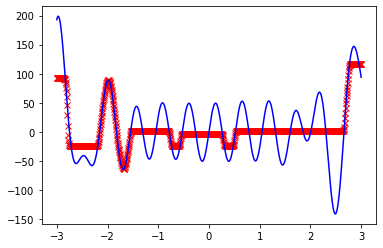

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [12]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.6745306710140373
